# Sendy Logistics Challenge: EDSA

**by Team_1_JHB on June 02, 2020 <br>**





# Challenge Description<br>

Sendy is hosting a Zindi challenge in partnership with insight2impact facility to predict the estimated delivery time of orders, from the driver pickup point to the point of arrival at the final destination.


The solution will help Sendy improve the communication with customers and improve the reliability of its service, which will ultimately improve the customer experience. Moreover, the solution would allow Sendy to realize cost savings and eventually reduce business costs by enhancing resource management and order scheduling planning.

# Notebook Outline

  1. Package Installation
  2. Importing Libraries
  3. Importing Data
  4. Data Cleaning and Formating
  5. Exploratory Data Analysis
  6. Feature Engineering and Selection
  7. Model Selection & Parameter Tuning
  8. Model Evaluation
  9. Submission 
  10. References

## 1. Package Installation

In [1]:
!pip install catboost
!pip install category_encoders


## 2. Importing Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

#To deal with warnings
import warnings
warnings.filterwarnings("ignore")

# Feature Encoding & Dimensionality Reduction
import category_encoders as ce
from sklearn.decomposition import PCA
from geopy.distance import vincenty
from sklearn.cluster import MiniBatchKMeans

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, RobustScaler # For normalization


#from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor


# Model Evaluation
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error 
rs = 50 # Random State

## 3. Importing Data

In [3]:
#Now let's import datasets
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
riders = pd.read_csv("Riders.csv")
dictionary = pd.read_csv('VariableDefinitions.csv')

In [4]:
# Viewing the datasets
display(train.head(3))
display(test.head(3))
display(riders.head(3))
display(dictionary.head())

Order No       User Id Vehicle Type  Platform Type  \
0   Order_No_4211   User_Id_633         Bike              3   
1  Order_No_25375  User_Id_2285         Bike              3   
2   Order_No_1899   User_Id_265         Bike              3   

  Personal or Business  Placement - Day of Month  \
0             Business                         9   
1             Personal                        12   
2             Business                        30   

   Placement - Weekday (Mo = 1) Placement - Time  Confirmation - Day of Month  \
0                             5       9:35:46 AM                            9   
1                             5      11:16:16 AM                           12   
2                             2      12:39:25 PM                           30   

   Confirmation - Weekday (Mo = 1)  ... Arrival at Destination - Time  \
0                                5  ...                   10:39:55 AM   
1                                5  ...                   12:17:22 PM   
2                                2  ...                    1:00:38 PM   

   Distance (KM)  Temperature Precipitation in millimeters  Pickup Lat  \
0              4         20.4                          NaN   -1.317755   
1             16         26.4                          NaN   -1.351453   
2              3          NaN                          NaN   -1.308284   

   Pickup Long Destination Lat  Destination Long      Rider Id  \
0    36.830370       -1.300406         36.829741  Rider_Id_432   
1    36.899315       -1.295004         36.814358  Rider_Id_856   
2    36.843419       -1.300921         36.828195  Rider_Id_155   

  Time from Pickup to Arrival  
0                         745  
1                        1993  
2                         455  

[3 rows x 29 columns]

Order No       User Id Vehicle Type  Platform Type  \
0  Order_No_19248  User_Id_3355         Bike              3   
1  Order_No_12736  User_Id_3647         Bike              3   
2    Order_No_768  User_Id_2154         Bike              3   

  Personal or Business  Placement - Day of Month  \
0             Business                        27   
1             Business                        17   
2             Business                        27   

   Placement - Weekday (Mo = 1) Placement - Time  Confirmation - Day of Month  \
0                             3       4:44:10 PM                           27   
1                             5      12:57:35 PM                           17   
2                             4      11:08:14 AM                           27   

   Confirmation - Weekday (Mo = 1)  ... Pickup - Weekday (Mo = 1)  \
0                                3  ...                         3   
1                                5  ...                         5   
2                                4  ...                         4   

   Pickup - Time  Distance (KM) Temperature  Precipitation in millimeters  \
0     5:06:47 PM              8         NaN                           NaN   
1     1:25:37 PM              5         NaN                           NaN   
2    11:57:54 AM              5        22.8                           NaN   

   Pickup Lat Pickup Long  Destination Lat  Destination Long      Rider Id  
0   -1.333275   36.870815        -1.305249         36.822390  Rider_Id_192  
1   -1.272639   36.794723        -1.277007         36.823907  Rider_Id_868  
2   -1.290894   36.822971        -1.276574         36.851365   Rider_Id_26  

[3 rows x 25 columns]

Rider Id  No_Of_Orders   Age  Average_Rating  No_of_Ratings
0  Rider_Id_396          2946  2298            14.0           1159
1  Rider_Id_479           360   951            13.5            176
2  Rider_Id_648          1746   821            14.3            466

Order No                Unique number identifying the order
0                   User Id  Unique number identifying the customer on a pl...
1              Vehicle Type  For this competition limited to bikes, however...
2             Platform Type  Platform used to place the order, there are 4 ...
3      Personal or Business                                      Customer type
4  Placement - Day of Month                  Placement - Day of Month i.e 1-31

## 4. Data Cleaning and Formatting

### 4.1. Fixing Messy Column names

In [5]:
def column_name_fix(input_df):
    input_df.columns = input_df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('=', '_')
    input_df.columns = input_df.columns.str.replace('__', '_')
    input_df.columns = input_df.columns.str.replace('(', '').str.replace(')', '')
    input_df.columns = input_df.columns.str.replace('__', '_')
    display(input_df.columns)

In [6]:
# train dataset
column_name_fix(train)

#test dataset
column_name_fix(test)

#riders dataset
column_name_fix(riders)

Index(['order_no', 'user_id', 'vehicle_type', 'platform_type',
       'personal_or_business', 'placement_day_of_month',
       'placement_weekday_mo_1', 'placement_time', 'confirmation_day_of_month',
       'confirmation_weekday_mo_1', 'confirmation_time',
       'arrival_at_pickup_day_of_month', 'arrival_at_pickup_weekday_mo_1',
       'arrival_at_pickup_time', 'pickup_day_of_month', 'pickup_weekday_mo_1',
       'pickup_time', 'arrival_at_destination_day_of_month',
       'arrival_at_destination_weekday_mo_1', 'arrival_at_destination_time',
       'distance_km', 'temperature', 'precipitation_in_millimeters',
       'pickup_lat', 'pickup_long', 'destination_lat', 'destination_long',
       'rider_id', 'time_from_pickup_to_arrival'],
      dtype='object')

Index(['order_no', 'user_id', 'vehicle_type', 'platform_type',
       'personal_or_business', 'placement_day_of_month',
       'placement_weekday_mo_1', 'placement_time', 'confirmation_day_of_month',
       'confirmation_weekday_mo_1', 'confirmation_time',
       'arrival_at_pickup_day_of_month', 'arrival_at_pickup_weekday_mo_1',
       'arrival_at_pickup_time', 'pickup_day_of_month', 'pickup_weekday_mo_1',
       'pickup_time', 'distance_km', 'temperature',
       'precipitation_in_millimeters', 'pickup_lat', 'pickup_long',
       'destination_lat', 'destination_long', 'rider_id'],
      dtype='object')

Index(['rider_id', 'no_of_orders', 'age', 'average_rating', 'no_of_ratings'], dtype='object')

### 4.2. Addressing Missing Values  & Unique Values

A **drop_columns** function will be employed to remove any column from the dataframes which has a percentage of missing values greater than a specified `cutoff threshold value` and `unique value` count less than the specified.

In [7]:
def drop_columns(input_df, threshold, unique_threshold):
    for column in input_df.columns:
        if ((input_df[column].isna().mean() * 100) > threshold):
            input_df.drop(column, axis = 1, inplace = True)
            print(f'The {column} column is dropped')
        elif (input_df[column].nunique() < unique_threshold):
            input_df.drop(column, axis = 1, inplace = True)
            print(f'The {column} column is dropped')

In [8]:
# A threshold value of 70% is initially used
drop_columns(train, 70, 2)

The vehicle_type column is dropped
The precipitation_in_millimeters column is dropped


In [9]:
# Test dataset
drop_columns(test, 70, 2)

The vehicle_type column is dropped
The precipitation_in_millimeters column is dropped


Text(0.5, 1, 'Test missing values heatmap')

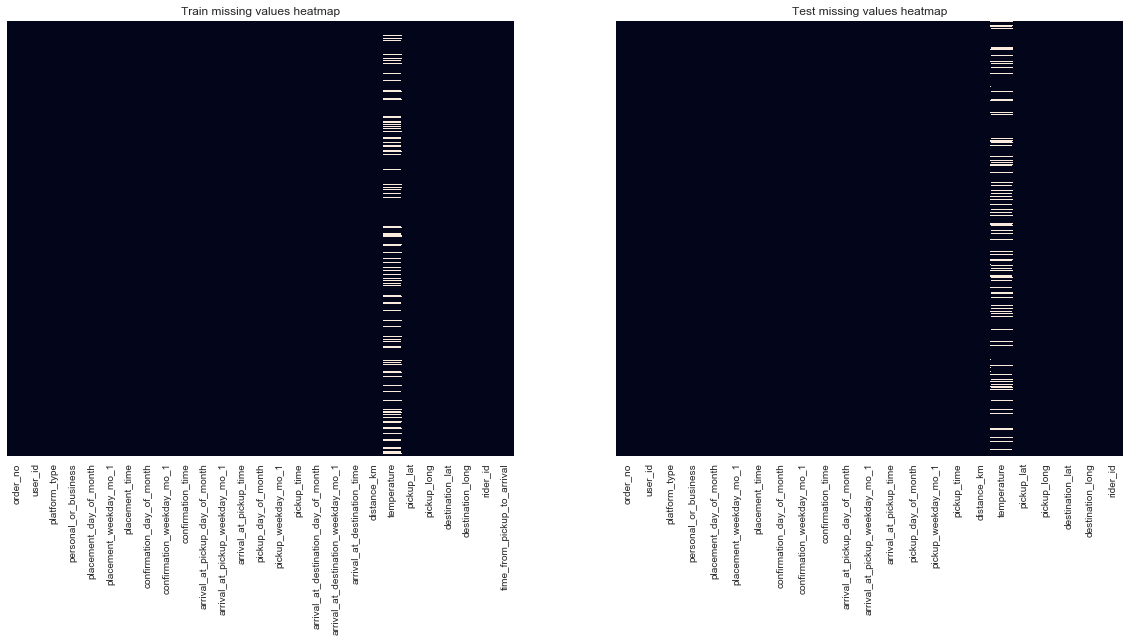

In [10]:
# Addressing columns that have missing values but their percentage is below the threshold value
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(train.isna(), ax = ax[0], yticklabels=False, cbar=False)
sns.heatmap(test.isna(), ax = ax[1], yticklabels=False, cbar=False)
ax[0].set_title('Train missing values heatmap')
ax[1].set_title('Test missing values heatmap')

The Temperature column on both datasets has some missing values. Let's look at the distribution of the temperature values in order to gain good insight towards value imputation. It would be pre-mature to simply the mean or the median since we do not know anything about the distribution of the data. The mean is sensitive to outliers whereas the median is not. Let's look at the distribution.

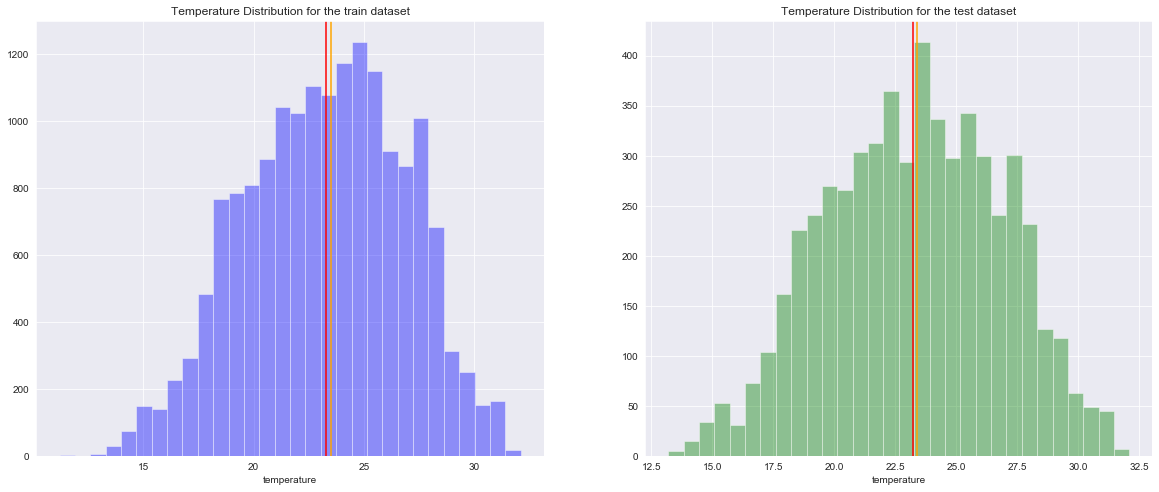

In [11]:
# Temperature distributions
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.distplot(train['temperature'], bins=30, color='blue', ax = ax[0], kde=False)
sns.distplot(test['temperature'], bins=30, color='green', ax = ax[1], kde=False)
ax[0].set_title('Temperature Distribution for the train dataset')
ax[1].set_title('Temperature Distribution for the test dataset')
ax[0].axvline(x=train['temperature'].mean(), color='red')
ax[0].axvline(x=train['temperature'].median(), color='orange')
ax[1].axvline(x=test['temperature'].mean(), color='red')
ax[1].axvline(x=test['temperature'].median(), color='orange')

The Temperature columns for both datasets are normally distributed thus it would be reasonable to impute the missing values with either the mean or the median value. In this case we will impute the mean.

In [12]:
# Missing values imputation
train['temperature'].fillna(train['temperature'].mean(), inplace=True)
test['temperature'].fillna(test['temperature'].mean(), inplace=True)

### 4.3. Merging Dataframes

In [13]:
# Merging the (train & test) datasets with the riders dataframe on 'Rider Id'
train = pd.merge(train, riders, on='rider_id', how='left')
test = pd.merge(test, riders, on='rider_id', how='left')

In [14]:
display(train.head(3))
display(test.head(3))

order_no       user_id  platform_type personal_or_business  \
0   Order_No_4211   User_Id_633              3             Business   
1  Order_No_25375  User_Id_2285              3             Personal   
2   Order_No_1899   User_Id_265              3             Business   

   placement_day_of_month  placement_weekday_mo_1 placement_time  \
0                       9                       5     9:35:46 AM   
1                      12                       5    11:16:16 AM   
2                      30                       2    12:39:25 PM   

   confirmation_day_of_month  confirmation_weekday_mo_1 confirmation_time  \
0                          9                          5        9:40:10 AM   
1                         12                          5       11:23:21 AM   
2                         30                          2       12:42:44 PM   

   ...  pickup_lat  pickup_long destination_lat  destination_long  \
0  ...   -1.317755    36.830370       -1.300406         36.829741   
1  ...   -1.351453    36.899315       -1.295004         36.814358   
2  ...   -1.308284    36.843419       -1.300921         36.828195   

       rider_id time_from_pickup_to_arrival  no_of_orders   age  \
0  Rider_Id_432                         745          1637  1309   
1  Rider_Id_856                        1993           396   339   
2  Rider_Id_155                         455          1023   242   

  average_rating  no_of_ratings  
0           13.8            549  
1           13.6             69  
2           12.5            114  

[3 rows x 31 columns]

order_no       user_id  platform_type personal_or_business  \
0  Order_No_19248  User_Id_3355              3             Business   
1  Order_No_12736  User_Id_3647              3             Business   
2    Order_No_768  User_Id_2154              3             Business   

   placement_day_of_month  placement_weekday_mo_1 placement_time  \
0                      27                       3     4:44:10 PM   
1                      17                       5    12:57:35 PM   
2                      27                       4    11:08:14 AM   

   confirmation_day_of_month  confirmation_weekday_mo_1 confirmation_time  \
0                         27                          3        4:44:29 PM   
1                         17                          5       12:59:17 PM   
2                         27                          4       11:25:05 AM   

   ...  temperature  pickup_lat pickup_long  destination_lat  \
0  ...     23.24612   -1.333275   36.870815        -1.305249   
1  ...     23.24612   -1.272639   36.794723        -1.277007   
2  ...     22.80000   -1.290894   36.822971        -1.276574   

   destination_long      rider_id  no_of_orders   age  average_rating  \
0         36.822390  Rider_Id_192           439  1511            13.3   
1         36.823907  Rider_Id_868           488   273            14.4   
2         36.851365   Rider_Id_26           833   460            13.1   

   no_of_ratings  
0            171  
1             45  
2             67  

[3 rows x 27 columns]

In [15]:
train.dtypes

order_no                                object
user_id                                 object
platform_type                            int64
personal_or_business                    object
placement_day_of_month                   int64
placement_weekday_mo_1                   int64
placement_time                          object
confirmation_day_of_month                int64
confirmation_weekday_mo_1                int64
confirmation_time                       object
arrival_at_pickup_day_of_month           int64
arrival_at_pickup_weekday_mo_1           int64
arrival_at_pickup_time                  object
pickup_day_of_month                      int64
pickup_weekday_mo_1                      int64
pickup_time                             object
arrival_at_destination_day_of_month      int64
arrival_at_destination_weekday_mo_1      int64
arrival_at_destination_time             object
distance_km                              int64
temperature                            float64
pickup_lat   

## 5. Exploratory Data Analysis

### 5.1. Classifing features according to their datatypes

In [16]:
numeric_columns = []
object_cat_columns = []
time_columns = []
for i, j in train.dtypes.items():
    if (j != object):
        if (i != "time_from_pickup_to_arrival"):
            numeric_columns.append(i)
    elif i.endswith("time"):
        time_columns.append(i)
    else:
        object_cat_columns.append(i)
train[numeric_columns].head(3) 

platform_type  placement_day_of_month  placement_weekday_mo_1  \
0              3                       9                       5   
1              3                      12                       5   
2              3                      30                       2   

   confirmation_day_of_month  confirmation_weekday_mo_1  \
0                          9                          5   
1                         12                          5   
2                         30                          2   

   arrival_at_pickup_day_of_month  arrival_at_pickup_weekday_mo_1  \
0                               9                               5   
1                              12                               5   
2                              30                               2   

   pickup_day_of_month  pickup_weekday_mo_1  \
0                    9                    5   
1                   12                    5   
2                   30                    2   

   arrival_at_destination_day_of_month  ...  distance_km  temperature  \
0                                    9  ...            4    20.400000   
1                                   12  ...           16    26.400000   
2                                   30  ...            3    23.258889   

   pickup_lat  pickup_long  destination_lat  destination_long  no_of_orders  \
0   -1.317755    36.830370        -1.300406         36.829741          1637   
1   -1.351453    36.899315        -1.295004         36.814358           396   
2   -1.308284    36.843419        -1.300921         36.828195          1023   

    age  average_rating  no_of_ratings  
0  1309            13.8            549  
1   339            13.6             69  
2   242            12.5            114  

[3 rows x 21 columns]

In [17]:
train[object_cat_columns].head(3)

order_no       user_id personal_or_business      rider_id
0   Order_No_4211   User_Id_633             Business  Rider_Id_432
1  Order_No_25375  User_Id_2285             Personal  Rider_Id_856
2   Order_No_1899   User_Id_265             Business  Rider_Id_155

In [18]:
train[time_columns].head(3)

placement_time confirmation_time arrival_at_pickup_time  pickup_time  \
0     9:35:46 AM        9:40:10 AM            10:04:47 AM  10:27:30 AM   
1    11:16:16 AM       11:23:21 AM            11:40:22 AM  11:44:09 AM   
2    12:39:25 PM       12:42:44 PM            12:49:34 PM  12:53:03 PM   

  arrival_at_destination_time  
0                 10:39:55 AM  
1                 12:17:22 PM  
2                  1:00:38 PM

### 5.2. Outliers Overview for numeric features

In [19]:
numeric_columns_new = ['pickup_day_of_month','pickup_weekday_mo_1',
                   'distance_km','temperature','no_of_orders','age','average_rating','no_of_ratings']

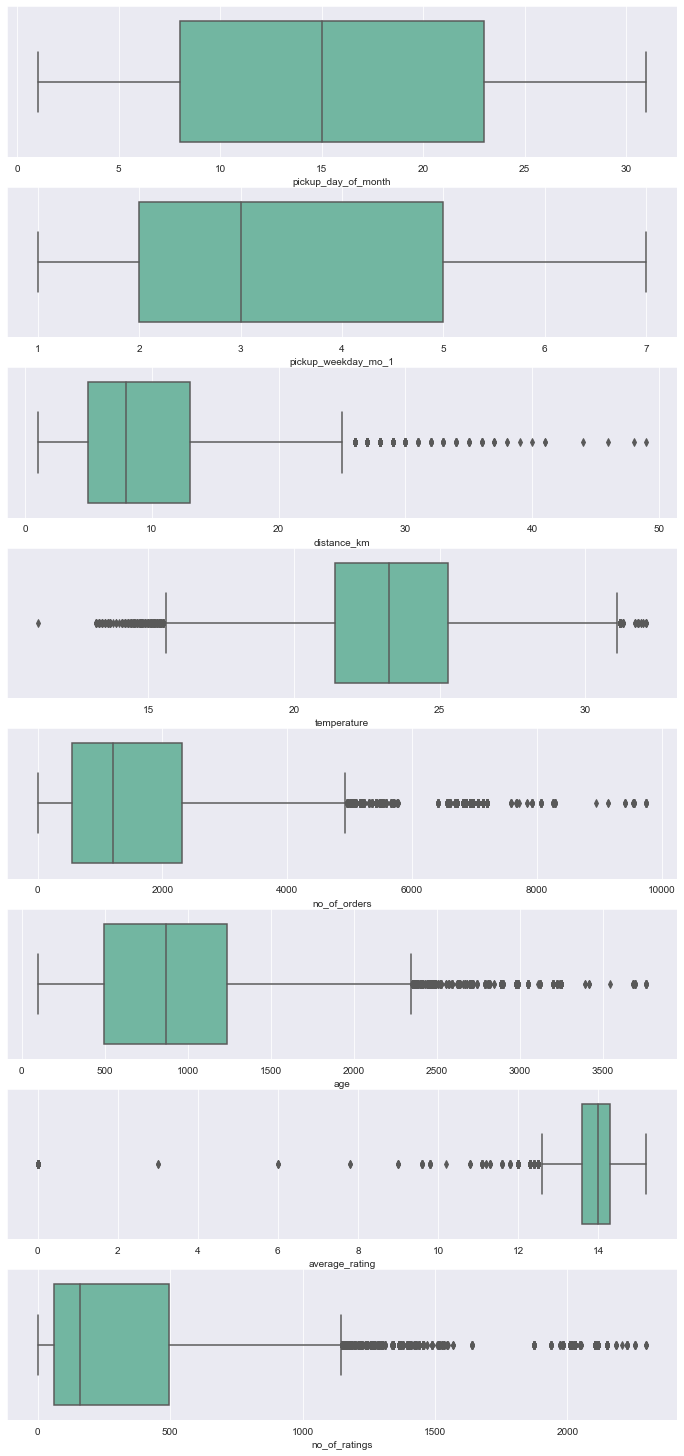

In [20]:
fig, ax = plt.subplots(8,1,figsize=(12,26))
   
for index, column in enumerate(numeric_columns_new):  
    sns.boxplot(train[column], ax=ax[index], palette='Set2')

### 5.3. Correlation between numeric features and the target variable

Since we are dealing with a regression problem it is important to see the correlation between the independent varables and the dependent variable. This can be achieved with the help of a correlation matrix.

In [21]:
correlation_matrix = train[numeric_columns+['time_from_pickup_to_arrival']].corr()
print(correlation_matrix["time_from_pickup_to_arrival"].sort_values(ascending=False))

time_from_pickup_to_arrival            1.000000
distance_km                            0.580608
destination_long                       0.070425
pickup_long                            0.060285
confirmation_weekday_mo_1              0.009744
arrival_at_pickup_weekday_mo_1         0.009744
pickup_weekday_mo_1                    0.009744
arrival_at_destination_weekday_mo_1    0.009744
placement_weekday_mo_1                 0.009693
temperature                            0.005772
no_of_ratings                          0.005609
platform_type                         -0.003827
age                                   -0.007969
arrival_at_destination_day_of_month   -0.014701
pickup_day_of_month                   -0.014701
arrival_at_pickup_day_of_month        -0.014701
confirmation_day_of_month             -0.014701
placement_day_of_month                -0.014710
no_of_orders                          -0.041608
average_rating                        -0.042559
pickup_lat                            -0

There seems to be a strong correlation between the target variable and the distance feature. The rest of the variables do not have such strong correlation with the target variable. 

**Lower correlation** means weak `linear relationship` between the variables but this tells us nothing about their `non-linear` relationship. It would be premature to pass judgement at this level. We will have to further engineer the features and have them in a form that will reveal more information about them.

### 5.4. Examinig the target (time from pickup to arrival at the destination)


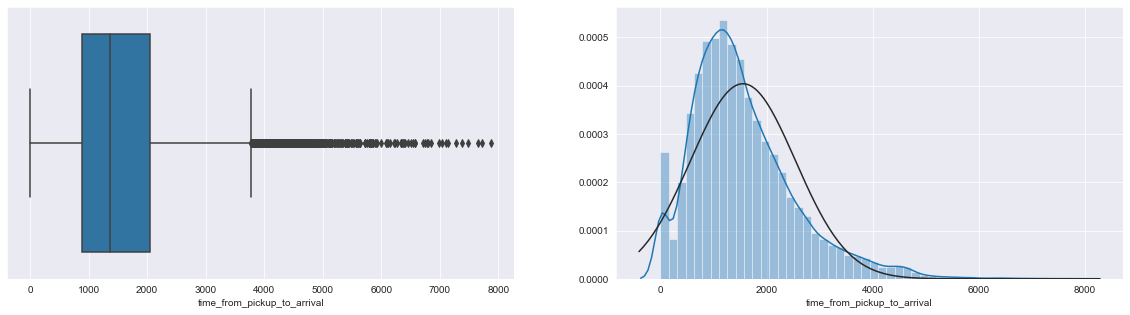

In [22]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.boxplot(train["time_from_pickup_to_arrival"], ax=ax[0])
sns.distplot(train["time_from_pickup_to_arrival"], fit=norm, ax=ax[1])

The `target variable` is **"positively skewed"** and this is mainly caused by a much lower boundary (meaning there are a minority of very large values) in the dataset. This will affect the regression intercept, coefficients associated with the model. This can be fixed in a number of ways including log transformation and boxcox transform. However, in this case, outliers will be dropped.

## 6. Feature Engineering

### 6.1. Addressing Outliers

Outliers can be filtered out using a `speed` feature. A cutoff speed value will be used to filter outliers.
A maximum speed of about **70 km/h or ~19m/s** will be used as a max threshold value and a minimum speed of **10km/h or 3m/s** as minimum threshold value.

In [23]:
### Calculating the Rider's Speed in m/s
train['speed_meter_per_second'] = (train['distance_km'] * 1000) / train['time_from_pickup_to_arrival']

In [24]:
train['speed_meter_per_second'].describe()

count    21201.000000
mean        69.251494
std        529.249252
min          0.255624
25%          4.573171
50%          6.406834
75%          8.413462
max      17000.000000
Name: speed_meter_per_second, dtype: float64

There's definitely outliers. If not addressed they will affect the performance of our models negatively. However, great care has to be taken when removing outliers because the test data might contain these outliers and our models might not deal accordingly with such.

In [25]:
# train dataset without outliers
train = train[(train['speed_meter_per_second'] <= 18) & (train['speed_meter_per_second'] > 2)]

In [26]:
train['speed_meter_per_second'].describe()

count    19467.000000
mean         6.578756
std          2.615524
min          2.000667
25%          4.674770
50%          6.349206
75%          8.103728
max         17.988553
Name: speed_meter_per_second, dtype: float64

### 6.2. Time Features engineering

The following features will be created out of current Date & Time features:
    
   1. **pick_up_quarter_month**
   2. **pickup_day_month**
   3. **pickup_weekday**
   4. **pickup_hour**
   5. **pickup_minute**
   5. **traffic_hour**
   6. **placement_to_confirmation_diff**
   7. **confirmation_to_arrivalpickup_diff**
   8. **arrivalpickup_to_pickup_diff**

The placement_time and confirmation_time features can either be dropped or be used to create more weighty features. We will attemp to create more features out of these. For instance the duration between these features can add a lot of meaning to the data. It could be that the longer the delay until the picking up of the order means that the rider will strive to prioritize that order in order to make it up to the client for the prior delay. We are just assuming here but the variable selection will prove this assumption true or false.

First let's convert all our time features to datetime format.

In [27]:
def convert_to_datetime(df):
    for col in df.columns:
        if col.endswith("time"):
            df[col] = pd.to_datetime(df[col])
    return df

In [28]:
train = convert_to_datetime(train)
test = convert_to_datetime(test)

In [29]:
# The function classifies the days of the month to their respective quarter of the month
def quarter_of_month(x):
    if x >= 1 and x <= 7:
        return 1
    elif x > 7 and x <= 14:
        return 2
    elif x > 14 and x <= 21:
        return 3
    else:
        return 4
    
#Applying quarter_of_month
train["pick_up_quarter_month"] = train["pickup_day_of_month"].apply(quarter_of_month)
test["pick_up_quarter_month"] = test["pickup_day_of_month"].apply(quarter_of_month)

Text(0.5, 1.0, 'Test data set')

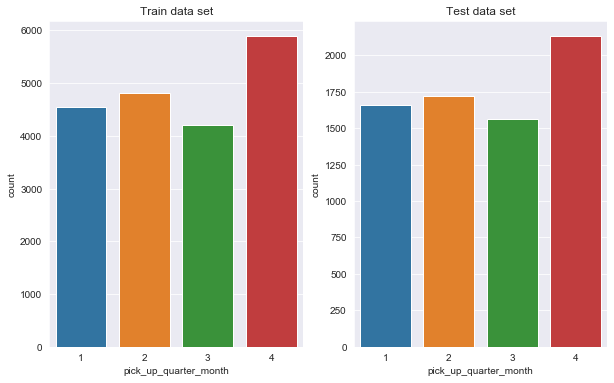

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(train["pick_up_quarter_month"], ax=ax[0])
sns.countplot(test["pick_up_quarter_month"], ax=ax[1])
ax[0].set_title('Train data set')
ax[1].set_title('Test data set')

The countplot above clearly shows that the traffic congestion is not the same throughout the month. In the last week of the month we see an increase in orders made and this means traffic in general does increase. This is a very important insight and it will simplify the learnarity of the model.

Let us also look into the distribution of the pickup weekdays and see if whether the number of orders does vary during the week and on weekend. Our first assumption is that traffic eases during weekends as compared to the middle of the week.

Text(0.5, 1.0, 'Test data set')

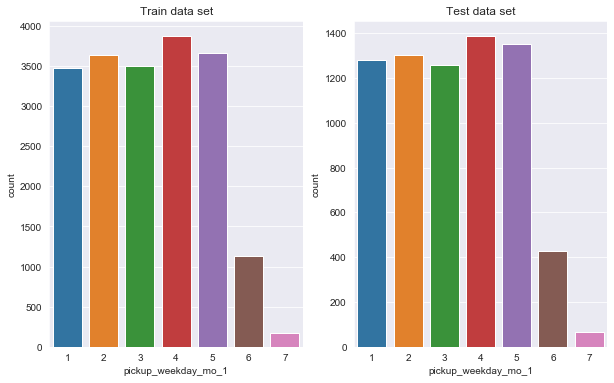

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.countplot(train["pickup_weekday_mo_1"], ax=ax[0])
sns.countplot(test["pickup_weekday_mo_1"], ax=ax[1])
ax[0].set_title('Train data set')
ax[1].set_title('Test data set')

Our prediction was true! The number of orders made on weekends is far less than the number of orders made during the week. There isn't much variability in number of orders during the week and this can be problematic to our models. This can be resolved by classifying an order as either falling during the week or on weekend. We will use a binary set of 0 (Not weekend) and 1 (Weekend).

In [32]:
# A function that classifies days as either falling on a weekend or not_weekend
def weekend(x):
    if x <= 5:
        return 1
    else:
        return 0
    
#Applying the not_weekend function to create a new feature
train["weekend"] = train["pickup_weekday_mo_1"].apply(weekend)
test["weekend"] = test["pickup_weekday_mo_1"].apply(weekend)

As for the placement, confirmation and arrival at pickup features, we can choose to ignore them since they more or less resemble the pickup features. However, there could be some correlation between them and the target variable. There could even be some causation. Our imagination tells us that the longer it took for the rider to arrive at the pickup point the higher the order will be prioritized in order to make up for the delay. This could motivate the rider to travel faster that usual. Further analysis will either prove us wrong or right.

We will thus compute the time difference between these features successively.

In [33]:
# train set
train['placement_to_confirmation_diff'] =  (train['confirmation_time'] - train['placement_time']).astype('timedelta64[s]')
train['confirmation_to_arrivalpickup_diff'] = (train['arrival_at_pickup_time'] - train['confirmation_time']).astype('timedelta64[s]')
train['arrivalpickup_to_pickup_diff'] = (train['pickup_time'] - train['arrival_at_pickup_time']).astype('timedelta64[s]')

# test set
test['placement_to_confirmation_diff'] = (test['confirmation_time'] - test['placement_time']).astype('timedelta64[s]')
test['confirmation_to_arrivalpickup_diff'] = (test['arrival_at_pickup_time'] - test['confirmation_time']).astype('timedelta64[s]')
test['arrivalpickup_to_pickup_diff'] = (test['pickup_time'] - test['arrival_at_pickup_time']).astype('timedelta64[s]')

Traffic on the road is one of the high determining factors in terms of one's travel duration from one destination to another. We would expect longer trip durations during breakfast rushhour and also during knockoff rush hour. Traffic should ease during mid hours. With this in mind we will have to make the most out of the **pickup_time** feature. 

Below is the extraction of 'hour', 'minute' and 'second' components of our pickup time

In [34]:
# Extracting the hour and minute component of pickup_time
train['pickup_time'.split('_')[0] + '_hour'] = train['pickup_time'].dt.hour
test['pickup_time'.split('_')[0] + '_hour'] = test['pickup_time'].dt.hour
train['pickup_time'.split('_')[0] + '_minute'] = train['pickup_time'].dt.minute
test['pickup_time'.split('_')[0] + '_minute'] = test['pickup_time'].dt.minute
train['pickup_time'.split('_')[0] + '_second'] = train['pickup_time'].dt.second
test['pickup_time'.split('_')[0] + '_second'] = test['pickup_time'].dt.second

Some of our data is inherently cyclical. Time is a rich example of this: minutes, hours, seconds, day of week, and week of month. All these follow cycles. We have a lot of such features in our data and we want to convey their cyclical nature to our model. But how can we do this? 

The trick is to create two new features, deriving a sine transform and cosine transform. We map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using `sin` and `cos` trigonometric functions.

$${x}_{sin} =  {sin}(\frac{2 * \pi * x}{max(x)})$$<br>

$${x}_{cos} =  {cos}(\frac{2 * \pi * x}{max(x)})$$<br>

For us to do that, we need to look at all unique values for every cyclic feature.

In [35]:
print('The unique day values of a month:', sorted(train['pickup_day_of_month'].unique()))
print('The unique weekday values:',sorted(train['pickup_weekday_mo_1'].unique()))
print('The unique hour values:', sorted(train['pickup_hour'].unique()))

The unique day values of a month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
The unique weekday values: [1, 2, 3, 4, 5, 6, 7]
The unique hour values: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [36]:
train['pickup_day_of_month_sin'] = np.sin(train['pickup_day_of_month']*(2.*np.pi/31))
train['pickup_day_of_month_cos'] = np.cos(train['pickup_day_of_month']*(2.*np.pi/31))
train['pickup_weekday_sin'] = np.sin(train['pickup_weekday_mo_1']*(2.*np.pi/7))
train['pickup_weekday_cos'] = np.cos(train['pickup_weekday_mo_1']*(2.*np.pi/7))
train['pickup_hour_sin'] = np.sin(train['pickup_hour']*(2.*np.pi/23))
train['pickup_hour_cos'] = np.cos(train['pickup_hour']*(2.*np.pi/23)) 
train['pickup_minute_sin'] = np.sin(train['pickup_minute']*(2.*np.pi/60)) 
train['pickup_minute_cos'] = np.cos(train['pickup_minute']*(2.*np.pi/60))
train['pickup_second_sin'] = np.sin(train['pickup_second']*(2.*np.pi/60))
train['pickup_second_cos'] = np.cos(train['pickup_second']*(2.*np.pi/60)) 


#Test data set
test['pickup_day_of_month_sin'] = np.sin(test['pickup_day_of_month']*(2.*np.pi/31))
test['pickup_day_of_month_cos'] = np.cos(test['pickup_day_of_month']*(2.*np.pi/31))
test['pickup_weekday_sin'] = np.sin(test['pickup_weekday_mo_1']*(2.*np.pi/7))
test['pickup_weekday_cos'] = np.cos(test['pickup_weekday_mo_1']*(2.*np.pi/7))
test['pickup_hour_sin'] = np.sin(test['pickup_hour']*(2.*np.pi/23)) 
test['pickup_hour_cos'] = np.cos(test['pickup_hour']*(2.*np.pi/23)) 
test['pickup_minute_sin'] = np.sin(test['pickup_minute']*(2.*np.pi/60)) 
test['pickup_minute_cos'] = np.cos(test['pickup_minute']*(2.*np.pi/60)) 
test['pickup_second_sin'] = np.sin(test['pickup_second']*(2.*np.pi/60))
test['pickup_second_cos'] = np.cos(test['pickup_second']*(2.*np.pi/60)) 


if we plot the features in two dimensions, we end up with a perfect cycle (or close to a perfect cycle) for every feature. 

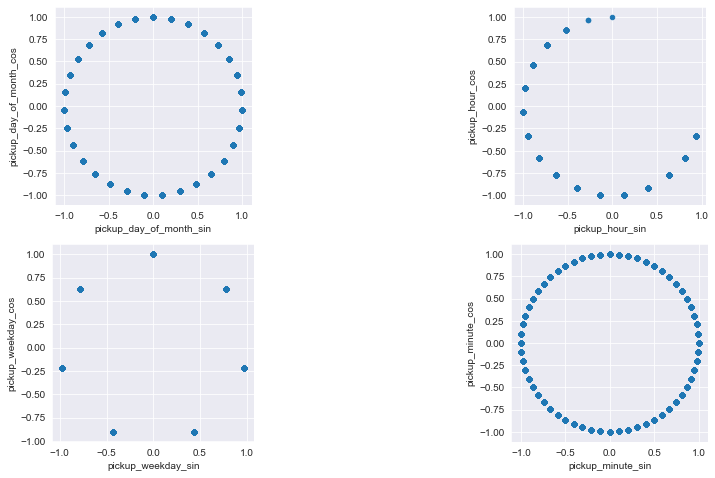

In [37]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
train.plot.scatter('pickup_day_of_month_sin', 'pickup_day_of_month_cos', ax=ax[0,0]).set_aspect('equal')
train.plot.scatter('pickup_hour_sin', 'pickup_hour_cos', ax=ax[0,1]).set_aspect('equal')
train.plot.scatter('pickup_weekday_sin', 'pickup_weekday_cos', ax=ax[1,0]).set_aspect('equal')
train.plot.scatter('pickup_minute_sin', 'pickup_minute_cos', ax=ax[1,1]).set_aspect('equal')


The features can now be used by our machine learning algorithms and as an added benefit, they are also scaled to the range [-1, 1] which will also aid our predictions.

Now that we have encoded our cyclic features we can drop all un-encoded features

In [38]:
time_cols = ['placement_time','arrival_at_pickup_time','pickup_time','confirmation_time']
train.drop(time_cols, axis=1, inplace=True)
test.drop(time_cols, axis=1, inplace=True)

more_train_cols = ['placement_day_of_month','confirmation_day_of_month',
                   'pickup_day_of_month', 'pickup_weekday_mo_1',
                   'arrival_at_pickup_day_of_month','arrival_at_pickup_weekday_mo_1',
                   'placement_weekday_mo_1','confirmation_weekday_mo_1',
                   'pickup_minute','arrival_at_destination_day_of_month', 
                   'arrival_at_destination_weekday_mo_1', 'pickup_hour', 'pickup_second']

more_test_cols = ['placement_day_of_month','confirmation_day_of_month',
                  'pickup_day_of_month', 'pickup_weekday_mo_1',
                  'arrival_at_pickup_day_of_month','arrival_at_pickup_weekday_mo_1',
                  'placement_weekday_mo_1','confirmation_weekday_mo_1',
                  'pickup_minute', 'pickup_hour','pickup_second']

train.drop(more_train_cols, axis=1, inplace=True)
test.drop(more_test_cols, axis=1, inplace=True)

### 6.3. Rider's Features engineering

#### 6.3.1. Rider's Rating & Productivity

Dimensionality reduction is always a good thing provided we preserve the information. We can do so even with rider's features. Some of the rider's features are a bit obscure but with proper engineering they can add much value to the modellling. We do this by creating a feature called `rating_factor` which is the product of `average rating` and `number of ratings`. Another feature we create is `rider_productivity` feature, which is a ratio of `rider's age` to `number of orders`.

This will help normalize the rider's features. For example, you might find that one rider has a high average rating but few number of ratings. On the other hand, one rider has a slightly lower rating with many ratings. At face value one would think the rider with higher average rating is better than the one with a slightly lower rating. However, this is necessarily not the case. To deal with such issues we combine both the rating and number of ratings. The same applies with age and number of orders. 

In [39]:
#Creating new variables that will measure the Rider's Rating and Productivity
train.loc[:, 'rating_factor'] = (train['average_rating'] * train['no_of_ratings'])
test.loc[:, 'rating_factor'] = (test['average_rating'] * test['no_of_ratings'])
train.loc[:, 'rider_productivity'] = (train['age'] / train['no_of_orders'])
test.loc[:, 'rider_productivity'] = (test['age'] / test['no_of_orders'])

#### 6.3.2. Rider's Id uniqueness

Furthermore let us explore the uniqueness of the **Rider's Id** feature. It is of great interest to know how many unique riders are found on both datasets and how many are not. From this we will be able to decide whether the Rider's Id can add value to our models or not.

In [40]:
print('The train dataset has', train['rider_id'].nunique(), 'unique riders.')
print('The test dataset has', test['rider_id'].nunique(), 'unique riders.')
how_many = len(set([rider for rider in test['rider_id'] if rider in train['rider_id'].unique()]))
print('Both datasets share', how_many, 'unique riders')

The train dataset has 919 unique riders.
The test dataset has 822 unique riders.
Both datasets share 792 unique riders


From the above analysis it is clear that the rider's id feature cannot be dropped since both datasets share the majority of riders. Each rider is unique and this will add weight to the modelling.

#### 6.3.3. Rider's average speed

It is important that we create another feature that will give us insight into the rider's general performance in terms of how fast or slow the rider is. This will provide our models with a good frame of reference when predicting the trip duration for every order done by a specific rider.

In [41]:
train['average_rider_speed'] = train['rider_id'].map(train.groupby('rider_id')['speed_meter_per_second'].mean())
test['average_rider_speed'] = test['rider_id'].map(train.groupby('rider_id')['speed_meter_per_second'].mean())

We have seen that the two datasets do not exactly have same riders thus the above computation will result in the `average_rider_speed` in the test set having null values. The null values will be imputed with the average_rider_speed from the train dataset.

In [42]:
test['average_rider_speed'].fillna(train['speed_meter_per_second'].mean(), inplace=True)

### 6.4. Geospatial Features engineering

Needless to say, the two most important geospatial features to any travel time prediction problem are distance, and direction.

#### 6.4.1. Haversine distance

We are going to feature a measure of distance between pick-up and drop-off coordinates namely Haversine distance and. This approach is highly encouraged by many independent studies on travel time prediction and optimization.

Due to the spherical shape of the earth, when travelling between two points, we are not traversing in a straight line, but rather on a curvature. To consider that curvature distance (which is different than euclidean distance), `Haversine` distance is calculated.

In [43]:
def haversine(pick_lat, pick_long, drop_lat, drop_long):
    """
    Calculate the circle distance between two points 
    on the earth (specified in decimal degrees)
    """
   # approximate radius of earth in km
    R = 6373.0
    
    # Converting degrees to radians
    pick_lat = np.deg2rad(pick_lat)                     
    pick_long = np.deg2rad(pick_long)     
    drop_lat = np.deg2rad(drop_lat)                       
    drop_long = np.deg2rad(drop_long)  

    dist = np.sin((drop_lat - pick_lat)/2)**2 + np.cos(pick_lat)*np.cos(drop_lat) * np.sin((drop_long - pick_long)/2)**2

    return 2 * R * np.arcsin(np.sqrt(dist))

In [45]:
train.loc[:, 'distance_haversine'] = haversine(train['pickup_lat'].values, train['pickup_long'].values, train['destination_lat'].values, train['destination_long'].values)
test.loc[:, 'distance_haversine'] = haversine(test['pickup_lat'].values, test['pickup_long'].values, test['destination_lat'].values, test['destination_long'].values)


In [46]:
train["min_distance_pick_to_arrival"] = train.apply(lambda x: vincenty((x["pickup_lat"], x["pickup_long"]), (x["destination_lat"], x["destination_long"])).kilometers, axis = 1)
test["min_distance_pick_to_arrival"] = test.apply(lambda x: vincenty((x["pickup_lat"], x["pickup_long"]), (x["destination_lat"], x["destination_long"])).kilometers, axis = 1)
train["excess_distance"] = train["distance_km"] - train["min_distance_pick_to_arrival"]
test["excess_distance"] = test["distance_km"] - test["min_distance_pick_to_arrival"]

#### 6.4.2. Direction

As mentioned already, direction or bearing, does play a huge role in navigation and in travel time prediction. Bearing can be defined as direction or an angle, between the north-south line of earth and the line connecting the target (destination) and the reference point while heading is an angle or direction where you are currently navigating in. Therefore in order to get to a particular destination one needs to adjust their heading direction with the bearing. Below we calculate the direction of the trips.

In [47]:
def bearing_array(lat1, long1, lat2, long2):
    '''
    The function calculates the direction bearing of the given coordinates
    '''
    long_delta_rad = np.radians(long2 - long1)
    lat1, long1, lat2, long2 = map(np.radians, (lat1, long1, lat2, long2))
    y = np.sin(long_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(long_delta_rad)
    angle = np.degrees(np.arctan2(y, x))
    return angle

In [48]:
#Calculating the direction of the destination by applying bearing_array func on the coordinates
train.loc[:, 'direction'] = bearing_array(train['pickup_lat'].values, train['pickup_long'].values, train['destination_lat'].values, train['destination_long'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_lat'].values, test['pickup_long'].values, test['destination_lat'].values, test['destination_long'].values)

#### 6.4.3. Principal Component Analysis (PCA)

The chief idea behind **PCA** is to reduce the dimensionality of the data set, while retaining as much as possible of the variation present in the data set.

In this study, we use PCA to extract features related to latitude and longitude to improve our regressor’s learnability.

It has been proven that PCA features can improve decision tree splitting [Nasution, Sitompul, & Ramli, 2018](https://www.sciencedirect.com/science/article/pii/S0957417419305743#bib0025)

In [49]:
coordinates = np.vstack((train[['pickup_lat', 'pickup_long']].values,
                    train[['destination_lat', 'destination_long']].values))

pca = PCA(random_state=rs).fit(coordinates) #Instance
# Train data transformation
train['pickup_pca_0'] = pca.transform(train[['pickup_lat', 'pickup_long']])[:, 0]
train['pickup_pca_1'] = pca.transform(train[['pickup_lat', 'pickup_long']])[:, 1]
train['dropoff_pca_0'] = pca.transform(train[['destination_lat', 'destination_long']])[:, 0]
train['dropoff_pca_1'] = pca.transform(train[['destination_lat', 'destination_long']])[:, 1]
# Test data transformation
test['pickup_pca_0'] = pca.transform(test[['pickup_lat', 'pickup_long']])[:, 0]
test['pickup_pca_1'] = pca.transform(test[['pickup_lat', 'pickup_long']])[:, 1]
test['dropoff_pca_0'] = pca.transform(test[['destination_lat', 'destination_long']])[:, 0]
test['dropoff_pca_1'] = pca.transform(test[['destination_lat', 'destination_long']])[:, 1]

#### 6.4.4. Cluster analysis on Coordinates

Besides PCA, we have implemented a version of KMeans clustering algorithm which initializes centroids by probabilities that maximize expected centroids’ distance and uses Manhattan distance as loss function.

Clusters capture the natural structure of the data and thus help our algorithms to do a better job at predicting the target feature. In this case we will create pickup clusters and drop off clusters that will increase the accuracy of our predictions as the models will be able to relate every observation to its relevant cluster. This will be done using the scikit-learn `MiniBatchKMeans`

In [50]:
#performing our own clustering on all the points pickup/destination in the data using KMeans
coordinates = np.vstack((train[['pickup_lat', 'pickup_long']].values,
                    train[['destination_lat', 'destination_long']].values))

Kmeans = MiniBatchKMeans(n_clusters=14, batch_size=1000,random_state=rs) #Instance
Kmeans.fit(coordinates[np.arange(0, len(coordinates), 1)]) # fitting
train['pickup_cluster'] = Kmeans.predict(train[['pickup_lat', 'pickup_long']])
train['dropoff_cluster'] = Kmeans.predict(train[['destination_lat', 'destination_long']])
test['pickup_cluster'] = Kmeans.predict(test[['pickup_lat', 'pickup_long']])
test['dropoff_cluster'] = Kmeans.predict(test[['destination_lat', 'destination_long']])
train['center_latitude'] = (train['pickup_lat'].values + train['destination_lat'].values) / 2
train['center_longitude'] = (train['pickup_long'].values + train['destination_long'].values) / 2
test['center_latitude'] = (test['pickup_lat'].values + test['destination_lat'].values) / 2
test['center_longitude'] = (test['pickup_long'].values + test['destination_long'].values) / 2

In [51]:
import plotly.express as px
# There is a .mapbox_token file containing a mapbox token in the same directory as the dataframe
px.set_mapbox_access_token(open(".mapbox_token").read()) #opening the file
fig = px.scatter_mapbox(train, lat="pickup_lat", lon="pickup_long", color="pickup_cluster",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

### 6.5. Variable Encoding

Let us once more take a look into our features

In [52]:
display(train.columns)
display(test.columns)

Index(['order_no', 'user_id', 'platform_type', 'personal_or_business',
       'arrival_at_destination_time', 'distance_km', 'temperature',
       'pickup_lat', 'pickup_long', 'destination_lat', 'destination_long',
       'rider_id', 'time_from_pickup_to_arrival', 'no_of_orders', 'age',
       'average_rating', 'no_of_ratings', 'speed_meter_per_second',
       'pick_up_quarter_month', 'weekend', 'placement_to_confirmation_diff',
       'confirmation_to_arrivalpickup_diff', 'arrivalpickup_to_pickup_diff',
       'pickup_day_of_month_sin', 'pickup_day_of_month_cos',
       'pickup_weekday_sin', 'pickup_weekday_cos', 'pickup_hour_sin',
       'pickup_hour_cos', 'pickup_minute_sin', 'pickup_minute_cos',
       'pickup_second_sin', 'pickup_second_cos', 'rating_factor',
       'rider_productivity', 'average_rider_speed', 'distance_haversine',
       'min_distance_pick_to_arrival', 'excess_distance', 'direction',
       'pickup_pca_0', 'pickup_pca_1', 'dropoff_pca_0', 'dropoff_pca_1',
       '

Index(['order_no', 'user_id', 'platform_type', 'personal_or_business',
       'distance_km', 'temperature', 'pickup_lat', 'pickup_long',
       'destination_lat', 'destination_long', 'rider_id', 'no_of_orders',
       'age', 'average_rating', 'no_of_ratings', 'pick_up_quarter_month',
       'weekend', 'placement_to_confirmation_diff',
       'confirmation_to_arrivalpickup_diff', 'arrivalpickup_to_pickup_diff',
       'pickup_day_of_month_sin', 'pickup_day_of_month_cos',
       'pickup_weekday_sin', 'pickup_weekday_cos', 'pickup_hour_sin',
       'pickup_hour_cos', 'pickup_minute_sin', 'pickup_minute_cos',
       'pickup_second_sin', 'pickup_second_cos', 'rating_factor',
       'rider_productivity', 'average_rider_speed', 'distance_haversine',
       'min_distance_pick_to_arrival', 'excess_distance', 'direction',
       'pickup_pca_0', 'pickup_pca_1', 'dropoff_pca_0', 'dropoff_pca_1',
       'pickup_cluster', 'dropoff_cluster', 'center_latitude',
       'center_longitude'],
      dtype=

In [53]:
# How do  our datasets vary in features
for col in train.columns:
    if col not in test.columns:
        print(col)

arrival_at_destination_time
time_from_pickup_to_arrival
speed_meter_per_second


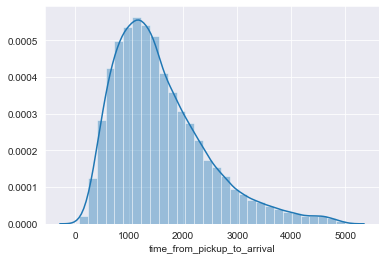

In [54]:
# This is justified in the distplot of the target variable.
train=train[train['time_from_pickup_to_arrival']<=5000] #Filtering out severe outliers

sns.distplot(train['time_from_pickup_to_arrival'], bins=30)

In [55]:
# Dropping all the columns we will no longer need in the predictors (X) data
train_cols_drop = ['order_no', 'user_id','no_of_orders','distance_km', 'age','no_of_ratings', 
                   'average_rating','min_distance_pick_to_arrival', 'speed_meter_per_second','arrival_at_destination_time', 
                   'time_from_pickup_to_arrival']

test_cols_drop = ['order_no','user_id','no_of_orders','min_distance_pick_to_arrival', 'no_of_ratings', 
                  'age', 'average_rating', 'distance_km']

train['platform_type'] = train['platform_type'].astype('category')
test['platform_type'] = test['platform_type'].astype('category')

y_data = train['time_from_pickup_to_arrival']# Target variable
X_data = train.drop(train_cols_drop, axis=1) #Predictors
X_test_data = test.drop(test_cols_drop, axis=1)
X_test_order_no = test['order_no']

Let's one last time check if the datasets have matching features

In [56]:
display(X_test_data.columns == X_data.columns) 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Since some of our features are in categorical/object form, we cannot yet feed the data into a machine learning algorithm, we need to encode them. We will employ `One-hot encoder` for that. `One-hot encoding` is one of the most common encoding methods in machine learning. This method spreads the values in a column to multiple flag columns and assigns 0 or 1 to them. These binary values express the relationship between grouped and encoded column.

This method changes your categorical data, which is challenging to understand for algorithms, to a numerical format and enables you to group your categorical data without losing any information. 

`OneHotEncoder` is preferred over pandas `get_dummies`. The crux of it is that the sklearn encoder creates a function which persists and can then be applied to new data sets which use the same categorical variables, with consistent results.

In [57]:
#Feature Encoding
oce = ce.OneHotEncoder(cols=['platform_type','personal_or_business'])
hce = ce.TargetEncoder(cols=['rider_id'], smoothing = 40, min_samples_leaf = 7)

X_data = oce.fit_transform(X_data)
X_data = hce.fit_transform(X_data,y_data)
X_test_data = oce.transform(X_test_data)
X_test_data = hce.transform(X_test_data)

### 6.6. Feature Selection and Correlation

In [58]:
# Normalize data
def variance_selection(p_value):
    X_data_2 = X_data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_data_2)
    X_normalize = pd.DataFrame(X_scaled, columns=X_data_2.columns)

    # Create VarianceThreshold object
    selector = VarianceThreshold(threshold=0.05)

    # Use the object to apply the threshold on data
    selector.fit(X_normalize)

    # Get column variances
    column_variances = selector.variances_

    vars_dict = {}
    vars_dict = [{"Variable_Name": c_name, "Variance": c_var}
                for c_name, c_var in zip(X_normalize.columns, column_variances)]
    df_vars = pd.DataFrame(vars_dict)
    select_df = df_vars[df_vars['Variance'] <= p_value].sort_values(by='Variance', ascending=False)
    return select_df
variance_selection(0.05)

Variable_Name  Variance
2                      platform_type_3  0.046436
27                       rating_factor  0.030269
22                     pickup_hour_cos  0.024421
6                          temperature  0.023869
11                            rider_id  0.015548
30                  distance_haversine  0.015486
16        arrivalpickup_to_pickup_diff  0.013815
33                        pickup_pca_0  0.012735
8                          pickup_long  0.012721
10                    destination_long  0.012536
40                    center_longitude  0.012509
35                       dropoff_pca_0  0.012457
15  confirmation_to_arrivalpickup_diff  0.011508
7                           pickup_lat  0.011254
34                        pickup_pca_1  0.010926
39                     center_latitude  0.009354
9                      destination_lat  0.007977
36                       dropoff_pca_1  0.007830
29                 average_rider_speed  0.004654
31                     excess_distance  0.003484
14      placement_to_confirmation_diff  0.002870
3                      platform_type_4  0.000876
28                  rider_productivity  0.000194

In [59]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(z = X_data.corr().values, x = X_data.columns, y = X_data.columns, hoverongaps = False))
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue"
)
fig.show()

In [60]:
X_data.drop('personal_or_business_2', axis=1, inplace=True)
X_test_data.drop('personal_or_business_2', axis=1, inplace=True)

## 7. Model Selection & Parameter Tuning

Before we go ahead and build models we want each model to perform at its best and to fit the data to the best of its abilities. This calls for parameter hypertuning. We will tune all our select models except linear regression.


### 7.1. Our Base Models & HyperParameter Tuning

* The Linear Regression model

When building a linear regression model we do not have to include unnecessary features that do not contribute reasonably to the change in the predicted variable.

We will implement backward elimination, whereby we will deselect features that p-value greater than 0.05 being interpreted as a failure to explain the change in the target variable either than just chance. Our linear regression model will be fitted on these. 

RobustScaler will be coupled with our model in order to deal with outliers.

In [61]:
lin_reg = make_pipeline(RobustScaler(), LinearRegression())

* Gradient Boosting Regression :
With huber loss that makes it robust to outliers

In [62]:

# Gradient Boosting Regressor
params = [{'max_depth': [5], #[6, 8, 10]
           'learning_rate':[0.05], #[0.001, 0.05, 0.1]
           'n_estimators': [300], #[100, 200, 400]
           'loss':['huber'],
           'max_features':['auto'],
           'min_samples_leaf':[16], #[14, 15, 17]
           'min_samples_split':[10]}] #[12, 15]

gbr = GridSearchCV(GradientBoostingRegressor(random_state=rs), cv=5,scoring='neg_mean_squared_error', param_grid=params)
gbrm = gbr.fit(X_data, y_data)

print(gbrm.best_params_, np.sqrt(abs(gbrm.best_score_)))


{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 300} 567.4564855799742


{'learning_rate': 0.17, 'loss': 'huber', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 300} 576.0986013100938

{'learning_rate': 0.05, 'loss': 'huber', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 300} 567.
4564855799742

{'learning_rate': 0.17, 'loss': 'huber', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200} 573.1216768860124

* Decision Tree Regressor:




In [63]:
# Decision Tree
params = [{'max_depth': [1,2,3,4,5,10,20,50]}]
dtree = GridSearchCV(DecisionTreeRegressor(random_state=rs), cv=5,scoring='neg_mean_squared_error', param_grid=params)
dtreem = dtree.fit(X_data, y_data)

print(dtreem.best_params_, np.sqrt(abs(dtreem.best_score_)))

{'max_depth': 5} 618.3371532219043


* Random Forest Regressor

In [64]:
# Random Forests
params = [{'max_depth': [5], #, [10, 15, 20, 50]
               'n_estimators': [200, 300]}] #[10, 25, 50, 100,150]

rfr = GridSearchCV(RandomForestRegressor(random_state=rs), cv=5,scoring='neg_mean_squared_error', param_grid=params)
rfrm = rfr.fit(X_data, y_data)

print(rfrm.best_params_, np.sqrt(abs(rfrm.best_score_)))

{'max_depth': 5, 'n_estimators': 300} 595.7445784465917


* AdaBoost Regressor:

In [65]:
# AdaBoost
params = [{'learning_rate': [0.05,0.1], #[0.001, 0.01, 0.2]
            'n_estimators': [300, 400]}] #[100, 200]

ada = GridSearchCV(AdaBoostRegressor(random_state=rs), cv=5,scoring='neg_mean_squared_error', param_grid=params)
adam = ada.fit(X_data, y_data)

print(ada.best_params_, np.sqrt(abs(ada.best_score_)))

{'learning_rate': 0.05, 'n_estimators': 300} 673.1775338558101


* Catboost Regressor

In [66]:
params = {
    'n_estimators':[420], #[250, 300, 420]
    'max_depth': [5], #[4,6]
    'learning_rate': [0.18],#[0.04, 0.05, 0.1, 0.15]
    'colsample_bylevel':[0.6], #[0.5]
    'l2_leaf_reg':[5],#[1, 2, 6] 
    'subsample':[0.9]} #[0.7, 0.8]


cat = GridSearchCV(CatBoostRegressor(random_state=rs), cv=5,scoring='neg_mean_squared_error', param_grid=params)
catm = cat.fit(X_data, y_data)

print(catm.best_params_, np.sqrt(abs(catm.best_score_)))


0:	learn: 844.3441351	total: 1.44s	remaining: 7m 9s
1:	learn: 825.9521392	total: 1.51s	remaining: 3m 44s
2:	learn: 809.0293571	total: 1.61s	remaining: 2m 39s
3:	learn: 792.5872404	total: 2.12s	remaining: 2m 37s
4:	learn: 778.4139647	total: 2.17s	remaining: 2m 8s
5:	learn: 765.0452593	total: 2.32s	remaining: 1m 53s
6:	learn: 752.7380773	total: 2.45s	remaining: 1m 42s
7:	learn: 740.4765587	total: 2.5s	remaining: 1m 31s
8:	learn: 729.0545198	total: 2.58s	remaining: 1m 23s
9:	learn: 719.9030725	total: 2.6s	remaining: 1m 15s
10:	learn: 710.1801679	total: 2.62s	remaining: 1m 8s
11:	learn: 701.3966073	total: 2.64s	remaining: 1m 3s
12:	learn: 692.8679989	total: 2.67s	remaining: 59s
13:	learn: 684.7487892	total: 2.7s	remaining: 55.1s
14:	learn: 677.9021165	total: 2.91s	remaining: 55.2s
15:	learn: 670.6704828	total: 2.92s	remaining: 51.9s
16:	learn: 664.1394080	total: 2.96s	remaining: 49.4s
17:	learn: 658.5108350	total: 2.99s	remaining: 46.8s
18:	learn: 653.0652467	total: 3.01s	remaining: 44.6s


160:	learn: 547.9276463	total: 8.31s	remaining: 7.17s
161:	learn: 547.7100152	total: 9.61s	remaining: 8.19s
162:	learn: 547.6137057	total: 9.63s	remaining: 8.09s
163:	learn: 547.4985375	total: 9.64s	remaining: 8s
164:	learn: 547.3023676	total: 9.65s	remaining: 7.9s
165:	learn: 547.1466596	total: 9.67s	remaining: 7.81s
166:	learn: 547.0278657	total: 9.69s	remaining: 7.71s
167:	learn: 546.9165448	total: 9.7s	remaining: 7.62s
168:	learn: 546.8172586	total: 9.72s	remaining: 7.53s
169:	learn: 546.7217345	total: 9.97s	remaining: 7.63s
170:	learn: 546.6025290	total: 10.3s	remaining: 7.79s
171:	learn: 546.5020908	total: 10.4s	remaining: 7.71s
172:	learn: 546.3500046	total: 10.4s	remaining: 7.61s
173:	learn: 546.2230575	total: 10.4s	remaining: 7.52s
174:	learn: 546.0846386	total: 10.4s	remaining: 7.44s
175:	learn: 545.9657920	total: 10.4s	remaining: 7.36s
176:	learn: 545.8766670	total: 10.5s	remaining: 7.27s
177:	learn: 545.7805458	total: 10.5s	remaining: 7.18s
178:	learn: 545.6824079	total: 10

13:	learn: 691.3418794	total: 450ms	remaining: 9.19s
14:	learn: 683.9315610	total: 473ms	remaining: 8.99s
15:	learn: 677.0909697	total: 502ms	remaining: 8.91s
16:	learn: 670.8989822	total: 521ms	remaining: 8.68s
17:	learn: 664.7040635	total: 547ms	remaining: 8.56s
18:	learn: 659.1692350	total: 627ms	remaining: 9.28s
19:	learn: 653.9825797	total: 726ms	remaining: 10.2s
20:	learn: 649.3070330	total: 750ms	remaining: 9.97s
21:	learn: 645.0292485	total: 800ms	remaining: 10.1s
22:	learn: 640.7230113	total: 826ms	remaining: 9.95s
23:	learn: 636.7868584	total: 848ms	remaining: 9.75s
24:	learn: 633.0903876	total: 884ms	remaining: 9.72s
25:	learn: 629.7932436	total: 936ms	remaining: 9.86s
26:	learn: 626.4414436	total: 963ms	remaining: 9.74s
27:	learn: 623.9159666	total: 990ms	remaining: 9.61s
28:	learn: 621.7605126	total: 1.01s	remaining: 9.43s
29:	learn: 619.4549873	total: 1.04s	remaining: 9.36s
30:	learn: 616.7896757	total: 1.06s	remaining: 9.22s
31:	learn: 614.7131558	total: 1.14s	remaining:

171:	learn: 554.6310755	total: 7.47s	remaining: 5.56s
172:	learn: 554.5018117	total: 7.52s	remaining: 5.52s
173:	learn: 554.4203947	total: 7.56s	remaining: 5.47s
174:	learn: 554.2581452	total: 7.6s	remaining: 5.43s
175:	learn: 554.1022830	total: 7.63s	remaining: 5.37s
176:	learn: 554.0404638	total: 7.72s	remaining: 5.36s
177:	learn: 553.9602655	total: 7.74s	remaining: 5.3s
178:	learn: 553.7793680	total: 7.8s	remaining: 5.27s
179:	learn: 553.6572739	total: 7.82s	remaining: 5.22s
180:	learn: 553.4717535	total: 7.86s	remaining: 5.17s
181:	learn: 553.3228069	total: 7.89s	remaining: 5.12s
182:	learn: 553.1648081	total: 7.92s	remaining: 5.07s
183:	learn: 553.0696614	total: 7.97s	remaining: 5.03s
184:	learn: 552.9169620	total: 8.01s	remaining: 4.98s
185:	learn: 552.8137520	total: 8.08s	remaining: 4.95s
186:	learn: 552.7031171	total: 8.1s	remaining: 4.89s
187:	learn: 552.6274390	total: 8.16s	remaining: 4.86s
188:	learn: 552.5406085	total: 8.18s	remaining: 4.8s
189:	learn: 552.3998477	total: 8.

27:	learn: 624.7218205	total: 902ms	remaining: 8.77s
28:	learn: 621.9907425	total: 918ms	remaining: 8.58s
29:	learn: 619.6694823	total: 987ms	remaining: 8.89s
30:	learn: 617.0712298	total: 1s	remaining: 8.71s
31:	learn: 614.7135452	total: 1.02s	remaining: 8.55s
32:	learn: 612.6186022	total: 1.09s	remaining: 8.85s
33:	learn: 610.5698262	total: 1.11s	remaining: 8.67s
34:	learn: 608.8359862	total: 1.13s	remaining: 8.57s
35:	learn: 606.9775732	total: 1.15s	remaining: 8.46s
36:	learn: 605.2936115	total: 1.17s	remaining: 8.32s
37:	learn: 603.7755052	total: 1.19s	remaining: 8.22s
38:	learn: 602.5277120	total: 1.22s	remaining: 8.19s
39:	learn: 601.1242117	total: 1.24s	remaining: 8.05s
40:	learn: 599.8223798	total: 1.25s	remaining: 7.93s
41:	learn: 598.6405270	total: 1.29s	remaining: 7.91s
42:	learn: 597.6330882	total: 1.32s	remaining: 7.88s
43:	learn: 596.3947775	total: 1.34s	remaining: 7.82s
44:	learn: 595.1916801	total: 1.36s	remaining: 7.7s
45:	learn: 594.1364596	total: 1.4s	remaining: 7.73

181:	learn: 554.4666744	total: 5.49s	remaining: 3.56s
182:	learn: 554.3874974	total: 5.51s	remaining: 3.52s
183:	learn: 554.2483037	total: 5.53s	remaining: 3.48s
184:	learn: 554.0278174	total: 5.54s	remaining: 3.45s
185:	learn: 553.9461765	total: 5.57s	remaining: 3.41s
186:	learn: 553.8176674	total: 5.59s	remaining: 3.38s
187:	learn: 553.7084931	total: 5.64s	remaining: 3.36s
188:	learn: 553.6090672	total: 5.66s	remaining: 3.32s
189:	learn: 553.4894307	total: 5.7s	remaining: 3.3s
190:	learn: 553.3942626	total: 5.72s	remaining: 3.26s
191:	learn: 553.2600331	total: 5.75s	remaining: 3.23s
192:	learn: 553.0818441	total: 5.76s	remaining: 3.19s
193:	learn: 552.9522304	total: 5.81s	remaining: 3.18s
194:	learn: 552.8360981	total: 5.83s	remaining: 3.14s
195:	learn: 552.6709894	total: 5.85s	remaining: 3.1s
196:	learn: 552.5334674	total: 5.89s	remaining: 3.08s
197:	learn: 552.3717643	total: 5.91s	remaining: 3.04s
198:	learn: 552.1742005	total: 5.94s	remaining: 3.01s
199:	learn: 552.0685552	total: 

38:	learn: 604.0093200	total: 1.52s	remaining: 10.2s
39:	learn: 602.5989529	total: 1.53s	remaining: 9.97s
40:	learn: 601.3497681	total: 1.56s	remaining: 9.83s
41:	learn: 600.1356499	total: 1.61s	remaining: 9.92s
42:	learn: 599.0051620	total: 1.63s	remaining: 9.74s
43:	learn: 597.7512367	total: 1.69s	remaining: 9.82s
44:	learn: 596.5747094	total: 1.7s	remaining: 9.66s
45:	learn: 595.4742290	total: 1.81s	remaining: 10s
46:	learn: 594.4378347	total: 1.83s	remaining: 9.84s
47:	learn: 593.5833049	total: 1.85s	remaining: 9.7s
48:	learn: 592.6995277	total: 1.93s	remaining: 9.89s
49:	learn: 591.8642647	total: 1.95s	remaining: 9.73s
50:	learn: 591.0281370	total: 1.99s	remaining: 9.74s
51:	learn: 590.3433737	total: 2.01s	remaining: 9.6s
52:	learn: 589.5255407	total: 2.06s	remaining: 9.63s
53:	learn: 588.8597998	total: 2.08s	remaining: 9.48s
54:	learn: 587.8954536	total: 2.17s	remaining: 9.65s
55:	learn: 587.1973399	total: 2.2s	remaining: 9.57s
56:	learn: 586.5728159	total: 2.25s	remaining: 9.58s

196:	learn: 552.7538244	total: 6.16s	remaining: 3.22s
197:	learn: 552.6412538	total: 6.17s	remaining: 3.18s
198:	learn: 552.5065694	total: 6.19s	remaining: 3.14s
199:	learn: 552.4173530	total: 6.21s	remaining: 3.1s
200:	learn: 552.2984991	total: 6.23s	remaining: 3.07s
201:	learn: 552.2021823	total: 6.25s	remaining: 3.03s
202:	learn: 552.0745198	total: 6.27s	remaining: 3s
203:	learn: 551.9673185	total: 6.3s	remaining: 2.96s
204:	learn: 551.8498202	total: 6.31s	remaining: 2.92s
205:	learn: 551.7028670	total: 6.33s	remaining: 2.89s
206:	learn: 551.5707146	total: 6.35s	remaining: 2.85s
207:	learn: 551.4336217	total: 6.38s	remaining: 2.82s
208:	learn: 551.3012936	total: 6.41s	remaining: 2.79s
209:	learn: 551.2046652	total: 6.43s	remaining: 2.75s
210:	learn: 551.0584264	total: 6.45s	remaining: 2.72s
211:	learn: 550.9319543	total: 6.5s	remaining: 2.7s
212:	learn: 550.8230370	total: 6.51s	remaining: 2.66s
213:	learn: 550.7234826	total: 6.54s	remaining: 2.63s
214:	learn: 550.5937859	total: 6.55

55:	learn: 584.5393547	total: 1.44s	remaining: 6.26s
56:	learn: 583.8351116	total: 1.45s	remaining: 6.19s
57:	learn: 583.0922775	total: 1.51s	remaining: 6.29s
58:	learn: 582.4792949	total: 1.52s	remaining: 6.22s
59:	learn: 581.8703342	total: 1.54s	remaining: 6.15s
60:	learn: 581.3526314	total: 1.57s	remaining: 6.16s
61:	learn: 580.8045280	total: 1.59s	remaining: 6.12s
62:	learn: 580.2770094	total: 1.61s	remaining: 6.05s
63:	learn: 579.6631285	total: 1.63s	remaining: 6.03s
64:	learn: 579.1302792	total: 1.65s	remaining: 5.96s
65:	learn: 578.6584428	total: 1.67s	remaining: 5.93s
66:	learn: 578.0651787	total: 1.69s	remaining: 5.87s
67:	learn: 577.5487828	total: 1.7s	remaining: 5.81s
68:	learn: 577.1221763	total: 1.73s	remaining: 5.78s
69:	learn: 576.7638421	total: 1.75s	remaining: 5.76s
70:	learn: 576.2704699	total: 1.77s	remaining: 5.71s
71:	learn: 575.7682238	total: 1.82s	remaining: 5.77s
72:	learn: 575.3305618	total: 1.84s	remaining: 5.71s
73:	learn: 574.8293046	total: 1.88s	remaining: 

217:	learn: 548.4222595	total: 5.13s	remaining: 1.93s
218:	learn: 548.3030506	total: 5.15s	remaining: 1.91s
219:	learn: 548.1142823	total: 5.17s	remaining: 1.88s
220:	learn: 547.9545597	total: 5.18s	remaining: 1.85s
221:	learn: 547.8254407	total: 5.2s	remaining: 1.83s
222:	learn: 547.6857282	total: 5.21s	remaining: 1.8s
223:	learn: 547.5373344	total: 5.23s	remaining: 1.77s
224:	learn: 547.3921459	total: 5.24s	remaining: 1.75s
225:	learn: 547.2621123	total: 5.26s	remaining: 1.72s
226:	learn: 547.1530128	total: 5.27s	remaining: 1.7s
227:	learn: 547.0695112	total: 5.29s	remaining: 1.67s
228:	learn: 546.9379201	total: 5.3s	remaining: 1.64s
229:	learn: 546.8489005	total: 5.32s	remaining: 1.62s
230:	learn: 546.7430190	total: 5.34s	remaining: 1.6s
231:	learn: 546.6041345	total: 5.36s	remaining: 1.57s
232:	learn: 546.4929740	total: 5.37s	remaining: 1.54s
233:	learn: 546.3894730	total: 5.39s	remaining: 1.52s
234:	learn: 546.2609983	total: 5.41s	remaining: 1.5s
235:	learn: 546.1529609	total: 5.4

80:	learn: 565.0879650	total: 1.27s	remaining: 5.02s
81:	learn: 564.7095520	total: 1.29s	remaining: 5s
82:	learn: 564.4084414	total: 1.3s	remaining: 4.98s
83:	learn: 564.0598099	total: 1.32s	remaining: 4.96s
84:	learn: 563.7771723	total: 1.33s	remaining: 4.94s
85:	learn: 563.4988881	total: 1.35s	remaining: 4.92s
86:	learn: 563.2239592	total: 1.36s	remaining: 4.9s
87:	learn: 562.8826657	total: 1.38s	remaining: 4.88s
88:	learn: 562.6380129	total: 1.39s	remaining: 4.86s
89:	learn: 562.3188319	total: 1.41s	remaining: 4.84s
90:	learn: 561.8036920	total: 1.42s	remaining: 4.83s
91:	learn: 561.4867929	total: 1.44s	remaining: 4.8s
92:	learn: 561.1636160	total: 1.45s	remaining: 4.79s
93:	learn: 560.8729893	total: 1.47s	remaining: 4.77s
94:	learn: 560.6282246	total: 1.48s	remaining: 4.75s
95:	learn: 560.2245507	total: 1.5s	remaining: 4.74s
96:	learn: 560.0383760	total: 1.51s	remaining: 4.72s
97:	learn: 559.7994219	total: 1.52s	remaining: 4.7s
98:	learn: 559.4302806	total: 1.54s	remaining: 4.68s
9

233:	learn: 538.6218559	total: 3.65s	remaining: 2.59s
234:	learn: 538.4801063	total: 3.66s	remaining: 2.57s
235:	learn: 538.4023210	total: 3.68s	remaining: 2.56s
236:	learn: 538.3099428	total: 3.69s	remaining: 2.54s
237:	learn: 538.1679366	total: 3.71s	remaining: 2.52s
238:	learn: 538.0007294	total: 3.72s	remaining: 2.5s
239:	learn: 537.8834374	total: 3.73s	remaining: 2.49s
240:	learn: 537.7406445	total: 3.75s	remaining: 2.47s
241:	learn: 537.6426857	total: 3.76s	remaining: 2.46s
242:	learn: 537.5083163	total: 3.78s	remaining: 2.44s
243:	learn: 537.3621752	total: 3.79s	remaining: 2.42s
244:	learn: 537.2390250	total: 3.81s	remaining: 2.41s
245:	learn: 537.1235419	total: 3.82s	remaining: 2.39s
246:	learn: 537.0141537	total: 3.84s	remaining: 2.38s
247:	learn: 536.8910024	total: 3.85s	remaining: 2.36s
248:	learn: 536.7162249	total: 3.87s	remaining: 2.35s
249:	learn: 536.6101472	total: 3.88s	remaining: 2.33s
250:	learn: 536.5044739	total: 3.9s	remaining: 2.31s
251:	learn: 536.4216799	total:

395:	learn: 519.8751542	total: 6.16s	remaining: 62.2ms
396:	learn: 519.7959065	total: 6.17s	remaining: 46.6ms
397:	learn: 519.6596615	total: 6.19s	remaining: 31.1ms
398:	learn: 519.5567499	total: 6.2s	remaining: 15.5ms
399:	learn: 519.4291677	total: 6.21s	remaining: 0us
0:	learn: 852.5982859	total: 16.5ms	remaining: 6.58s
1:	learn: 834.2543641	total: 34.2ms	remaining: 6.81s
2:	learn: 816.6462276	total: 49.7ms	remaining: 6.58s
3:	learn: 800.2838404	total: 64.6ms	remaining: 6.39s
4:	learn: 786.0915833	total: 79.5ms	remaining: 6.28s
5:	learn: 772.2801484	total: 96.1ms	remaining: 6.31s
6:	learn: 759.1365085	total: 122ms	remaining: 6.87s
7:	learn: 746.8507706	total: 138ms	remaining: 6.74s
8:	learn: 736.0660931	total: 153ms	remaining: 6.65s
9:	learn: 727.1638127	total: 169ms	remaining: 6.58s
10:	learn: 716.9472379	total: 184ms	remaining: 6.5s
11:	learn: 708.0764374	total: 199ms	remaining: 6.43s
12:	learn: 699.2712224	total: 216ms	remaining: 6.43s
13:	learn: 691.3418794	total: 235ms	remaining

150:	learn: 557.5806431	total: 2.4s	remaining: 3.95s
151:	learn: 557.4510805	total: 2.41s	remaining: 3.93s
152:	learn: 557.2353937	total: 2.42s	remaining: 3.91s
153:	learn: 557.0875632	total: 2.44s	remaining: 3.9s
154:	learn: 556.9548409	total: 2.45s	remaining: 3.88s
155:	learn: 556.7666230	total: 2.47s	remaining: 3.86s
156:	learn: 556.6319319	total: 2.48s	remaining: 3.84s
157:	learn: 556.5183051	total: 2.5s	remaining: 3.82s
158:	learn: 556.4104213	total: 2.51s	remaining: 3.81s
159:	learn: 556.2110350	total: 2.52s	remaining: 3.79s
160:	learn: 556.0331933	total: 2.54s	remaining: 3.77s
161:	learn: 555.8633204	total: 2.56s	remaining: 3.75s
162:	learn: 555.7090006	total: 2.58s	remaining: 3.75s
163:	learn: 555.5904158	total: 2.59s	remaining: 3.73s
164:	learn: 555.4969250	total: 2.61s	remaining: 3.71s
165:	learn: 555.3452514	total: 2.62s	remaining: 3.7s
166:	learn: 555.2617488	total: 2.64s	remaining: 3.68s
167:	learn: 555.1154198	total: 2.65s	remaining: 3.66s
168:	learn: 555.0029087	total: 2

303:	learn: 538.1962922	total: 4.73s	remaining: 1.49s
304:	learn: 538.1068149	total: 4.75s	remaining: 1.48s
305:	learn: 537.9536825	total: 4.76s	remaining: 1.46s
306:	learn: 537.8597126	total: 4.78s	remaining: 1.45s
307:	learn: 537.7668298	total: 4.79s	remaining: 1.43s
308:	learn: 537.6482646	total: 4.8s	remaining: 1.42s
309:	learn: 537.5163395	total: 4.82s	remaining: 1.4s
310:	learn: 537.3840534	total: 4.84s	remaining: 1.38s
311:	learn: 537.2605407	total: 4.85s	remaining: 1.37s
312:	learn: 537.1579464	total: 4.87s	remaining: 1.35s
313:	learn: 537.0858418	total: 4.88s	remaining: 1.34s
314:	learn: 536.9842314	total: 4.89s	remaining: 1.32s
315:	learn: 536.8583290	total: 4.92s	remaining: 1.31s
316:	learn: 536.6850576	total: 4.94s	remaining: 1.29s
317:	learn: 536.6008122	total: 4.95s	remaining: 1.28s
318:	learn: 536.4818387	total: 4.97s	remaining: 1.26s
319:	learn: 536.3587581	total: 4.98s	remaining: 1.25s
320:	learn: 536.2915516	total: 5s	remaining: 1.23s
321:	learn: 536.1597496	total: 5.

69:	learn: 578.4083093	total: 1.12s	remaining: 5.28s
70:	learn: 577.9675369	total: 1.13s	remaining: 5.25s
71:	learn: 577.4056981	total: 1.15s	remaining: 5.23s
72:	learn: 576.9678048	total: 1.16s	remaining: 5.21s
73:	learn: 576.5231103	total: 1.18s	remaining: 5.19s
74:	learn: 576.0962891	total: 1.19s	remaining: 5.16s
75:	learn: 575.7367736	total: 1.21s	remaining: 5.14s
76:	learn: 575.4167363	total: 1.22s	remaining: 5.12s
77:	learn: 574.9937309	total: 1.23s	remaining: 5.09s
78:	learn: 574.6431314	total: 1.25s	remaining: 5.07s
79:	learn: 574.3304996	total: 1.26s	remaining: 5.05s
80:	learn: 574.0038864	total: 1.28s	remaining: 5.03s
81:	learn: 573.5875911	total: 1.29s	remaining: 5.01s
82:	learn: 573.3096755	total: 1.31s	remaining: 4.99s
83:	learn: 572.9117680	total: 1.32s	remaining: 4.97s
84:	learn: 572.6611995	total: 1.34s	remaining: 4.95s
85:	learn: 572.3314072	total: 1.36s	remaining: 4.96s
86:	learn: 572.1049016	total: 1.37s	remaining: 4.95s
87:	learn: 571.8075040	total: 1.39s	remaining:

233:	learn: 547.8431379	total: 3.66s	remaining: 2.6s
234:	learn: 547.7580164	total: 3.67s	remaining: 2.58s
235:	learn: 547.6096516	total: 3.69s	remaining: 2.56s
236:	learn: 547.5252549	total: 3.7s	remaining: 2.54s
237:	learn: 547.4127428	total: 3.71s	remaining: 2.53s
238:	learn: 547.2995688	total: 3.73s	remaining: 2.51s
239:	learn: 547.1570529	total: 3.74s	remaining: 2.49s
240:	learn: 547.0376220	total: 3.75s	remaining: 2.48s
241:	learn: 546.8606198	total: 3.77s	remaining: 2.46s
242:	learn: 546.7592740	total: 3.78s	remaining: 2.44s
243:	learn: 546.6426514	total: 3.8s	remaining: 2.43s
244:	learn: 546.5065247	total: 3.81s	remaining: 2.41s
245:	learn: 546.3807724	total: 3.83s	remaining: 2.4s
246:	learn: 546.2711570	total: 3.85s	remaining: 2.38s
247:	learn: 546.1410541	total: 3.86s	remaining: 2.37s
248:	learn: 546.0055297	total: 3.88s	remaining: 2.35s
249:	learn: 545.8779376	total: 3.89s	remaining: 2.34s
250:	learn: 545.7747741	total: 3.91s	remaining: 2.32s
251:	learn: 545.5780105	total: 3

388:	learn: 529.8122559	total: 6.09s	remaining: 172ms
389:	learn: 529.6663484	total: 6.11s	remaining: 157ms
390:	learn: 529.5278541	total: 6.13s	remaining: 141ms
391:	learn: 529.4098690	total: 6.14s	remaining: 125ms
392:	learn: 529.3082954	total: 6.16s	remaining: 110ms
393:	learn: 529.2209098	total: 6.17s	remaining: 94ms
394:	learn: 529.1332589	total: 6.19s	remaining: 78.3ms
395:	learn: 529.0145615	total: 6.2s	remaining: 62.6ms
396:	learn: 528.8662591	total: 6.22s	remaining: 47ms
397:	learn: 528.7561746	total: 6.23s	remaining: 31.3ms
398:	learn: 528.6373530	total: 6.25s	remaining: 15.7ms
399:	learn: 528.5614050	total: 6.26s	remaining: 0us
0:	learn: 853.7263633	total: 19.2ms	remaining: 7.67s
1:	learn: 835.2963057	total: 34.8ms	remaining: 6.92s
2:	learn: 818.2623797	total: 49.7ms	remaining: 6.58s
3:	learn: 802.5243740	total: 64.2ms	remaining: 6.36s
4:	learn: 788.2997311	total: 79.1ms	remaining: 6.25s
5:	learn: 774.6930613	total: 94ms	remaining: 6.17s
6:	learn: 761.6107560	total: 109ms	re

145:	learn: 559.8114334	total: 2.23s	remaining: 3.88s
146:	learn: 559.7034829	total: 2.25s	remaining: 3.87s
147:	learn: 559.4872295	total: 2.26s	remaining: 3.85s
148:	learn: 559.2392898	total: 2.28s	remaining: 3.84s
149:	learn: 559.0452985	total: 2.29s	remaining: 3.82s
150:	learn: 558.9003457	total: 2.31s	remaining: 3.8s
151:	learn: 558.7451290	total: 2.32s	remaining: 3.79s
152:	learn: 558.5953708	total: 2.33s	remaining: 3.77s
153:	learn: 558.4133714	total: 2.35s	remaining: 3.75s
154:	learn: 558.2709403	total: 2.36s	remaining: 3.74s
155:	learn: 558.0866867	total: 2.38s	remaining: 3.72s
156:	learn: 557.9402017	total: 2.39s	remaining: 3.7s
157:	learn: 557.8387503	total: 2.41s	remaining: 3.69s
158:	learn: 557.7381909	total: 2.42s	remaining: 3.67s
159:	learn: 557.5685160	total: 2.44s	remaining: 3.66s
160:	learn: 557.4004189	total: 2.45s	remaining: 3.64s
161:	learn: 557.2230472	total: 2.47s	remaining: 3.62s
162:	learn: 557.1001434	total: 2.48s	remaining: 3.61s
163:	learn: 556.9914151	total:

301:	learn: 540.3119612	total: 4.6s	remaining: 1.49s
302:	learn: 540.1731485	total: 4.61s	remaining: 1.48s
303:	learn: 540.0784086	total: 4.63s	remaining: 1.46s
304:	learn: 539.9920400	total: 4.64s	remaining: 1.45s
305:	learn: 539.9174832	total: 4.66s	remaining: 1.43s
306:	learn: 539.8145935	total: 4.67s	remaining: 1.42s
307:	learn: 539.6878375	total: 4.69s	remaining: 1.4s
308:	learn: 539.5676927	total: 4.7s	remaining: 1.38s
309:	learn: 539.5041909	total: 4.71s	remaining: 1.37s
310:	learn: 539.4322308	total: 4.73s	remaining: 1.35s
311:	learn: 539.3808197	total: 4.74s	remaining: 1.34s
312:	learn: 539.2585248	total: 4.76s	remaining: 1.32s
313:	learn: 539.1161983	total: 4.77s	remaining: 1.31s
314:	learn: 539.0288698	total: 4.79s	remaining: 1.29s
315:	learn: 538.9771206	total: 4.8s	remaining: 1.28s
316:	learn: 538.8645834	total: 4.82s	remaining: 1.26s
317:	learn: 538.6892510	total: 4.83s	remaining: 1.25s
318:	learn: 538.5964783	total: 4.85s	remaining: 1.23s
319:	learn: 538.5295847	total: 4

57:	learn: 583.0922775	total: 976ms	remaining: 5.75s
58:	learn: 582.4792949	total: 990ms	remaining: 5.72s
59:	learn: 581.8703342	total: 1.01s	remaining: 5.72s
60:	learn: 581.3526314	total: 1.02s	remaining: 5.69s
61:	learn: 580.8045280	total: 1.04s	remaining: 5.66s
62:	learn: 580.2770094	total: 1.05s	remaining: 5.63s
63:	learn: 579.6631285	total: 1.06s	remaining: 5.59s
64:	learn: 579.1302792	total: 1.08s	remaining: 5.57s
65:	learn: 578.6584428	total: 1.09s	remaining: 5.54s
66:	learn: 578.0651787	total: 1.11s	remaining: 5.51s
67:	learn: 577.5487828	total: 1.13s	remaining: 5.52s
68:	learn: 577.1221763	total: 1.15s	remaining: 5.5s
69:	learn: 576.7638421	total: 1.16s	remaining: 5.48s
70:	learn: 576.2704699	total: 1.18s	remaining: 5.46s
71:	learn: 575.7682238	total: 1.19s	remaining: 5.43s
72:	learn: 575.3305618	total: 1.21s	remaining: 5.41s
73:	learn: 574.8293046	total: 1.22s	remaining: 5.38s
74:	learn: 574.4532701	total: 1.24s	remaining: 5.35s
75:	learn: 574.0376663	total: 1.25s	remaining: 

213:	learn: 548.9414390	total: 3.37s	remaining: 2.93s
214:	learn: 548.7771844	total: 3.38s	remaining: 2.91s
215:	learn: 548.6453747	total: 3.4s	remaining: 2.89s
216:	learn: 548.5218650	total: 3.41s	remaining: 2.88s
217:	learn: 548.4222595	total: 3.42s	remaining: 2.86s
218:	learn: 548.3030506	total: 3.44s	remaining: 2.84s
219:	learn: 548.1142823	total: 3.45s	remaining: 2.82s
220:	learn: 547.9545597	total: 3.47s	remaining: 2.81s
221:	learn: 547.8254407	total: 3.48s	remaining: 2.79s
222:	learn: 547.6857282	total: 3.49s	remaining: 2.77s
223:	learn: 547.5373344	total: 3.51s	remaining: 2.76s
224:	learn: 547.3921459	total: 3.52s	remaining: 2.74s
225:	learn: 547.2621123	total: 3.54s	remaining: 2.73s
226:	learn: 547.1530128	total: 3.56s	remaining: 2.71s
227:	learn: 547.0695112	total: 3.57s	remaining: 2.69s
228:	learn: 546.9379201	total: 3.58s	remaining: 2.68s
229:	learn: 546.8489005	total: 3.6s	remaining: 2.66s
230:	learn: 546.7430190	total: 3.62s	remaining: 2.64s
231:	learn: 546.6041345	total:

367:	learn: 531.6960401	total: 5.7s	remaining: 496ms
368:	learn: 531.6107182	total: 5.72s	remaining: 480ms
369:	learn: 531.5416481	total: 5.73s	remaining: 465ms
370:	learn: 531.4137466	total: 5.75s	remaining: 449ms
371:	learn: 531.3302861	total: 5.76s	remaining: 434ms
372:	learn: 531.1985737	total: 5.77s	remaining: 418ms
373:	learn: 531.0902349	total: 5.79s	remaining: 402ms
374:	learn: 531.0044237	total: 5.8s	remaining: 387ms
375:	learn: 530.9006111	total: 5.82s	remaining: 371ms
376:	learn: 530.8097155	total: 5.83s	remaining: 356ms
377:	learn: 530.7185672	total: 5.85s	remaining: 341ms
378:	learn: 530.6489727	total: 5.87s	remaining: 325ms
379:	learn: 530.5651989	total: 5.88s	remaining: 310ms
380:	learn: 530.4545791	total: 5.9s	remaining: 294ms
381:	learn: 530.3419542	total: 5.92s	remaining: 279ms
382:	learn: 530.2375601	total: 5.93s	remaining: 263ms
383:	learn: 530.0927763	total: 5.95s	remaining: 248ms
384:	learn: 530.0645218	total: 5.96s	remaining: 232ms
385:	learn: 529.9753083	total: 

129:	learn: 516.6521927	total: 2s	remaining: 2.61s
130:	learn: 516.2253649	total: 2.01s	remaining: 2.59s
131:	learn: 516.0113646	total: 2.02s	remaining: 2.58s
132:	learn: 515.5641276	total: 2.04s	remaining: 2.56s
133:	learn: 515.1420101	total: 2.05s	remaining: 2.54s
134:	learn: 514.7552075	total: 2.07s	remaining: 2.53s
135:	learn: 514.3318705	total: 2.08s	remaining: 2.51s
136:	learn: 514.1253514	total: 2.1s	remaining: 2.5s
137:	learn: 513.8471276	total: 2.11s	remaining: 2.48s
138:	learn: 513.3937871	total: 2.13s	remaining: 2.46s
139:	learn: 512.9272202	total: 2.14s	remaining: 2.45s
140:	learn: 512.6715706	total: 2.16s	remaining: 2.43s
141:	learn: 512.3218099	total: 2.17s	remaining: 2.42s
142:	learn: 512.1382691	total: 2.19s	remaining: 2.4s
143:	learn: 511.8797401	total: 2.2s	remaining: 2.38s
144:	learn: 511.6121020	total: 2.22s	remaining: 2.37s
145:	learn: 511.1456035	total: 2.23s	remaining: 2.35s
146:	learn: 510.7593221	total: 2.25s	remaining: 2.34s
147:	learn: 510.4159646	total: 2.26

284:	learn: 473.6751747	total: 4.37s	remaining: 230ms
285:	learn: 473.4589563	total: 4.38s	remaining: 215ms
286:	learn: 473.2555683	total: 4.4s	remaining: 199ms
287:	learn: 473.0372943	total: 4.42s	remaining: 184ms
288:	learn: 472.8785904	total: 4.43s	remaining: 169ms
289:	learn: 472.6414579	total: 4.45s	remaining: 153ms
290:	learn: 472.3834306	total: 4.46s	remaining: 138ms
291:	learn: 471.9314964	total: 4.48s	remaining: 123ms
292:	learn: 471.6681534	total: 4.49s	remaining: 107ms
293:	learn: 471.3480166	total: 4.51s	remaining: 92ms
294:	learn: 471.1796743	total: 4.52s	remaining: 76.6ms
295:	learn: 470.9378185	total: 4.54s	remaining: 61.3ms
296:	learn: 470.5737744	total: 4.55s	remaining: 46ms
297:	learn: 470.4333631	total: 4.57s	remaining: 30.7ms
298:	learn: 470.2727111	total: 4.58s	remaining: 15.3ms
299:	learn: 469.9587934	total: 4.59s	remaining: 0us
0:	learn: 806.9228621	total: 18.4ms	remaining: 5.49s
1:	learn: 755.8583901	total: 34.5ms	remaining: 5.14s
2:	learn: 716.2996460	total: 49

147:	learn: 518.3149958	total: 2.29s	remaining: 2.35s
148:	learn: 517.9826609	total: 2.3s	remaining: 2.33s
149:	learn: 517.7356678	total: 2.32s	remaining: 2.32s
150:	learn: 517.4145822	total: 2.33s	remaining: 2.3s
151:	learn: 517.1407004	total: 2.35s	remaining: 2.28s
152:	learn: 516.9185348	total: 2.36s	remaining: 2.27s
153:	learn: 516.5326783	total: 2.38s	remaining: 2.26s
154:	learn: 516.4006219	total: 2.4s	remaining: 2.25s
155:	learn: 516.0485789	total: 2.42s	remaining: 2.24s
156:	learn: 515.8049989	total: 2.44s	remaining: 2.22s
157:	learn: 515.4974853	total: 2.45s	remaining: 2.2s
158:	learn: 515.1221954	total: 2.47s	remaining: 2.19s
159:	learn: 514.8540164	total: 2.48s	remaining: 2.17s
160:	learn: 514.5969205	total: 2.5s	remaining: 2.15s
161:	learn: 514.1610475	total: 2.51s	remaining: 2.14s
162:	learn: 513.8251700	total: 2.53s	remaining: 2.12s
163:	learn: 513.4385319	total: 2.55s	remaining: 2.11s
164:	learn: 513.1337778	total: 2.56s	remaining: 2.1s
165:	learn: 512.7415399	total: 2.5

0:	learn: 805.0441948	total: 16.2ms	remaining: 4.85s
1:	learn: 754.9304085	total: 31.5ms	remaining: 4.7s
2:	learn: 716.6157610	total: 46.4ms	remaining: 4.6s
3:	learn: 686.7125990	total: 61.6ms	remaining: 4.55s
4:	learn: 664.7866966	total: 76.2ms	remaining: 4.49s
5:	learn: 647.9270727	total: 91.2ms	remaining: 4.47s
6:	learn: 633.3518043	total: 106ms	remaining: 4.43s
7:	learn: 623.6282794	total: 121ms	remaining: 4.4s
8:	learn: 615.4479832	total: 135ms	remaining: 4.38s
9:	learn: 608.6872667	total: 150ms	remaining: 4.34s
10:	learn: 603.1849965	total: 164ms	remaining: 4.32s
11:	learn: 598.3669871	total: 179ms	remaining: 4.28s
12:	learn: 594.2712876	total: 195ms	remaining: 4.31s
13:	learn: 590.5713544	total: 212ms	remaining: 4.32s
14:	learn: 587.9900991	total: 227ms	remaining: 4.31s
15:	learn: 585.6485097	total: 241ms	remaining: 4.28s
16:	learn: 583.4408654	total: 257ms	remaining: 4.28s
17:	learn: 581.0428538	total: 272ms	remaining: 4.26s
18:	learn: 579.3883560	total: 288ms	remaining: 4.25s


166:	learn: 512.5066830	total: 2.56s	remaining: 2.04s
167:	learn: 512.0568652	total: 2.59s	remaining: 2.04s
168:	learn: 511.7591075	total: 2.61s	remaining: 2.02s
169:	learn: 511.3497430	total: 2.62s	remaining: 2.01s
170:	learn: 511.0533747	total: 2.64s	remaining: 1.99s
171:	learn: 510.6213959	total: 2.65s	remaining: 1.97s
172:	learn: 510.2889352	total: 2.67s	remaining: 1.96s
173:	learn: 509.8147931	total: 2.69s	remaining: 1.95s
174:	learn: 509.5507439	total: 2.7s	remaining: 1.93s
175:	learn: 509.3124032	total: 2.72s	remaining: 1.92s
176:	learn: 509.1108995	total: 2.73s	remaining: 1.9s
177:	learn: 508.9425655	total: 2.75s	remaining: 1.89s
178:	learn: 508.5567665	total: 2.77s	remaining: 1.87s
179:	learn: 508.1853617	total: 2.78s	remaining: 1.85s
180:	learn: 508.0226754	total: 2.79s	remaining: 1.84s
181:	learn: 507.7164109	total: 2.81s	remaining: 1.82s
182:	learn: 507.5194421	total: 2.82s	remaining: 1.8s
183:	learn: 507.1625430	total: 2.84s	remaining: 1.79s
184:	learn: 506.7860532	total: 

24:	learn: 572.4723745	total: 401ms	remaining: 4.41s
25:	learn: 571.7687282	total: 417ms	remaining: 4.39s
26:	learn: 570.5764778	total: 432ms	remaining: 4.36s
27:	learn: 569.9584536	total: 446ms	remaining: 4.33s
28:	learn: 569.2027912	total: 466ms	remaining: 4.36s
29:	learn: 568.4769351	total: 492ms	remaining: 4.43s
30:	learn: 567.5142095	total: 507ms	remaining: 4.4s
31:	learn: 567.0509038	total: 534ms	remaining: 4.47s
32:	learn: 566.3080517	total: 559ms	remaining: 4.52s
33:	learn: 565.7954018	total: 592ms	remaining: 4.63s
34:	learn: 565.1195069	total: 609ms	remaining: 4.61s
35:	learn: 564.5202355	total: 625ms	remaining: 4.58s
36:	learn: 563.9038209	total: 653ms	remaining: 4.64s
37:	learn: 563.0240493	total: 669ms	remaining: 4.61s
38:	learn: 562.4774696	total: 692ms	remaining: 4.63s
39:	learn: 561.6102954	total: 707ms	remaining: 4.6s
40:	learn: 561.0458126	total: 722ms	remaining: 4.56s
41:	learn: 560.6658400	total: 737ms	remaining: 4.53s
42:	learn: 560.2818526	total: 752ms	remaining: 4

180:	learn: 510.0971337	total: 3.39s	remaining: 2.23s
181:	learn: 509.8350721	total: 3.4s	remaining: 2.21s
182:	learn: 509.4805973	total: 3.42s	remaining: 2.19s
183:	learn: 509.0996086	total: 3.46s	remaining: 2.18s
184:	learn: 508.8007862	total: 3.48s	remaining: 2.16s
185:	learn: 508.7663981	total: 3.49s	remaining: 2.14s
186:	learn: 508.5434743	total: 3.52s	remaining: 2.13s
187:	learn: 508.2748019	total: 3.55s	remaining: 2.11s
188:	learn: 508.0855278	total: 3.57s	remaining: 2.1s
189:	learn: 507.7885075	total: 3.59s	remaining: 2.08s
190:	learn: 507.5237979	total: 3.6s	remaining: 2.06s
191:	learn: 507.3103753	total: 3.62s	remaining: 2.04s
192:	learn: 506.9329401	total: 3.64s	remaining: 2.02s
193:	learn: 506.6040917	total: 3.65s	remaining: 1.99s
194:	learn: 506.2369223	total: 3.67s	remaining: 1.97s
195:	learn: 506.0456937	total: 3.68s	remaining: 1.95s
196:	learn: 505.7182246	total: 3.7s	remaining: 1.93s
197:	learn: 505.3695945	total: 3.71s	remaining: 1.91s
198:	learn: 505.0945051	total: 3

39:	learn: 559.7614739	total: 778ms	remaining: 5.06s
40:	learn: 559.3165960	total: 793ms	remaining: 5.01s
41:	learn: 558.6896718	total: 807ms	remaining: 4.96s
42:	learn: 558.3045138	total: 822ms	remaining: 4.91s
43:	learn: 557.8459038	total: 836ms	remaining: 4.86s
44:	learn: 557.4306693	total: 851ms	remaining: 4.82s
45:	learn: 556.9907004	total: 866ms	remaining: 4.78s
46:	learn: 556.4488704	total: 881ms	remaining: 4.74s
47:	learn: 556.1670485	total: 899ms	remaining: 4.72s
48:	learn: 555.9159789	total: 914ms	remaining: 4.68s
49:	learn: 555.5420032	total: 928ms	remaining: 4.64s
50:	learn: 555.0320739	total: 943ms	remaining: 4.6s
51:	learn: 554.6043249	total: 959ms	remaining: 4.57s
52:	learn: 554.1906619	total: 978ms	remaining: 4.56s
53:	learn: 553.9229849	total: 999ms	remaining: 4.55s
54:	learn: 553.4901924	total: 1.01s	remaining: 4.51s
55:	learn: 553.1300146	total: 1.03s	remaining: 4.48s
56:	learn: 552.6725666	total: 1.04s	remaining: 4.45s
57:	learn: 551.9547606	total: 1.06s	remaining: 

202:	learn: 505.4450843	total: 3.53s	remaining: 1.69s
203:	learn: 505.2601345	total: 3.54s	remaining: 1.67s
204:	learn: 504.9355857	total: 3.56s	remaining: 1.65s
205:	learn: 504.7502734	total: 3.57s	remaining: 1.63s
206:	learn: 504.5011827	total: 3.59s	remaining: 1.61s
207:	learn: 504.1616373	total: 3.6s	remaining: 1.59s
208:	learn: 503.8535805	total: 3.62s	remaining: 1.57s
209:	learn: 503.5751815	total: 3.63s	remaining: 1.56s
210:	learn: 503.2318030	total: 3.65s	remaining: 1.54s
211:	learn: 502.8560792	total: 3.66s	remaining: 1.52s
212:	learn: 502.5920642	total: 3.67s	remaining: 1.5s
213:	learn: 502.5063576	total: 3.69s	remaining: 1.48s
214:	learn: 502.2747843	total: 3.71s	remaining: 1.47s
215:	learn: 502.0017579	total: 3.73s	remaining: 1.45s
216:	learn: 501.7546060	total: 3.74s	remaining: 1.43s
217:	learn: 501.4650411	total: 3.75s	remaining: 1.41s
218:	learn: 501.2068482	total: 3.77s	remaining: 1.39s
219:	learn: 500.9274848	total: 3.78s	remaining: 1.38s
220:	learn: 500.6874060	total:

63:	learn: 541.2913164	total: 1.15s	remaining: 6.03s
64:	learn: 540.7900972	total: 1.16s	remaining: 6s
65:	learn: 540.4569203	total: 1.18s	remaining: 5.96s
66:	learn: 540.1081933	total: 1.19s	remaining: 5.94s
67:	learn: 539.5929209	total: 1.21s	remaining: 5.9s
68:	learn: 539.2167387	total: 1.22s	remaining: 5.87s
69:	learn: 538.9480861	total: 1.24s	remaining: 5.84s
70:	learn: 538.6349312	total: 1.25s	remaining: 5.81s
71:	learn: 538.4521567	total: 1.27s	remaining: 5.77s
72:	learn: 537.9825557	total: 1.28s	remaining: 5.75s
73:	learn: 537.5549877	total: 1.3s	remaining: 5.72s
74:	learn: 537.2056067	total: 1.34s	remaining: 5.8s
75:	learn: 536.6945572	total: 1.36s	remaining: 5.8s
76:	learn: 536.3636812	total: 1.38s	remaining: 5.77s
77:	learn: 535.8718720	total: 1.39s	remaining: 5.74s
78:	learn: 535.4313524	total: 1.41s	remaining: 5.71s
79:	learn: 535.0606258	total: 1.43s	remaining: 5.73s
80:	learn: 534.5856221	total: 1.45s	remaining: 5.7s
81:	learn: 534.0594974	total: 1.46s	remaining: 5.68s
8

224:	learn: 488.5565606	total: 4.46s	remaining: 3.47s
225:	learn: 488.2732628	total: 4.47s	remaining: 3.44s
226:	learn: 488.0038827	total: 4.49s	remaining: 3.42s
227:	learn: 487.7051890	total: 4.5s	remaining: 3.4s
228:	learn: 487.3038298	total: 4.52s	remaining: 3.37s
229:	learn: 487.1041151	total: 4.53s	remaining: 3.35s
230:	learn: 486.7872762	total: 4.55s	remaining: 3.33s
231:	learn: 486.5893091	total: 4.57s	remaining: 3.31s
232:	learn: 486.3260137	total: 4.58s	remaining: 3.29s
233:	learn: 486.1716697	total: 4.61s	remaining: 3.27s
234:	learn: 485.8593209	total: 4.63s	remaining: 3.25s
235:	learn: 485.6330738	total: 4.66s	remaining: 3.24s
236:	learn: 485.4160449	total: 4.68s	remaining: 3.22s
237:	learn: 485.2175275	total: 4.69s	remaining: 3.19s
238:	learn: 484.8576848	total: 4.71s	remaining: 3.17s
239:	learn: 484.7758146	total: 4.72s	remaining: 3.15s
240:	learn: 484.4962709	total: 4.74s	remaining: 3.12s
241:	learn: 484.2819694	total: 4.75s	remaining: 3.1s
242:	learn: 484.0051914	total: 

383:	learn: 450.8788256	total: 6.98s	remaining: 291ms
384:	learn: 450.7044605	total: 6.99s	remaining: 272ms
385:	learn: 450.3564940	total: 7.01s	remaining: 254ms
386:	learn: 450.1983326	total: 7.02s	remaining: 236ms
387:	learn: 450.0157106	total: 7.04s	remaining: 218ms
388:	learn: 449.8181383	total: 7.05s	remaining: 199ms
389:	learn: 449.6526031	total: 7.07s	remaining: 181ms
390:	learn: 449.4392425	total: 7.08s	remaining: 163ms
391:	learn: 449.2845160	total: 7.1s	remaining: 145ms
392:	learn: 449.0467623	total: 7.11s	remaining: 127ms
393:	learn: 448.8734401	total: 7.13s	remaining: 109ms
394:	learn: 448.5408745	total: 7.14s	remaining: 90.4ms
395:	learn: 448.3158011	total: 7.17s	remaining: 72.4ms
396:	learn: 447.9472919	total: 7.18s	remaining: 54.3ms
397:	learn: 447.8061778	total: 7.19s	remaining: 36.2ms
398:	learn: 447.5742956	total: 7.21s	remaining: 18.1ms
399:	learn: 447.3101016	total: 7.22s	remaining: 0us
0:	learn: 806.9228621	total: 17.2ms	remaining: 6.87s
1:	learn: 755.8583901	total

139:	learn: 520.5508886	total: 2.22s	remaining: 4.12s
140:	learn: 520.2336172	total: 2.23s	remaining: 4.11s
141:	learn: 519.9596209	total: 2.25s	remaining: 4.09s
142:	learn: 519.7013976	total: 2.26s	remaining: 4.07s
143:	learn: 519.5455081	total: 2.28s	remaining: 4.05s
144:	learn: 519.1188748	total: 2.29s	remaining: 4.03s
145:	learn: 518.9197103	total: 2.31s	remaining: 4.01s
146:	learn: 518.6246198	total: 2.32s	remaining: 3.99s
147:	learn: 518.3149958	total: 2.33s	remaining: 3.98s
148:	learn: 517.9826609	total: 2.35s	remaining: 3.96s
149:	learn: 517.7356678	total: 2.36s	remaining: 3.94s
150:	learn: 517.4145822	total: 2.38s	remaining: 3.92s
151:	learn: 517.1407004	total: 2.39s	remaining: 3.9s
152:	learn: 516.9185348	total: 2.41s	remaining: 3.89s
153:	learn: 516.5326783	total: 2.44s	remaining: 3.89s
154:	learn: 516.4006219	total: 2.45s	remaining: 3.87s
155:	learn: 516.0485789	total: 2.46s	remaining: 3.85s
156:	learn: 515.8049989	total: 2.48s	remaining: 3.84s
157:	learn: 515.4974853	total

299:	learn: 477.7887690	total: 4.71s	remaining: 1.57s
300:	learn: 477.5493144	total: 4.73s	remaining: 1.56s
301:	learn: 477.1892814	total: 4.75s	remaining: 1.54s
302:	learn: 477.0565681	total: 4.76s	remaining: 1.52s
303:	learn: 476.7744515	total: 4.78s	remaining: 1.51s
304:	learn: 476.5788797	total: 4.82s	remaining: 1.5s
305:	learn: 476.3255141	total: 4.83s	remaining: 1.49s
306:	learn: 476.1510568	total: 4.85s	remaining: 1.47s
307:	learn: 475.9209537	total: 4.86s	remaining: 1.45s
308:	learn: 475.7095253	total: 4.88s	remaining: 1.44s
309:	learn: 475.4897806	total: 4.89s	remaining: 1.42s
310:	learn: 475.2795328	total: 4.91s	remaining: 1.4s
311:	learn: 475.0314264	total: 4.92s	remaining: 1.39s
312:	learn: 474.7273791	total: 4.94s	remaining: 1.37s
313:	learn: 474.3496518	total: 4.95s	remaining: 1.36s
314:	learn: 474.1767197	total: 4.97s	remaining: 1.34s
315:	learn: 473.8745124	total: 4.99s	remaining: 1.32s
316:	learn: 473.6781141	total: 5s	remaining: 1.31s
317:	learn: 473.4271151	total: 5.

56:	learn: 553.2524886	total: 915ms	remaining: 5.5s
57:	learn: 552.9222115	total: 930ms	remaining: 5.49s
58:	learn: 552.4417170	total: 945ms	remaining: 5.46s
59:	learn: 552.0360078	total: 959ms	remaining: 5.44s
60:	learn: 551.7178531	total: 973ms	remaining: 5.41s
61:	learn: 551.2562667	total: 987ms	remaining: 5.38s
62:	learn: 550.9754253	total: 1s	remaining: 5.36s
63:	learn: 550.5569068	total: 1.02s	remaining: 5.33s
64:	learn: 550.1715729	total: 1.03s	remaining: 5.31s
65:	learn: 549.5726542	total: 1.04s	remaining: 5.29s
66:	learn: 549.1469437	total: 1.06s	remaining: 5.26s
67:	learn: 548.7163634	total: 1.07s	remaining: 5.24s
68:	learn: 548.2919535	total: 1.09s	remaining: 5.22s
69:	learn: 548.1083168	total: 1.1s	remaining: 5.2s
70:	learn: 547.6031804	total: 1.12s	remaining: 5.18s
71:	learn: 547.0969645	total: 1.13s	remaining: 5.16s
72:	learn: 546.6380016	total: 1.15s	remaining: 5.14s
73:	learn: 546.2336109	total: 1.17s	remaining: 5.15s
74:	learn: 545.6002144	total: 1.18s	remaining: 5.13s

214:	learn: 498.3615405	total: 3.45s	remaining: 2.97s
215:	learn: 497.9930214	total: 3.49s	remaining: 2.97s
216:	learn: 497.7021277	total: 3.51s	remaining: 2.96s
217:	learn: 497.4833274	total: 3.54s	remaining: 2.96s
218:	learn: 497.1987506	total: 3.56s	remaining: 2.94s
219:	learn: 496.8714972	total: 3.57s	remaining: 2.92s
220:	learn: 496.6032138	total: 3.6s	remaining: 2.92s
221:	learn: 496.3009419	total: 3.62s	remaining: 2.9s
222:	learn: 495.9758839	total: 3.64s	remaining: 2.89s
223:	learn: 495.6672306	total: 3.66s	remaining: 2.88s
224:	learn: 495.3235161	total: 3.68s	remaining: 2.86s
225:	learn: 495.0799948	total: 3.72s	remaining: 2.86s
226:	learn: 494.6370072	total: 3.74s	remaining: 2.85s
227:	learn: 494.3227838	total: 3.75s	remaining: 2.83s
228:	learn: 494.0268305	total: 3.77s	remaining: 2.81s
229:	learn: 493.7555343	total: 3.78s	remaining: 2.79s
230:	learn: 493.4027236	total: 3.8s	remaining: 2.78s
231:	learn: 493.0281891	total: 3.81s	remaining: 2.76s
232:	learn: 492.7434252	total: 

373:	learn: 458.5748344	total: 6.18s	remaining: 429ms
374:	learn: 458.3713085	total: 6.19s	remaining: 413ms
375:	learn: 458.1612589	total: 6.21s	remaining: 397ms
376:	learn: 457.9328310	total: 6.23s	remaining: 380ms
377:	learn: 457.6170610	total: 6.24s	remaining: 363ms
378:	learn: 457.2913481	total: 6.25s	remaining: 347ms
379:	learn: 456.9527383	total: 6.27s	remaining: 330ms
380:	learn: 456.7807889	total: 6.28s	remaining: 313ms
381:	learn: 456.5315080	total: 6.3s	remaining: 297ms
382:	learn: 456.3200367	total: 6.31s	remaining: 280ms
383:	learn: 456.1405160	total: 6.33s	remaining: 264ms
384:	learn: 455.9329842	total: 6.34s	remaining: 247ms
385:	learn: 455.6932850	total: 6.36s	remaining: 231ms
386:	learn: 455.4608999	total: 6.37s	remaining: 214ms
387:	learn: 455.3029120	total: 6.39s	remaining: 198ms
388:	learn: 455.1015349	total: 6.41s	remaining: 181ms
389:	learn: 454.8775528	total: 6.42s	remaining: 165ms
390:	learn: 454.6812102	total: 6.44s	remaining: 148ms
391:	learn: 454.4590629	total

131:	learn: 526.1185169	total: 2.19s	remaining: 4.44s
132:	learn: 525.7061070	total: 2.2s	remaining: 4.43s
133:	learn: 525.3038846	total: 2.22s	remaining: 4.41s
134:	learn: 524.9745676	total: 2.26s	remaining: 4.44s
135:	learn: 524.6150867	total: 2.28s	remaining: 4.43s
136:	learn: 524.4055499	total: 2.31s	remaining: 4.44s
137:	learn: 524.0603517	total: 2.33s	remaining: 4.43s
138:	learn: 523.7787591	total: 2.36s	remaining: 4.43s
139:	learn: 523.4355002	total: 2.38s	remaining: 4.41s
140:	learn: 522.9305758	total: 2.39s	remaining: 4.39s
141:	learn: 522.6817728	total: 2.4s	remaining: 4.37s
142:	learn: 522.2720688	total: 2.42s	remaining: 4.35s
143:	learn: 522.0474591	total: 2.43s	remaining: 4.33s
144:	learn: 521.8526679	total: 2.45s	remaining: 4.3s
145:	learn: 521.4824090	total: 2.49s	remaining: 4.33s
146:	learn: 520.9230296	total: 2.51s	remaining: 4.31s
147:	learn: 520.6573451	total: 2.54s	remaining: 4.33s
148:	learn: 520.3379217	total: 2.6s	remaining: 4.38s
149:	learn: 520.0977194	total: 2

289:	learn: 481.9253922	total: 5.22s	remaining: 1.98s
290:	learn: 481.7142364	total: 5.24s	remaining: 1.96s
291:	learn: 481.5128931	total: 5.25s	remaining: 1.94s
292:	learn: 481.2516404	total: 5.26s	remaining: 1.92s
293:	learn: 481.1202362	total: 5.28s	remaining: 1.9s
294:	learn: 480.9669553	total: 5.29s	remaining: 1.88s
295:	learn: 480.7869428	total: 5.31s	remaining: 1.86s
296:	learn: 480.5117685	total: 5.32s	remaining: 1.84s
297:	learn: 480.3408954	total: 5.34s	remaining: 1.83s
298:	learn: 480.0582618	total: 5.35s	remaining: 1.81s
299:	learn: 479.8184574	total: 5.37s	remaining: 1.79s
300:	learn: 479.5720688	total: 5.38s	remaining: 1.77s
301:	learn: 479.2998141	total: 5.39s	remaining: 1.75s
302:	learn: 478.9572392	total: 5.41s	remaining: 1.73s
303:	learn: 478.6142931	total: 5.43s	remaining: 1.71s
304:	learn: 478.3986173	total: 5.44s	remaining: 1.7s
305:	learn: 478.1693924	total: 5.47s	remaining: 1.68s
306:	learn: 477.8137486	total: 5.49s	remaining: 1.66s
307:	learn: 477.4542256	total:

48:	learn: 555.9159789	total: 805ms	remaining: 5.76s
49:	learn: 555.5420032	total: 819ms	remaining: 5.73s
50:	learn: 555.0320739	total: 839ms	remaining: 5.74s
51:	learn: 554.6043249	total: 864ms	remaining: 5.78s
52:	learn: 554.1906619	total: 879ms	remaining: 5.75s
53:	learn: 553.9229849	total: 893ms	remaining: 5.72s
54:	learn: 553.4901924	total: 918ms	remaining: 5.76s
55:	learn: 553.1300146	total: 944ms	remaining: 5.8s
56:	learn: 552.6725666	total: 959ms	remaining: 5.77s
57:	learn: 551.9547606	total: 974ms	remaining: 5.74s
58:	learn: 551.6592097	total: 989ms	remaining: 5.72s
59:	learn: 551.3747485	total: 1s	remaining: 5.68s
60:	learn: 550.7862677	total: 1.02s	remaining: 5.66s
61:	learn: 550.2759794	total: 1.03s	remaining: 5.63s
62:	learn: 550.0212881	total: 1.05s	remaining: 5.6s
63:	learn: 549.8169859	total: 1.07s	remaining: 5.63s
64:	learn: 549.4803605	total: 1.09s	remaining: 5.61s
65:	learn: 549.0256627	total: 1.1s	remaining: 5.58s
66:	learn: 548.7280668	total: 1.13s	remaining: 5.61s

206:	learn: 504.5011827	total: 3.83s	remaining: 3.58s
207:	learn: 504.1616373	total: 3.85s	remaining: 3.55s
208:	learn: 503.8535805	total: 3.88s	remaining: 3.54s
209:	learn: 503.5751815	total: 3.89s	remaining: 3.52s
210:	learn: 503.2318030	total: 3.91s	remaining: 3.5s
211:	learn: 502.8560792	total: 3.92s	remaining: 3.48s
212:	learn: 502.5920642	total: 3.94s	remaining: 3.46s
213:	learn: 502.5063576	total: 3.96s	remaining: 3.44s
214:	learn: 502.2747843	total: 3.98s	remaining: 3.43s
215:	learn: 502.0017579	total: 4s	remaining: 3.41s
216:	learn: 501.7546060	total: 4.01s	remaining: 3.38s
217:	learn: 501.4650411	total: 4.04s	remaining: 3.37s
218:	learn: 501.2068482	total: 4.05s	remaining: 3.35s
219:	learn: 500.9274848	total: 4.07s	remaining: 3.33s
220:	learn: 500.6874060	total: 4.09s	remaining: 3.31s
221:	learn: 500.1369593	total: 4.11s	remaining: 3.29s
222:	learn: 499.8991340	total: 4.13s	remaining: 3.27s
223:	learn: 499.4692441	total: 4.14s	remaining: 3.25s
224:	learn: 499.1625437	total: 4

365:	learn: 463.2527463	total: 6.8s	remaining: 632ms
366:	learn: 463.0826167	total: 6.83s	remaining: 614ms
367:	learn: 462.8159509	total: 6.84s	remaining: 595ms
368:	learn: 462.5944282	total: 6.86s	remaining: 577ms
369:	learn: 462.3588134	total: 6.91s	remaining: 560ms
370:	learn: 462.2015611	total: 6.93s	remaining: 542ms
371:	learn: 461.9050283	total: 6.95s	remaining: 523ms
372:	learn: 461.6824013	total: 6.96s	remaining: 504ms
373:	learn: 461.5017354	total: 6.98s	remaining: 485ms
374:	learn: 461.3083650	total: 7s	remaining: 466ms
375:	learn: 461.0973576	total: 7.01s	remaining: 448ms
376:	learn: 460.8570082	total: 7.03s	remaining: 429ms
377:	learn: 460.5389498	total: 7.04s	remaining: 410ms
378:	learn: 460.2956466	total: 7.05s	remaining: 391ms
379:	learn: 460.0985196	total: 7.07s	remaining: 372ms
380:	learn: 459.8394945	total: 7.09s	remaining: 354ms
381:	learn: 459.5703403	total: 7.12s	remaining: 335ms
382:	learn: 459.3350433	total: 7.16s	remaining: 318ms
383:	learn: 458.9686876	total: 7

121:	learn: 561.9120358	total: 2.38s	remaining: 5.43s
122:	learn: 561.7593723	total: 2.4s	remaining: 5.4s
123:	learn: 561.5759938	total: 2.44s	remaining: 5.42s
124:	learn: 561.3663876	total: 2.45s	remaining: 5.39s
125:	learn: 561.2561176	total: 2.47s	remaining: 5.37s
126:	learn: 561.1336105	total: 2.49s	remaining: 5.34s
127:	learn: 560.9784222	total: 2.5s	remaining: 5.32s
128:	learn: 560.8210819	total: 2.52s	remaining: 5.29s
129:	learn: 560.7157015	total: 2.56s	remaining: 5.32s
130:	learn: 560.5992923	total: 2.58s	remaining: 5.29s
131:	learn: 560.4260355	total: 2.61s	remaining: 5.3s
132:	learn: 560.2627638	total: 2.64s	remaining: 5.31s
133:	learn: 560.1497714	total: 2.67s	remaining: 5.29s
134:	learn: 560.0487248	total: 2.68s	remaining: 5.27s
135:	learn: 559.8390634	total: 2.7s	remaining: 5.24s
136:	learn: 559.6704334	total: 2.71s	remaining: 5.21s
137:	learn: 559.4789763	total: 2.73s	remaining: 5.18s
138:	learn: 559.3224818	total: 2.75s	remaining: 5.16s
139:	learn: 559.1557373	total: 2.

276:	learn: 543.6738945	total: 5.53s	remaining: 2.46s
277:	learn: 543.5792942	total: 5.55s	remaining: 2.44s
278:	learn: 543.4599880	total: 5.57s	remaining: 2.42s
279:	learn: 543.3596481	total: 5.59s	remaining: 2.39s
280:	learn: 543.2257611	total: 5.6s	remaining: 2.37s
281:	learn: 543.1383923	total: 5.63s	remaining: 2.35s
282:	learn: 543.0301687	total: 5.64s	remaining: 2.33s
283:	learn: 542.9434891	total: 5.67s	remaining: 2.31s
284:	learn: 542.8799093	total: 5.69s	remaining: 2.3s
285:	learn: 542.7559369	total: 5.71s	remaining: 2.28s
286:	learn: 542.6998194	total: 5.73s	remaining: 2.25s
287:	learn: 542.5729501	total: 5.74s	remaining: 2.23s
288:	learn: 542.5006607	total: 5.76s	remaining: 2.21s
289:	learn: 542.4077624	total: 5.78s	remaining: 2.19s
290:	learn: 542.3063997	total: 5.8s	remaining: 2.17s
291:	learn: 542.2100688	total: 5.84s	remaining: 2.16s
292:	learn: 542.1428525	total: 5.86s	remaining: 2.14s
293:	learn: 542.0550756	total: 5.89s	remaining: 2.12s
294:	learn: 541.9510821	total: 

## 8. Model Evaluation

### 8.1. Cross Validation Scheme

We will start by applying the cross validation scheme on our base models using default parameters.

In [67]:
# Instantiating the cross validation scheme
kfold = KFold(n_splits=10, random_state=10, shuffle=True)

In [68]:
regressors = []
regressors.append(lin_reg)
regressors.append(gbrm.best_estimator_)
regressors.append(dtreem.best_estimator_)
regressors.append(rfrm.best_estimator_)
regressors.append(adam.best_estimator_)
regressors.append(catm.best_estimator_)

In [69]:
cross_val_results = []
for regressor in regressors:     #scores to be minimised are negated (neg)
    cross_val_results.append(np.sqrt(abs(cross_val_score(regressor, X_data, y=y_data, scoring='neg_mean_squared_error', cv=kfold))))

cross_val_means = []
cross_val_stds = []
for cross_val_result in cross_val_results:
    cross_val_means.append(cross_val_result.mean())
    cross_val_stds.append(cross_val_result.std())
    
cross_val_res = pd.DataFrame({ 
    "Algorithm": ["LinearRegression", "GradientBoostingRegression", "DecisionTreeRegression", "RandomForestRegression", "AdaBoostRegression", 'CatBoostRegression'],
    "CrossValidationMeans": cross_val_means, "CrossValidationErrors": cross_val_stds
                       })
cross_val_res = cross_val_res.sort_values("CrossValidationMeans", ascending=True)
print(cross_val_res)

0:	learn: 850.9384906	total: 45.5ms	remaining: 18.2s
1:	learn: 832.7316042	total: 550ms	remaining: 1m 49s
2:	learn: 815.6714630	total: 640ms	remaining: 1m 24s
3:	learn: 799.2007565	total: 680ms	remaining: 1m 7s
4:	learn: 784.8534398	total: 822ms	remaining: 1m 4s
5:	learn: 771.0943373	total: 869ms	remaining: 57.1s
6:	learn: 758.7057597	total: 896ms	remaining: 50.3s
7:	learn: 746.4770591	total: 916ms	remaining: 44.9s
8:	learn: 735.0885950	total: 932ms	remaining: 40.5s
9:	learn: 725.0203055	total: 985ms	remaining: 38.4s
10:	learn: 715.5946885	total: 1s	remaining: 35.4s
11:	learn: 706.8329396	total: 1.02s	remaining: 32.9s
12:	learn: 698.6725847	total: 1.03s	remaining: 30.8s
13:	learn: 690.4368094	total: 1.06s	remaining: 29.2s
14:	learn: 683.0736314	total: 1.07s	remaining: 27.6s
15:	learn: 676.2043021	total: 1.09s	remaining: 26.2s
16:	learn: 669.7420829	total: 1.11s	remaining: 25.1s
17:	learn: 663.5883515	total: 1.14s	remaining: 24.2s
18:	learn: 658.1690113	total: 1.16s	remaining: 23.2s
19:

157:	learn: 556.6907209	total: 4.04s	remaining: 6.19s
158:	learn: 556.5579110	total: 4.06s	remaining: 6.16s
159:	learn: 556.4010063	total: 4.08s	remaining: 6.12s
160:	learn: 556.2412344	total: 4.1s	remaining: 6.08s
161:	learn: 556.1075194	total: 4.11s	remaining: 6.04s
162:	learn: 555.9479528	total: 4.13s	remaining: 6.01s
163:	learn: 555.8483257	total: 4.15s	remaining: 5.97s
164:	learn: 555.7542181	total: 4.17s	remaining: 5.93s
165:	learn: 555.5714938	total: 4.18s	remaining: 5.89s
166:	learn: 555.4271212	total: 4.2s	remaining: 5.86s
167:	learn: 555.3409774	total: 4.21s	remaining: 5.82s
168:	learn: 555.2405397	total: 4.23s	remaining: 5.78s
169:	learn: 555.1503213	total: 4.25s	remaining: 5.74s
170:	learn: 554.9827452	total: 4.26s	remaining: 5.71s
171:	learn: 554.8824857	total: 4.28s	remaining: 5.67s
172:	learn: 554.7464969	total: 4.29s	remaining: 5.63s
173:	learn: 554.6234340	total: 4.31s	remaining: 5.59s
174:	learn: 554.4694784	total: 4.32s	remaining: 5.56s
175:	learn: 554.3748669	total:

313:	learn: 538.9642623	total: 6.76s	remaining: 1.85s
314:	learn: 538.8477291	total: 6.78s	remaining: 1.83s
315:	learn: 538.7737440	total: 6.8s	remaining: 1.81s
316:	learn: 538.6370135	total: 6.82s	remaining: 1.78s
317:	learn: 538.4968103	total: 6.83s	remaining: 1.76s
318:	learn: 538.3967690	total: 6.85s	remaining: 1.74s
319:	learn: 538.2432001	total: 6.86s	remaining: 1.72s
320:	learn: 538.1768674	total: 6.88s	remaining: 1.69s
321:	learn: 538.0869316	total: 6.91s	remaining: 1.67s
322:	learn: 538.0301735	total: 6.92s	remaining: 1.65s
323:	learn: 537.9532165	total: 6.94s	remaining: 1.63s
324:	learn: 537.8351258	total: 6.97s	remaining: 1.61s
325:	learn: 537.7703696	total: 6.99s	remaining: 1.59s
326:	learn: 537.6282385	total: 7.01s	remaining: 1.57s
327:	learn: 537.5033971	total: 7.03s	remaining: 1.54s
328:	learn: 537.4049505	total: 7.05s	remaining: 1.52s
329:	learn: 537.2621127	total: 7.07s	remaining: 1.5s
330:	learn: 537.1669924	total: 7.08s	remaining: 1.48s
331:	learn: 537.0545932	total:

72:	learn: 575.7444768	total: 1.3s	remaining: 5.84s
73:	learn: 575.3211991	total: 1.32s	remaining: 5.81s
74:	learn: 574.8971301	total: 1.33s	remaining: 5.78s
75:	learn: 574.6063178	total: 1.35s	remaining: 5.75s
76:	learn: 574.0657359	total: 1.36s	remaining: 5.72s
77:	learn: 573.7039656	total: 1.38s	remaining: 5.7s
78:	learn: 573.2490465	total: 1.4s	remaining: 5.67s
79:	learn: 572.9496695	total: 1.41s	remaining: 5.64s
80:	learn: 572.6873777	total: 1.43s	remaining: 5.63s
81:	learn: 572.3500383	total: 1.45s	remaining: 5.61s
82:	learn: 572.0592606	total: 1.47s	remaining: 5.6s
83:	learn: 571.6435764	total: 1.48s	remaining: 5.58s
84:	learn: 571.3887380	total: 1.5s	remaining: 5.55s
85:	learn: 571.0489822	total: 1.52s	remaining: 5.55s
86:	learn: 570.7058272	total: 1.54s	remaining: 5.54s
87:	learn: 570.3839736	total: 1.55s	remaining: 5.51s
88:	learn: 570.0985486	total: 1.57s	remaining: 5.48s
89:	learn: 569.8234258	total: 1.58s	remaining: 5.46s
90:	learn: 569.5571145	total: 1.6s	remaining: 5.45s

228:	learn: 547.9614006	total: 3.82s	remaining: 2.85s
229:	learn: 547.8819512	total: 3.84s	remaining: 2.84s
230:	learn: 547.7571486	total: 3.85s	remaining: 2.82s
231:	learn: 547.6164620	total: 3.87s	remaining: 2.8s
232:	learn: 547.4973857	total: 3.88s	remaining: 2.78s
233:	learn: 547.4170597	total: 3.9s	remaining: 2.77s
234:	learn: 547.2666122	total: 3.91s	remaining: 2.75s
235:	learn: 547.1900991	total: 3.93s	remaining: 2.73s
236:	learn: 547.1042454	total: 3.94s	remaining: 2.71s
237:	learn: 546.9875955	total: 3.96s	remaining: 2.69s
238:	learn: 546.8975065	total: 3.98s	remaining: 2.68s
239:	learn: 546.8061527	total: 3.99s	remaining: 2.66s
240:	learn: 546.6927639	total: 4.02s	remaining: 2.65s
241:	learn: 546.6139656	total: 4.04s	remaining: 2.64s
242:	learn: 546.4902530	total: 4.05s	remaining: 2.62s
243:	learn: 546.4135762	total: 4.07s	remaining: 2.6s
244:	learn: 546.2959338	total: 4.08s	remaining: 2.58s
245:	learn: 546.1530987	total: 4.1s	remaining: 2.57s
246:	learn: 546.0726013	total: 4

384:	learn: 531.4211132	total: 6.32s	remaining: 246ms
385:	learn: 531.3072820	total: 6.35s	remaining: 230ms
386:	learn: 531.2375874	total: 6.37s	remaining: 214ms
387:	learn: 531.1428234	total: 6.38s	remaining: 197ms
388:	learn: 531.0759815	total: 6.39s	remaining: 181ms
389:	learn: 530.9711367	total: 6.41s	remaining: 164ms
390:	learn: 530.8851202	total: 6.42s	remaining: 148ms
391:	learn: 530.8261323	total: 6.44s	remaining: 131ms
392:	learn: 530.7557248	total: 6.46s	remaining: 115ms
393:	learn: 530.6415374	total: 6.47s	remaining: 98.5ms
394:	learn: 530.5822209	total: 6.49s	remaining: 82.1ms
395:	learn: 530.5144597	total: 6.5s	remaining: 65.7ms
396:	learn: 530.4021776	total: 6.52s	remaining: 49.2ms
397:	learn: 530.2756442	total: 6.53s	remaining: 32.8ms
398:	learn: 530.2070498	total: 6.55s	remaining: 16.4ms
399:	learn: 530.1525636	total: 6.56s	remaining: 0us
0:	learn: 849.3246813	total: 17.7ms	remaining: 7.06s
1:	learn: 831.4039737	total: 36ms	remaining: 7.16s
2:	learn: 814.5731747	total: 

145:	learn: 559.0340351	total: 2.44s	remaining: 4.24s
146:	learn: 558.8816880	total: 2.45s	remaining: 4.22s
147:	learn: 558.7175132	total: 2.46s	remaining: 4.2s
148:	learn: 558.5840226	total: 2.48s	remaining: 4.18s
149:	learn: 558.4223118	total: 2.5s	remaining: 4.16s
150:	learn: 558.2808811	total: 2.51s	remaining: 4.14s
151:	learn: 558.1835877	total: 2.53s	remaining: 4.12s
152:	learn: 557.9863047	total: 2.55s	remaining: 4.11s
153:	learn: 557.8313693	total: 2.56s	remaining: 4.1s
154:	learn: 557.7230771	total: 2.59s	remaining: 4.09s
155:	learn: 557.5179820	total: 2.6s	remaining: 4.07s
156:	learn: 557.3780551	total: 2.62s	remaining: 4.06s
157:	learn: 557.2986150	total: 2.64s	remaining: 4.04s
158:	learn: 557.1956818	total: 2.65s	remaining: 4.02s
159:	learn: 557.0899440	total: 2.67s	remaining: 4s
160:	learn: 556.8896271	total: 2.68s	remaining: 3.98s
161:	learn: 556.7299800	total: 2.7s	remaining: 3.96s
162:	learn: 556.6030575	total: 2.71s	remaining: 3.95s
163:	learn: 556.5247624	total: 2.73s

303:	learn: 540.0795586	total: 4.98s	remaining: 1.57s
304:	learn: 539.9800322	total: 4.99s	remaining: 1.55s
305:	learn: 539.9039526	total: 5.01s	remaining: 1.54s
306:	learn: 539.7926473	total: 5.02s	remaining: 1.52s
307:	learn: 539.6779263	total: 5.04s	remaining: 1.5s
308:	learn: 539.5669141	total: 5.05s	remaining: 1.49s
309:	learn: 539.4519000	total: 5.07s	remaining: 1.47s
310:	learn: 539.3480713	total: 5.08s	remaining: 1.46s
311:	learn: 539.2478286	total: 5.1s	remaining: 1.44s
312:	learn: 539.0989573	total: 5.11s	remaining: 1.42s
313:	learn: 538.9884887	total: 5.14s	remaining: 1.41s
314:	learn: 538.8768814	total: 5.15s	remaining: 1.39s
315:	learn: 538.7847625	total: 5.17s	remaining: 1.37s
316:	learn: 538.7256679	total: 5.18s	remaining: 1.36s
317:	learn: 538.6322155	total: 5.2s	remaining: 1.34s
318:	learn: 538.5321858	total: 5.21s	remaining: 1.32s
319:	learn: 538.4141352	total: 5.23s	remaining: 1.31s
320:	learn: 538.3070768	total: 5.24s	remaining: 1.29s
321:	learn: 538.1822718	total: 

58:	learn: 581.0593793	total: 1.12s	remaining: 6.49s
59:	learn: 580.4877847	total: 1.14s	remaining: 6.45s
60:	learn: 579.9219357	total: 1.15s	remaining: 6.4s
61:	learn: 579.2553800	total: 1.17s	remaining: 6.37s
62:	learn: 578.6591315	total: 1.18s	remaining: 6.33s
63:	learn: 578.0234915	total: 1.2s	remaining: 6.29s
64:	learn: 577.4460515	total: 1.21s	remaining: 6.25s
65:	learn: 576.9856924	total: 1.23s	remaining: 6.21s
66:	learn: 576.4533675	total: 1.24s	remaining: 6.18s
67:	learn: 575.9516032	total: 1.26s	remaining: 6.14s
68:	learn: 575.4486421	total: 1.28s	remaining: 6.14s
69:	learn: 575.0957611	total: 1.29s	remaining: 6.11s
70:	learn: 574.5939160	total: 1.31s	remaining: 6.08s
71:	learn: 574.0596459	total: 1.33s	remaining: 6.06s
72:	learn: 573.6397554	total: 1.34s	remaining: 6.02s
73:	learn: 573.2075192	total: 1.36s	remaining: 5.99s
74:	learn: 572.8390995	total: 1.38s	remaining: 5.96s
75:	learn: 572.5677098	total: 1.39s	remaining: 5.93s
76:	learn: 572.1358147	total: 1.41s	remaining: 5

212:	learn: 548.9930639	total: 3.61s	remaining: 3.17s
213:	learn: 548.8711210	total: 3.62s	remaining: 3.15s
214:	learn: 548.7802645	total: 3.64s	remaining: 3.13s
215:	learn: 548.6370846	total: 3.65s	remaining: 3.11s
216:	learn: 548.4972569	total: 3.67s	remaining: 3.1s
217:	learn: 548.3960587	total: 3.69s	remaining: 3.08s
218:	learn: 548.3186359	total: 3.7s	remaining: 3.06s
219:	learn: 548.2148399	total: 3.71s	remaining: 3.04s
220:	learn: 548.0426322	total: 3.73s	remaining: 3.02s
221:	learn: 547.9433752	total: 3.75s	remaining: 3s
222:	learn: 547.8579071	total: 3.76s	remaining: 2.98s
223:	learn: 547.7664830	total: 3.77s	remaining: 2.97s
224:	learn: 547.6432409	total: 3.79s	remaining: 2.95s
225:	learn: 547.5292762	total: 3.81s	remaining: 2.93s
226:	learn: 547.4056049	total: 3.82s	remaining: 2.91s
227:	learn: 547.2760892	total: 3.84s	remaining: 2.89s
228:	learn: 547.1458183	total: 3.85s	remaining: 2.88s
229:	learn: 547.0498826	total: 3.87s	remaining: 2.86s
230:	learn: 546.9244200	total: 3.

368:	learn: 532.2137475	total: 6.13s	remaining: 515ms
369:	learn: 532.1157929	total: 6.14s	remaining: 498ms
370:	learn: 532.0224350	total: 6.16s	remaining: 481ms
371:	learn: 531.9326711	total: 6.17s	remaining: 465ms
372:	learn: 531.8687684	total: 6.19s	remaining: 448ms
373:	learn: 531.7480620	total: 6.2s	remaining: 431ms
374:	learn: 531.6582275	total: 6.22s	remaining: 414ms
375:	learn: 531.5250427	total: 6.23s	remaining: 398ms
376:	learn: 531.4698947	total: 6.25s	remaining: 381ms
377:	learn: 531.3782722	total: 6.26s	remaining: 364ms
378:	learn: 531.2802195	total: 6.28s	remaining: 348ms
379:	learn: 531.1906583	total: 6.29s	remaining: 331ms
380:	learn: 531.0626939	total: 6.31s	remaining: 315ms
381:	learn: 530.9573776	total: 6.33s	remaining: 298ms
382:	learn: 530.8483945	total: 6.34s	remaining: 282ms
383:	learn: 530.7968817	total: 6.36s	remaining: 265ms
384:	learn: 530.7423880	total: 6.37s	remaining: 248ms
385:	learn: 530.6130346	total: 6.39s	remaining: 232ms
386:	learn: 530.5432092	total

123:	learn: 558.6607512	total: 2.08s	remaining: 4.63s
124:	learn: 558.4643454	total: 2.1s	remaining: 4.61s
125:	learn: 558.3000817	total: 2.11s	remaining: 4.59s
126:	learn: 558.1476040	total: 2.13s	remaining: 4.58s
127:	learn: 557.9754890	total: 2.17s	remaining: 4.62s
128:	learn: 557.8039024	total: 2.19s	remaining: 4.6s
129:	learn: 557.6571445	total: 2.21s	remaining: 4.59s
130:	learn: 557.5283529	total: 2.22s	remaining: 4.57s
131:	learn: 557.3943275	total: 2.24s	remaining: 4.55s
132:	learn: 557.2166878	total: 2.26s	remaining: 4.53s
133:	learn: 557.0062333	total: 2.27s	remaining: 4.51s
134:	learn: 556.8969339	total: 2.29s	remaining: 4.5s
135:	learn: 556.7265571	total: 2.31s	remaining: 4.48s
136:	learn: 556.5459198	total: 2.33s	remaining: 4.46s
137:	learn: 556.3626971	total: 2.34s	remaining: 4.45s
138:	learn: 556.1364547	total: 2.36s	remaining: 4.43s
139:	learn: 556.0118063	total: 2.37s	remaining: 4.41s
140:	learn: 555.8781864	total: 2.39s	remaining: 4.38s
141:	learn: 555.7674027	total: 

282:	learn: 539.6222893	total: 5.02s	remaining: 2.07s
283:	learn: 539.5648354	total: 5.04s	remaining: 2.06s
284:	learn: 539.4684226	total: 5.05s	remaining: 2.04s
285:	learn: 539.4132606	total: 5.07s	remaining: 2.02s
286:	learn: 539.3170001	total: 5.08s	remaining: 2s
287:	learn: 539.2031040	total: 5.1s	remaining: 1.98s
288:	learn: 539.0502956	total: 5.13s	remaining: 1.97s
289:	learn: 538.9298094	total: 5.14s	remaining: 1.95s
290:	learn: 538.8007097	total: 5.16s	remaining: 1.93s
291:	learn: 538.6945851	total: 5.17s	remaining: 1.91s
292:	learn: 538.6103862	total: 5.19s	remaining: 1.9s
293:	learn: 538.5311064	total: 5.21s	remaining: 1.88s
294:	learn: 538.3808710	total: 5.22s	remaining: 1.86s
295:	learn: 538.2558690	total: 5.24s	remaining: 1.84s
296:	learn: 538.1899874	total: 5.25s	remaining: 1.82s
297:	learn: 538.0951334	total: 5.27s	remaining: 1.8s
298:	learn: 537.9867924	total: 5.28s	remaining: 1.78s
299:	learn: 537.9142371	total: 5.3s	remaining: 1.76s
300:	learn: 537.8258171	total: 5.31

37:	learn: 604.5473782	total: 788ms	remaining: 7.51s
38:	learn: 602.9900511	total: 804ms	remaining: 7.44s
39:	learn: 601.6551987	total: 831ms	remaining: 7.48s
40:	learn: 600.4798143	total: 862ms	remaining: 7.54s
41:	learn: 599.2613553	total: 882ms	remaining: 7.52s
42:	learn: 598.1557335	total: 897ms	remaining: 7.45s
43:	learn: 596.9028263	total: 915ms	remaining: 7.4s
44:	learn: 595.4859907	total: 934ms	remaining: 7.36s
45:	learn: 594.4011137	total: 949ms	remaining: 7.3s
46:	learn: 593.4216813	total: 975ms	remaining: 7.33s
47:	learn: 592.6343499	total: 991ms	remaining: 7.26s
48:	learn: 591.7102488	total: 1.01s	remaining: 7.21s
49:	learn: 590.9332776	total: 1.02s	remaining: 7.15s
50:	learn: 589.9902878	total: 1.04s	remaining: 7.09s
51:	learn: 589.2170458	total: 1.05s	remaining: 7.04s
52:	learn: 588.3970243	total: 1.07s	remaining: 6.98s
53:	learn: 587.8111211	total: 1.08s	remaining: 6.93s
54:	learn: 587.0896073	total: 1.1s	remaining: 6.88s
55:	learn: 586.3983544	total: 1.12s	remaining: 6.

192:	learn: 553.9168485	total: 3.34s	remaining: 3.58s
193:	learn: 553.8232286	total: 3.36s	remaining: 3.56s
194:	learn: 553.7217419	total: 3.37s	remaining: 3.54s
195:	learn: 553.6552812	total: 3.39s	remaining: 3.52s
196:	learn: 553.5379545	total: 3.4s	remaining: 3.5s
197:	learn: 553.3756054	total: 3.42s	remaining: 3.48s
198:	learn: 553.2627272	total: 3.43s	remaining: 3.46s
199:	learn: 553.1167322	total: 3.45s	remaining: 3.45s
200:	learn: 552.9847752	total: 3.46s	remaining: 3.43s
201:	learn: 552.8372900	total: 3.48s	remaining: 3.41s
202:	learn: 552.7398527	total: 3.49s	remaining: 3.39s
203:	learn: 552.5891784	total: 3.5s	remaining: 3.37s
204:	learn: 552.4988011	total: 3.52s	remaining: 3.35s
205:	learn: 552.4146539	total: 3.54s	remaining: 3.33s
206:	learn: 552.2703175	total: 3.55s	remaining: 3.31s
207:	learn: 552.1480649	total: 3.57s	remaining: 3.29s
208:	learn: 552.0384321	total: 3.59s	remaining: 3.28s
209:	learn: 551.9242122	total: 3.6s	remaining: 3.26s
210:	learn: 551.8003605	total: 3

351:	learn: 536.1621946	total: 5.86s	remaining: 799ms
352:	learn: 536.0393070	total: 5.87s	remaining: 782ms
353:	learn: 535.9367865	total: 5.89s	remaining: 765ms
354:	learn: 535.8652659	total: 5.91s	remaining: 749ms
355:	learn: 535.7965844	total: 5.92s	remaining: 732ms
356:	learn: 535.7087565	total: 5.94s	remaining: 716ms
357:	learn: 535.6405817	total: 5.96s	remaining: 699ms
358:	learn: 535.5626336	total: 5.97s	remaining: 682ms
359:	learn: 535.4402573	total: 5.99s	remaining: 666ms
360:	learn: 535.3611831	total: 6.01s	remaining: 649ms
361:	learn: 535.2890141	total: 6.02s	remaining: 632ms
362:	learn: 535.1830688	total: 6.04s	remaining: 615ms
363:	learn: 535.0480976	total: 6.05s	remaining: 599ms
364:	learn: 534.9760944	total: 6.07s	remaining: 582ms
365:	learn: 534.8737759	total: 6.08s	remaining: 565ms
366:	learn: 534.7640521	total: 6.1s	remaining: 548ms
367:	learn: 534.6692741	total: 6.11s	remaining: 531ms
368:	learn: 534.5577468	total: 6.13s	remaining: 515ms
369:	learn: 534.4363870	total

113:	learn: 564.7704491	total: 1.82s	remaining: 4.56s
114:	learn: 564.5163506	total: 1.83s	remaining: 4.55s
115:	learn: 564.3480634	total: 1.85s	remaining: 4.54s
116:	learn: 564.2012786	total: 1.87s	remaining: 4.52s
117:	learn: 564.0812258	total: 1.88s	remaining: 4.5s
118:	learn: 563.9232855	total: 1.9s	remaining: 4.5s
119:	learn: 563.7591895	total: 1.92s	remaining: 4.48s
120:	learn: 563.5232019	total: 1.94s	remaining: 4.47s
121:	learn: 563.3974813	total: 1.96s	remaining: 4.46s
122:	learn: 563.2000250	total: 1.97s	remaining: 4.44s
123:	learn: 562.9971353	total: 1.99s	remaining: 4.42s
124:	learn: 562.8088197	total: 2s	remaining: 4.41s
125:	learn: 562.6358616	total: 2.02s	remaining: 4.39s
126:	learn: 562.4696101	total: 2.03s	remaining: 4.37s
127:	learn: 562.2795254	total: 2.05s	remaining: 4.36s
128:	learn: 562.0593961	total: 2.06s	remaining: 4.34s
129:	learn: 561.9386519	total: 2.08s	remaining: 4.32s
130:	learn: 561.7923904	total: 2.09s	remaining: 4.3s
131:	learn: 561.6551719	total: 2.11

267:	learn: 545.1737645	total: 4.32s	remaining: 2.13s
268:	learn: 545.0916420	total: 4.34s	remaining: 2.11s
269:	learn: 544.9478069	total: 4.35s	remaining: 2.1s
270:	learn: 544.7946581	total: 4.37s	remaining: 2.08s
271:	learn: 544.6302585	total: 4.38s	remaining: 2.06s
272:	learn: 544.5573389	total: 4.4s	remaining: 2.05s
273:	learn: 544.4771530	total: 4.42s	remaining: 2.03s
274:	learn: 544.3910649	total: 4.43s	remaining: 2.01s
275:	learn: 544.2519153	total: 4.45s	remaining: 2s
276:	learn: 544.1680424	total: 4.46s	remaining: 1.98s
277:	learn: 544.0585147	total: 4.48s	remaining: 1.97s
278:	learn: 543.9336309	total: 4.49s	remaining: 1.95s
279:	learn: 543.7812523	total: 4.51s	remaining: 1.93s
280:	learn: 543.6453023	total: 4.53s	remaining: 1.92s
281:	learn: 543.5663062	total: 4.54s	remaining: 1.9s
282:	learn: 543.4109341	total: 4.56s	remaining: 1.88s
283:	learn: 543.2796147	total: 4.57s	remaining: 1.87s
284:	learn: 543.1872834	total: 4.59s	remaining: 1.85s
285:	learn: 543.1006786	total: 4.6

23:	learn: 633.5142990	total: 389ms	remaining: 6.1s
24:	learn: 629.7025797	total: 405ms	remaining: 6.08s
25:	learn: 626.3664066	total: 425ms	remaining: 6.11s
26:	learn: 623.2126076	total: 441ms	remaining: 6.09s
27:	learn: 620.5372085	total: 456ms	remaining: 6.05s
28:	learn: 617.8751296	total: 471ms	remaining: 6.03s
29:	learn: 615.3851291	total: 493ms	remaining: 6.08s
30:	learn: 612.8633740	total: 508ms	remaining: 6.05s
31:	learn: 610.5444244	total: 523ms	remaining: 6.02s
32:	learn: 608.2974286	total: 540ms	remaining: 6.01s
33:	learn: 606.2246119	total: 555ms	remaining: 5.98s
34:	learn: 604.4005407	total: 571ms	remaining: 5.95s
35:	learn: 602.5916116	total: 586ms	remaining: 5.92s
36:	learn: 600.8229631	total: 601ms	remaining: 5.89s
37:	learn: 599.2710134	total: 617ms	remaining: 5.88s
38:	learn: 597.6571119	total: 632ms	remaining: 5.85s
39:	learn: 596.2653850	total: 646ms	remaining: 5.82s
40:	learn: 595.0118887	total: 662ms	remaining: 5.8s
41:	learn: 593.7933802	total: 677ms	remaining: 5

180:	learn: 549.4604135	total: 2.9s	remaining: 3.5s
181:	learn: 549.2847087	total: 2.91s	remaining: 3.49s
182:	learn: 549.1823156	total: 2.93s	remaining: 3.47s
183:	learn: 549.0893790	total: 2.94s	remaining: 3.46s
184:	learn: 548.9183617	total: 2.96s	remaining: 3.44s
185:	learn: 548.8123326	total: 2.97s	remaining: 3.42s
186:	learn: 548.6814459	total: 2.99s	remaining: 3.4s
187:	learn: 548.5715311	total: 3s	remaining: 3.39s
188:	learn: 548.4608489	total: 3.02s	remaining: 3.37s
189:	learn: 548.3632593	total: 3.04s	remaining: 3.36s
190:	learn: 548.2497779	total: 3.05s	remaining: 3.34s
191:	learn: 548.1671000	total: 3.07s	remaining: 3.32s
192:	learn: 547.9851384	total: 3.08s	remaining: 3.31s
193:	learn: 547.9084545	total: 3.1s	remaining: 3.29s
194:	learn: 547.8004749	total: 3.11s	remaining: 3.27s
195:	learn: 547.7061938	total: 3.13s	remaining: 3.25s
196:	learn: 547.5536288	total: 3.14s	remaining: 3.24s
197:	learn: 547.4355490	total: 3.16s	remaining: 3.22s
198:	learn: 547.3035881	total: 3.17

343:	learn: 531.7520954	total: 5.43s	remaining: 884ms
344:	learn: 531.6462674	total: 5.44s	remaining: 868ms
345:	learn: 531.5076816	total: 5.46s	remaining: 852ms
346:	learn: 531.3578078	total: 5.48s	remaining: 836ms
347:	learn: 531.2608980	total: 5.49s	remaining: 821ms
348:	learn: 531.1540008	total: 5.51s	remaining: 805ms
349:	learn: 531.0467029	total: 5.52s	remaining: 789ms
350:	learn: 530.9094949	total: 5.54s	remaining: 773ms
351:	learn: 530.7775350	total: 5.55s	remaining: 757ms
352:	learn: 530.6976559	total: 5.57s	remaining: 742ms
353:	learn: 530.6209057	total: 5.59s	remaining: 726ms
354:	learn: 530.4822274	total: 5.6s	remaining: 710ms
355:	learn: 530.3681004	total: 5.62s	remaining: 695ms
356:	learn: 530.2572129	total: 5.64s	remaining: 679ms
357:	learn: 530.1429707	total: 5.66s	remaining: 664ms
358:	learn: 530.0456765	total: 5.67s	remaining: 648ms
359:	learn: 529.9262193	total: 5.69s	remaining: 632ms
360:	learn: 529.8080008	total: 5.71s	remaining: 617ms
361:	learn: 529.6935414	total

103:	learn: 565.5395790	total: 1.7s	remaining: 4.83s
104:	learn: 565.3658616	total: 1.71s	remaining: 4.81s
105:	learn: 565.0777424	total: 1.73s	remaining: 4.79s
106:	learn: 564.8541781	total: 1.74s	remaining: 4.77s
107:	learn: 564.6281042	total: 1.76s	remaining: 4.75s
108:	learn: 564.3916708	total: 1.77s	remaining: 4.73s
109:	learn: 564.1955220	total: 1.79s	remaining: 4.73s
110:	learn: 563.8411200	total: 1.81s	remaining: 4.71s
111:	learn: 563.5751461	total: 1.82s	remaining: 4.69s
112:	learn: 563.3143655	total: 1.84s	remaining: 4.67s
113:	learn: 563.0376820	total: 1.85s	remaining: 4.65s
114:	learn: 562.8418685	total: 1.87s	remaining: 4.63s
115:	learn: 562.6799603	total: 1.89s	remaining: 4.62s
116:	learn: 562.4669244	total: 1.9s	remaining: 4.6s
117:	learn: 562.3286338	total: 1.92s	remaining: 4.58s
118:	learn: 562.1526788	total: 1.93s	remaining: 4.56s
119:	learn: 561.9774618	total: 1.95s	remaining: 4.54s
120:	learn: 561.8163031	total: 1.96s	remaining: 4.52s
121:	learn: 561.6634092	total: 

263:	learn: 544.2723205	total: 4.24s	remaining: 2.19s
264:	learn: 544.1579876	total: 4.26s	remaining: 2.17s
265:	learn: 544.0515514	total: 4.27s	remaining: 2.15s
266:	learn: 544.0000031	total: 4.29s	remaining: 2.13s
267:	learn: 543.8676931	total: 4.3s	remaining: 2.12s
268:	learn: 543.7352721	total: 4.32s	remaining: 2.1s
269:	learn: 543.6351037	total: 4.33s	remaining: 2.08s
270:	learn: 543.5282068	total: 4.34s	remaining: 2.07s
271:	learn: 543.4447829	total: 4.36s	remaining: 2.05s
272:	learn: 543.2812060	total: 4.37s	remaining: 2.03s
273:	learn: 543.1759339	total: 4.39s	remaining: 2.02s
274:	learn: 543.0514213	total: 4.4s	remaining: 2s
275:	learn: 542.9031882	total: 4.43s	remaining: 1.99s
276:	learn: 542.7675980	total: 4.44s	remaining: 1.97s
277:	learn: 542.6430674	total: 4.46s	remaining: 1.96s
278:	learn: 542.5544358	total: 4.47s	remaining: 1.94s
279:	learn: 542.4580817	total: 4.49s	remaining: 1.92s
280:	learn: 542.3815944	total: 4.5s	remaining: 1.91s
281:	learn: 542.2729509	total: 4.52

23:	learn: 637.3231020	total: 402ms	remaining: 6.3s
24:	learn: 633.5522983	total: 419ms	remaining: 6.28s
25:	learn: 630.6228017	total: 434ms	remaining: 6.25s
26:	learn: 627.2768967	total: 456ms	remaining: 6.3s
27:	learn: 624.6155601	total: 471ms	remaining: 6.26s
28:	learn: 622.0135963	total: 492ms	remaining: 6.29s
29:	learn: 619.5627833	total: 507ms	remaining: 6.25s
30:	learn: 616.9564950	total: 531ms	remaining: 6.32s
31:	learn: 614.7140938	total: 547ms	remaining: 6.29s
32:	learn: 612.6384737	total: 562ms	remaining: 6.25s
33:	learn: 610.7423349	total: 578ms	remaining: 6.22s
34:	learn: 608.7912173	total: 595ms	remaining: 6.21s
35:	learn: 606.8810788	total: 611ms	remaining: 6.18s
36:	learn: 605.1626136	total: 626ms	remaining: 6.14s
37:	learn: 603.5876086	total: 642ms	remaining: 6.11s
38:	learn: 602.0566445	total: 658ms	remaining: 6.09s
39:	learn: 600.6482909	total: 673ms	remaining: 6.06s
40:	learn: 599.1014981	total: 689ms	remaining: 6.04s
41:	learn: 597.8714674	total: 704ms	remaining: 6

185:	learn: 553.2020634	total: 3.16s	remaining: 3.64s
186:	learn: 553.1176858	total: 3.18s	remaining: 3.62s
187:	learn: 553.0137892	total: 3.19s	remaining: 3.6s
188:	learn: 552.8733718	total: 3.21s	remaining: 3.58s
189:	learn: 552.7453399	total: 3.22s	remaining: 3.56s
190:	learn: 552.6681064	total: 3.24s	remaining: 3.54s
191:	learn: 552.5794969	total: 3.25s	remaining: 3.52s
192:	learn: 552.4242033	total: 3.27s	remaining: 3.5s
193:	learn: 552.3346364	total: 3.28s	remaining: 3.48s
194:	learn: 552.2406337	total: 3.3s	remaining: 3.47s
195:	learn: 552.0882267	total: 3.31s	remaining: 3.45s
196:	learn: 551.9984798	total: 3.33s	remaining: 3.43s
197:	learn: 551.8915413	total: 3.34s	remaining: 3.41s
198:	learn: 551.7490077	total: 3.36s	remaining: 3.39s
199:	learn: 551.6798361	total: 3.37s	remaining: 3.37s
200:	learn: 551.5825214	total: 3.39s	remaining: 3.35s
201:	learn: 551.4316984	total: 3.41s	remaining: 3.34s
202:	learn: 551.3516074	total: 3.43s	remaining: 3.33s
203:	learn: 551.2669535	total: 

344:	learn: 535.7350206	total: 5.67s	remaining: 904ms
345:	learn: 535.6395096	total: 5.68s	remaining: 887ms
346:	learn: 535.5387414	total: 5.7s	remaining: 870ms
347:	learn: 535.4564924	total: 5.71s	remaining: 853ms
348:	learn: 535.3189918	total: 5.72s	remaining: 837ms
349:	learn: 535.1605167	total: 5.74s	remaining: 820ms
350:	learn: 535.0427007	total: 5.76s	remaining: 804ms
351:	learn: 534.9416506	total: 5.77s	remaining: 787ms
352:	learn: 534.8146337	total: 5.79s	remaining: 770ms
353:	learn: 534.6958951	total: 5.8s	remaining: 754ms
354:	learn: 534.6128269	total: 5.82s	remaining: 738ms
355:	learn: 534.5591912	total: 5.83s	remaining: 721ms
356:	learn: 534.4839089	total: 5.85s	remaining: 705ms
357:	learn: 534.3170405	total: 5.87s	remaining: 688ms
358:	learn: 534.2513150	total: 5.88s	remaining: 672ms
359:	learn: 534.1673854	total: 5.89s	remaining: 655ms
360:	learn: 534.0619316	total: 5.91s	remaining: 639ms
361:	learn: 533.9734698	total: 5.92s	remaining: 622ms
362:	learn: 533.8961348	total:

### 8.2. Final Models

From the six models we started with, only two were selected for further predictions. The selection was done on the basis of the RMSE results obtained from the above cross validation.  The top two selected are Gradient Boosting Regressor and CatBoost Regressor.

In [70]:
model_bag_gbr= GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                   max_depth=5, loss='huber',max_features='auto', 
                                   min_samples_leaf=15, min_samples_split=10,random_state = rs)

model_bag_cat=BaggingRegressor(CatBoostRegressor(max_depth=5,learning_rate=0.18,
                                                 n_estimators=420,loss_function='RMSE',
                                                colsample_bylevel=0.6,l2_leaf_reg=2,
                                                 subsample=0.9,random_state=rs),random_state=rs)


### 8.3. Making Predictions

In [71]:
# The function fits our models
def model_fitting(model, model_name, X, y):   
    train_fold = np.zeros((len(X_data)))
    test_fold = np.zeros((len(X_test_data)))
    cross_val_scores = [] 
    training_scores=[]
    testing_scores=[]
    for index, (train_index, test_index) in (enumerate(kfold.split(X, y))): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test_data) 
        test_fold += test_pred 
        train_fold[test_index] += y_pred
        cross_validation_RMSE = np.sqrt(MSE(y_test, y_pred))
        train_RMSE = np.sqrt(MSE(y_train, train_pred))
        training_scores.append(train_RMSE)
        cross_val_scores.append(cross_validation_RMSE)
        print(f'Iteration {index + 1} is done with RMSE of {cross_validation_RMSE}')
    final_training_score = np.mean(training_scores)
    final_cross_val_score = np.mean(cross_val_scores)

    print(f'final_training_score : {final_training_score} -  final_cross_val_score : {final_cross_val_score} ')
    
    return train_fold, test_fold/10

In [72]:
train_fold_1, test_fold_1 = model_fitting(model_bag_gbr, 'GradientBoostRegressor', X_data, y_data)

Iteration 1 is done with RMSE of 561.4656001530033
Iteration 2 is done with RMSE of 561.2080491643059
Iteration 3 is done with RMSE of 560.4645711442157
Iteration 4 is done with RMSE of 578.8365585173325
Iteration 5 is done with RMSE of 583.5053162496312
Iteration 6 is done with RMSE of 543.3266443325458
Iteration 7 is done with RMSE of 549.8853023897492
Iteration 8 is done with RMSE of 602.6450027923211
Iteration 9 is done with RMSE of 567.8174995878385
Iteration 10 is done with RMSE of 555.7631322241316
final_training_score : 502.75523235838716 -  final_cross_val_score : 566.4917676555074 


In [73]:
train_fold_2, test_fold_2 = model_fitting(model_bag_cat, 'CatBoostRegressor', X_data, y_data)

0:	learn: 814.3047483	total: 15.7ms	remaining: 6.57s
1:	learn: 764.1070779	total: 31.7ms	remaining: 6.63s
2:	learn: 720.4475309	total: 46.5ms	remaining: 6.46s
3:	learn: 691.0514587	total: 67.8ms	remaining: 7.05s
4:	learn: 667.4623506	total: 81.8ms	remaining: 6.79s
5:	learn: 652.1229358	total: 99ms	remaining: 6.83s
6:	learn: 637.8505467	total: 115ms	remaining: 6.78s
7:	learn: 625.3861299	total: 130ms	remaining: 6.7s
8:	learn: 618.3437847	total: 146ms	remaining: 6.65s
9:	learn: 611.2941198	total: 167ms	remaining: 6.84s
10:	learn: 606.3963393	total: 186ms	remaining: 6.9s
11:	learn: 601.5004824	total: 200ms	remaining: 6.81s
12:	learn: 596.2577863	total: 223ms	remaining: 6.98s
13:	learn: 592.8695502	total: 236ms	remaining: 6.86s
14:	learn: 588.9635598	total: 252ms	remaining: 6.81s
15:	learn: 587.2235489	total: 266ms	remaining: 6.71s
16:	learn: 583.8525525	total: 284ms	remaining: 6.72s
17:	learn: 581.6501867	total: 308ms	remaining: 6.88s
18:	learn: 579.4423548	total: 323ms	remaining: 6.81s
1

162:	learn: 480.3286331	total: 2.59s	remaining: 4.08s
163:	learn: 480.0346498	total: 2.6s	remaining: 4.06s
164:	learn: 479.5377637	total: 2.62s	remaining: 4.04s
165:	learn: 479.1582081	total: 2.63s	remaining: 4.02s
166:	learn: 478.4037550	total: 2.64s	remaining: 4s
167:	learn: 477.7715689	total: 2.66s	remaining: 3.99s
168:	learn: 477.3132688	total: 2.67s	remaining: 3.97s
169:	learn: 477.0155851	total: 2.69s	remaining: 3.95s
170:	learn: 476.5227699	total: 2.7s	remaining: 3.93s
171:	learn: 476.0403957	total: 2.72s	remaining: 3.92s
172:	learn: 475.5078264	total: 2.73s	remaining: 3.9s
173:	learn: 475.0445362	total: 2.75s	remaining: 3.88s
174:	learn: 474.5600871	total: 2.76s	remaining: 3.87s
175:	learn: 473.9009704	total: 2.78s	remaining: 3.85s
176:	learn: 473.5299285	total: 2.79s	remaining: 3.83s
177:	learn: 472.7883446	total: 2.81s	remaining: 3.82s
178:	learn: 472.2186474	total: 2.82s	remaining: 3.8s
179:	learn: 471.8259248	total: 2.84s	remaining: 3.79s
180:	learn: 471.3449600	total: 2.85

325:	learn: 412.1193971	total: 5.08s	remaining: 1.47s
326:	learn: 411.7068981	total: 5.1s	remaining: 1.45s
327:	learn: 411.3016451	total: 5.12s	remaining: 1.43s
328:	learn: 411.0261574	total: 5.13s	remaining: 1.42s
329:	learn: 410.6950715	total: 5.14s	remaining: 1.4s
330:	learn: 410.3695631	total: 5.16s	remaining: 1.39s
331:	learn: 410.0088357	total: 5.17s	remaining: 1.37s
332:	learn: 409.5431439	total: 5.19s	remaining: 1.35s
333:	learn: 409.2087316	total: 5.21s	remaining: 1.34s
334:	learn: 408.7145528	total: 5.22s	remaining: 1.32s
335:	learn: 408.3703618	total: 5.24s	remaining: 1.31s
336:	learn: 407.8033801	total: 5.25s	remaining: 1.29s
337:	learn: 407.4662527	total: 5.28s	remaining: 1.28s
338:	learn: 407.2196252	total: 5.29s	remaining: 1.26s
339:	learn: 407.0258980	total: 5.3s	remaining: 1.25s
340:	learn: 406.7749859	total: 5.32s	remaining: 1.23s
341:	learn: 406.5056021	total: 5.33s	remaining: 1.22s
342:	learn: 406.1789469	total: 5.35s	remaining: 1.2s
343:	learn: 405.8578599	total: 5

59:	learn: 540.4222160	total: 913ms	remaining: 5.48s
60:	learn: 539.4803923	total: 928ms	remaining: 5.46s
61:	learn: 538.8734325	total: 942ms	remaining: 5.44s
62:	learn: 537.9860659	total: 956ms	remaining: 5.42s
63:	learn: 537.1984971	total: 971ms	remaining: 5.4s
64:	learn: 536.4172900	total: 985ms	remaining: 5.38s
65:	learn: 535.8930906	total: 1000ms	remaining: 5.36s
66:	learn: 534.9021662	total: 1.01s	remaining: 5.35s
67:	learn: 534.2709147	total: 1.03s	remaining: 5.33s
68:	learn: 533.9129631	total: 1.05s	remaining: 5.34s
69:	learn: 533.3121677	total: 1.06s	remaining: 5.33s
70:	learn: 532.4572610	total: 1.08s	remaining: 5.32s
71:	learn: 531.9089145	total: 1.11s	remaining: 5.38s
72:	learn: 531.3274691	total: 1.14s	remaining: 5.41s
73:	learn: 530.3690114	total: 1.15s	remaining: 5.38s
74:	learn: 529.7723435	total: 1.17s	remaining: 5.36s
75:	learn: 529.2247883	total: 1.18s	remaining: 5.33s
76:	learn: 528.8680726	total: 1.19s	remaining: 5.31s
77:	learn: 528.3486673	total: 1.2s	remaining: 

213:	learn: 456.9718875	total: 3.25s	remaining: 3.13s
214:	learn: 456.4193883	total: 3.26s	remaining: 3.11s
215:	learn: 456.0081415	total: 3.28s	remaining: 3.1s
216:	learn: 455.5557476	total: 3.29s	remaining: 3.08s
217:	learn: 455.0356309	total: 3.31s	remaining: 3.06s
218:	learn: 454.6701977	total: 3.32s	remaining: 3.05s
219:	learn: 454.3886043	total: 3.33s	remaining: 3.03s
220:	learn: 454.1066538	total: 3.35s	remaining: 3.02s
221:	learn: 453.7144638	total: 3.36s	remaining: 3s
222:	learn: 453.1713627	total: 3.38s	remaining: 2.98s
223:	learn: 452.7840939	total: 3.39s	remaining: 2.97s
224:	learn: 452.5879891	total: 3.41s	remaining: 2.95s
225:	learn: 452.0810647	total: 3.42s	remaining: 2.94s
226:	learn: 451.5185280	total: 3.44s	remaining: 2.92s
227:	learn: 451.2131357	total: 3.46s	remaining: 2.91s
228:	learn: 450.6950227	total: 3.47s	remaining: 2.89s
229:	learn: 450.2836378	total: 3.48s	remaining: 2.88s
230:	learn: 449.8363720	total: 3.5s	remaining: 2.86s
231:	learn: 449.4944939	total: 3.

366:	learn: 400.4297412	total: 5.58s	remaining: 807ms
367:	learn: 400.0624902	total: 5.6s	remaining: 791ms
368:	learn: 399.6931539	total: 5.61s	remaining: 776ms
369:	learn: 399.4347596	total: 5.63s	remaining: 761ms
370:	learn: 399.0962815	total: 5.65s	remaining: 746ms
371:	learn: 398.7406404	total: 5.66s	remaining: 731ms
372:	learn: 398.4733357	total: 5.68s	remaining: 715ms
373:	learn: 398.1994298	total: 5.69s	remaining: 700ms
374:	learn: 397.9140223	total: 5.71s	remaining: 686ms
375:	learn: 397.5618380	total: 5.73s	remaining: 671ms
376:	learn: 397.3112188	total: 5.75s	remaining: 655ms
377:	learn: 397.0770835	total: 5.76s	remaining: 640ms
378:	learn: 396.8244361	total: 5.78s	remaining: 626ms
379:	learn: 396.5595541	total: 5.8s	remaining: 611ms
380:	learn: 396.2363414	total: 5.82s	remaining: 595ms
381:	learn: 396.0130797	total: 5.83s	remaining: 580ms
382:	learn: 395.7096396	total: 5.84s	remaining: 565ms
383:	learn: 395.2920076	total: 5.86s	remaining: 549ms
384:	learn: 394.9956262	total:

101:	learn: 516.0628793	total: 1.66s	remaining: 5.16s
102:	learn: 515.2820509	total: 1.67s	remaining: 5.14s
103:	learn: 514.6803887	total: 1.68s	remaining: 5.12s
104:	learn: 514.0032106	total: 1.7s	remaining: 5.1s
105:	learn: 513.3023334	total: 1.71s	remaining: 5.08s
106:	learn: 512.9742650	total: 1.73s	remaining: 5.06s
107:	learn: 512.5530380	total: 1.74s	remaining: 5.03s
108:	learn: 512.1840099	total: 1.76s	remaining: 5.01s
109:	learn: 511.7635806	total: 1.77s	remaining: 5s
110:	learn: 511.2207339	total: 1.79s	remaining: 4.97s
111:	learn: 510.6528435	total: 1.8s	remaining: 4.95s
112:	learn: 510.1907691	total: 1.81s	remaining: 4.93s
113:	learn: 509.4500890	total: 1.83s	remaining: 4.92s
114:	learn: 508.7913760	total: 1.85s	remaining: 4.91s
115:	learn: 508.1124178	total: 1.86s	remaining: 4.89s
116:	learn: 507.6537761	total: 1.88s	remaining: 4.87s
117:	learn: 507.2298749	total: 1.89s	remaining: 4.85s
118:	learn: 506.6307154	total: 1.91s	remaining: 4.84s
119:	learn: 506.1458064	total: 1.9

258:	learn: 441.6466293	total: 4.2s	remaining: 2.61s
259:	learn: 441.2233004	total: 4.22s	remaining: 2.6s
260:	learn: 440.6650899	total: 4.23s	remaining: 2.58s
261:	learn: 440.2893330	total: 4.25s	remaining: 2.56s
262:	learn: 439.9203604	total: 4.26s	remaining: 2.54s
263:	learn: 439.5522267	total: 4.28s	remaining: 2.53s
264:	learn: 439.3164349	total: 4.3s	remaining: 2.51s
265:	learn: 439.0303263	total: 4.31s	remaining: 2.5s
266:	learn: 438.7286853	total: 4.33s	remaining: 2.48s
267:	learn: 438.4914691	total: 4.35s	remaining: 2.47s
268:	learn: 438.0398065	total: 4.37s	remaining: 2.45s
269:	learn: 437.5440036	total: 4.39s	remaining: 2.44s
270:	learn: 437.1918035	total: 4.4s	remaining: 2.42s
271:	learn: 436.7285836	total: 4.42s	remaining: 2.41s
272:	learn: 436.2713551	total: 4.44s	remaining: 2.39s
273:	learn: 435.8035728	total: 4.46s	remaining: 2.37s
274:	learn: 435.2260975	total: 4.47s	remaining: 2.36s
275:	learn: 434.7983345	total: 4.49s	remaining: 2.34s
276:	learn: 434.4909574	total: 4.

415:	learn: 389.9097983	total: 6.71s	remaining: 64.5ms
416:	learn: 389.7246023	total: 6.72s	remaining: 48.4ms
417:	learn: 389.4092187	total: 6.74s	remaining: 32.2ms
418:	learn: 389.1260146	total: 6.75s	remaining: 16.1ms
419:	learn: 388.9235855	total: 6.76s	remaining: 0us
0:	learn: 807.6316981	total: 34.6ms	remaining: 14.5s
1:	learn: 757.5942124	total: 51.1ms	remaining: 10.7s
2:	learn: 720.0551823	total: 73.1ms	remaining: 10.2s
3:	learn: 689.9859959	total: 90.1ms	remaining: 9.37s
4:	learn: 666.6148020	total: 108ms	remaining: 8.93s
5:	learn: 650.4748762	total: 121ms	remaining: 8.35s
6:	learn: 638.5711660	total: 138ms	remaining: 8.15s
7:	learn: 628.0749851	total: 152ms	remaining: 7.82s
8:	learn: 618.3226464	total: 171ms	remaining: 7.82s
9:	learn: 609.8101527	total: 185ms	remaining: 7.59s
10:	learn: 603.8349131	total: 199ms	remaining: 7.4s
11:	learn: 597.8369933	total: 213ms	remaining: 7.24s
12:	learn: 592.9055515	total: 229ms	remaining: 7.17s
13:	learn: 589.1406226	total: 248ms	remaining:

155:	learn: 485.5073575	total: 3.27s	remaining: 5.54s
156:	learn: 485.2140066	total: 3.29s	remaining: 5.5s
157:	learn: 484.7020720	total: 3.3s	remaining: 5.47s
158:	learn: 484.0749193	total: 3.31s	remaining: 5.44s
159:	learn: 483.6468419	total: 3.33s	remaining: 5.41s
160:	learn: 482.8642562	total: 3.35s	remaining: 5.38s
161:	learn: 482.5099393	total: 3.37s	remaining: 5.36s
162:	learn: 482.0586698	total: 3.38s	remaining: 5.33s
163:	learn: 481.2715905	total: 3.4s	remaining: 5.3s
164:	learn: 480.8495207	total: 3.41s	remaining: 5.27s
165:	learn: 480.1491509	total: 3.43s	remaining: 5.25s
166:	learn: 479.5730886	total: 3.45s	remaining: 5.23s
167:	learn: 479.0069551	total: 3.49s	remaining: 5.24s
168:	learn: 478.6972961	total: 3.51s	remaining: 5.22s
169:	learn: 478.1596253	total: 3.54s	remaining: 5.21s
170:	learn: 477.7215875	total: 3.55s	remaining: 5.17s
171:	learn: 477.1819442	total: 3.57s	remaining: 5.14s
172:	learn: 476.7849093	total: 3.58s	remaining: 5.11s
173:	learn: 476.1051834	total: 3

314:	learn: 417.2136236	total: 6.32s	remaining: 2.11s
315:	learn: 416.8186327	total: 6.34s	remaining: 2.09s
316:	learn: 416.5088597	total: 6.35s	remaining: 2.06s
317:	learn: 416.2792688	total: 6.37s	remaining: 2.04s
318:	learn: 416.0179085	total: 6.38s	remaining: 2.02s
319:	learn: 415.6796422	total: 6.4s	remaining: 2s
320:	learn: 415.4218628	total: 6.41s	remaining: 1.98s
321:	learn: 414.9692065	total: 6.43s	remaining: 1.96s
322:	learn: 414.5103075	total: 6.45s	remaining: 1.94s
323:	learn: 414.0955085	total: 6.46s	remaining: 1.91s
324:	learn: 413.8415044	total: 6.47s	remaining: 1.89s
325:	learn: 413.5518771	total: 6.49s	remaining: 1.87s
326:	learn: 413.1870015	total: 6.51s	remaining: 1.85s
327:	learn: 412.7576970	total: 6.52s	remaining: 1.83s
328:	learn: 412.4550929	total: 6.54s	remaining: 1.81s
329:	learn: 412.2065013	total: 6.55s	remaining: 1.79s
330:	learn: 411.8727267	total: 6.57s	remaining: 1.77s
331:	learn: 411.4669370	total: 6.58s	remaining: 1.75s
332:	learn: 411.1368039	total: 6

55:	learn: 545.5903776	total: 953ms	remaining: 6.19s
56:	learn: 545.0176147	total: 979ms	remaining: 6.23s
57:	learn: 544.4687191	total: 998ms	remaining: 6.23s
58:	learn: 543.8549007	total: 1.02s	remaining: 6.22s
59:	learn: 543.3353881	total: 1.03s	remaining: 6.19s
60:	learn: 542.5832544	total: 1.04s	remaining: 6.16s
61:	learn: 541.8777969	total: 1.06s	remaining: 6.13s
62:	learn: 541.1847144	total: 1.08s	remaining: 6.11s
63:	learn: 540.2596931	total: 1.09s	remaining: 6.09s
64:	learn: 539.8473207	total: 1.11s	remaining: 6.09s
65:	learn: 538.9505222	total: 1.14s	remaining: 6.13s
66:	learn: 538.1463235	total: 1.16s	remaining: 6.13s
67:	learn: 537.2724912	total: 1.18s	remaining: 6.11s
68:	learn: 536.5568560	total: 1.2s	remaining: 6.11s
69:	learn: 535.7538319	total: 1.24s	remaining: 6.2s
70:	learn: 534.7994178	total: 1.27s	remaining: 6.24s
71:	learn: 534.2570705	total: 1.31s	remaining: 6.32s
72:	learn: 533.4798231	total: 1.32s	remaining: 6.28s
73:	learn: 532.6449791	total: 1.34s	remaining: 6

212:	learn: 461.5992668	total: 3.72s	remaining: 3.61s
213:	learn: 461.1963380	total: 3.73s	remaining: 3.59s
214:	learn: 460.6960479	total: 3.75s	remaining: 3.58s
215:	learn: 460.1030076	total: 3.77s	remaining: 3.56s
216:	learn: 459.7841834	total: 3.79s	remaining: 3.54s
217:	learn: 459.3877390	total: 3.81s	remaining: 3.53s
218:	learn: 458.9688797	total: 3.83s	remaining: 3.51s
219:	learn: 458.5291098	total: 3.85s	remaining: 3.5s
220:	learn: 458.0217711	total: 3.86s	remaining: 3.48s
221:	learn: 457.4597459	total: 3.88s	remaining: 3.46s
222:	learn: 457.0382051	total: 3.9s	remaining: 3.44s
223:	learn: 456.7358309	total: 3.92s	remaining: 3.43s
224:	learn: 456.2260934	total: 3.94s	remaining: 3.41s
225:	learn: 455.8635198	total: 3.96s	remaining: 3.4s
226:	learn: 455.4136744	total: 3.97s	remaining: 3.38s
227:	learn: 455.0320867	total: 3.99s	remaining: 3.36s
228:	learn: 454.5669126	total: 4s	remaining: 3.34s
229:	learn: 454.2463682	total: 4.02s	remaining: 3.32s
230:	learn: 453.7628807	total: 4.0

366:	learn: 405.3887585	total: 6.48s	remaining: 936ms
367:	learn: 405.1402806	total: 6.5s	remaining: 918ms
368:	learn: 404.9921224	total: 6.51s	remaining: 900ms
369:	learn: 404.6199214	total: 6.53s	remaining: 882ms
370:	learn: 404.4161466	total: 6.54s	remaining: 864ms
371:	learn: 404.1863318	total: 6.56s	remaining: 846ms
372:	learn: 403.9353694	total: 6.58s	remaining: 829ms
373:	learn: 403.5409415	total: 6.59s	remaining: 811ms
374:	learn: 403.2630586	total: 6.61s	remaining: 793ms
375:	learn: 402.8842795	total: 6.62s	remaining: 775ms
376:	learn: 402.5329680	total: 6.64s	remaining: 757ms
377:	learn: 402.1359559	total: 6.65s	remaining: 739ms
378:	learn: 401.8078942	total: 6.67s	remaining: 721ms
379:	learn: 401.5665277	total: 6.68s	remaining: 704ms
380:	learn: 401.1806445	total: 6.7s	remaining: 686ms
381:	learn: 401.0019815	total: 6.72s	remaining: 669ms
382:	learn: 400.6235574	total: 6.74s	remaining: 651ms
383:	learn: 400.3906285	total: 6.75s	remaining: 633ms
384:	learn: 400.1581607	total:

102:	learn: 516.8254885	total: 1.7s	remaining: 5.23s
103:	learn: 516.3438168	total: 1.71s	remaining: 5.21s
104:	learn: 515.7601260	total: 1.75s	remaining: 5.24s
105:	learn: 514.9925389	total: 1.76s	remaining: 5.22s
106:	learn: 514.5049396	total: 1.79s	remaining: 5.24s
107:	learn: 514.0777436	total: 1.81s	remaining: 5.22s
108:	learn: 513.4211060	total: 1.84s	remaining: 5.24s
109:	learn: 512.7475859	total: 1.86s	remaining: 5.25s
110:	learn: 512.0205287	total: 1.89s	remaining: 5.26s
111:	learn: 511.5054039	total: 1.91s	remaining: 5.25s
112:	learn: 510.7414426	total: 1.94s	remaining: 5.26s
113:	learn: 509.8860861	total: 1.95s	remaining: 5.25s
114:	learn: 509.0353885	total: 1.97s	remaining: 5.22s
115:	learn: 508.4702596	total: 1.99s	remaining: 5.22s
116:	learn: 507.9603731	total: 2.01s	remaining: 5.21s
117:	learn: 507.6108691	total: 2.05s	remaining: 5.25s
118:	learn: 507.2182084	total: 2.1s	remaining: 5.3s
119:	learn: 506.6919463	total: 2.14s	remaining: 5.34s
120:	learn: 505.9642889	total: 

255:	learn: 443.1504895	total: 4.74s	remaining: 3.04s
256:	learn: 442.7162903	total: 4.75s	remaining: 3.01s
257:	learn: 442.3872106	total: 4.77s	remaining: 3s
258:	learn: 441.9343763	total: 4.79s	remaining: 2.98s
259:	learn: 441.4675211	total: 4.8s	remaining: 2.95s
260:	learn: 440.9294849	total: 4.81s	remaining: 2.93s
261:	learn: 440.1905313	total: 4.82s	remaining: 2.91s
262:	learn: 439.8147821	total: 4.84s	remaining: 2.89s
263:	learn: 439.4094505	total: 4.85s	remaining: 2.87s
264:	learn: 438.9680537	total: 4.87s	remaining: 2.85s
265:	learn: 438.5836411	total: 4.88s	remaining: 2.83s
266:	learn: 438.1693087	total: 4.9s	remaining: 2.81s
267:	learn: 437.9699173	total: 4.91s	remaining: 2.79s
268:	learn: 437.5817412	total: 4.95s	remaining: 2.78s
269:	learn: 437.1473998	total: 4.96s	remaining: 2.76s
270:	learn: 436.8791478	total: 4.98s	remaining: 2.74s
271:	learn: 436.5211753	total: 4.99s	remaining: 2.72s
272:	learn: 435.9680042	total: 5.01s	remaining: 2.7s
273:	learn: 435.5148574	total: 5.0

410:	learn: 389.6331244	total: 7.26s	remaining: 159ms
411:	learn: 389.2791081	total: 7.28s	remaining: 141ms
412:	learn: 388.9207434	total: 7.29s	remaining: 124ms
413:	learn: 388.7729774	total: 7.31s	remaining: 106ms
414:	learn: 388.3922421	total: 7.33s	remaining: 88.3ms
415:	learn: 388.0162678	total: 7.34s	remaining: 70.6ms
416:	learn: 387.5801800	total: 7.36s	remaining: 53ms
417:	learn: 387.3055239	total: 7.38s	remaining: 35.3ms
418:	learn: 387.0973213	total: 7.39s	remaining: 17.6ms
419:	learn: 386.8241076	total: 7.41s	remaining: 0us
0:	learn: 814.6813402	total: 18.7ms	remaining: 7.82s
1:	learn: 764.9758476	total: 47.3ms	remaining: 9.88s
2:	learn: 722.4041728	total: 61ms	remaining: 8.48s
3:	learn: 693.8782569	total: 78.1ms	remaining: 8.12s
4:	learn: 669.9252269	total: 96.3ms	remaining: 7.99s
5:	learn: 650.5891131	total: 112ms	remaining: 7.74s
6:	learn: 636.8947772	total: 129ms	remaining: 7.61s
7:	learn: 625.1452917	total: 146ms	remaining: 7.51s
8:	learn: 617.0804450	total: 159ms	remai

155:	learn: 483.9702744	total: 2.56s	remaining: 4.34s
156:	learn: 483.5019600	total: 2.58s	remaining: 4.33s
157:	learn: 482.8155140	total: 2.6s	remaining: 4.31s
158:	learn: 482.4936654	total: 2.62s	remaining: 4.3s
159:	learn: 482.1155813	total: 2.64s	remaining: 4.28s
160:	learn: 481.4885704	total: 2.65s	remaining: 4.26s
161:	learn: 480.9551119	total: 2.67s	remaining: 4.25s
162:	learn: 480.7096835	total: 2.68s	remaining: 4.22s
163:	learn: 480.1937630	total: 2.69s	remaining: 4.21s
164:	learn: 479.6551789	total: 2.72s	remaining: 4.2s
165:	learn: 479.1763800	total: 2.73s	remaining: 4.18s
166:	learn: 478.5750237	total: 2.75s	remaining: 4.16s
167:	learn: 478.1041880	total: 2.76s	remaining: 4.14s
168:	learn: 477.9506692	total: 2.78s	remaining: 4.13s
169:	learn: 477.5880835	total: 2.8s	remaining: 4.12s
170:	learn: 477.1103670	total: 2.81s	remaining: 4.1s
171:	learn: 476.7067936	total: 2.83s	remaining: 4.08s
172:	learn: 476.2497437	total: 2.84s	remaining: 4.06s
173:	learn: 475.7730195	total: 2.

308:	learn: 421.7009419	total: 5.08s	remaining: 1.82s
309:	learn: 421.4891837	total: 5.09s	remaining: 1.81s
310:	learn: 421.0671460	total: 5.11s	remaining: 1.79s
311:	learn: 420.7645013	total: 5.13s	remaining: 1.77s
312:	learn: 420.4148930	total: 5.15s	remaining: 1.76s
313:	learn: 420.0080856	total: 5.17s	remaining: 1.74s
314:	learn: 419.7352703	total: 5.18s	remaining: 1.73s
315:	learn: 419.4262382	total: 5.2s	remaining: 1.71s
316:	learn: 419.0339892	total: 5.22s	remaining: 1.7s
317:	learn: 418.7354963	total: 5.23s	remaining: 1.68s
318:	learn: 418.5047495	total: 5.25s	remaining: 1.66s
319:	learn: 418.0995683	total: 5.26s	remaining: 1.65s
320:	learn: 417.7713915	total: 5.28s	remaining: 1.63s
321:	learn: 417.4800610	total: 5.29s	remaining: 1.61s
322:	learn: 417.0481153	total: 5.31s	remaining: 1.59s
323:	learn: 416.8078627	total: 5.33s	remaining: 1.58s
324:	learn: 416.4090765	total: 5.34s	remaining: 1.56s
325:	learn: 415.9645359	total: 5.36s	remaining: 1.55s
326:	learn: 415.6376625	total:

47:	learn: 553.9597101	total: 738ms	remaining: 5.72s
48:	learn: 553.0057317	total: 753ms	remaining: 5.7s
49:	learn: 552.4489567	total: 770ms	remaining: 5.7s
50:	learn: 551.8369811	total: 787ms	remaining: 5.69s
51:	learn: 551.1244409	total: 808ms	remaining: 5.72s
52:	learn: 550.4546022	total: 828ms	remaining: 5.73s
53:	learn: 549.8850592	total: 841ms	remaining: 5.7s
54:	learn: 549.0366636	total: 855ms	remaining: 5.67s
55:	learn: 548.3552869	total: 873ms	remaining: 5.67s
56:	learn: 547.4192286	total: 888ms	remaining: 5.65s
57:	learn: 546.8710499	total: 911ms	remaining: 5.69s
58:	learn: 545.8112025	total: 928ms	remaining: 5.68s
59:	learn: 545.1130226	total: 953ms	remaining: 5.71s
60:	learn: 544.3400408	total: 974ms	remaining: 5.73s
61:	learn: 543.5834908	total: 993ms	remaining: 5.74s
62:	learn: 542.9882245	total: 1.01s	remaining: 5.71s
63:	learn: 542.3369952	total: 1.03s	remaining: 5.74s
64:	learn: 541.7242364	total: 1.05s	remaining: 5.74s
65:	learn: 541.0037239	total: 1.06s	remaining: 5.

209:	learn: 461.7202155	total: 3.44s	remaining: 3.44s
210:	learn: 461.2494432	total: 3.46s	remaining: 3.42s
211:	learn: 460.7800385	total: 3.47s	remaining: 3.41s
212:	learn: 460.4426040	total: 3.49s	remaining: 3.39s
213:	learn: 459.9959754	total: 3.5s	remaining: 3.37s
214:	learn: 459.2883542	total: 3.54s	remaining: 3.38s
215:	learn: 458.8770017	total: 3.56s	remaining: 3.36s
216:	learn: 458.4281036	total: 3.58s	remaining: 3.35s
217:	learn: 458.0200936	total: 3.59s	remaining: 3.33s
218:	learn: 457.4850624	total: 3.6s	remaining: 3.31s
219:	learn: 457.1181358	total: 3.62s	remaining: 3.29s
220:	learn: 456.6405535	total: 3.64s	remaining: 3.28s
221:	learn: 456.2034047	total: 3.66s	remaining: 3.26s
222:	learn: 455.8242841	total: 3.67s	remaining: 3.25s
223:	learn: 455.3057312	total: 3.69s	remaining: 3.23s
224:	learn: 454.8425008	total: 3.71s	remaining: 3.22s
225:	learn: 454.3993096	total: 3.73s	remaining: 3.2s
226:	learn: 454.1864673	total: 3.75s	remaining: 3.18s
227:	learn: 453.8768828	total: 

371:	learn: 402.6913408	total: 6.16s	remaining: 794ms
372:	learn: 402.3318992	total: 6.17s	remaining: 778ms
373:	learn: 402.0166886	total: 6.19s	remaining: 761ms
374:	learn: 401.7257149	total: 6.2s	remaining: 744ms
375:	learn: 401.3857133	total: 6.22s	remaining: 728ms
376:	learn: 401.0551872	total: 6.23s	remaining: 711ms
377:	learn: 400.8797265	total: 6.25s	remaining: 694ms
378:	learn: 400.5226049	total: 6.26s	remaining: 677ms
379:	learn: 400.1701343	total: 6.28s	remaining: 661ms
380:	learn: 399.9369247	total: 6.29s	remaining: 644ms
381:	learn: 399.7596103	total: 6.31s	remaining: 627ms
382:	learn: 399.4389367	total: 6.32s	remaining: 611ms
383:	learn: 399.0553013	total: 6.34s	remaining: 594ms
384:	learn: 398.7799745	total: 6.35s	remaining: 577ms
385:	learn: 398.5298907	total: 6.37s	remaining: 561ms
386:	learn: 398.3222136	total: 6.39s	remaining: 545ms
387:	learn: 397.8228924	total: 6.41s	remaining: 529ms
388:	learn: 397.5688560	total: 6.43s	remaining: 512ms
389:	learn: 397.2648435	total

112:	learn: 507.5656771	total: 1.86s	remaining: 5.06s
113:	learn: 506.8769803	total: 1.88s	remaining: 5.05s
114:	learn: 506.5138589	total: 1.9s	remaining: 5.04s
115:	learn: 505.6343826	total: 1.92s	remaining: 5.03s
116:	learn: 505.0819766	total: 1.94s	remaining: 5.02s
117:	learn: 504.4300110	total: 1.96s	remaining: 5.01s
118:	learn: 503.7640235	total: 1.98s	remaining: 5s
119:	learn: 503.3455746	total: 1.99s	remaining: 4.98s
120:	learn: 502.6457677	total: 2.01s	remaining: 4.96s
121:	learn: 501.9887444	total: 2.03s	remaining: 4.96s
122:	learn: 501.5083588	total: 2.04s	remaining: 4.94s
123:	learn: 501.1134920	total: 2.08s	remaining: 4.96s
124:	learn: 500.6484948	total: 2.09s	remaining: 4.94s
125:	learn: 500.0398655	total: 2.1s	remaining: 4.91s
126:	learn: 499.6518751	total: 2.12s	remaining: 4.89s
127:	learn: 499.1564041	total: 2.14s	remaining: 4.88s
128:	learn: 498.4875931	total: 2.16s	remaining: 4.87s
129:	learn: 498.0828486	total: 2.17s	remaining: 4.85s
130:	learn: 497.2485814	total: 2.

275:	learn: 431.7868271	total: 4.57s	remaining: 2.38s
276:	learn: 431.4819208	total: 4.58s	remaining: 2.37s
277:	learn: 431.1506525	total: 4.6s	remaining: 2.35s
278:	learn: 430.8683409	total: 4.62s	remaining: 2.33s
279:	learn: 430.4840502	total: 4.63s	remaining: 2.32s
280:	learn: 430.0046430	total: 4.65s	remaining: 2.3s
281:	learn: 429.5016909	total: 4.67s	remaining: 2.28s
282:	learn: 428.8658424	total: 4.68s	remaining: 2.27s
283:	learn: 428.4837420	total: 4.7s	remaining: 2.25s
284:	learn: 427.9698999	total: 4.71s	remaining: 2.23s
285:	learn: 427.6041624	total: 4.73s	remaining: 2.22s
286:	learn: 427.2285995	total: 4.75s	remaining: 2.2s
287:	learn: 426.8904242	total: 4.76s	remaining: 2.18s
288:	learn: 426.6260307	total: 4.78s	remaining: 2.17s
289:	learn: 426.4067847	total: 4.8s	remaining: 2.15s
290:	learn: 426.0041078	total: 4.81s	remaining: 2.13s
291:	learn: 425.6663283	total: 4.83s	remaining: 2.12s
292:	learn: 425.2675876	total: 4.85s	remaining: 2.1s
293:	learn: 424.8194769	total: 4.8

12:	learn: 585.9186246	total: 208ms	remaining: 6.52s
13:	learn: 582.8257239	total: 224ms	remaining: 6.5s
14:	learn: 579.8514937	total: 239ms	remaining: 6.44s
15:	learn: 577.2606040	total: 252ms	remaining: 6.36s
16:	learn: 575.1835731	total: 268ms	remaining: 6.36s
17:	learn: 573.1347531	total: 285ms	remaining: 6.35s
18:	learn: 571.3831218	total: 300ms	remaining: 6.32s
19:	learn: 569.6529795	total: 314ms	remaining: 6.27s
20:	learn: 568.0247880	total: 328ms	remaining: 6.23s
21:	learn: 566.9314757	total: 343ms	remaining: 6.2s
22:	learn: 565.6229747	total: 357ms	remaining: 6.16s
23:	learn: 564.6433611	total: 373ms	remaining: 6.15s
24:	learn: 562.7165049	total: 409ms	remaining: 6.46s
25:	learn: 561.7301260	total: 424ms	remaining: 6.42s
26:	learn: 560.8646785	total: 438ms	remaining: 6.38s
27:	learn: 559.0625561	total: 454ms	remaining: 6.35s
28:	learn: 558.0984956	total: 472ms	remaining: 6.37s
29:	learn: 557.2498329	total: 486ms	remaining: 6.32s
30:	learn: 556.0875939	total: 501ms	remaining: 6

171:	learn: 474.5728999	total: 2.9s	remaining: 4.18s
172:	learn: 474.1091598	total: 2.92s	remaining: 4.17s
173:	learn: 473.7160148	total: 2.94s	remaining: 4.16s
174:	learn: 473.2714565	total: 2.95s	remaining: 4.13s
175:	learn: 472.8714285	total: 2.97s	remaining: 4.11s
176:	learn: 472.0991761	total: 2.98s	remaining: 4.1s
177:	learn: 471.6499974	total: 3s	remaining: 4.08s
178:	learn: 471.1824321	total: 3.01s	remaining: 4.05s
179:	learn: 470.7637115	total: 3.02s	remaining: 4.03s
180:	learn: 470.1436364	total: 3.04s	remaining: 4.02s
181:	learn: 469.7592275	total: 3.06s	remaining: 4s
182:	learn: 469.1526022	total: 3.07s	remaining: 3.98s
183:	learn: 468.6461057	total: 3.1s	remaining: 3.97s
184:	learn: 468.1959967	total: 3.11s	remaining: 3.96s
185:	learn: 467.6022222	total: 3.13s	remaining: 3.94s
186:	learn: 467.0558301	total: 3.15s	remaining: 3.92s
187:	learn: 466.6698679	total: 3.16s	remaining: 3.9s
188:	learn: 466.3291962	total: 3.18s	remaining: 3.88s
189:	learn: 465.8648881	total: 3.2s	re

332:	learn: 410.6606320	total: 5.63s	remaining: 1.47s
333:	learn: 410.4585936	total: 5.64s	remaining: 1.45s
334:	learn: 410.1094778	total: 5.66s	remaining: 1.44s
335:	learn: 409.8322693	total: 5.67s	remaining: 1.42s
336:	learn: 409.3983026	total: 5.69s	remaining: 1.4s
337:	learn: 409.1641494	total: 5.7s	remaining: 1.38s
338:	learn: 408.9322410	total: 5.72s	remaining: 1.37s
339:	learn: 408.6277704	total: 5.73s	remaining: 1.35s
340:	learn: 408.3296971	total: 5.75s	remaining: 1.33s
341:	learn: 407.9303373	total: 5.76s	remaining: 1.31s
342:	learn: 407.6382375	total: 5.78s	remaining: 1.3s
343:	learn: 407.4515368	total: 5.79s	remaining: 1.28s
344:	learn: 407.2633924	total: 5.81s	remaining: 1.26s
345:	learn: 406.8667324	total: 5.83s	remaining: 1.25s
346:	learn: 406.5516238	total: 5.84s	remaining: 1.23s
347:	learn: 406.2234876	total: 5.86s	remaining: 1.21s
348:	learn: 405.8928625	total: 5.87s	remaining: 1.19s
349:	learn: 405.4597280	total: 5.89s	remaining: 1.18s
350:	learn: 405.1549319	total: 

71:	learn: 529.5512460	total: 1.12s	remaining: 5.43s
72:	learn: 528.8317411	total: 1.15s	remaining: 5.45s
73:	learn: 527.8905458	total: 1.16s	remaining: 5.42s
74:	learn: 527.2717315	total: 1.18s	remaining: 5.41s
75:	learn: 526.8009108	total: 1.19s	remaining: 5.4s
76:	learn: 526.0822530	total: 1.21s	remaining: 5.39s
77:	learn: 525.5508838	total: 1.23s	remaining: 5.38s
78:	learn: 524.6001879	total: 1.24s	remaining: 5.36s
79:	learn: 523.8548416	total: 1.25s	remaining: 5.34s
80:	learn: 523.1711732	total: 1.27s	remaining: 5.32s
81:	learn: 522.4861753	total: 1.29s	remaining: 5.3s
82:	learn: 521.4935307	total: 1.31s	remaining: 5.3s
83:	learn: 520.7130333	total: 1.32s	remaining: 5.29s
84:	learn: 520.0543518	total: 1.34s	remaining: 5.27s
85:	learn: 519.5896106	total: 1.35s	remaining: 5.26s
86:	learn: 519.0059541	total: 1.37s	remaining: 5.23s
87:	learn: 518.3370782	total: 1.38s	remaining: 5.21s
88:	learn: 517.6586732	total: 1.4s	remaining: 5.19s
89:	learn: 517.1005639	total: 1.41s	remaining: 5.1

224:	learn: 450.7434797	total: 3.48s	remaining: 3.02s
225:	learn: 450.2571675	total: 3.49s	remaining: 3s
226:	learn: 449.8498552	total: 3.51s	remaining: 2.98s
227:	learn: 449.4947794	total: 3.52s	remaining: 2.96s
228:	learn: 448.9158951	total: 3.54s	remaining: 2.96s
229:	learn: 448.4288976	total: 3.56s	remaining: 2.94s
230:	learn: 447.9344675	total: 3.57s	remaining: 2.92s
231:	learn: 447.5532019	total: 3.58s	remaining: 2.9s
232:	learn: 447.1611552	total: 3.6s	remaining: 2.89s
233:	learn: 446.6098135	total: 3.61s	remaining: 2.87s
234:	learn: 446.2863410	total: 3.63s	remaining: 2.86s
235:	learn: 445.8394311	total: 3.64s	remaining: 2.84s
236:	learn: 445.4327985	total: 3.66s	remaining: 2.82s
237:	learn: 445.0347063	total: 3.67s	remaining: 2.81s
238:	learn: 444.8871938	total: 3.68s	remaining: 2.79s
239:	learn: 444.4448917	total: 3.7s	remaining: 2.77s
240:	learn: 444.0602557	total: 3.71s	remaining: 2.76s
241:	learn: 443.8943834	total: 3.73s	remaining: 2.74s
242:	learn: 443.5785821	total: 3.7

387:	learn: 393.7527332	total: 5.99s	remaining: 494ms
388:	learn: 393.5026139	total: 6.01s	remaining: 479ms
389:	learn: 393.2720622	total: 6.03s	remaining: 464ms
390:	learn: 392.9544588	total: 6.05s	remaining: 449ms
391:	learn: 392.6541066	total: 6.07s	remaining: 433ms
392:	learn: 392.4701468	total: 6.08s	remaining: 418ms
393:	learn: 392.1439666	total: 6.09s	remaining: 402ms
394:	learn: 391.7615935	total: 6.11s	remaining: 387ms
395:	learn: 391.4777993	total: 6.13s	remaining: 371ms
396:	learn: 391.1174863	total: 6.14s	remaining: 356ms
397:	learn: 390.9033033	total: 6.17s	remaining: 341ms
398:	learn: 390.6259115	total: 6.19s	remaining: 326ms
399:	learn: 390.3482309	total: 6.21s	remaining: 310ms
400:	learn: 390.1323552	total: 6.22s	remaining: 295ms
401:	learn: 389.8914153	total: 6.24s	remaining: 279ms
402:	learn: 389.4233215	total: 6.25s	remaining: 264ms
403:	learn: 389.1392595	total: 6.27s	remaining: 248ms
404:	learn: 388.8363914	total: 6.29s	remaining: 233ms
405:	learn: 388.2396752	tota

127:	learn: 499.4030412	total: 1.99s	remaining: 4.55s
128:	learn: 498.7649669	total: 2.01s	remaining: 4.53s
129:	learn: 498.2440682	total: 2.02s	remaining: 4.51s
130:	learn: 497.8203952	total: 2.04s	remaining: 4.49s
131:	learn: 497.2733847	total: 2.05s	remaining: 4.48s
132:	learn: 496.9087767	total: 2.07s	remaining: 4.46s
133:	learn: 496.4195362	total: 2.08s	remaining: 4.44s
134:	learn: 495.8016915	total: 2.1s	remaining: 4.43s
135:	learn: 495.3331089	total: 2.11s	remaining: 4.41s
136:	learn: 494.9187816	total: 2.13s	remaining: 4.39s
137:	learn: 494.5852023	total: 2.15s	remaining: 4.39s
138:	learn: 493.9638018	total: 2.19s	remaining: 4.43s
139:	learn: 493.5854639	total: 2.21s	remaining: 4.41s
140:	learn: 492.8908038	total: 2.22s	remaining: 4.4s
141:	learn: 492.4002366	total: 2.24s	remaining: 4.38s
142:	learn: 491.9797131	total: 2.25s	remaining: 4.36s
143:	learn: 491.3534934	total: 2.27s	remaining: 4.34s
144:	learn: 490.8428227	total: 2.28s	remaining: 4.33s
145:	learn: 490.4632337	total:

285:	learn: 429.7337279	total: 5.23s	remaining: 2.45s
286:	learn: 429.4759732	total: 5.29s	remaining: 2.45s
287:	learn: 428.9888906	total: 5.3s	remaining: 2.43s
288:	learn: 428.5710922	total: 5.32s	remaining: 2.41s
289:	learn: 428.3028591	total: 5.33s	remaining: 2.39s
290:	learn: 428.0837239	total: 5.35s	remaining: 2.37s
291:	learn: 427.7984915	total: 5.38s	remaining: 2.36s
292:	learn: 427.4782849	total: 5.4s	remaining: 2.34s
293:	learn: 427.0821596	total: 5.42s	remaining: 2.32s
294:	learn: 426.7743705	total: 5.43s	remaining: 2.3s
295:	learn: 426.4364848	total: 5.46s	remaining: 2.29s
296:	learn: 426.1059689	total: 5.51s	remaining: 2.28s
297:	learn: 425.8888330	total: 5.54s	remaining: 2.27s
298:	learn: 425.5972584	total: 5.58s	remaining: 2.26s
299:	learn: 425.4772461	total: 5.62s	remaining: 2.25s
300:	learn: 425.0436632	total: 5.63s	remaining: 2.23s
301:	learn: 424.6950486	total: 5.65s	remaining: 2.21s
302:	learn: 424.3464844	total: 5.66s	remaining: 2.19s
303:	learn: 424.1062204	total: 

24:	learn: 556.0870627	total: 399ms	remaining: 6.3s
25:	learn: 554.1396363	total: 421ms	remaining: 6.38s
26:	learn: 553.1488911	total: 434ms	remaining: 6.32s
27:	learn: 552.2021187	total: 453ms	remaining: 6.35s
28:	learn: 551.2168752	total: 470ms	remaining: 6.34s
29:	learn: 550.6211915	total: 484ms	remaining: 6.3s
30:	learn: 549.6464647	total: 501ms	remaining: 6.29s
31:	learn: 549.1160734	total: 517ms	remaining: 6.27s
32:	learn: 548.2167908	total: 534ms	remaining: 6.26s
33:	learn: 546.7363434	total: 551ms	remaining: 6.26s
34:	learn: 546.2222670	total: 573ms	remaining: 6.3s
35:	learn: 545.4851363	total: 588ms	remaining: 6.27s
36:	learn: 544.5377706	total: 601ms	remaining: 6.22s
37:	learn: 543.5409376	total: 618ms	remaining: 6.21s
38:	learn: 542.7079615	total: 633ms	remaining: 6.18s
39:	learn: 542.2003936	total: 647ms	remaining: 6.15s
40:	learn: 541.2752544	total: 662ms	remaining: 6.12s
41:	learn: 540.8208965	total: 676ms	remaining: 6.09s
42:	learn: 539.8453825	total: 691ms	remaining: 6.

185:	learn: 458.6966184	total: 2.93s	remaining: 3.69s
186:	learn: 458.2925478	total: 2.95s	remaining: 3.67s
187:	learn: 457.7359542	total: 2.96s	remaining: 3.65s
188:	learn: 457.3643501	total: 2.98s	remaining: 3.64s
189:	learn: 456.9359300	total: 2.99s	remaining: 3.62s
190:	learn: 456.6291323	total: 3s	remaining: 3.6s
191:	learn: 456.2143529	total: 3.02s	remaining: 3.58s
192:	learn: 455.8245588	total: 3.03s	remaining: 3.56s
193:	learn: 455.3209868	total: 3.04s	remaining: 3.55s
194:	learn: 454.9941176	total: 3.06s	remaining: 3.53s
195:	learn: 454.6546833	total: 3.08s	remaining: 3.52s
196:	learn: 454.1467226	total: 3.1s	remaining: 3.51s
197:	learn: 453.5699782	total: 3.12s	remaining: 3.5s
198:	learn: 453.1019549	total: 3.14s	remaining: 3.48s
199:	learn: 452.5958243	total: 3.16s	remaining: 3.47s
200:	learn: 452.1907184	total: 3.17s	remaining: 3.46s
201:	learn: 451.8919902	total: 3.19s	remaining: 3.44s
202:	learn: 451.4114702	total: 3.21s	remaining: 3.43s
203:	learn: 450.9274679	total: 3.2

346:	learn: 397.9055006	total: 5.51s	remaining: 1.16s
347:	learn: 397.6136145	total: 5.52s	remaining: 1.14s
348:	learn: 397.4788298	total: 5.53s	remaining: 1.13s
349:	learn: 397.1645505	total: 5.55s	remaining: 1.11s
350:	learn: 396.9930251	total: 5.56s	remaining: 1.09s
351:	learn: 396.6252496	total: 5.58s	remaining: 1.08s
352:	learn: 396.2848867	total: 5.59s	remaining: 1.06s
353:	learn: 396.0237804	total: 5.61s	remaining: 1.04s
354:	learn: 395.7326962	total: 5.62s	remaining: 1.03s
355:	learn: 395.4373163	total: 5.64s	remaining: 1.01s
356:	learn: 395.2390434	total: 5.66s	remaining: 999ms
357:	learn: 394.8419996	total: 5.67s	remaining: 982ms
358:	learn: 394.6247217	total: 5.69s	remaining: 966ms
359:	learn: 394.2938342	total: 5.7s	remaining: 950ms
360:	learn: 393.8823858	total: 5.72s	remaining: 934ms
361:	learn: 393.7408235	total: 5.73s	remaining: 918ms
362:	learn: 393.5132137	total: 5.74s	remaining: 902ms
363:	learn: 393.0875573	total: 5.76s	remaining: 886ms
364:	learn: 392.8925818	total

81:	learn: 519.2445580	total: 1.29s	remaining: 5.3s
82:	learn: 518.7353091	total: 1.31s	remaining: 5.31s
83:	learn: 518.2819061	total: 1.33s	remaining: 5.32s
84:	learn: 517.8220137	total: 1.35s	remaining: 5.3s
85:	learn: 516.9990918	total: 1.36s	remaining: 5.29s
86:	learn: 516.3782646	total: 1.38s	remaining: 5.27s
87:	learn: 515.8842910	total: 1.39s	remaining: 5.25s
88:	learn: 515.3417658	total: 1.41s	remaining: 5.23s
89:	learn: 514.4946778	total: 1.42s	remaining: 5.21s
90:	learn: 513.9098788	total: 1.43s	remaining: 5.18s
91:	learn: 513.1357842	total: 1.45s	remaining: 5.16s
92:	learn: 512.5872875	total: 1.46s	remaining: 5.15s
93:	learn: 511.9379700	total: 1.48s	remaining: 5.12s
94:	learn: 511.0013764	total: 1.49s	remaining: 5.1s
95:	learn: 510.2320033	total: 1.5s	remaining: 5.08s
96:	learn: 509.6688638	total: 1.52s	remaining: 5.06s
97:	learn: 508.8070668	total: 1.53s	remaining: 5.04s
98:	learn: 508.2087518	total: 1.56s	remaining: 5.05s
99:	learn: 507.5591583	total: 1.57s	remaining: 5.0

242:	learn: 440.1857629	total: 3.78s	remaining: 2.75s
243:	learn: 439.6750903	total: 3.79s	remaining: 2.73s
244:	learn: 439.2407185	total: 3.81s	remaining: 2.72s
245:	learn: 438.9203437	total: 3.82s	remaining: 2.7s
246:	learn: 438.5524851	total: 3.83s	remaining: 2.69s
247:	learn: 438.2782667	total: 3.85s	remaining: 2.67s
248:	learn: 437.8848285	total: 3.87s	remaining: 2.65s
249:	learn: 437.6326967	total: 3.88s	remaining: 2.64s
250:	learn: 437.3122794	total: 3.9s	remaining: 2.63s
251:	learn: 436.9196808	total: 3.92s	remaining: 2.61s
252:	learn: 436.6290561	total: 3.94s	remaining: 2.6s
253:	learn: 436.2469103	total: 3.95s	remaining: 2.58s
254:	learn: 435.7428307	total: 3.97s	remaining: 2.57s
255:	learn: 435.3925641	total: 3.98s	remaining: 2.55s
256:	learn: 435.0606246	total: 4s	remaining: 2.54s
257:	learn: 434.8637496	total: 4.01s	remaining: 2.52s
258:	learn: 434.4059868	total: 4.03s	remaining: 2.5s
259:	learn: 433.9840387	total: 4.04s	remaining: 2.49s
260:	learn: 433.7110852	total: 4.06

399:	learn: 387.5944698	total: 6.31s	remaining: 315ms
400:	learn: 387.3213977	total: 6.32s	remaining: 299ms
401:	learn: 387.0408254	total: 6.33s	remaining: 284ms
402:	learn: 386.7831938	total: 6.35s	remaining: 268ms
403:	learn: 386.4871445	total: 6.36s	remaining: 252ms
404:	learn: 386.1889825	total: 6.38s	remaining: 236ms
405:	learn: 386.0315885	total: 6.39s	remaining: 220ms
406:	learn: 385.7844535	total: 6.4s	remaining: 205ms
407:	learn: 385.5755330	total: 6.42s	remaining: 189ms
408:	learn: 385.3032176	total: 6.43s	remaining: 173ms
409:	learn: 385.0154831	total: 6.45s	remaining: 157ms
410:	learn: 384.6966718	total: 6.46s	remaining: 142ms
411:	learn: 384.4310411	total: 6.48s	remaining: 126ms
412:	learn: 384.3140195	total: 6.5s	remaining: 110ms
413:	learn: 384.0929975	total: 6.52s	remaining: 94.5ms
414:	learn: 383.8110902	total: 6.54s	remaining: 78.8ms
415:	learn: 383.6171976	total: 6.55s	remaining: 63ms
416:	learn: 383.3139859	total: 6.57s	remaining: 47.3ms
417:	learn: 383.0597087	tota

144:	learn: 482.4146380	total: 2.24s	remaining: 4.24s
145:	learn: 482.1447472	total: 2.25s	remaining: 4.22s
146:	learn: 481.4579473	total: 2.27s	remaining: 4.21s
147:	learn: 480.7722471	total: 2.28s	remaining: 4.19s
148:	learn: 480.2823324	total: 2.3s	remaining: 4.18s
149:	learn: 479.9372380	total: 2.31s	remaining: 4.16s
150:	learn: 479.5766697	total: 2.33s	remaining: 4.15s
151:	learn: 479.2873641	total: 2.34s	remaining: 4.13s
152:	learn: 478.9030828	total: 2.36s	remaining: 4.11s
153:	learn: 478.3107013	total: 2.37s	remaining: 4.1s
154:	learn: 477.8577460	total: 2.39s	remaining: 4.08s
155:	learn: 477.5099937	total: 2.4s	remaining: 4.07s
156:	learn: 477.0773419	total: 2.42s	remaining: 4.05s
157:	learn: 476.7569620	total: 2.43s	remaining: 4.03s
158:	learn: 476.4045070	total: 2.45s	remaining: 4.03s
159:	learn: 475.9280844	total: 2.47s	remaining: 4.01s
160:	learn: 475.4958655	total: 2.49s	remaining: 4s
161:	learn: 474.8611516	total: 2.51s	remaining: 3.99s
162:	learn: 474.3052108	total: 2.5

299:	learn: 419.7589122	total: 4.72s	remaining: 1.89s
300:	learn: 419.4258163	total: 4.74s	remaining: 1.87s
301:	learn: 419.0267765	total: 4.75s	remaining: 1.86s
302:	learn: 418.6560099	total: 4.77s	remaining: 1.84s
303:	learn: 418.3784898	total: 4.78s	remaining: 1.82s
304:	learn: 418.0706967	total: 4.8s	remaining: 1.81s
305:	learn: 417.6858068	total: 4.81s	remaining: 1.79s
306:	learn: 417.4500968	total: 4.83s	remaining: 1.78s
307:	learn: 417.0428610	total: 4.84s	remaining: 1.76s
308:	learn: 416.7929964	total: 4.85s	remaining: 1.74s
309:	learn: 416.4270740	total: 4.87s	remaining: 1.73s
310:	learn: 416.0439656	total: 4.88s	remaining: 1.71s
311:	learn: 415.7902742	total: 4.9s	remaining: 1.7s
312:	learn: 415.5387554	total: 4.91s	remaining: 1.68s
313:	learn: 415.0833254	total: 4.93s	remaining: 1.66s
314:	learn: 414.7483176	total: 4.94s	remaining: 1.65s
315:	learn: 414.4587240	total: 4.96s	remaining: 1.63s
316:	learn: 413.9939587	total: 4.97s	remaining: 1.61s
317:	learn: 413.7050430	total: 

34:	learn: 552.3045471	total: 550ms	remaining: 6.05s
35:	learn: 551.7017680	total: 565ms	remaining: 6.03s
36:	learn: 551.2645688	total: 581ms	remaining: 6.01s
37:	learn: 550.5620318	total: 595ms	remaining: 5.98s
38:	learn: 549.5157228	total: 610ms	remaining: 5.96s
39:	learn: 548.8505606	total: 627ms	remaining: 5.96s
40:	learn: 548.4434018	total: 644ms	remaining: 5.95s
41:	learn: 547.9005938	total: 658ms	remaining: 5.92s
42:	learn: 547.2598082	total: 673ms	remaining: 5.9s
43:	learn: 546.3862245	total: 694ms	remaining: 5.93s
44:	learn: 545.4901054	total: 709ms	remaining: 5.91s
45:	learn: 544.8737584	total: 725ms	remaining: 5.89s
46:	learn: 544.1520506	total: 739ms	remaining: 5.86s
47:	learn: 543.4616367	total: 756ms	remaining: 5.86s
48:	learn: 543.0224579	total: 773ms	remaining: 5.85s
49:	learn: 542.7213430	total: 787ms	remaining: 5.82s
50:	learn: 541.8973875	total: 804ms	remaining: 5.82s
51:	learn: 541.4345577	total: 821ms	remaining: 5.81s
52:	learn: 540.6571266	total: 834ms	remaining: 

192:	learn: 460.0654016	total: 3.1s	remaining: 3.65s
193:	learn: 459.6134857	total: 3.11s	remaining: 3.63s
194:	learn: 459.2165882	total: 3.13s	remaining: 3.61s
195:	learn: 458.7994706	total: 3.15s	remaining: 3.6s
196:	learn: 458.3890519	total: 3.17s	remaining: 3.58s
197:	learn: 458.0101633	total: 3.18s	remaining: 3.57s
198:	learn: 457.7042293	total: 3.2s	remaining: 3.55s
199:	learn: 457.2590169	total: 3.21s	remaining: 3.54s
200:	learn: 456.7522641	total: 3.23s	remaining: 3.52s
201:	learn: 456.2410937	total: 3.24s	remaining: 3.5s
202:	learn: 455.8272963	total: 3.26s	remaining: 3.48s
203:	learn: 455.1707559	total: 3.27s	remaining: 3.46s
204:	learn: 454.7150055	total: 3.29s	remaining: 3.45s
205:	learn: 454.3107895	total: 3.3s	remaining: 3.43s
206:	learn: 453.6702431	total: 3.32s	remaining: 3.41s
207:	learn: 453.3296022	total: 3.33s	remaining: 3.4s
208:	learn: 452.9987878	total: 3.35s	remaining: 3.38s
209:	learn: 452.6797742	total: 3.36s	remaining: 3.36s
210:	learn: 452.2360972	total: 3.3

352:	learn: 401.2235333	total: 5.6s	remaining: 1.06s
353:	learn: 400.8452455	total: 5.62s	remaining: 1.05s
354:	learn: 400.5047311	total: 5.63s	remaining: 1.03s
355:	learn: 400.0483647	total: 5.65s	remaining: 1.01s
356:	learn: 399.6913288	total: 5.66s	remaining: 999ms
357:	learn: 399.4023795	total: 5.68s	remaining: 983ms
358:	learn: 399.1344309	total: 5.7s	remaining: 968ms
359:	learn: 398.8718919	total: 5.71s	remaining: 952ms
360:	learn: 398.5678000	total: 5.73s	remaining: 936ms
361:	learn: 398.2815678	total: 5.75s	remaining: 921ms
362:	learn: 397.9330204	total: 5.76s	remaining: 905ms
363:	learn: 397.7136373	total: 5.78s	remaining: 890ms
364:	learn: 397.4970044	total: 5.8s	remaining: 874ms
365:	learn: 397.2497692	total: 5.81s	remaining: 858ms
366:	learn: 396.9595957	total: 5.83s	remaining: 843ms
367:	learn: 396.8468028	total: 5.85s	remaining: 827ms
368:	learn: 396.5392742	total: 5.87s	remaining: 811ms
369:	learn: 396.2571312	total: 5.88s	remaining: 795ms
370:	learn: 395.9338729	total: 

92:	learn: 520.1636498	total: 1.44s	remaining: 5.08s
93:	learn: 519.2968210	total: 1.46s	remaining: 5.05s
94:	learn: 518.8058384	total: 1.48s	remaining: 5.06s
95:	learn: 518.2303853	total: 1.5s	remaining: 5.05s
96:	learn: 517.7326302	total: 1.51s	remaining: 5.02s
97:	learn: 517.2218522	total: 1.52s	remaining: 5.01s
98:	learn: 516.6048666	total: 1.54s	remaining: 4.99s
99:	learn: 516.2420975	total: 1.55s	remaining: 4.97s
100:	learn: 515.6399807	total: 1.57s	remaining: 4.96s
101:	learn: 514.9098120	total: 1.59s	remaining: 4.95s
102:	learn: 514.3073530	total: 1.6s	remaining: 4.93s
103:	learn: 513.8763863	total: 1.65s	remaining: 5s
104:	learn: 513.1311070	total: 1.66s	remaining: 4.99s
105:	learn: 512.6429029	total: 1.68s	remaining: 4.97s
106:	learn: 512.0508494	total: 1.69s	remaining: 4.95s
107:	learn: 511.4624065	total: 1.71s	remaining: 4.93s
108:	learn: 510.6166063	total: 1.73s	remaining: 4.93s
109:	learn: 510.0099380	total: 1.74s	remaining: 4.91s
110:	learn: 509.2710082	total: 1.76s	rema

253:	learn: 441.4812762	total: 3.95s	remaining: 2.58s
254:	learn: 441.0678470	total: 3.97s	remaining: 2.57s
255:	learn: 440.7061908	total: 3.99s	remaining: 2.55s
256:	learn: 440.4795069	total: 4s	remaining: 2.54s
257:	learn: 440.2279512	total: 4.02s	remaining: 2.52s
258:	learn: 439.7954668	total: 4.03s	remaining: 2.5s
259:	learn: 439.3816107	total: 4.05s	remaining: 2.49s
260:	learn: 439.0915438	total: 4.06s	remaining: 2.48s
261:	learn: 438.7489954	total: 4.08s	remaining: 2.46s
262:	learn: 438.5003582	total: 4.09s	remaining: 2.44s
263:	learn: 438.1210998	total: 4.11s	remaining: 2.43s
264:	learn: 437.8229654	total: 4.12s	remaining: 2.41s
265:	learn: 437.4666059	total: 4.14s	remaining: 2.4s
266:	learn: 436.9648657	total: 4.15s	remaining: 2.38s
267:	learn: 436.7180231	total: 4.17s	remaining: 2.36s
268:	learn: 436.2016932	total: 4.18s	remaining: 2.35s
269:	learn: 435.9336395	total: 4.19s	remaining: 2.33s
270:	learn: 435.4960570	total: 4.21s	remaining: 2.31s
271:	learn: 435.1985863	total: 4.

413:	learn: 387.8807380	total: 6.5s	remaining: 94.3ms
414:	learn: 387.6123990	total: 6.52s	remaining: 78.5ms
415:	learn: 387.3665685	total: 6.54s	remaining: 62.8ms
416:	learn: 387.0359787	total: 6.55s	remaining: 47.2ms
417:	learn: 386.7544243	total: 6.57s	remaining: 31.4ms
418:	learn: 386.5258222	total: 6.59s	remaining: 15.7ms
419:	learn: 386.1156484	total: 6.6s	remaining: 0us
0:	learn: 799.0645523	total: 20.3ms	remaining: 8.52s
1:	learn: 748.2095784	total: 35.1ms	remaining: 7.33s
2:	learn: 708.9311620	total: 49.7ms	remaining: 6.91s
3:	learn: 684.5013844	total: 63.3ms	remaining: 6.58s
4:	learn: 660.2988307	total: 77.1ms	remaining: 6.4s
5:	learn: 641.0691733	total: 97.2ms	remaining: 6.71s
6:	learn: 627.2996407	total: 116ms	remaining: 6.85s
7:	learn: 615.9152222	total: 132ms	remaining: 6.82s
8:	learn: 605.5590215	total: 147ms	remaining: 6.73s
9:	learn: 598.2967892	total: 163ms	remaining: 6.66s
10:	learn: 591.2137159	total: 184ms	remaining: 6.83s
11:	learn: 587.4966047	total: 200ms	remain

148:	learn: 479.5800844	total: 2.39s	remaining: 4.34s
149:	learn: 479.0523971	total: 2.4s	remaining: 4.32s
150:	learn: 478.4819588	total: 2.42s	remaining: 4.32s
151:	learn: 477.9046406	total: 2.44s	remaining: 4.3s
152:	learn: 477.3778675	total: 2.46s	remaining: 4.29s
153:	learn: 476.8067918	total: 2.48s	remaining: 4.28s
154:	learn: 476.3349454	total: 2.49s	remaining: 4.26s
155:	learn: 475.8142903	total: 2.51s	remaining: 4.25s
156:	learn: 475.2072137	total: 2.52s	remaining: 4.23s
157:	learn: 474.6948581	total: 2.54s	remaining: 4.21s
158:	learn: 474.1275431	total: 2.55s	remaining: 4.19s
159:	learn: 473.7827994	total: 2.57s	remaining: 4.17s
160:	learn: 473.3061201	total: 2.58s	remaining: 4.16s
161:	learn: 472.6969258	total: 2.6s	remaining: 4.14s
162:	learn: 472.2102708	total: 2.61s	remaining: 4.12s
163:	learn: 471.4427405	total: 2.63s	remaining: 4.1s
164:	learn: 470.7780386	total: 2.64s	remaining: 4.08s
165:	learn: 470.3035123	total: 2.65s	remaining: 4.06s
166:	learn: 469.8285945	total: 2

309:	learn: 414.8684731	total: 4.9s	remaining: 1.74s
310:	learn: 414.6667876	total: 4.92s	remaining: 1.73s
311:	learn: 414.3249326	total: 4.94s	remaining: 1.71s
312:	learn: 413.8991602	total: 4.96s	remaining: 1.7s
313:	learn: 413.5689924	total: 4.97s	remaining: 1.68s
314:	learn: 413.2967686	total: 4.99s	remaining: 1.66s
315:	learn: 412.9211975	total: 5s	remaining: 1.65s
316:	learn: 412.4748658	total: 5.02s	remaining: 1.63s
317:	learn: 412.1541318	total: 5.04s	remaining: 1.62s
318:	learn: 411.7899818	total: 5.07s	remaining: 1.6s
319:	learn: 411.4862239	total: 5.08s	remaining: 1.59s
320:	learn: 411.2108723	total: 5.09s	remaining: 1.57s
321:	learn: 410.8434924	total: 5.11s	remaining: 1.55s
322:	learn: 410.4874481	total: 5.13s	remaining: 1.54s
323:	learn: 410.2530448	total: 5.14s	remaining: 1.52s
324:	learn: 409.8367834	total: 5.16s	remaining: 1.51s
325:	learn: 409.5609393	total: 5.17s	remaining: 1.49s
326:	learn: 409.3202562	total: 5.19s	remaining: 1.48s
327:	learn: 409.0325375	total: 5.2

47:	learn: 546.4166600	total: 769ms	remaining: 5.96s
48:	learn: 545.5937010	total: 789ms	remaining: 5.97s
49:	learn: 545.0015154	total: 808ms	remaining: 5.98s
50:	learn: 544.5359350	total: 825ms	remaining: 5.97s
51:	learn: 543.9843928	total: 840ms	remaining: 5.94s
52:	learn: 543.0899185	total: 854ms	remaining: 5.91s
53:	learn: 542.6665617	total: 868ms	remaining: 5.89s
54:	learn: 542.2006313	total: 899ms	remaining: 5.97s
55:	learn: 541.5478733	total: 920ms	remaining: 5.98s
56:	learn: 540.6405796	total: 936ms	remaining: 5.96s
57:	learn: 540.1817660	total: 951ms	remaining: 5.93s
58:	learn: 539.2622397	total: 965ms	remaining: 5.9s
59:	learn: 538.4812532	total: 978ms	remaining: 5.87s
60:	learn: 537.8682694	total: 993ms	remaining: 5.85s
61:	learn: 537.2992167	total: 1.01s	remaining: 5.83s
62:	learn: 536.6243010	total: 1.02s	remaining: 5.81s
63:	learn: 535.7343667	total: 1.04s	remaining: 5.79s
64:	learn: 535.1341288	total: 1.06s	remaining: 5.82s
65:	learn: 534.4175220	total: 1.08s	remaining: 

212:	learn: 456.1109797	total: 3.53s	remaining: 3.43s
213:	learn: 455.7388457	total: 3.55s	remaining: 3.41s
214:	learn: 455.2327684	total: 3.56s	remaining: 3.4s
215:	learn: 454.7837481	total: 3.58s	remaining: 3.38s
216:	learn: 454.3234858	total: 3.6s	remaining: 3.37s
217:	learn: 453.8591725	total: 3.61s	remaining: 3.35s
218:	learn: 453.5002946	total: 3.63s	remaining: 3.33s
219:	learn: 452.9463502	total: 3.64s	remaining: 3.31s
220:	learn: 452.4652158	total: 3.66s	remaining: 3.29s
221:	learn: 452.0801360	total: 3.67s	remaining: 3.27s
222:	learn: 451.7851774	total: 3.69s	remaining: 3.26s
223:	learn: 451.3919866	total: 3.7s	remaining: 3.24s
224:	learn: 451.0375742	total: 3.72s	remaining: 3.22s
225:	learn: 450.4781879	total: 3.73s	remaining: 3.2s
226:	learn: 450.1821952	total: 3.75s	remaining: 3.19s
227:	learn: 449.8038464	total: 3.76s	remaining: 3.17s
228:	learn: 449.2694581	total: 3.78s	remaining: 3.15s
229:	learn: 448.9126810	total: 3.79s	remaining: 3.13s
230:	learn: 448.4577201	total: 3

368:	learn: 398.5584766	total: 6.08s	remaining: 841ms
369:	learn: 398.1933030	total: 6.1s	remaining: 824ms
370:	learn: 397.8556694	total: 6.11s	remaining: 807ms
371:	learn: 397.4526299	total: 6.13s	remaining: 790ms
372:	learn: 397.1587923	total: 6.14s	remaining: 774ms
373:	learn: 396.8509597	total: 6.16s	remaining: 757ms
374:	learn: 396.4732348	total: 6.18s	remaining: 741ms
375:	learn: 396.1433137	total: 6.19s	remaining: 725ms
376:	learn: 395.7876321	total: 6.21s	remaining: 708ms
377:	learn: 395.4988754	total: 6.22s	remaining: 691ms
378:	learn: 395.2274915	total: 6.23s	remaining: 674ms
379:	learn: 394.9598067	total: 6.25s	remaining: 658ms
380:	learn: 394.7024742	total: 6.26s	remaining: 641ms
381:	learn: 394.4665594	total: 6.28s	remaining: 624ms
382:	learn: 394.2321094	total: 6.29s	remaining: 608ms
383:	learn: 393.8393993	total: 6.3s	remaining: 591ms
384:	learn: 393.5017880	total: 6.32s	remaining: 575ms
385:	learn: 393.1815034	total: 6.33s	remaining: 558ms
386:	learn: 392.7800844	total:

104:	learn: 511.6152905	total: 1.65s	remaining: 4.96s
105:	learn: 511.2755333	total: 1.67s	remaining: 4.95s
106:	learn: 510.6023609	total: 1.68s	remaining: 4.93s
107:	learn: 509.9225828	total: 1.7s	remaining: 4.9s
108:	learn: 509.4433672	total: 1.71s	remaining: 4.88s
109:	learn: 508.8007428	total: 1.73s	remaining: 4.86s
110:	learn: 508.3518558	total: 1.74s	remaining: 4.84s
111:	learn: 507.4490137	total: 1.77s	remaining: 4.87s
112:	learn: 506.9495035	total: 1.78s	remaining: 4.85s
113:	learn: 506.4553199	total: 1.8s	remaining: 4.83s
114:	learn: 505.8263757	total: 1.82s	remaining: 4.82s
115:	learn: 505.3497865	total: 1.83s	remaining: 4.8s
116:	learn: 504.8063257	total: 1.85s	remaining: 4.8s
117:	learn: 504.2902300	total: 1.87s	remaining: 4.78s
118:	learn: 503.8290661	total: 1.88s	remaining: 4.76s
119:	learn: 503.3423275	total: 1.9s	remaining: 4.76s
120:	learn: 502.8568934	total: 1.93s	remaining: 4.76s
121:	learn: 502.1149213	total: 1.94s	remaining: 4.74s
122:	learn: 501.3539888	total: 1.9

260:	learn: 437.9002995	total: 4.22s	remaining: 2.57s
261:	learn: 437.5489779	total: 4.24s	remaining: 2.56s
262:	learn: 437.1492981	total: 4.25s	remaining: 2.54s
263:	learn: 436.6962278	total: 4.27s	remaining: 2.52s
264:	learn: 436.3462999	total: 4.28s	remaining: 2.5s
265:	learn: 435.8303085	total: 4.3s	remaining: 2.49s
266:	learn: 435.4942399	total: 4.31s	remaining: 2.47s
267:	learn: 435.2639141	total: 4.33s	remaining: 2.45s
268:	learn: 434.8280266	total: 4.34s	remaining: 2.44s
269:	learn: 434.5494271	total: 4.36s	remaining: 2.42s
270:	learn: 434.1233748	total: 4.37s	remaining: 2.4s
271:	learn: 433.9722970	total: 4.38s	remaining: 2.38s
272:	learn: 433.6788433	total: 4.4s	remaining: 2.37s
273:	learn: 433.2361427	total: 4.41s	remaining: 2.35s
274:	learn: 432.9001886	total: 4.43s	remaining: 2.34s
275:	learn: 432.4990664	total: 4.45s	remaining: 2.32s
276:	learn: 432.2147220	total: 4.46s	remaining: 2.3s
277:	learn: 431.8166670	total: 4.47s	remaining: 2.29s
278:	learn: 431.4713910	total: 4.

413:	learn: 388.0849961	total: 6.76s	remaining: 97.9ms
414:	learn: 387.7701384	total: 6.77s	remaining: 81.6ms
415:	learn: 387.4195899	total: 6.79s	remaining: 65.2ms
416:	learn: 387.2204297	total: 6.8s	remaining: 48.9ms
417:	learn: 386.9428349	total: 6.82s	remaining: 32.6ms
418:	learn: 386.7764284	total: 6.83s	remaining: 16.3ms
419:	learn: 386.5550024	total: 6.84s	remaining: 0us
Iteration 2 is done with RMSE of 557.5013329762792
0:	learn: 802.3009861	total: 14.2ms	remaining: 5.93s
1:	learn: 753.1823832	total: 28.5ms	remaining: 5.96s
2:	learn: 711.5044051	total: 42.8ms	remaining: 5.95s
3:	learn: 683.7848337	total: 58.5ms	remaining: 6.08s
4:	learn: 661.0566976	total: 76.1ms	remaining: 6.32s
5:	learn: 644.8521410	total: 94.5ms	remaining: 6.52s
6:	learn: 631.6730782	total: 114ms	remaining: 6.73s
7:	learn: 620.5987079	total: 133ms	remaining: 6.86s
8:	learn: 614.1875179	total: 147ms	remaining: 6.73s
9:	learn: 607.2877191	total: 167ms	remaining: 6.85s
10:	learn: 602.9797285	total: 183ms	remain

148:	learn: 485.2000423	total: 2.38s	remaining: 4.33s
149:	learn: 484.7256946	total: 2.39s	remaining: 4.31s
150:	learn: 484.3893644	total: 2.41s	remaining: 4.3s
151:	learn: 484.0544928	total: 2.43s	remaining: 4.28s
152:	learn: 483.5558116	total: 2.45s	remaining: 4.27s
153:	learn: 483.0969657	total: 2.46s	remaining: 4.25s
154:	learn: 482.6261300	total: 2.47s	remaining: 4.23s
155:	learn: 482.2520212	total: 2.49s	remaining: 4.21s
156:	learn: 481.6976448	total: 2.5s	remaining: 4.19s
157:	learn: 481.1238599	total: 2.52s	remaining: 4.17s
158:	learn: 480.3979598	total: 2.53s	remaining: 4.16s
159:	learn: 479.8006776	total: 2.55s	remaining: 4.14s
160:	learn: 479.2835876	total: 2.56s	remaining: 4.12s
161:	learn: 478.7661954	total: 2.59s	remaining: 4.12s
162:	learn: 478.0982504	total: 2.6s	remaining: 4.1s
163:	learn: 477.5947126	total: 2.61s	remaining: 4.08s
164:	learn: 477.0781596	total: 2.63s	remaining: 4.06s
165:	learn: 476.6973385	total: 2.64s	remaining: 4.04s
166:	learn: 476.2562074	total: 2

301:	learn: 421.2390617	total: 5.22s	remaining: 2.04s
302:	learn: 421.0398586	total: 5.24s	remaining: 2.02s
303:	learn: 420.7396896	total: 5.25s	remaining: 2s
304:	learn: 420.4429368	total: 5.26s	remaining: 1.98s
305:	learn: 420.0698119	total: 5.3s	remaining: 1.97s
306:	learn: 419.7465540	total: 5.34s	remaining: 1.97s
307:	learn: 419.3638693	total: 5.38s	remaining: 1.96s
308:	learn: 418.9651862	total: 5.42s	remaining: 1.95s
309:	learn: 418.5777901	total: 5.44s	remaining: 1.93s
310:	learn: 418.2430846	total: 5.46s	remaining: 1.91s
311:	learn: 417.9949557	total: 5.47s	remaining: 1.89s
312:	learn: 417.6014456	total: 5.48s	remaining: 1.87s
313:	learn: 417.0978672	total: 5.5s	remaining: 1.86s
314:	learn: 416.5646586	total: 5.52s	remaining: 1.84s
315:	learn: 416.2886698	total: 5.53s	remaining: 1.82s
316:	learn: 416.0552268	total: 5.55s	remaining: 1.8s
317:	learn: 415.7094688	total: 5.56s	remaining: 1.78s
318:	learn: 415.3960149	total: 5.58s	remaining: 1.77s
319:	learn: 415.0876387	total: 5.6

34:	learn: 556.9574189	total: 574ms	remaining: 6.31s
35:	learn: 556.5190232	total: 588ms	remaining: 6.27s
36:	learn: 555.9740445	total: 602ms	remaining: 6.23s
37:	learn: 555.4374176	total: 616ms	remaining: 6.19s
38:	learn: 554.3796699	total: 631ms	remaining: 6.16s
39:	learn: 553.5185790	total: 644ms	remaining: 6.12s
40:	learn: 552.6972365	total: 658ms	remaining: 6.08s
41:	learn: 552.0692573	total: 673ms	remaining: 6.05s
42:	learn: 551.4139590	total: 696ms	remaining: 6.1s
43:	learn: 550.8209363	total: 710ms	remaining: 6.06s
44:	learn: 550.0606022	total: 723ms	remaining: 6.03s
45:	learn: 549.5733695	total: 738ms	remaining: 6s
46:	learn: 548.9730640	total: 754ms	remaining: 5.98s
47:	learn: 548.1566463	total: 768ms	remaining: 5.95s
48:	learn: 547.1663746	total: 782ms	remaining: 5.92s
49:	learn: 546.3286908	total: 797ms	remaining: 5.9s
50:	learn: 545.8519392	total: 810ms	remaining: 5.86s
51:	learn: 545.1253499	total: 825ms	remaining: 5.84s
52:	learn: 544.4481437	total: 842ms	remaining: 5.83

189:	learn: 467.4216400	total: 2.96s	remaining: 3.58s
190:	learn: 466.7883178	total: 2.98s	remaining: 3.57s
191:	learn: 466.4320683	total: 2.99s	remaining: 3.55s
192:	learn: 466.0600627	total: 3.01s	remaining: 3.54s
193:	learn: 465.7916964	total: 3.03s	remaining: 3.53s
194:	learn: 465.1978694	total: 3.04s	remaining: 3.51s
195:	learn: 464.7391913	total: 3.06s	remaining: 3.49s
196:	learn: 464.2317671	total: 3.07s	remaining: 3.48s
197:	learn: 463.7171333	total: 3.09s	remaining: 3.46s
198:	learn: 463.4572676	total: 3.1s	remaining: 3.44s
199:	learn: 462.8812876	total: 3.12s	remaining: 3.43s
200:	learn: 462.3638446	total: 3.13s	remaining: 3.41s
201:	learn: 462.0201493	total: 3.14s	remaining: 3.39s
202:	learn: 461.6774330	total: 3.16s	remaining: 3.38s
203:	learn: 461.2399753	total: 3.17s	remaining: 3.36s
204:	learn: 460.8208632	total: 3.19s	remaining: 3.34s
205:	learn: 460.4477135	total: 3.2s	remaining: 3.33s
206:	learn: 460.0372381	total: 3.22s	remaining: 3.31s
207:	learn: 459.7838305	total:

346:	learn: 407.6964040	total: 5.5s	remaining: 1.16s
347:	learn: 407.3038751	total: 5.52s	remaining: 1.14s
348:	learn: 406.9586360	total: 5.53s	remaining: 1.13s
349:	learn: 406.5429086	total: 5.55s	remaining: 1.11s
350:	learn: 406.0907468	total: 5.57s	remaining: 1.09s
351:	learn: 405.7333801	total: 5.59s	remaining: 1.08s
352:	learn: 405.4494237	total: 5.6s	remaining: 1.06s
353:	learn: 405.1533943	total: 5.62s	remaining: 1.05s
354:	learn: 404.9764346	total: 5.64s	remaining: 1.03s
355:	learn: 404.5736527	total: 5.66s	remaining: 1.02s
356:	learn: 404.2773142	total: 5.67s	remaining: 1s
357:	learn: 403.8770557	total: 5.68s	remaining: 985ms
358:	learn: 403.5361016	total: 5.7s	remaining: 968ms
359:	learn: 403.1670397	total: 5.72s	remaining: 953ms
360:	learn: 402.7418639	total: 5.73s	remaining: 937ms
361:	learn: 402.3808610	total: 5.75s	remaining: 921ms
362:	learn: 402.0950997	total: 5.76s	remaining: 905ms
363:	learn: 401.7596016	total: 5.78s	remaining: 889ms
364:	learn: 401.3709135	total: 5.7

91:	learn: 524.9084071	total: 1.48s	remaining: 5.27s
92:	learn: 524.2443110	total: 1.49s	remaining: 5.24s
93:	learn: 523.5399696	total: 1.5s	remaining: 5.22s
94:	learn: 522.6685791	total: 1.52s	remaining: 5.2s
95:	learn: 522.0078905	total: 1.54s	remaining: 5.19s
96:	learn: 521.5858612	total: 1.55s	remaining: 5.17s
97:	learn: 520.8524797	total: 1.57s	remaining: 5.15s
98:	learn: 520.0698141	total: 1.58s	remaining: 5.13s
99:	learn: 519.5846197	total: 1.6s	remaining: 5.12s
100:	learn: 519.1321909	total: 1.62s	remaining: 5.11s
101:	learn: 518.4857656	total: 1.63s	remaining: 5.09s
102:	learn: 517.7540348	total: 1.65s	remaining: 5.07s
103:	learn: 517.1138294	total: 1.66s	remaining: 5.05s
104:	learn: 516.2810087	total: 1.68s	remaining: 5.03s
105:	learn: 515.6735140	total: 1.69s	remaining: 5.01s
106:	learn: 514.8543394	total: 1.71s	remaining: 5.01s
107:	learn: 514.1801763	total: 1.73s	remaining: 5s
108:	learn: 513.6006083	total: 1.75s	remaining: 4.99s
109:	learn: 512.9057366	total: 1.76s	remain

244:	learn: 447.3411650	total: 3.81s	remaining: 2.72s
245:	learn: 446.7782212	total: 3.83s	remaining: 2.71s
246:	learn: 446.3468075	total: 3.84s	remaining: 2.69s
247:	learn: 445.8857190	total: 3.86s	remaining: 2.67s
248:	learn: 445.4837525	total: 3.87s	remaining: 2.66s
249:	learn: 445.2090873	total: 3.89s	remaining: 2.64s
250:	learn: 445.0383260	total: 3.9s	remaining: 2.63s
251:	learn: 444.5231795	total: 3.91s	remaining: 2.61s
252:	learn: 444.0947362	total: 3.93s	remaining: 2.59s
253:	learn: 443.7356898	total: 3.94s	remaining: 2.58s
254:	learn: 443.3960723	total: 3.96s	remaining: 2.56s
255:	learn: 442.9172648	total: 3.97s	remaining: 2.54s
256:	learn: 442.5995124	total: 3.99s	remaining: 2.53s
257:	learn: 442.2073185	total: 4.01s	remaining: 2.52s
258:	learn: 441.8641846	total: 4.02s	remaining: 2.5s
259:	learn: 441.5795806	total: 4.03s	remaining: 2.48s
260:	learn: 441.2282404	total: 4.05s	remaining: 2.46s
261:	learn: 441.0086241	total: 4.07s	remaining: 2.45s
262:	learn: 440.5556093	total:

398:	learn: 394.1235806	total: 6.17s	remaining: 325ms
399:	learn: 393.9519255	total: 6.19s	remaining: 309ms
400:	learn: 393.6401271	total: 6.2s	remaining: 294ms
401:	learn: 393.3104071	total: 6.22s	remaining: 278ms
402:	learn: 393.0424196	total: 6.23s	remaining: 263ms
403:	learn: 392.7356243	total: 6.25s	remaining: 248ms
404:	learn: 392.3398921	total: 6.26s	remaining: 232ms
405:	learn: 392.1836120	total: 6.3s	remaining: 217ms
406:	learn: 391.8962476	total: 6.32s	remaining: 202ms
407:	learn: 391.5162647	total: 6.34s	remaining: 186ms
408:	learn: 391.3320131	total: 6.36s	remaining: 171ms
409:	learn: 391.0591187	total: 6.37s	remaining: 155ms
410:	learn: 390.7388550	total: 6.39s	remaining: 140ms
411:	learn: 390.3857935	total: 6.41s	remaining: 124ms
412:	learn: 390.1550784	total: 6.42s	remaining: 109ms
413:	learn: 389.9723119	total: 6.44s	remaining: 93.4ms
414:	learn: 389.7388672	total: 6.46s	remaining: 77.8ms
415:	learn: 389.5784035	total: 6.48s	remaining: 62.3ms
416:	learn: 389.2550010	tot

140:	learn: 489.9396064	total: 2.15s	remaining: 4.26s
141:	learn: 489.3629281	total: 2.17s	remaining: 4.25s
142:	learn: 488.7486769	total: 2.18s	remaining: 4.23s
143:	learn: 488.2695945	total: 2.2s	remaining: 4.21s
144:	learn: 487.8020053	total: 2.21s	remaining: 4.2s
145:	learn: 487.4693469	total: 2.23s	remaining: 4.18s
146:	learn: 487.0302091	total: 2.24s	remaining: 4.16s
147:	learn: 486.4438172	total: 2.26s	remaining: 4.15s
148:	learn: 485.8513215	total: 2.27s	remaining: 4.13s
149:	learn: 485.5477254	total: 2.29s	remaining: 4.11s
150:	learn: 485.1445083	total: 2.3s	remaining: 4.09s
151:	learn: 484.7941635	total: 2.31s	remaining: 4.08s
152:	learn: 484.2760928	total: 2.33s	remaining: 4.06s
153:	learn: 483.7890975	total: 2.34s	remaining: 4.05s
154:	learn: 483.2174889	total: 2.36s	remaining: 4.04s
155:	learn: 482.6813278	total: 2.38s	remaining: 4.03s
156:	learn: 482.3555268	total: 2.4s	remaining: 4.02s
157:	learn: 481.9764794	total: 2.42s	remaining: 4.01s
158:	learn: 481.3481104	total: 2

302:	learn: 420.4694035	total: 4.68s	remaining: 1.81s
303:	learn: 420.1643351	total: 4.7s	remaining: 1.79s
304:	learn: 419.9312161	total: 4.71s	remaining: 1.78s
305:	learn: 419.4373564	total: 4.73s	remaining: 1.76s
306:	learn: 418.9050059	total: 4.75s	remaining: 1.75s
307:	learn: 418.6508231	total: 4.76s	remaining: 1.73s
308:	learn: 418.2364102	total: 4.77s	remaining: 1.71s
309:	learn: 417.8519846	total: 4.79s	remaining: 1.7s
310:	learn: 417.6845107	total: 4.8s	remaining: 1.68s
311:	learn: 417.5217765	total: 4.82s	remaining: 1.67s
312:	learn: 417.0874812	total: 4.83s	remaining: 1.65s
313:	learn: 416.8011613	total: 4.85s	remaining: 1.64s
314:	learn: 416.3560739	total: 4.86s	remaining: 1.62s
315:	learn: 416.0239477	total: 4.88s	remaining: 1.6s
316:	learn: 415.5418746	total: 4.89s	remaining: 1.59s
317:	learn: 415.1961045	total: 4.91s	remaining: 1.57s
318:	learn: 414.8875614	total: 4.92s	remaining: 1.56s
319:	learn: 414.3969205	total: 4.93s	remaining: 1.54s
320:	learn: 414.0983341	total: 4

46:	learn: 550.0328957	total: 733ms	remaining: 5.82s
47:	learn: 549.5152418	total: 749ms	remaining: 5.8s
48:	learn: 548.8078793	total: 764ms	remaining: 5.78s
49:	learn: 548.1983567	total: 778ms	remaining: 5.76s
50:	learn: 547.5508389	total: 792ms	remaining: 5.73s
51:	learn: 546.9916077	total: 805ms	remaining: 5.7s
52:	learn: 546.3711325	total: 820ms	remaining: 5.68s
53:	learn: 545.7049868	total: 841ms	remaining: 5.7s
54:	learn: 544.8919770	total: 862ms	remaining: 5.72s
55:	learn: 543.9230446	total: 876ms	remaining: 5.69s
56:	learn: 543.3603527	total: 889ms	remaining: 5.66s
57:	learn: 542.4536097	total: 904ms	remaining: 5.64s
58:	learn: 541.8614864	total: 920ms	remaining: 5.63s
59:	learn: 541.2135158	total: 934ms	remaining: 5.6s
60:	learn: 540.2031076	total: 954ms	remaining: 5.61s
61:	learn: 539.3288370	total: 974ms	remaining: 5.62s
62:	learn: 538.6387937	total: 990ms	remaining: 5.61s
63:	learn: 538.0243450	total: 1s	remaining: 5.59s
64:	learn: 537.5905582	total: 1.02s	remaining: 5.58s


201:	learn: 458.9008045	total: 3.13s	remaining: 3.38s
202:	learn: 458.3985782	total: 3.14s	remaining: 3.36s
203:	learn: 458.0233135	total: 3.16s	remaining: 3.35s
204:	learn: 457.4031080	total: 3.17s	remaining: 3.33s
205:	learn: 456.9563047	total: 3.19s	remaining: 3.31s
206:	learn: 456.2876263	total: 3.2s	remaining: 3.3s
207:	learn: 455.7005448	total: 3.22s	remaining: 3.28s
208:	learn: 455.2649688	total: 3.23s	remaining: 3.26s
209:	learn: 454.8902023	total: 3.25s	remaining: 3.25s
210:	learn: 454.4389045	total: 3.26s	remaining: 3.23s
211:	learn: 453.9039245	total: 3.28s	remaining: 3.22s
212:	learn: 453.6364075	total: 3.3s	remaining: 3.2s
213:	learn: 453.2094974	total: 3.31s	remaining: 3.19s
214:	learn: 452.9284015	total: 3.33s	remaining: 3.17s
215:	learn: 452.6497393	total: 3.34s	remaining: 3.16s
216:	learn: 452.2623659	total: 3.36s	remaining: 3.14s
217:	learn: 451.8761999	total: 3.38s	remaining: 3.13s
218:	learn: 451.4799699	total: 3.39s	remaining: 3.11s
219:	learn: 451.2995136	total: 3

364:	learn: 397.7401465	total: 5.61s	remaining: 845ms
365:	learn: 397.3478641	total: 5.62s	remaining: 829ms
366:	learn: 397.0329739	total: 5.64s	remaining: 814ms
367:	learn: 396.7890453	total: 5.65s	remaining: 798ms
368:	learn: 396.3850506	total: 5.67s	remaining: 783ms
369:	learn: 396.0602208	total: 5.68s	remaining: 768ms
370:	learn: 395.8488550	total: 5.7s	remaining: 753ms
371:	learn: 395.7025128	total: 5.71s	remaining: 737ms
372:	learn: 395.3706885	total: 5.73s	remaining: 722ms
373:	learn: 395.0232277	total: 5.74s	remaining: 707ms
374:	learn: 394.7002538	total: 5.76s	remaining: 691ms
375:	learn: 394.4177406	total: 5.77s	remaining: 676ms
376:	learn: 394.0868392	total: 5.79s	remaining: 660ms
377:	learn: 393.7620030	total: 5.8s	remaining: 645ms
378:	learn: 393.4155789	total: 5.82s	remaining: 629ms
379:	learn: 393.1740342	total: 5.83s	remaining: 614ms
380:	learn: 392.8583257	total: 5.84s	remaining: 598ms
381:	learn: 392.4120445	total: 5.86s	remaining: 583ms
382:	learn: 392.1568264	total:

102:	learn: 512.3677005	total: 1.68s	remaining: 5.17s
103:	learn: 511.6348622	total: 1.69s	remaining: 5.15s
104:	learn: 510.7436956	total: 1.71s	remaining: 5.13s
105:	learn: 510.0598541	total: 1.72s	remaining: 5.11s
106:	learn: 509.4182608	total: 1.75s	remaining: 5.1s
107:	learn: 508.7439694	total: 1.76s	remaining: 5.1s
108:	learn: 508.0448176	total: 1.78s	remaining: 5.09s
109:	learn: 507.4540746	total: 1.8s	remaining: 5.08s
110:	learn: 506.9815836	total: 1.81s	remaining: 5.05s
111:	learn: 506.2627988	total: 1.83s	remaining: 5.03s
112:	learn: 505.9126307	total: 1.84s	remaining: 5.01s
113:	learn: 505.1881786	total: 1.86s	remaining: 4.99s
114:	learn: 504.6765139	total: 1.88s	remaining: 4.97s
115:	learn: 504.2726972	total: 1.89s	remaining: 4.95s
116:	learn: 503.5447765	total: 1.9s	remaining: 4.93s
117:	learn: 502.8589616	total: 1.92s	remaining: 4.91s
118:	learn: 502.3728865	total: 1.93s	remaining: 4.89s
119:	learn: 501.8056747	total: 1.95s	remaining: 4.87s
120:	learn: 501.1066769	total: 1

258:	learn: 437.0861424	total: 4.24s	remaining: 2.63s
259:	learn: 436.6719791	total: 4.25s	remaining: 2.61s
260:	learn: 436.3383431	total: 4.26s	remaining: 2.6s
261:	learn: 435.9298135	total: 4.28s	remaining: 2.58s
262:	learn: 435.4411948	total: 4.29s	remaining: 2.56s
263:	learn: 434.9995352	total: 4.31s	remaining: 2.55s
264:	learn: 434.7701990	total: 4.32s	remaining: 2.53s
265:	learn: 434.4197974	total: 4.34s	remaining: 2.51s
266:	learn: 434.0655555	total: 4.35s	remaining: 2.49s
267:	learn: 433.6477309	total: 4.37s	remaining: 2.48s
268:	learn: 433.1203063	total: 4.39s	remaining: 2.46s
269:	learn: 432.7127375	total: 4.4s	remaining: 2.44s
270:	learn: 431.9166614	total: 4.42s	remaining: 2.43s
271:	learn: 431.3393714	total: 4.43s	remaining: 2.41s
272:	learn: 430.9233914	total: 4.45s	remaining: 2.39s
273:	learn: 430.5192935	total: 4.46s	remaining: 2.38s
274:	learn: 430.1927590	total: 4.48s	remaining: 2.36s
275:	learn: 429.8160198	total: 4.49s	remaining: 2.34s
276:	learn: 429.5202863	total:

415:	learn: 383.6816907	total: 6.77s	remaining: 65.1ms
416:	learn: 383.2640513	total: 6.79s	remaining: 48.8ms
417:	learn: 383.0103113	total: 6.81s	remaining: 32.6ms
418:	learn: 382.7316342	total: 6.83s	remaining: 16.3ms
419:	learn: 382.3833582	total: 6.84s	remaining: 0us
0:	learn: 814.1006667	total: 15.8ms	remaining: 6.63s
1:	learn: 766.2174718	total: 34.2ms	remaining: 7.16s
2:	learn: 727.4549791	total: 51.2ms	remaining: 7.11s
3:	learn: 698.8983482	total: 64.2ms	remaining: 6.67s
4:	learn: 673.8713224	total: 91.4ms	remaining: 7.58s
5:	learn: 658.3274810	total: 106ms	remaining: 7.29s
6:	learn: 644.0265765	total: 119ms	remaining: 7.02s
7:	learn: 632.7258518	total: 133ms	remaining: 6.87s
8:	learn: 624.1532242	total: 146ms	remaining: 6.68s
9:	learn: 617.1009803	total: 182ms	remaining: 7.45s
10:	learn: 612.0068335	total: 197ms	remaining: 7.34s
11:	learn: 607.2918203	total: 212ms	remaining: 7.19s
12:	learn: 604.1502541	total: 228ms	remaining: 7.13s
13:	learn: 600.2739365	total: 242ms	remainin

158:	learn: 487.4872098	total: 2.59s	remaining: 4.25s
159:	learn: 487.0163098	total: 2.6s	remaining: 4.23s
160:	learn: 486.5188278	total: 2.62s	remaining: 4.21s
161:	learn: 485.9201912	total: 2.63s	remaining: 4.19s
162:	learn: 485.3264085	total: 2.65s	remaining: 4.17s
163:	learn: 484.7318787	total: 2.66s	remaining: 4.15s
164:	learn: 484.1516834	total: 2.68s	remaining: 4.14s
165:	learn: 483.6533637	total: 2.7s	remaining: 4.13s
166:	learn: 483.2622040	total: 2.71s	remaining: 4.11s
167:	learn: 482.8092651	total: 2.72s	remaining: 4.09s
168:	learn: 482.3260591	total: 2.74s	remaining: 4.07s
169:	learn: 482.0184752	total: 2.76s	remaining: 4.05s
170:	learn: 481.7456319	total: 2.78s	remaining: 4.04s
171:	learn: 481.3669564	total: 2.79s	remaining: 4.03s
172:	learn: 480.9216109	total: 2.81s	remaining: 4.01s
173:	learn: 480.5951643	total: 2.83s	remaining: 4s
174:	learn: 480.1618217	total: 2.84s	remaining: 3.98s
175:	learn: 479.6153153	total: 2.86s	remaining: 3.96s
176:	learn: 479.0885022	total: 2.

314:	learn: 421.7479905	total: 5.11s	remaining: 1.7s
315:	learn: 421.4884308	total: 5.13s	remaining: 1.69s
316:	learn: 420.9303896	total: 5.14s	remaining: 1.67s
317:	learn: 420.7823629	total: 5.16s	remaining: 1.66s
318:	learn: 420.4109521	total: 5.17s	remaining: 1.64s
319:	learn: 419.9755584	total: 5.19s	remaining: 1.62s
320:	learn: 419.5744183	total: 5.21s	remaining: 1.6s
321:	learn: 419.1137765	total: 5.22s	remaining: 1.59s
322:	learn: 418.6653261	total: 5.24s	remaining: 1.57s
323:	learn: 418.3263627	total: 5.25s	remaining: 1.56s
324:	learn: 418.0035004	total: 5.27s	remaining: 1.54s
325:	learn: 417.6763875	total: 5.28s	remaining: 1.52s
326:	learn: 417.3150354	total: 5.3s	remaining: 1.51s
327:	learn: 416.8500096	total: 5.32s	remaining: 1.49s
328:	learn: 416.5616996	total: 5.33s	remaining: 1.47s
329:	learn: 416.2382703	total: 5.34s	remaining: 1.46s
330:	learn: 415.9385738	total: 5.36s	remaining: 1.44s
331:	learn: 415.5264483	total: 5.37s	remaining: 1.42s
332:	learn: 415.2189422	total: 

57:	learn: 540.6571509	total: 946ms	remaining: 5.91s
58:	learn: 540.0071885	total: 962ms	remaining: 5.88s
59:	learn: 539.5742128	total: 983ms	remaining: 5.9s
60:	learn: 538.7011280	total: 1s	remaining: 5.89s
61:	learn: 538.0137486	total: 1.02s	remaining: 5.87s
62:	learn: 537.1432453	total: 1.03s	remaining: 5.84s
63:	learn: 536.3387015	total: 1.05s	remaining: 5.82s
64:	learn: 535.7985774	total: 1.06s	remaining: 5.79s
65:	learn: 535.0014012	total: 1.07s	remaining: 5.76s
66:	learn: 534.2607390	total: 1.09s	remaining: 5.74s
67:	learn: 533.4802749	total: 1.1s	remaining: 5.71s
68:	learn: 532.8414194	total: 1.12s	remaining: 5.69s
69:	learn: 531.9497439	total: 1.13s	remaining: 5.67s
70:	learn: 530.8330164	total: 1.15s	remaining: 5.64s
71:	learn: 530.3397940	total: 1.16s	remaining: 5.62s
72:	learn: 529.7715772	total: 1.18s	remaining: 5.59s
73:	learn: 529.2959018	total: 1.19s	remaining: 5.57s
74:	learn: 528.5931213	total: 1.2s	remaining: 5.54s
75:	learn: 528.0189920	total: 1.22s	remaining: 5.51s

216:	learn: 453.4595037	total: 3.65s	remaining: 3.42s
217:	learn: 453.0172382	total: 3.67s	remaining: 3.4s
218:	learn: 452.6324201	total: 3.7s	remaining: 3.4s
219:	learn: 452.3369540	total: 3.71s	remaining: 3.38s
220:	learn: 451.9999352	total: 3.73s	remaining: 3.36s
221:	learn: 451.3621268	total: 3.75s	remaining: 3.34s
222:	learn: 451.1760315	total: 3.76s	remaining: 3.32s
223:	learn: 450.8152663	total: 3.78s	remaining: 3.3s
224:	learn: 450.4660712	total: 3.79s	remaining: 3.29s
225:	learn: 450.0022621	total: 3.81s	remaining: 3.27s
226:	learn: 449.3495531	total: 3.83s	remaining: 3.25s
227:	learn: 448.6922941	total: 3.86s	remaining: 3.25s
228:	learn: 448.1833986	total: 3.88s	remaining: 3.23s
229:	learn: 447.9016645	total: 3.91s	remaining: 3.23s
230:	learn: 447.5208647	total: 3.93s	remaining: 3.21s
231:	learn: 447.0270699	total: 3.94s	remaining: 3.19s
232:	learn: 446.7017541	total: 3.96s	remaining: 3.18s
233:	learn: 446.2845126	total: 3.99s	remaining: 3.17s
234:	learn: 445.7359650	total: 4

370:	learn: 396.4387794	total: 6.75s	remaining: 892ms
371:	learn: 396.1443652	total: 6.77s	remaining: 874ms
372:	learn: 395.7854734	total: 6.85s	remaining: 863ms
373:	learn: 395.5209129	total: 6.9s	remaining: 848ms
374:	learn: 395.2341577	total: 6.94s	remaining: 833ms
375:	learn: 394.9659891	total: 6.97s	remaining: 816ms
376:	learn: 394.5646663	total: 6.99s	remaining: 797ms
377:	learn: 394.2800646	total: 7s	remaining: 778ms
378:	learn: 394.0359591	total: 7.01s	remaining: 759ms
379:	learn: 393.7792617	total: 7.03s	remaining: 740ms
380:	learn: 393.5931885	total: 7.05s	remaining: 722ms
381:	learn: 393.1736149	total: 7.06s	remaining: 703ms
382:	learn: 392.7647163	total: 7.08s	remaining: 684ms
383:	learn: 392.4873215	total: 7.1s	remaining: 665ms
384:	learn: 392.2694620	total: 7.12s	remaining: 647ms
385:	learn: 391.9271646	total: 7.13s	remaining: 628ms
386:	learn: 391.5615695	total: 7.15s	remaining: 610ms
387:	learn: 391.1528631	total: 7.17s	remaining: 591ms
388:	learn: 390.7656154	total: 7.

115:	learn: 508.7771349	total: 2.31s	remaining: 6.04s
116:	learn: 508.3024372	total: 2.32s	remaining: 6.01s
117:	learn: 507.8112207	total: 2.33s	remaining: 5.98s
118:	learn: 507.3165843	total: 2.42s	remaining: 6.12s
119:	learn: 506.6946789	total: 2.47s	remaining: 6.19s
120:	learn: 506.2569870	total: 2.49s	remaining: 6.15s
121:	learn: 505.5995623	total: 2.52s	remaining: 6.14s
122:	learn: 505.0014290	total: 2.53s	remaining: 6.11s
123:	learn: 504.2703737	total: 2.55s	remaining: 6.08s
124:	learn: 503.7550285	total: 2.56s	remaining: 6.04s
125:	learn: 503.1611273	total: 2.58s	remaining: 6.01s
126:	learn: 502.5744880	total: 2.6s	remaining: 5.99s
127:	learn: 501.9432015	total: 2.61s	remaining: 5.96s
128:	learn: 501.4367134	total: 2.63s	remaining: 5.93s
129:	learn: 500.9683888	total: 2.66s	remaining: 5.94s
130:	learn: 500.4642677	total: 2.68s	remaining: 5.91s
131:	learn: 499.7703772	total: 2.69s	remaining: 5.87s
132:	learn: 499.5715023	total: 2.71s	remaining: 5.84s
133:	learn: 498.9041160	total

272:	learn: 437.2211276	total: 5.3s	remaining: 2.85s
273:	learn: 436.9238140	total: 5.32s	remaining: 2.83s
274:	learn: 436.5504011	total: 5.34s	remaining: 2.82s
275:	learn: 436.2335713	total: 5.36s	remaining: 2.79s
276:	learn: 435.7825886	total: 5.37s	remaining: 2.77s
277:	learn: 435.3489993	total: 5.39s	remaining: 2.75s
278:	learn: 435.0666861	total: 5.4s	remaining: 2.73s
279:	learn: 434.5794901	total: 5.42s	remaining: 2.71s
280:	learn: 434.2099600	total: 5.45s	remaining: 2.69s
281:	learn: 433.9781112	total: 5.48s	remaining: 2.68s
282:	learn: 433.6713874	total: 5.53s	remaining: 2.67s
283:	learn: 433.2356832	total: 5.56s	remaining: 2.66s
284:	learn: 432.7931700	total: 5.57s	remaining: 2.64s
285:	learn: 432.3941600	total: 5.59s	remaining: 2.62s
286:	learn: 432.1607214	total: 5.6s	remaining: 2.6s
287:	learn: 431.7590736	total: 5.61s	remaining: 2.57s
288:	learn: 431.3030691	total: 5.63s	remaining: 2.55s
289:	learn: 430.8923123	total: 5.65s	remaining: 2.53s
290:	learn: 430.5425973	total: 5

8:	learn: 613.3660691	total: 216ms	remaining: 9.87s
9:	learn: 605.6852886	total: 231ms	remaining: 9.46s
10:	learn: 600.4082254	total: 245ms	remaining: 9.11s
11:	learn: 595.3658224	total: 259ms	remaining: 8.79s
12:	learn: 590.8035589	total: 275ms	remaining: 8.62s
13:	learn: 587.0577800	total: 290ms	remaining: 8.41s
14:	learn: 583.4292721	total: 304ms	remaining: 8.2s
15:	learn: 580.5225963	total: 317ms	remaining: 8.01s
16:	learn: 578.5288096	total: 333ms	remaining: 7.9s
17:	learn: 576.8126324	total: 348ms	remaining: 7.78s
18:	learn: 575.1525949	total: 364ms	remaining: 7.68s
19:	learn: 573.9069550	total: 378ms	remaining: 7.56s
20:	learn: 572.7687759	total: 393ms	remaining: 7.47s
21:	learn: 571.9836138	total: 407ms	remaining: 7.35s
22:	learn: 570.6673526	total: 421ms	remaining: 7.27s
23:	learn: 569.5107121	total: 435ms	remaining: 7.18s
24:	learn: 567.0850812	total: 450ms	remaining: 7.11s
25:	learn: 565.9000752	total: 465ms	remaining: 7.05s
26:	learn: 564.7847187	total: 479ms	remaining: 6.9

166:	learn: 476.9677221	total: 3.21s	remaining: 4.86s
167:	learn: 476.3804818	total: 3.24s	remaining: 4.86s
168:	learn: 475.8062862	total: 3.27s	remaining: 4.85s
169:	learn: 475.4359184	total: 3.29s	remaining: 4.84s
170:	learn: 474.8914021	total: 3.32s	remaining: 4.83s
171:	learn: 474.3893793	total: 3.33s	remaining: 4.8s
172:	learn: 473.9937752	total: 3.35s	remaining: 4.78s
173:	learn: 473.6306575	total: 3.36s	remaining: 4.75s
174:	learn: 473.1584949	total: 3.38s	remaining: 4.73s
175:	learn: 472.7448020	total: 3.39s	remaining: 4.71s
176:	learn: 472.4751451	total: 3.41s	remaining: 4.68s
177:	learn: 472.0513874	total: 3.42s	remaining: 4.66s
178:	learn: 471.6057547	total: 3.44s	remaining: 4.63s
179:	learn: 470.9095326	total: 3.45s	remaining: 4.6s
180:	learn: 470.3637444	total: 3.47s	remaining: 4.58s
181:	learn: 469.9209382	total: 3.49s	remaining: 4.56s
182:	learn: 469.4470375	total: 3.51s	remaining: 4.54s
183:	learn: 468.9517240	total: 3.52s	remaining: 4.52s
184:	learn: 468.4456325	total:

324:	learn: 413.1900932	total: 6.18s	remaining: 1.81s
325:	learn: 412.8434115	total: 6.2s	remaining: 1.79s
326:	learn: 412.5947262	total: 6.21s	remaining: 1.77s
327:	learn: 412.1844823	total: 6.23s	remaining: 1.75s
328:	learn: 411.7313495	total: 6.25s	remaining: 1.73s
329:	learn: 411.5288492	total: 6.26s	remaining: 1.71s
330:	learn: 411.2600649	total: 6.28s	remaining: 1.69s
331:	learn: 411.0324245	total: 6.3s	remaining: 1.67s
332:	learn: 410.6839702	total: 6.33s	remaining: 1.65s
333:	learn: 410.3972442	total: 6.35s	remaining: 1.63s
334:	learn: 410.0211431	total: 6.38s	remaining: 1.62s
335:	learn: 409.7429899	total: 6.41s	remaining: 1.6s
336:	learn: 409.4922457	total: 6.44s	remaining: 1.58s
337:	learn: 409.1199064	total: 6.45s	remaining: 1.56s
338:	learn: 408.7940136	total: 6.47s	remaining: 1.54s
339:	learn: 408.4977758	total: 6.48s	remaining: 1.52s
340:	learn: 408.1340524	total: 6.49s	remaining: 1.5s
341:	learn: 407.7400204	total: 6.51s	remaining: 1.49s
342:	learn: 407.4732659	total: 6

63:	learn: 537.2443549	total: 1.18s	remaining: 6.56s
64:	learn: 536.4093904	total: 1.19s	remaining: 6.52s
65:	learn: 535.8838868	total: 1.21s	remaining: 6.49s
66:	learn: 535.0101158	total: 1.22s	remaining: 6.44s
67:	learn: 534.2977958	total: 1.24s	remaining: 6.4s
68:	learn: 533.5031507	total: 1.25s	remaining: 6.36s
69:	learn: 532.9807325	total: 1.26s	remaining: 6.32s
70:	learn: 532.5974912	total: 1.28s	remaining: 6.29s
71:	learn: 531.8397388	total: 1.29s	remaining: 6.26s
72:	learn: 531.0681622	total: 1.31s	remaining: 6.22s
73:	learn: 530.6740757	total: 1.32s	remaining: 6.19s
74:	learn: 529.7723949	total: 1.34s	remaining: 6.16s
75:	learn: 528.7703535	total: 1.36s	remaining: 6.14s
76:	learn: 528.1602995	total: 1.37s	remaining: 6.11s
77:	learn: 527.6668110	total: 1.39s	remaining: 6.1s
78:	learn: 527.0287183	total: 1.41s	remaining: 6.07s
79:	learn: 526.4731541	total: 1.42s	remaining: 6.03s
80:	learn: 525.8992528	total: 1.43s	remaining: 6s
81:	learn: 525.3408851	total: 1.48s	remaining: 6.1s

219:	learn: 455.0577294	total: 4.13s	remaining: 3.75s
220:	learn: 454.8048915	total: 4.16s	remaining: 3.74s
221:	learn: 454.3522359	total: 4.18s	remaining: 3.73s
222:	learn: 453.9448113	total: 4.2s	remaining: 3.71s
223:	learn: 453.5427942	total: 4.21s	remaining: 3.68s
224:	learn: 453.1362227	total: 4.22s	remaining: 3.66s
225:	learn: 452.5396269	total: 4.24s	remaining: 3.64s
226:	learn: 451.8424109	total: 4.25s	remaining: 3.61s
227:	learn: 451.4797565	total: 4.27s	remaining: 3.59s
228:	learn: 451.1557179	total: 4.29s	remaining: 3.58s
229:	learn: 450.7011779	total: 4.3s	remaining: 3.55s
230:	learn: 450.3996805	total: 4.32s	remaining: 3.53s
231:	learn: 449.9484304	total: 4.33s	remaining: 3.51s
232:	learn: 449.6322098	total: 4.34s	remaining: 3.48s
233:	learn: 449.4132474	total: 4.36s	remaining: 3.46s
234:	learn: 448.9593321	total: 4.37s	remaining: 3.44s
235:	learn: 448.4529790	total: 4.38s	remaining: 3.42s
236:	learn: 448.0495113	total: 4.4s	remaining: 3.4s
237:	learn: 447.6173439	total: 4

373:	learn: 400.8966724	total: 7.24s	remaining: 890ms
374:	learn: 400.5237479	total: 7.25s	remaining: 870ms
375:	learn: 400.1997327	total: 7.28s	remaining: 852ms
376:	learn: 399.8355492	total: 7.29s	remaining: 832ms
377:	learn: 399.5703376	total: 7.31s	remaining: 812ms
378:	learn: 399.2699949	total: 7.33s	remaining: 792ms
379:	learn: 398.8367763	total: 7.34s	remaining: 773ms
380:	learn: 398.5476904	total: 7.35s	remaining: 753ms
381:	learn: 398.3151408	total: 7.4s	remaining: 736ms
382:	learn: 397.8921512	total: 7.42s	remaining: 717ms
383:	learn: 397.6547369	total: 7.46s	remaining: 700ms
384:	learn: 397.4685883	total: 7.48s	remaining: 680ms
385:	learn: 397.0170293	total: 7.51s	remaining: 662ms
386:	learn: 396.7475534	total: 7.53s	remaining: 642ms
387:	learn: 396.5145541	total: 7.54s	remaining: 622ms
388:	learn: 396.2968598	total: 7.56s	remaining: 603ms
389:	learn: 395.9524994	total: 7.58s	remaining: 583ms
390:	learn: 395.6853876	total: 7.59s	remaining: 563ms
391:	learn: 395.3416387	total

107:	learn: 516.6022404	total: 2.04s	remaining: 5.88s
108:	learn: 515.8185824	total: 2.06s	remaining: 5.89s
109:	learn: 515.2646497	total: 2.09s	remaining: 5.89s
110:	learn: 514.7852967	total: 2.12s	remaining: 5.9s
111:	learn: 514.3209154	total: 2.16s	remaining: 5.94s
112:	learn: 513.5250890	total: 2.17s	remaining: 5.91s
113:	learn: 513.1847578	total: 2.19s	remaining: 5.88s
114:	learn: 512.3112097	total: 2.21s	remaining: 5.85s
115:	learn: 511.8050119	total: 2.22s	remaining: 5.82s
116:	learn: 511.2542510	total: 2.24s	remaining: 5.79s
117:	learn: 510.7484334	total: 2.25s	remaining: 5.76s
118:	learn: 510.1760237	total: 2.27s	remaining: 5.73s
119:	learn: 509.4121304	total: 2.28s	remaining: 5.7s
120:	learn: 508.7821884	total: 2.3s	remaining: 5.68s
121:	learn: 508.2941779	total: 2.31s	remaining: 5.64s
122:	learn: 507.8574287	total: 2.33s	remaining: 5.62s
123:	learn: 507.1886586	total: 2.34s	remaining: 5.59s
124:	learn: 506.6779351	total: 2.35s	remaining: 5.56s
125:	learn: 506.2178153	total: 

262:	learn: 445.0825685	total: 5.17s	remaining: 3.09s
263:	learn: 444.8459727	total: 5.18s	remaining: 3.06s
264:	learn: 444.4470317	total: 5.2s	remaining: 3.04s
265:	learn: 444.2135024	total: 5.22s	remaining: 3.02s
266:	learn: 443.9643245	total: 5.24s	remaining: 3s
267:	learn: 443.4694109	total: 5.25s	remaining: 2.98s
268:	learn: 443.0611516	total: 5.26s	remaining: 2.95s
269:	learn: 442.7592837	total: 5.28s	remaining: 2.93s
270:	learn: 442.5032433	total: 5.29s	remaining: 2.91s
271:	learn: 441.9679569	total: 5.31s	remaining: 2.89s
272:	learn: 441.6035226	total: 5.33s	remaining: 2.87s
273:	learn: 441.3463182	total: 5.34s	remaining: 2.85s
274:	learn: 440.9664073	total: 5.36s	remaining: 2.82s
275:	learn: 440.6603275	total: 5.39s	remaining: 2.81s
276:	learn: 440.2174439	total: 5.41s	remaining: 2.79s
277:	learn: 439.9303505	total: 5.43s	remaining: 2.77s
278:	learn: 439.6493929	total: 5.47s	remaining: 2.76s
279:	learn: 439.4735169	total: 5.49s	remaining: 2.75s
280:	learn: 439.0283284	total: 5

0:	learn: 794.3811297	total: 14.5ms	remaining: 6.07s
1:	learn: 740.6798518	total: 29.2ms	remaining: 6.1s
2:	learn: 702.7669044	total: 43.9ms	remaining: 6.11s
3:	learn: 673.5660249	total: 58.4ms	remaining: 6.07s
4:	learn: 650.3499053	total: 72.5ms	remaining: 6.01s
5:	learn: 634.3643468	total: 86.8ms	remaining: 5.99s
6:	learn: 622.6934422	total: 106ms	remaining: 6.23s
7:	learn: 613.0137381	total: 119ms	remaining: 6.11s
8:	learn: 605.3074628	total: 134ms	remaining: 6.1s
9:	learn: 599.1850453	total: 148ms	remaining: 6.05s
10:	learn: 594.6943159	total: 162ms	remaining: 6.02s
11:	learn: 589.1886113	total: 181ms	remaining: 6.14s
12:	learn: 584.3820450	total: 198ms	remaining: 6.2s
13:	learn: 580.9775477	total: 214ms	remaining: 6.2s
14:	learn: 578.5547781	total: 227ms	remaining: 6.13s
15:	learn: 576.0595524	total: 244ms	remaining: 6.16s
16:	learn: 574.1016340	total: 255ms	remaining: 6.05s
17:	learn: 571.3867541	total: 275ms	remaining: 6.13s
18:	learn: 569.4336902	total: 288ms	remaining: 6.08s
1

165:	learn: 473.9440907	total: 3.19s	remaining: 4.87s
166:	learn: 473.5889323	total: 3.2s	remaining: 4.85s
167:	learn: 473.0194853	total: 3.22s	remaining: 4.83s
168:	learn: 472.5966717	total: 3.24s	remaining: 4.81s
169:	learn: 472.1056262	total: 3.25s	remaining: 4.78s
170:	learn: 471.6772164	total: 3.26s	remaining: 4.75s
171:	learn: 471.0230644	total: 3.28s	remaining: 4.73s
172:	learn: 470.5172380	total: 3.29s	remaining: 4.7s
173:	learn: 470.0941063	total: 3.31s	remaining: 4.68s
174:	learn: 469.6945349	total: 3.32s	remaining: 4.65s
175:	learn: 469.1565262	total: 3.34s	remaining: 4.63s
176:	learn: 468.5320420	total: 3.36s	remaining: 4.61s
177:	learn: 468.0879175	total: 3.39s	remaining: 4.61s
178:	learn: 467.7138435	total: 3.47s	remaining: 4.67s
179:	learn: 467.2959818	total: 3.52s	remaining: 4.69s
180:	learn: 467.0140389	total: 3.53s	remaining: 4.67s
181:	learn: 466.4662630	total: 3.55s	remaining: 4.64s
182:	learn: 466.0523390	total: 3.56s	remaining: 4.62s
183:	learn: 465.6485143	total:

324:	learn: 411.2290883	total: 6.36s	remaining: 1.86s
325:	learn: 410.7858639	total: 6.37s	remaining: 1.84s
326:	learn: 410.4224899	total: 6.39s	remaining: 1.82s
327:	learn: 409.9313859	total: 6.4s	remaining: 1.79s
328:	learn: 409.5847820	total: 6.42s	remaining: 1.77s
329:	learn: 409.3504519	total: 6.43s	remaining: 1.75s
330:	learn: 409.0161797	total: 6.45s	remaining: 1.73s
331:	learn: 408.7815986	total: 6.46s	remaining: 1.71s
332:	learn: 408.5561180	total: 6.48s	remaining: 1.69s
333:	learn: 408.1156659	total: 6.5s	remaining: 1.67s
334:	learn: 407.7485363	total: 6.51s	remaining: 1.65s
335:	learn: 407.2449218	total: 6.53s	remaining: 1.63s
336:	learn: 406.9752881	total: 6.54s	remaining: 1.61s
337:	learn: 406.6885135	total: 6.56s	remaining: 1.59s
338:	learn: 406.4242520	total: 6.57s	remaining: 1.57s
339:	learn: 406.2175438	total: 6.58s	remaining: 1.55s
340:	learn: 405.8790453	total: 6.6s	remaining: 1.53s
341:	learn: 405.4526260	total: 6.63s	remaining: 1.51s
342:	learn: 405.0883429	total: 

63:	learn: 538.8507473	total: 1.14s	remaining: 6.31s
64:	learn: 537.9089887	total: 1.15s	remaining: 6.3s
65:	learn: 537.3559480	total: 1.18s	remaining: 6.32s
66:	learn: 536.7279559	total: 1.19s	remaining: 6.28s
67:	learn: 536.0539386	total: 1.21s	remaining: 6.25s
68:	learn: 535.0870005	total: 1.22s	remaining: 6.21s
69:	learn: 534.5228251	total: 1.24s	remaining: 6.19s
70:	learn: 533.9737909	total: 1.25s	remaining: 6.16s
71:	learn: 533.0772309	total: 1.29s	remaining: 6.25s
72:	learn: 532.3385264	total: 1.34s	remaining: 6.37s
73:	learn: 531.7970543	total: 1.39s	remaining: 6.49s
74:	learn: 530.9013195	total: 1.41s	remaining: 6.49s
75:	learn: 530.1594821	total: 1.42s	remaining: 6.45s
76:	learn: 529.6331848	total: 1.44s	remaining: 6.42s
77:	learn: 529.1112707	total: 1.46s	remaining: 6.39s
78:	learn: 528.4669910	total: 1.47s	remaining: 6.35s
79:	learn: 527.9977887	total: 1.49s	remaining: 6.33s
80:	learn: 527.2721677	total: 1.52s	remaining: 6.37s
81:	learn: 526.4282510	total: 1.57s	remaining: 

225:	learn: 454.2831874	total: 4.45s	remaining: 3.82s
226:	learn: 453.6531100	total: 4.47s	remaining: 3.8s
227:	learn: 453.2966075	total: 4.48s	remaining: 3.77s
228:	learn: 452.9678160	total: 4.5s	remaining: 3.75s
229:	learn: 452.5251359	total: 4.51s	remaining: 3.73s
230:	learn: 452.0080448	total: 4.53s	remaining: 3.71s
231:	learn: 451.4525073	total: 4.54s	remaining: 3.68s
232:	learn: 451.0727385	total: 4.6s	remaining: 3.69s
233:	learn: 450.6887825	total: 4.62s	remaining: 3.67s
234:	learn: 450.2300882	total: 4.66s	remaining: 3.67s
235:	learn: 449.8732149	total: 4.67s	remaining: 3.64s
236:	learn: 449.5087682	total: 4.71s	remaining: 3.64s
237:	learn: 449.0873752	total: 4.72s	remaining: 3.61s
238:	learn: 448.7579726	total: 4.74s	remaining: 3.59s
239:	learn: 448.2956198	total: 4.75s	remaining: 3.56s
240:	learn: 448.0263514	total: 4.77s	remaining: 3.54s
241:	learn: 447.6438790	total: 4.79s	remaining: 3.52s
242:	learn: 447.3208999	total: 4.81s	remaining: 3.5s
243:	learn: 446.9558703	total: 4

380:	learn: 399.2656973	total: 7.45s	remaining: 762ms
381:	learn: 399.0311021	total: 7.46s	remaining: 742ms
382:	learn: 398.6354084	total: 7.47s	remaining: 722ms
383:	learn: 398.3823541	total: 7.49s	remaining: 702ms
384:	learn: 398.1988466	total: 7.5s	remaining: 682ms
385:	learn: 397.9262891	total: 7.52s	remaining: 663ms
386:	learn: 397.5223116	total: 7.54s	remaining: 643ms
387:	learn: 397.0856940	total: 7.55s	remaining: 623ms
388:	learn: 396.5428395	total: 7.58s	remaining: 604ms
389:	learn: 396.3246780	total: 7.62s	remaining: 586ms
390:	learn: 395.9827264	total: 7.63s	remaining: 566ms
391:	learn: 395.6398115	total: 7.71s	remaining: 550ms
392:	learn: 395.2485328	total: 7.72s	remaining: 531ms
393:	learn: 395.0436366	total: 7.74s	remaining: 511ms
394:	learn: 394.6429139	total: 7.75s	remaining: 491ms
395:	learn: 394.3500719	total: 7.77s	remaining: 471ms
396:	learn: 393.9436138	total: 7.78s	remaining: 451ms
397:	learn: 393.5823998	total: 7.8s	remaining: 431ms
398:	learn: 393.3686812	total:

121:	learn: 499.3371071	total: 2.22s	remaining: 5.43s
122:	learn: 498.6665826	total: 2.23s	remaining: 5.39s
123:	learn: 497.9259753	total: 2.27s	remaining: 5.42s
124:	learn: 497.3969309	total: 2.28s	remaining: 5.39s
125:	learn: 496.6759719	total: 2.3s	remaining: 5.36s
126:	learn: 496.2217586	total: 2.31s	remaining: 5.33s
127:	learn: 495.5235775	total: 2.33s	remaining: 5.31s
128:	learn: 495.0618512	total: 2.34s	remaining: 5.29s
129:	learn: 494.4048346	total: 2.36s	remaining: 5.26s
130:	learn: 493.8542187	total: 2.37s	remaining: 5.24s
131:	learn: 493.1115665	total: 2.39s	remaining: 5.21s
132:	learn: 492.3274688	total: 2.41s	remaining: 5.19s
133:	learn: 491.8473912	total: 2.42s	remaining: 5.17s
134:	learn: 491.2516396	total: 2.44s	remaining: 5.15s
135:	learn: 490.7766685	total: 2.45s	remaining: 5.13s
136:	learn: 490.2023716	total: 2.47s	remaining: 5.11s
137:	learn: 489.5517378	total: 2.49s	remaining: 5.08s
138:	learn: 488.8717588	total: 2.5s	remaining: 5.06s
139:	learn: 488.4470179	total:

277:	learn: 427.4772770	total: 5.63s	remaining: 2.87s
278:	learn: 427.2557002	total: 5.65s	remaining: 2.85s
279:	learn: 426.8547970	total: 5.67s	remaining: 2.84s
280:	learn: 426.5521574	total: 5.71s	remaining: 2.83s
281:	learn: 426.0542854	total: 5.73s	remaining: 2.8s
282:	learn: 425.6605455	total: 5.75s	remaining: 2.78s
283:	learn: 425.3161108	total: 5.76s	remaining: 2.76s
284:	learn: 425.0597131	total: 5.78s	remaining: 2.73s
285:	learn: 424.6492484	total: 5.79s	remaining: 2.71s
286:	learn: 424.2023165	total: 5.81s	remaining: 2.69s
287:	learn: 423.7932045	total: 5.83s	remaining: 2.67s
288:	learn: 423.3270626	total: 5.84s	remaining: 2.65s
289:	learn: 423.0034432	total: 5.86s	remaining: 2.63s
290:	learn: 422.7519374	total: 5.88s	remaining: 2.6s
291:	learn: 422.3013646	total: 5.9s	remaining: 2.59s
292:	learn: 421.9595373	total: 5.92s	remaining: 2.57s
293:	learn: 421.6042645	total: 5.94s	remaining: 2.54s
294:	learn: 421.3226732	total: 5.96s	remaining: 2.52s
295:	learn: 420.9499954	total: 

13:	learn: 589.6893845	total: 220ms	remaining: 6.39s
14:	learn: 586.3446100	total: 235ms	remaining: 6.34s
15:	learn: 582.9328619	total: 252ms	remaining: 6.36s
16:	learn: 580.2829668	total: 267ms	remaining: 6.32s
17:	learn: 578.1855683	total: 282ms	remaining: 6.29s
18:	learn: 576.4693197	total: 297ms	remaining: 6.26s
19:	learn: 573.7560675	total: 312ms	remaining: 6.24s
20:	learn: 572.0226252	total: 328ms	remaining: 6.23s
21:	learn: 570.7970626	total: 343ms	remaining: 6.21s
22:	learn: 569.1696243	total: 358ms	remaining: 6.17s
23:	learn: 567.6458609	total: 372ms	remaining: 6.13s
24:	learn: 566.2139141	total: 386ms	remaining: 6.11s
25:	learn: 564.7092343	total: 402ms	remaining: 6.09s
26:	learn: 563.6706469	total: 417ms	remaining: 6.06s
27:	learn: 562.7343833	total: 435ms	remaining: 6.09s
28:	learn: 561.7480851	total: 454ms	remaining: 6.12s
29:	learn: 560.8809971	total: 469ms	remaining: 6.1s
30:	learn: 559.6071673	total: 483ms	remaining: 6.06s
31:	learn: 559.0592652	total: 496ms	remaining: 

174:	learn: 473.2667183	total: 2.73s	remaining: 3.81s
175:	learn: 472.5380145	total: 2.74s	remaining: 3.8s
176:	learn: 472.2177576	total: 2.76s	remaining: 3.79s
177:	learn: 471.9007112	total: 2.78s	remaining: 3.78s
178:	learn: 471.3249082	total: 2.8s	remaining: 3.77s
179:	learn: 470.7594350	total: 2.81s	remaining: 3.75s
180:	learn: 470.2398835	total: 2.83s	remaining: 3.73s
181:	learn: 469.7475009	total: 2.84s	remaining: 3.71s
182:	learn: 469.2126029	total: 2.85s	remaining: 3.7s
183:	learn: 468.6458157	total: 2.87s	remaining: 3.69s
184:	learn: 468.4024534	total: 2.89s	remaining: 3.67s
185:	learn: 467.9104509	total: 2.9s	remaining: 3.65s
186:	learn: 467.3692568	total: 2.92s	remaining: 3.63s
187:	learn: 467.0136194	total: 2.94s	remaining: 3.63s
188:	learn: 466.6077235	total: 2.96s	remaining: 3.61s
189:	learn: 466.2532683	total: 2.97s	remaining: 3.6s
190:	learn: 465.6995634	total: 2.99s	remaining: 3.58s
191:	learn: 465.2712323	total: 3s	remaining: 3.57s
192:	learn: 464.8342834	total: 3.02s

338:	learn: 409.1922793	total: 5.27s	remaining: 1.26s
339:	learn: 408.9990306	total: 5.29s	remaining: 1.24s
340:	learn: 408.8027739	total: 5.31s	remaining: 1.23s
341:	learn: 408.6198107	total: 5.33s	remaining: 1.22s
342:	learn: 408.3371947	total: 5.34s	remaining: 1.2s
343:	learn: 407.8714075	total: 5.36s	remaining: 1.18s
344:	learn: 407.6065589	total: 5.37s	remaining: 1.17s
345:	learn: 407.3364322	total: 5.38s	remaining: 1.15s
346:	learn: 407.0797498	total: 5.4s	remaining: 1.14s
347:	learn: 406.7436081	total: 5.41s	remaining: 1.12s
348:	learn: 406.3160924	total: 5.43s	remaining: 1.1s
349:	learn: 406.0827065	total: 5.45s	remaining: 1.09s
350:	learn: 405.5881902	total: 5.47s	remaining: 1.07s
351:	learn: 405.2116808	total: 5.48s	remaining: 1.06s
352:	learn: 404.8361299	total: 5.5s	remaining: 1.04s
353:	learn: 404.5807042	total: 5.51s	remaining: 1.03s
354:	learn: 404.2247807	total: 5.53s	remaining: 1.01s
355:	learn: 403.9907958	total: 5.55s	remaining: 998ms
356:	learn: 403.6295729	total: 5

83:	learn: 524.1944924	total: 1.32s	remaining: 5.28s
84:	learn: 523.3863853	total: 1.33s	remaining: 5.26s
85:	learn: 522.7306969	total: 1.35s	remaining: 5.24s
86:	learn: 522.2764321	total: 1.36s	remaining: 5.22s
87:	learn: 521.3930368	total: 1.38s	remaining: 5.21s
88:	learn: 520.7361691	total: 1.39s	remaining: 5.18s
89:	learn: 519.9448009	total: 1.41s	remaining: 5.16s
90:	learn: 519.3824056	total: 1.42s	remaining: 5.14s
91:	learn: 518.9064843	total: 1.44s	remaining: 5.12s
92:	learn: 518.3773906	total: 1.45s	remaining: 5.11s
93:	learn: 517.6726815	total: 1.46s	remaining: 5.08s
94:	learn: 517.1790715	total: 1.48s	remaining: 5.06s
95:	learn: 516.6272851	total: 1.5s	remaining: 5.05s
96:	learn: 515.8974125	total: 1.52s	remaining: 5.07s
97:	learn: 515.2937003	total: 1.54s	remaining: 5.05s
98:	learn: 514.6461781	total: 1.55s	remaining: 5.03s
99:	learn: 514.1119069	total: 1.56s	remaining: 5s
100:	learn: 513.6479245	total: 1.58s	remaining: 4.98s
101:	learn: 513.1890612	total: 1.59s	remaining: 4

238:	learn: 449.2833956	total: 3.84s	remaining: 2.91s
239:	learn: 448.9131168	total: 3.87s	remaining: 2.9s
240:	learn: 448.2929519	total: 3.88s	remaining: 2.88s
241:	learn: 447.9780414	total: 3.9s	remaining: 2.87s
242:	learn: 447.7678088	total: 3.92s	remaining: 2.85s
243:	learn: 447.2212826	total: 3.93s	remaining: 2.84s
244:	learn: 446.8076905	total: 3.95s	remaining: 2.82s
245:	learn: 446.2596064	total: 3.96s	remaining: 2.8s
246:	learn: 445.8559336	total: 3.98s	remaining: 2.79s
247:	learn: 445.6139838	total: 4s	remaining: 2.77s
248:	learn: 445.3196728	total: 4.01s	remaining: 2.76s
249:	learn: 444.7217464	total: 4.03s	remaining: 2.74s
250:	learn: 444.3361980	total: 4.04s	remaining: 2.72s
251:	learn: 444.0166417	total: 4.06s	remaining: 2.71s
252:	learn: 443.6610270	total: 4.07s	remaining: 2.69s
253:	learn: 443.3281362	total: 4.09s	remaining: 2.67s
254:	learn: 443.0047416	total: 4.1s	remaining: 2.65s
255:	learn: 442.7014191	total: 4.12s	remaining: 2.64s
256:	learn: 442.2764647	total: 4.13

398:	learn: 393.2682524	total: 6.34s	remaining: 334ms
399:	learn: 392.9102866	total: 6.36s	remaining: 318ms
400:	learn: 392.6622250	total: 6.37s	remaining: 302ms
401:	learn: 392.2568671	total: 6.39s	remaining: 286ms
402:	learn: 392.0261093	total: 6.4s	remaining: 270ms
403:	learn: 391.7607355	total: 6.42s	remaining: 254ms
404:	learn: 391.4470978	total: 6.43s	remaining: 238ms
405:	learn: 391.1755226	total: 6.46s	remaining: 223ms
406:	learn: 390.8138347	total: 6.47s	remaining: 207ms
407:	learn: 390.5197600	total: 6.49s	remaining: 191ms
408:	learn: 390.1129262	total: 6.5s	remaining: 175ms
409:	learn: 389.7958245	total: 6.52s	remaining: 159ms
410:	learn: 389.5888617	total: 6.53s	remaining: 143ms
411:	learn: 389.3859406	total: 6.55s	remaining: 127ms
412:	learn: 389.0423462	total: 6.56s	remaining: 111ms
413:	learn: 388.7061360	total: 6.58s	remaining: 95.3ms
414:	learn: 388.3899998	total: 6.6s	remaining: 79.5ms
415:	learn: 388.1039853	total: 6.61s	remaining: 63.6ms
416:	learn: 387.7362581	tota

134:	learn: 495.7651512	total: 2.66s	remaining: 5.61s
135:	learn: 495.1924794	total: 2.7s	remaining: 5.64s
136:	learn: 494.8275916	total: 2.74s	remaining: 5.65s
137:	learn: 494.4387012	total: 2.77s	remaining: 5.67s
138:	learn: 493.7570643	total: 2.8s	remaining: 5.67s
139:	learn: 493.2397099	total: 2.82s	remaining: 5.64s
140:	learn: 492.8395783	total: 2.83s	remaining: 5.61s
141:	learn: 492.3848982	total: 2.85s	remaining: 5.58s
142:	learn: 491.7322016	total: 2.87s	remaining: 5.55s
143:	learn: 491.3004734	total: 2.89s	remaining: 5.54s
144:	learn: 490.6196913	total: 2.92s	remaining: 5.54s
145:	learn: 490.0879424	total: 2.94s	remaining: 5.53s
146:	learn: 489.6553055	total: 2.98s	remaining: 5.54s
147:	learn: 489.1298403	total: 3.02s	remaining: 5.56s
148:	learn: 488.6899486	total: 3.04s	remaining: 5.54s
149:	learn: 487.7713414	total: 3.06s	remaining: 5.5s
150:	learn: 487.2375789	total: 3.08s	remaining: 5.48s
151:	learn: 486.6337146	total: 3.11s	remaining: 5.48s
152:	learn: 486.1747395	total: 

294:	learn: 426.1980216	total: 6.02s	remaining: 2.55s
295:	learn: 425.8488966	total: 6.04s	remaining: 2.53s
296:	learn: 425.5085257	total: 6.05s	remaining: 2.51s
297:	learn: 424.9660066	total: 6.07s	remaining: 2.48s
298:	learn: 424.6087001	total: 6.08s	remaining: 2.46s
299:	learn: 424.1599303	total: 6.1s	remaining: 2.44s
300:	learn: 423.6711379	total: 6.11s	remaining: 2.42s
301:	learn: 423.4005532	total: 6.13s	remaining: 2.39s
302:	learn: 422.9466211	total: 6.14s	remaining: 2.37s
303:	learn: 422.5777619	total: 6.16s	remaining: 2.35s
304:	learn: 422.2487110	total: 6.18s	remaining: 2.33s
305:	learn: 421.8995878	total: 6.19s	remaining: 2.31s
306:	learn: 421.5620976	total: 6.21s	remaining: 2.29s
307:	learn: 421.1372726	total: 6.24s	remaining: 2.27s
308:	learn: 420.6961647	total: 6.25s	remaining: 2.25s
309:	learn: 420.4204696	total: 6.28s	remaining: 2.23s
310:	learn: 420.1717227	total: 6.3s	remaining: 2.21s
311:	learn: 419.9819319	total: 6.31s	remaining: 2.19s
312:	learn: 419.7048173	total:

31:	learn: 563.7302846	total: 611ms	remaining: 7.41s
32:	learn: 562.7205581	total: 644ms	remaining: 7.55s
33:	learn: 562.0873923	total: 672ms	remaining: 7.63s
34:	learn: 561.2267759	total: 688ms	remaining: 7.57s
35:	learn: 560.1347174	total: 703ms	remaining: 7.49s
36:	learn: 559.3863540	total: 716ms	remaining: 7.41s
37:	learn: 558.6322712	total: 732ms	remaining: 7.36s
38:	learn: 557.9032734	total: 747ms	remaining: 7.29s
39:	learn: 557.2375915	total: 768ms	remaining: 7.29s
40:	learn: 556.1984055	total: 783ms	remaining: 7.24s
41:	learn: 555.3791124	total: 799ms	remaining: 7.19s
42:	learn: 554.3780706	total: 814ms	remaining: 7.13s
43:	learn: 553.4461839	total: 828ms	remaining: 7.08s
44:	learn: 552.6940402	total: 843ms	remaining: 7.02s
45:	learn: 552.2077000	total: 858ms	remaining: 6.98s
46:	learn: 551.5760524	total: 872ms	remaining: 6.92s
47:	learn: 550.9543201	total: 887ms	remaining: 6.88s
48:	learn: 550.1058475	total: 902ms	remaining: 6.83s
49:	learn: 549.5121133	total: 917ms	remaining:

196:	learn: 467.6288838	total: 3.58s	remaining: 4.05s
197:	learn: 467.3738800	total: 3.6s	remaining: 4.04s
198:	learn: 466.8782294	total: 3.62s	remaining: 4.02s
199:	learn: 466.4972504	total: 3.64s	remaining: 4s
200:	learn: 466.0166926	total: 3.66s	remaining: 3.98s
201:	learn: 465.5738449	total: 3.67s	remaining: 3.96s
202:	learn: 465.1475429	total: 3.69s	remaining: 3.94s
203:	learn: 464.6510236	total: 3.71s	remaining: 3.92s
204:	learn: 464.0568795	total: 3.72s	remaining: 3.9s
205:	learn: 463.5568125	total: 3.74s	remaining: 3.88s
206:	learn: 463.2403469	total: 3.75s	remaining: 3.86s
207:	learn: 462.6039083	total: 3.77s	remaining: 3.84s
208:	learn: 462.0445946	total: 3.79s	remaining: 3.82s
209:	learn: 461.5219428	total: 3.8s	remaining: 3.8s
210:	learn: 461.0859488	total: 3.82s	remaining: 3.78s
211:	learn: 460.6707703	total: 3.83s	remaining: 3.76s
212:	learn: 460.1633343	total: 3.85s	remaining: 3.74s
213:	learn: 459.6897677	total: 3.87s	remaining: 3.73s
214:	learn: 459.3275608	total: 3.9s

355:	learn: 406.2706915	total: 6.79s	remaining: 1.22s
356:	learn: 405.8779609	total: 6.8s	remaining: 1.2s
357:	learn: 405.6100675	total: 6.82s	remaining: 1.18s
358:	learn: 405.1645984	total: 6.83s	remaining: 1.16s
359:	learn: 404.9160080	total: 6.84s	remaining: 1.14s
360:	learn: 404.4459423	total: 6.86s	remaining: 1.12s
361:	learn: 404.0899069	total: 6.87s	remaining: 1.1s
362:	learn: 403.7893713	total: 6.89s	remaining: 1.08s
363:	learn: 403.4092987	total: 6.91s	remaining: 1.06s
364:	learn: 403.0429277	total: 6.93s	remaining: 1.04s
365:	learn: 402.8496827	total: 6.95s	remaining: 1.02s
366:	learn: 402.6215500	total: 6.96s	remaining: 1s
367:	learn: 402.3031409	total: 6.98s	remaining: 986ms
368:	learn: 401.8747941	total: 6.99s	remaining: 967ms
369:	learn: 401.5461279	total: 7.01s	remaining: 947ms
370:	learn: 401.2600873	total: 7.02s	remaining: 927ms
371:	learn: 400.9447705	total: 7.03s	remaining: 908ms
372:	learn: 400.5406692	total: 7.05s	remaining: 888ms
373:	learn: 400.3052220	total: 7.0

96:	learn: 511.5598124	total: 2.16s	remaining: 7.2s
97:	learn: 510.9953968	total: 2.18s	remaining: 7.17s
98:	learn: 510.1264710	total: 2.21s	remaining: 7.18s
99:	learn: 509.3911451	total: 2.25s	remaining: 7.19s
100:	learn: 508.6155567	total: 2.27s	remaining: 7.18s
101:	learn: 508.0317763	total: 2.29s	remaining: 7.15s
102:	learn: 507.6635018	total: 2.31s	remaining: 7.12s
103:	learn: 507.1552112	total: 2.33s	remaining: 7.07s
104:	learn: 506.7032275	total: 2.34s	remaining: 7.02s
105:	learn: 506.0071476	total: 2.36s	remaining: 7s
106:	learn: 505.5167116	total: 2.38s	remaining: 6.96s
107:	learn: 505.0882040	total: 2.4s	remaining: 6.93s
108:	learn: 504.4911329	total: 2.42s	remaining: 6.89s
109:	learn: 503.9175436	total: 2.43s	remaining: 6.84s
110:	learn: 503.3590952	total: 2.45s	remaining: 6.83s
111:	learn: 502.9037622	total: 2.49s	remaining: 6.84s
112:	learn: 502.3520973	total: 2.54s	remaining: 6.91s
113:	learn: 501.7258605	total: 2.56s	remaining: 6.89s
114:	learn: 501.3838507	total: 2.58s	

256:	learn: 437.1143865	total: 5.61s	remaining: 3.56s
257:	learn: 436.7747897	total: 5.65s	remaining: 3.55s
258:	learn: 436.3900041	total: 5.67s	remaining: 3.52s
259:	learn: 436.0300104	total: 5.69s	remaining: 3.5s
260:	learn: 435.6110942	total: 5.72s	remaining: 3.49s
261:	learn: 435.3326042	total: 5.74s	remaining: 3.46s
262:	learn: 434.9249700	total: 5.76s	remaining: 3.44s
263:	learn: 434.5865734	total: 5.78s	remaining: 3.41s
264:	learn: 434.2426951	total: 5.79s	remaining: 3.39s
265:	learn: 433.7562347	total: 5.81s	remaining: 3.36s
266:	learn: 433.4447160	total: 5.85s	remaining: 3.35s
267:	learn: 433.2341326	total: 5.86s	remaining: 3.32s
268:	learn: 432.8032651	total: 5.89s	remaining: 3.3s
269:	learn: 432.3799511	total: 5.9s	remaining: 3.28s
270:	learn: 431.9539366	total: 5.93s	remaining: 3.26s
271:	learn: 431.6773576	total: 5.95s	remaining: 3.24s
272:	learn: 431.2935300	total: 5.97s	remaining: 3.22s
273:	learn: 431.0879886	total: 5.99s	remaining: 3.19s
274:	learn: 430.6730736	total: 

410:	learn: 386.2688617	total: 9.18s	remaining: 201ms
411:	learn: 386.1028675	total: 9.2s	remaining: 179ms
412:	learn: 385.8364579	total: 9.23s	remaining: 157ms
413:	learn: 385.7375970	total: 9.25s	remaining: 134ms
414:	learn: 385.4506243	total: 9.27s	remaining: 112ms
415:	learn: 385.2040260	total: 9.29s	remaining: 89.3ms
416:	learn: 384.9813204	total: 9.31s	remaining: 67ms
417:	learn: 384.8056723	total: 9.35s	remaining: 44.7ms
418:	learn: 384.5231024	total: 9.38s	remaining: 22.4ms
419:	learn: 384.2566517	total: 9.42s	remaining: 0us
Iteration 4 is done with RMSE of 571.5643950927389
0:	learn: 801.9840089	total: 17.4ms	remaining: 7.28s
1:	learn: 752.3967610	total: 48.3ms	remaining: 10.1s
2:	learn: 713.4745418	total: 64.5ms	remaining: 8.97s
3:	learn: 683.5791820	total: 84.6ms	remaining: 8.8s
4:	learn: 659.7067034	total: 102ms	remaining: 8.49s
5:	learn: 642.6343760	total: 120ms	remaining: 8.28s
6:	learn: 629.7644179	total: 152ms	remaining: 8.96s
7:	learn: 618.5756888	total: 194ms	remainin

144:	learn: 486.2024161	total: 3.29s	remaining: 6.25s
145:	learn: 485.6401608	total: 3.31s	remaining: 6.21s
146:	learn: 485.3001066	total: 3.32s	remaining: 6.17s
147:	learn: 484.7247100	total: 3.34s	remaining: 6.13s
148:	learn: 484.4022365	total: 3.35s	remaining: 6.09s
149:	learn: 484.0927390	total: 3.4s	remaining: 6.11s
150:	learn: 483.5151422	total: 3.41s	remaining: 6.07s
151:	learn: 482.7733391	total: 3.42s	remaining: 6.04s
152:	learn: 482.3720545	total: 3.44s	remaining: 6s
153:	learn: 481.9394833	total: 3.45s	remaining: 5.96s
154:	learn: 481.5717440	total: 3.47s	remaining: 5.93s
155:	learn: 481.2547651	total: 3.48s	remaining: 5.89s
156:	learn: 480.8381406	total: 3.49s	remaining: 5.85s
157:	learn: 480.3324763	total: 3.51s	remaining: 5.82s
158:	learn: 479.8754960	total: 3.52s	remaining: 5.78s
159:	learn: 479.5092762	total: 3.54s	remaining: 5.75s
160:	learn: 478.9857934	total: 3.55s	remaining: 5.71s
161:	learn: 478.4392606	total: 3.56s	remaining: 5.67s
162:	learn: 478.1634804	total: 3

297:	learn: 424.1069698	total: 6.05s	remaining: 2.48s
298:	learn: 423.8736131	total: 6.06s	remaining: 2.45s
299:	learn: 423.6401278	total: 6.08s	remaining: 2.43s
300:	learn: 423.2765016	total: 6.09s	remaining: 2.41s
301:	learn: 422.7794350	total: 6.11s	remaining: 2.39s
302:	learn: 422.3369560	total: 6.13s	remaining: 2.37s
303:	learn: 422.0615200	total: 6.15s	remaining: 2.35s
304:	learn: 421.7313826	total: 6.16s	remaining: 2.32s
305:	learn: 421.3597239	total: 6.17s	remaining: 2.3s
306:	learn: 420.8308132	total: 6.19s	remaining: 2.28s
307:	learn: 420.5753948	total: 6.21s	remaining: 2.26s
308:	learn: 420.1940515	total: 6.22s	remaining: 2.23s
309:	learn: 419.9514666	total: 6.24s	remaining: 2.21s
310:	learn: 419.6351534	total: 6.25s	remaining: 2.19s
311:	learn: 419.3849397	total: 6.27s	remaining: 2.17s
312:	learn: 419.1283788	total: 6.28s	remaining: 2.15s
313:	learn: 418.6862149	total: 6.3s	remaining: 2.13s
314:	learn: 418.2202931	total: 6.31s	remaining: 2.1s
315:	learn: 417.9101104	total: 

34:	learn: 561.9429091	total: 561ms	remaining: 6.17s
35:	learn: 561.2433985	total: 577ms	remaining: 6.15s
36:	learn: 560.4782811	total: 591ms	remaining: 6.12s
37:	learn: 559.9891215	total: 606ms	remaining: 6.09s
38:	learn: 559.0311552	total: 623ms	remaining: 6.08s
39:	learn: 558.3789588	total: 639ms	remaining: 6.07s
40:	learn: 557.7938412	total: 654ms	remaining: 6.04s
41:	learn: 557.0871716	total: 668ms	remaining: 6.01s
42:	learn: 556.5463128	total: 684ms	remaining: 6s
43:	learn: 555.6882888	total: 701ms	remaining: 5.99s
44:	learn: 555.0329453	total: 716ms	remaining: 5.96s
45:	learn: 554.5604775	total: 730ms	remaining: 5.94s
46:	learn: 553.5776956	total: 747ms	remaining: 5.93s
47:	learn: 552.9353301	total: 763ms	remaining: 5.91s
48:	learn: 552.3059169	total: 780ms	remaining: 5.91s
49:	learn: 551.4487545	total: 799ms	remaining: 5.91s
50:	learn: 550.2819162	total: 815ms	remaining: 5.9s
51:	learn: 549.7917383	total: 831ms	remaining: 5.88s
52:	learn: 549.0548721	total: 844ms	remaining: 5.8

194:	learn: 472.4649836	total: 3.11s	remaining: 3.59s
195:	learn: 472.0395326	total: 3.13s	remaining: 3.58s
196:	learn: 471.5900832	total: 3.15s	remaining: 3.56s
197:	learn: 471.1615842	total: 3.16s	remaining: 3.54s
198:	learn: 470.8279530	total: 3.18s	remaining: 3.53s
199:	learn: 470.4487791	total: 3.19s	remaining: 3.52s
200:	learn: 469.9607247	total: 3.21s	remaining: 3.5s
201:	learn: 469.5541496	total: 3.22s	remaining: 3.48s
202:	learn: 469.3719473	total: 3.24s	remaining: 3.46s
203:	learn: 468.8090630	total: 3.26s	remaining: 3.45s
204:	learn: 468.4688123	total: 3.27s	remaining: 3.43s
205:	learn: 468.1095757	total: 3.29s	remaining: 3.42s
206:	learn: 467.5772341	total: 3.31s	remaining: 3.4s
207:	learn: 467.1193034	total: 3.33s	remaining: 3.39s
208:	learn: 466.8316194	total: 3.35s	remaining: 3.38s
209:	learn: 466.4282227	total: 3.36s	remaining: 3.36s
210:	learn: 466.0523106	total: 3.38s	remaining: 3.35s
211:	learn: 465.6356335	total: 3.4s	remaining: 3.33s
212:	learn: 465.3160585	total: 

352:	learn: 411.6669396	total: 5.65s	remaining: 1.07s
353:	learn: 411.2227449	total: 5.67s	remaining: 1.06s
354:	learn: 410.8191265	total: 5.69s	remaining: 1.04s
355:	learn: 410.4456269	total: 5.7s	remaining: 1.02s
356:	learn: 410.2142659	total: 5.72s	remaining: 1.01s
357:	learn: 409.7892621	total: 5.73s	remaining: 992ms
358:	learn: 409.5079921	total: 5.75s	remaining: 976ms
359:	learn: 409.1364913	total: 5.76s	remaining: 960ms
360:	learn: 408.7680146	total: 5.78s	remaining: 944ms
361:	learn: 408.3980604	total: 5.79s	remaining: 928ms
362:	learn: 407.9588908	total: 5.81s	remaining: 913ms
363:	learn: 407.6818305	total: 5.83s	remaining: 896ms
364:	learn: 407.2581565	total: 5.84s	remaining: 880ms
365:	learn: 406.9508780	total: 5.86s	remaining: 864ms
366:	learn: 406.7412787	total: 5.87s	remaining: 848ms
367:	learn: 406.3256812	total: 5.89s	remaining: 832ms
368:	learn: 405.8012382	total: 5.9s	remaining: 816ms
369:	learn: 405.5256349	total: 5.92s	remaining: 800ms
370:	learn: 405.1678084	total:

91:	learn: 518.0736028	total: 1.48s	remaining: 5.28s
92:	learn: 517.3787429	total: 1.49s	remaining: 5.25s
93:	learn: 516.5228415	total: 1.51s	remaining: 5.24s
94:	learn: 516.0008781	total: 1.53s	remaining: 5.22s
95:	learn: 515.3476506	total: 1.54s	remaining: 5.2s
96:	learn: 514.8668861	total: 1.56s	remaining: 5.18s
97:	learn: 514.4231911	total: 1.57s	remaining: 5.16s
98:	learn: 513.8897257	total: 1.58s	remaining: 5.14s
99:	learn: 513.4638604	total: 1.6s	remaining: 5.12s
100:	learn: 513.0083489	total: 1.61s	remaining: 5.09s
101:	learn: 512.2416640	total: 1.63s	remaining: 5.07s
102:	learn: 511.6174566	total: 1.64s	remaining: 5.05s
103:	learn: 511.1408656	total: 1.65s	remaining: 5.03s
104:	learn: 510.3829005	total: 1.67s	remaining: 5.01s
105:	learn: 509.9154356	total: 1.69s	remaining: 4.99s
106:	learn: 509.5928268	total: 1.7s	remaining: 4.97s
107:	learn: 509.1466370	total: 1.71s	remaining: 4.95s
108:	learn: 508.6704730	total: 1.73s	remaining: 4.93s
109:	learn: 508.2674213	total: 1.74s	rem

247:	learn: 445.1060507	total: 4.06s	remaining: 2.82s
248:	learn: 444.7694149	total: 4.08s	remaining: 2.8s
249:	learn: 444.4762594	total: 4.1s	remaining: 2.79s
250:	learn: 444.1425724	total: 4.11s	remaining: 2.77s
251:	learn: 443.3715397	total: 4.13s	remaining: 2.75s
252:	learn: 442.9065319	total: 4.14s	remaining: 2.74s
253:	learn: 442.5474695	total: 4.16s	remaining: 2.72s
254:	learn: 442.0282984	total: 4.18s	remaining: 2.7s
255:	learn: 441.5801571	total: 4.19s	remaining: 2.69s
256:	learn: 441.3128096	total: 4.21s	remaining: 2.67s
257:	learn: 440.7152070	total: 4.22s	remaining: 2.65s
258:	learn: 440.3502329	total: 4.24s	remaining: 2.63s
259:	learn: 439.8733176	total: 4.25s	remaining: 2.62s
260:	learn: 439.5452718	total: 4.27s	remaining: 2.6s
261:	learn: 439.2239890	total: 4.28s	remaining: 2.58s
262:	learn: 438.8471305	total: 4.31s	remaining: 2.57s
263:	learn: 438.5259698	total: 4.34s	remaining: 2.57s
264:	learn: 438.1034792	total: 4.36s	remaining: 2.55s
265:	learn: 437.6572756	total: 4

406:	learn: 389.8750411	total: 6.79s	remaining: 217ms
407:	learn: 389.6742236	total: 6.81s	remaining: 200ms
408:	learn: 389.4110496	total: 6.83s	remaining: 184ms
409:	learn: 389.0100643	total: 6.85s	remaining: 167ms
410:	learn: 388.7667167	total: 6.87s	remaining: 150ms
411:	learn: 388.5016451	total: 6.88s	remaining: 134ms
412:	learn: 388.1909333	total: 6.9s	remaining: 117ms
413:	learn: 387.9255873	total: 6.91s	remaining: 100ms
414:	learn: 387.6202004	total: 6.93s	remaining: 83.5ms
415:	learn: 387.4194384	total: 6.95s	remaining: 66.8ms
416:	learn: 387.1125075	total: 6.96s	remaining: 50.1ms
417:	learn: 386.6882430	total: 6.98s	remaining: 33.4ms
418:	learn: 386.3749621	total: 7s	remaining: 16.7ms
419:	learn: 386.1261355	total: 7.01s	remaining: 0us
0:	learn: 806.2203630	total: 15.6ms	remaining: 6.53s
1:	learn: 755.1762310	total: 29.9ms	remaining: 6.24s
2:	learn: 716.5649986	total: 46.2ms	remaining: 6.42s
3:	learn: 687.9519368	total: 62.1ms	remaining: 6.46s
4:	learn: 666.3318166	total: 75.5

141:	learn: 495.0648966	total: 2.43s	remaining: 4.75s
142:	learn: 494.4350159	total: 2.44s	remaining: 4.73s
143:	learn: 494.0792785	total: 2.46s	remaining: 4.71s
144:	learn: 493.5592198	total: 2.47s	remaining: 4.69s
145:	learn: 493.2300392	total: 2.49s	remaining: 4.67s
146:	learn: 492.4618068	total: 2.5s	remaining: 4.65s
147:	learn: 491.8129993	total: 2.52s	remaining: 4.63s
148:	learn: 491.4102013	total: 2.53s	remaining: 4.61s
149:	learn: 490.8097477	total: 2.55s	remaining: 4.59s
150:	learn: 490.1398592	total: 2.56s	remaining: 4.57s
151:	learn: 489.7485464	total: 2.58s	remaining: 4.55s
152:	learn: 489.2123866	total: 2.6s	remaining: 4.53s
153:	learn: 488.5806872	total: 2.62s	remaining: 4.53s
154:	learn: 488.1826853	total: 2.66s	remaining: 4.54s
155:	learn: 487.7365254	total: 2.69s	remaining: 4.56s
156:	learn: 487.1145885	total: 2.71s	remaining: 4.54s
157:	learn: 486.6752775	total: 2.73s	remaining: 4.52s
158:	learn: 486.0564375	total: 2.74s	remaining: 4.5s
159:	learn: 485.6018625	total: 

296:	learn: 428.0795965	total: 4.97s	remaining: 2.06s
297:	learn: 427.8188403	total: 5s	remaining: 2.05s
298:	learn: 427.4961803	total: 5.02s	remaining: 2.03s
299:	learn: 427.1739743	total: 5.03s	remaining: 2.01s
300:	learn: 426.7841309	total: 5.05s	remaining: 2s
301:	learn: 426.3522320	total: 5.06s	remaining: 1.98s
302:	learn: 426.0354463	total: 5.08s	remaining: 1.96s
303:	learn: 425.7397850	total: 5.09s	remaining: 1.94s
304:	learn: 425.2659704	total: 5.11s	remaining: 1.93s
305:	learn: 424.8827896	total: 5.12s	remaining: 1.91s
306:	learn: 424.4805622	total: 5.14s	remaining: 1.89s
307:	learn: 424.1269018	total: 5.15s	remaining: 1.87s
308:	learn: 423.9253581	total: 5.17s	remaining: 1.85s
309:	learn: 423.5532690	total: 5.18s	remaining: 1.84s
310:	learn: 423.3055474	total: 5.2s	remaining: 1.82s
311:	learn: 422.8685424	total: 5.22s	remaining: 1.8s
312:	learn: 422.6239928	total: 5.23s	remaining: 1.79s
313:	learn: 422.1042865	total: 5.24s	remaining: 1.77s
314:	learn: 421.8243773	total: 5.26s

30:	learn: 552.8239645	total: 561ms	remaining: 7.04s
31:	learn: 551.6595591	total: 582ms	remaining: 7.06s
32:	learn: 551.0353221	total: 603ms	remaining: 7.07s
33:	learn: 550.3415650	total: 619ms	remaining: 7.03s
34:	learn: 549.6989508	total: 634ms	remaining: 6.97s
35:	learn: 548.5994584	total: 647ms	remaining: 6.9s
36:	learn: 547.5478584	total: 662ms	remaining: 6.85s
37:	learn: 546.8143054	total: 677ms	remaining: 6.81s
38:	learn: 546.3350572	total: 691ms	remaining: 6.75s
39:	learn: 545.7683834	total: 707ms	remaining: 6.72s
40:	learn: 545.1219596	total: 722ms	remaining: 6.67s
41:	learn: 544.1920446	total: 735ms	remaining: 6.61s
42:	learn: 543.3681787	total: 749ms	remaining: 6.57s
43:	learn: 542.6886419	total: 765ms	remaining: 6.54s
44:	learn: 542.2509885	total: 780ms	remaining: 6.5s
45:	learn: 541.5632359	total: 795ms	remaining: 6.46s
46:	learn: 541.1812008	total: 809ms	remaining: 6.42s
47:	learn: 540.4373999	total: 831ms	remaining: 6.44s
48:	learn: 539.8323929	total: 850ms	remaining: 6

187:	learn: 462.8387951	total: 3.09s	remaining: 3.81s
188:	learn: 462.5088824	total: 3.1s	remaining: 3.79s
189:	learn: 461.9157183	total: 3.12s	remaining: 3.77s
190:	learn: 461.6096055	total: 3.13s	remaining: 3.75s
191:	learn: 461.2893110	total: 3.15s	remaining: 3.74s
192:	learn: 461.0005888	total: 3.19s	remaining: 3.75s
193:	learn: 460.6638495	total: 3.21s	remaining: 3.74s
194:	learn: 460.1332564	total: 3.23s	remaining: 3.73s
195:	learn: 459.8756639	total: 3.25s	remaining: 3.71s
196:	learn: 459.3518977	total: 3.27s	remaining: 3.7s
197:	learn: 458.9530553	total: 3.28s	remaining: 3.68s
198:	learn: 458.5002801	total: 3.29s	remaining: 3.66s
199:	learn: 458.0302031	total: 3.31s	remaining: 3.64s
200:	learn: 457.5099278	total: 3.32s	remaining: 3.62s
201:	learn: 457.1025946	total: 3.34s	remaining: 3.6s
202:	learn: 456.7855790	total: 3.35s	remaining: 3.58s
203:	learn: 456.4727172	total: 3.39s	remaining: 3.59s
204:	learn: 456.0383369	total: 3.41s	remaining: 3.57s
205:	learn: 455.6276884	total: 

341:	learn: 405.4563407	total: 5.83s	remaining: 1.33s
342:	learn: 405.2104102	total: 5.86s	remaining: 1.31s
343:	learn: 404.8384201	total: 5.88s	remaining: 1.3s
344:	learn: 404.7032771	total: 5.89s	remaining: 1.28s
345:	learn: 404.4626611	total: 5.91s	remaining: 1.26s
346:	learn: 404.1434931	total: 5.92s	remaining: 1.25s
347:	learn: 403.7834590	total: 5.94s	remaining: 1.23s
348:	learn: 403.5048170	total: 5.96s	remaining: 1.21s
349:	learn: 403.2205712	total: 5.97s	remaining: 1.19s
350:	learn: 403.0065250	total: 5.99s	remaining: 1.18s
351:	learn: 402.5770170	total: 6s	remaining: 1.16s
352:	learn: 402.3890440	total: 6.02s	remaining: 1.14s
353:	learn: 402.1684127	total: 6.04s	remaining: 1.13s
354:	learn: 401.9333136	total: 6.07s	remaining: 1.11s
355:	learn: 401.5813554	total: 6.11s	remaining: 1.1s
356:	learn: 401.3800309	total: 6.14s	remaining: 1.08s
357:	learn: 400.9996769	total: 6.17s	remaining: 1.07s
358:	learn: 400.5920767	total: 6.2s	remaining: 1.05s
359:	learn: 400.3605651	total: 6.2

85:	learn: 524.3360417	total: 1.72s	remaining: 6.67s
86:	learn: 523.9203832	total: 1.73s	remaining: 6.63s
87:	learn: 523.2415854	total: 1.75s	remaining: 6.59s
88:	learn: 522.8723631	total: 1.77s	remaining: 6.58s
89:	learn: 522.2959129	total: 1.79s	remaining: 6.56s
90:	learn: 521.6419929	total: 1.84s	remaining: 6.66s
91:	learn: 520.8752702	total: 1.88s	remaining: 6.71s
92:	learn: 520.1949084	total: 1.9s	remaining: 6.68s
93:	learn: 519.6921536	total: 1.94s	remaining: 6.71s
94:	learn: 519.1471326	total: 1.96s	remaining: 6.7s
95:	learn: 518.7089674	total: 1.97s	remaining: 6.66s
96:	learn: 518.0933093	total: 1.99s	remaining: 6.63s
97:	learn: 517.5390899	total: 2s	remaining: 6.59s
98:	learn: 516.6640606	total: 2.02s	remaining: 6.55s
99:	learn: 516.2515930	total: 2.04s	remaining: 6.51s
100:	learn: 515.5325126	total: 2.05s	remaining: 6.47s
101:	learn: 515.1387577	total: 2.07s	remaining: 6.45s
102:	learn: 514.2771546	total: 2.08s	remaining: 6.41s
103:	learn: 513.6204643	total: 2.1s	remaining: 6

245:	learn: 445.3797661	total: 4.44s	remaining: 3.14s
246:	learn: 444.8229385	total: 4.47s	remaining: 3.13s
247:	learn: 444.3976664	total: 4.49s	remaining: 3.11s
248:	learn: 443.9155072	total: 4.5s	remaining: 3.09s
249:	learn: 443.4456327	total: 4.51s	remaining: 3.07s
250:	learn: 442.9039122	total: 4.53s	remaining: 3.05s
251:	learn: 442.3893611	total: 4.55s	remaining: 3.03s
252:	learn: 442.0625496	total: 4.57s	remaining: 3.02s
253:	learn: 441.6240908	total: 4.58s	remaining: 3s
254:	learn: 441.2298211	total: 4.6s	remaining: 2.98s
255:	learn: 440.5626188	total: 4.62s	remaining: 2.96s
256:	learn: 440.2436056	total: 4.63s	remaining: 2.94s
257:	learn: 439.9578764	total: 4.65s	remaining: 2.92s
258:	learn: 439.4537872	total: 4.66s	remaining: 2.9s
259:	learn: 439.1510300	total: 4.68s	remaining: 2.88s
260:	learn: 438.8449937	total: 4.69s	remaining: 2.86s
261:	learn: 438.5041625	total: 4.7s	remaining: 2.84s
262:	learn: 438.3603660	total: 4.72s	remaining: 2.82s
263:	learn: 438.0166021	total: 4.74

407:	learn: 389.8343768	total: 7.2s	remaining: 212ms
408:	learn: 389.5205919	total: 7.21s	remaining: 194ms
409:	learn: 389.3057671	total: 7.23s	remaining: 176ms
410:	learn: 389.2146484	total: 7.24s	remaining: 159ms
411:	learn: 389.0790781	total: 7.26s	remaining: 141ms
412:	learn: 388.8225024	total: 7.27s	remaining: 123ms
413:	learn: 388.5185737	total: 7.29s	remaining: 106ms
414:	learn: 388.3495502	total: 7.3s	remaining: 88ms
415:	learn: 388.0546111	total: 7.32s	remaining: 70.4ms
416:	learn: 387.8811274	total: 7.35s	remaining: 52.9ms
417:	learn: 387.6400006	total: 7.37s	remaining: 35.2ms
418:	learn: 387.3468794	total: 7.38s	remaining: 17.6ms
419:	learn: 387.1380603	total: 7.39s	remaining: 0us
0:	learn: 814.5099343	total: 22.8ms	remaining: 9.55s
1:	learn: 767.0603211	total: 73.8ms	remaining: 15.4s
2:	learn: 724.3892550	total: 98.4ms	remaining: 13.7s
3:	learn: 695.1001945	total: 118ms	remaining: 12.3s
4:	learn: 669.3279083	total: 147ms	remaining: 12.2s
5:	learn: 653.5089363	total: 165ms	r

146:	learn: 489.9108906	total: 2.79s	remaining: 5.18s
147:	learn: 489.3657158	total: 2.8s	remaining: 5.15s
148:	learn: 489.1419238	total: 2.82s	remaining: 5.12s
149:	learn: 488.9203831	total: 2.83s	remaining: 5.09s
150:	learn: 488.6672158	total: 2.85s	remaining: 5.07s
151:	learn: 488.3101204	total: 2.86s	remaining: 5.04s
152:	learn: 487.7150292	total: 2.87s	remaining: 5.01s
153:	learn: 487.2470791	total: 2.89s	remaining: 4.99s
154:	learn: 486.6163123	total: 2.9s	remaining: 4.96s
155:	learn: 486.1134351	total: 2.92s	remaining: 4.94s
156:	learn: 485.5283044	total: 2.94s	remaining: 4.92s
157:	learn: 485.1052491	total: 2.95s	remaining: 4.9s
158:	learn: 484.6712416	total: 2.97s	remaining: 4.88s
159:	learn: 484.4176446	total: 2.98s	remaining: 4.85s
160:	learn: 483.8231440	total: 3s	remaining: 4.82s
161:	learn: 483.3521500	total: 3.01s	remaining: 4.8s
162:	learn: 483.0156952	total: 3.02s	remaining: 4.77s
163:	learn: 482.6881320	total: 3.04s	remaining: 4.75s
164:	learn: 482.0585006	total: 3.06

304:	learn: 425.8175264	total: 5.33s	remaining: 2.01s
305:	learn: 425.5843900	total: 5.34s	remaining: 1.99s
306:	learn: 425.0974442	total: 5.35s	remaining: 1.97s
307:	learn: 424.6709269	total: 5.37s	remaining: 1.95s
308:	learn: 424.4298918	total: 5.38s	remaining: 1.93s
309:	learn: 424.0472051	total: 5.4s	remaining: 1.92s
310:	learn: 423.5477384	total: 5.41s	remaining: 1.9s
311:	learn: 423.2662394	total: 5.43s	remaining: 1.88s
312:	learn: 423.0500612	total: 5.44s	remaining: 1.86s
313:	learn: 422.8161382	total: 5.46s	remaining: 1.84s
314:	learn: 422.4281737	total: 5.47s	remaining: 1.82s
315:	learn: 422.0033426	total: 5.5s	remaining: 1.81s
316:	learn: 421.7514570	total: 5.52s	remaining: 1.79s
317:	learn: 421.4770503	total: 5.54s	remaining: 1.78s
318:	learn: 421.0592684	total: 5.55s	remaining: 1.76s
319:	learn: 420.7151360	total: 5.57s	remaining: 1.74s
320:	learn: 420.1693686	total: 5.58s	remaining: 1.72s
321:	learn: 419.8058843	total: 5.6s	remaining: 1.7s
322:	learn: 419.4162541	total: 5.

42:	learn: 544.8013905	total: 1.04s	remaining: 9.1s
43:	learn: 544.3911344	total: 1.06s	remaining: 9.02s
44:	learn: 543.7452177	total: 1.07s	remaining: 8.92s
45:	learn: 543.1185121	total: 1.08s	remaining: 8.82s
46:	learn: 542.5658292	total: 1.1s	remaining: 8.7s
47:	learn: 542.2909689	total: 1.11s	remaining: 8.61s
48:	learn: 541.4263112	total: 1.12s	remaining: 8.52s
49:	learn: 540.8084843	total: 1.14s	remaining: 8.44s
50:	learn: 540.1098599	total: 1.15s	remaining: 8.36s
51:	learn: 539.2779349	total: 1.17s	remaining: 8.28s
52:	learn: 538.6263626	total: 1.19s	remaining: 8.21s
53:	learn: 537.7251005	total: 1.2s	remaining: 8.13s
54:	learn: 537.2577538	total: 1.21s	remaining: 8.06s
55:	learn: 536.6058324	total: 1.24s	remaining: 8.05s
56:	learn: 536.0813625	total: 1.25s	remaining: 7.97s
57:	learn: 535.2821234	total: 1.29s	remaining: 8.03s
58:	learn: 534.8241564	total: 1.33s	remaining: 8.13s
59:	learn: 534.3588835	total: 1.38s	remaining: 8.26s
60:	learn: 533.8176680	total: 1.4s	remaining: 8.25

198:	learn: 460.1491336	total: 4.02s	remaining: 4.47s
199:	learn: 459.6381425	total: 4.04s	remaining: 4.45s
200:	learn: 459.2462814	total: 4.07s	remaining: 4.43s
201:	learn: 458.7998472	total: 4.09s	remaining: 4.41s
202:	learn: 458.3236879	total: 4.11s	remaining: 4.39s
203:	learn: 457.9381691	total: 4.12s	remaining: 4.36s
204:	learn: 457.7042181	total: 4.13s	remaining: 4.34s
205:	learn: 457.3185538	total: 4.15s	remaining: 4.31s
206:	learn: 456.8169141	total: 4.17s	remaining: 4.29s
207:	learn: 456.4445917	total: 4.18s	remaining: 4.26s
208:	learn: 456.1169087	total: 4.24s	remaining: 4.28s
209:	learn: 455.6525394	total: 4.29s	remaining: 4.29s
210:	learn: 455.3536567	total: 4.3s	remaining: 4.26s
211:	learn: 454.9618005	total: 4.33s	remaining: 4.25s
212:	learn: 454.5892509	total: 4.35s	remaining: 4.22s
213:	learn: 454.1321224	total: 4.36s	remaining: 4.2s
214:	learn: 453.5858316	total: 4.38s	remaining: 4.17s
215:	learn: 453.3748449	total: 4.4s	remaining: 4.16s
216:	learn: 453.0664088	total: 

357:	learn: 402.3185006	total: 6.79s	remaining: 1.18s
358:	learn: 402.0578910	total: 6.8s	remaining: 1.16s
359:	learn: 401.6761002	total: 6.82s	remaining: 1.14s
360:	learn: 401.3465106	total: 6.83s	remaining: 1.12s
361:	learn: 401.0884809	total: 6.84s	remaining: 1.1s
362:	learn: 400.8368098	total: 6.86s	remaining: 1.08s
363:	learn: 400.5838546	total: 6.87s	remaining: 1.06s
364:	learn: 400.3210547	total: 6.89s	remaining: 1.04s
365:	learn: 400.0530723	total: 6.9s	remaining: 1.02s
366:	learn: 399.6958589	total: 6.92s	remaining: 999ms
367:	learn: 399.3034976	total: 6.93s	remaining: 980ms
368:	learn: 398.9781902	total: 6.95s	remaining: 960ms
369:	learn: 398.6249845	total: 6.96s	remaining: 941ms
370:	learn: 398.3912288	total: 6.98s	remaining: 922ms
371:	learn: 397.9454935	total: 6.99s	remaining: 902ms
372:	learn: 397.7193735	total: 7.01s	remaining: 883ms
373:	learn: 397.3939504	total: 7.02s	remaining: 864ms
374:	learn: 397.2882190	total: 7.04s	remaining: 845ms
375:	learn: 396.9378484	total: 

92:	learn: 508.4179502	total: 1.96s	remaining: 6.87s
93:	learn: 507.4051242	total: 1.97s	remaining: 6.83s
94:	learn: 506.5615941	total: 1.99s	remaining: 6.79s
95:	learn: 506.0303535	total: 2s	remaining: 6.77s
96:	learn: 505.4410273	total: 2.02s	remaining: 6.72s
97:	learn: 504.9523828	total: 2.04s	remaining: 6.69s
98:	learn: 504.4678014	total: 2.05s	remaining: 6.65s
99:	learn: 503.9332734	total: 2.06s	remaining: 6.61s
100:	learn: 503.5483725	total: 2.08s	remaining: 6.57s
101:	learn: 503.0499668	total: 2.1s	remaining: 6.54s
102:	learn: 502.6803043	total: 2.12s	remaining: 6.51s
103:	learn: 502.0688758	total: 2.13s	remaining: 6.49s
104:	learn: 501.2726425	total: 2.16s	remaining: 6.47s
105:	learn: 500.4738375	total: 2.17s	remaining: 6.44s
106:	learn: 499.7805936	total: 2.19s	remaining: 6.4s
107:	learn: 499.3101930	total: 2.2s	remaining: 6.36s
108:	learn: 498.5243959	total: 2.21s	remaining: 6.32s
109:	learn: 497.9290236	total: 2.23s	remaining: 6.29s
110:	learn: 497.2200311	total: 2.25s	remai

249:	learn: 435.7070843	total: 4.68s	remaining: 3.19s
250:	learn: 435.3903795	total: 4.7s	remaining: 3.16s
251:	learn: 435.0936284	total: 4.71s	remaining: 3.14s
252:	learn: 434.6714419	total: 4.73s	remaining: 3.12s
253:	learn: 434.3065650	total: 4.74s	remaining: 3.1s
254:	learn: 433.9151887	total: 4.76s	remaining: 3.08s
255:	learn: 433.4633483	total: 4.77s	remaining: 3.06s
256:	learn: 432.9074311	total: 4.79s	remaining: 3.04s
257:	learn: 432.4052787	total: 4.8s	remaining: 3.02s
258:	learn: 432.0114438	total: 4.82s	remaining: 2.99s
259:	learn: 431.7750263	total: 4.83s	remaining: 2.97s
260:	learn: 431.5442140	total: 4.87s	remaining: 2.96s
261:	learn: 431.0430783	total: 4.89s	remaining: 2.95s
262:	learn: 430.4797164	total: 4.93s	remaining: 2.94s
263:	learn: 430.1642574	total: 4.95s	remaining: 2.92s
264:	learn: 429.8691850	total: 4.96s	remaining: 2.9s
265:	learn: 429.5517324	total: 4.98s	remaining: 2.88s
266:	learn: 429.2345114	total: 5s	remaining: 2.86s
267:	learn: 428.7885712	total: 5.01

408:	learn: 384.3642156	total: 7.24s	remaining: 195ms
409:	learn: 384.0311758	total: 7.26s	remaining: 177ms
410:	learn: 383.7793853	total: 7.27s	remaining: 159ms
411:	learn: 383.4898235	total: 7.29s	remaining: 141ms
412:	learn: 383.3459557	total: 7.3s	remaining: 124ms
413:	learn: 382.9871873	total: 7.31s	remaining: 106ms
414:	learn: 382.7236660	total: 7.33s	remaining: 88.3ms
415:	learn: 382.3949057	total: 7.34s	remaining: 70.6ms
416:	learn: 382.0373890	total: 7.36s	remaining: 52.9ms
417:	learn: 381.7437151	total: 7.37s	remaining: 35.3ms
418:	learn: 381.4505517	total: 7.39s	remaining: 17.6ms
419:	learn: 381.1622390	total: 7.4s	remaining: 0us
0:	learn: 800.4689277	total: 13.1ms	remaining: 5.5s
1:	learn: 749.0854996	total: 26.9ms	remaining: 5.63s
2:	learn: 713.2546844	total: 41.8ms	remaining: 5.81s
3:	learn: 685.5024480	total: 57.6ms	remaining: 5.99s
4:	learn: 660.8220795	total: 73.8ms	remaining: 6.13s
5:	learn: 642.6558727	total: 90.8ms	remaining: 6.26s
6:	learn: 627.4387421	total: 104ms

144:	learn: 480.2053647	total: 2.24s	remaining: 4.25s
145:	learn: 479.6664498	total: 2.25s	remaining: 4.23s
146:	learn: 479.1799911	total: 2.27s	remaining: 4.21s
147:	learn: 478.7817630	total: 2.29s	remaining: 4.21s
148:	learn: 478.3805288	total: 2.31s	remaining: 4.19s
149:	learn: 477.7051326	total: 2.32s	remaining: 4.17s
150:	learn: 477.2769829	total: 2.33s	remaining: 4.16s
151:	learn: 476.6548608	total: 2.35s	remaining: 4.15s
152:	learn: 476.0758120	total: 2.37s	remaining: 4.14s
153:	learn: 475.6570856	total: 2.39s	remaining: 4.12s
154:	learn: 475.0823149	total: 2.4s	remaining: 4.11s
155:	learn: 474.7492575	total: 2.42s	remaining: 4.09s
156:	learn: 474.4519339	total: 2.43s	remaining: 4.07s
157:	learn: 473.9703244	total: 2.45s	remaining: 4.06s
158:	learn: 473.4588892	total: 2.46s	remaining: 4.05s
159:	learn: 472.9745176	total: 2.48s	remaining: 4.03s
160:	learn: 472.5304524	total: 2.49s	remaining: 4.01s
161:	learn: 472.0741429	total: 2.51s	remaining: 3.99s
162:	learn: 471.3805324	total

303:	learn: 415.8482796	total: 4.77s	remaining: 1.82s
304:	learn: 415.4823523	total: 4.78s	remaining: 1.8s
305:	learn: 415.3031944	total: 4.79s	remaining: 1.79s
306:	learn: 414.9579756	total: 4.81s	remaining: 1.77s
307:	learn: 414.5715009	total: 4.83s	remaining: 1.76s
308:	learn: 414.2945374	total: 4.84s	remaining: 1.74s
309:	learn: 413.8486038	total: 4.86s	remaining: 1.72s
310:	learn: 413.6266768	total: 4.87s	remaining: 1.71s
311:	learn: 413.1856991	total: 4.89s	remaining: 1.69s
312:	learn: 412.8259128	total: 4.9s	remaining: 1.68s
313:	learn: 412.3761482	total: 4.92s	remaining: 1.66s
314:	learn: 412.0775190	total: 4.94s	remaining: 1.65s
315:	learn: 411.6357222	total: 4.96s	remaining: 1.63s
316:	learn: 411.0888383	total: 4.98s	remaining: 1.62s
317:	learn: 410.8360827	total: 4.99s	remaining: 1.6s
318:	learn: 410.5529798	total: 5.01s	remaining: 1.59s
319:	learn: 410.1702633	total: 5.02s	remaining: 1.57s
320:	learn: 409.8272075	total: 5.04s	remaining: 1.55s
321:	learn: 409.6322208	total: 

37:	learn: 554.0313277	total: 570ms	remaining: 5.73s
38:	learn: 553.3980096	total: 585ms	remaining: 5.72s
39:	learn: 552.6676954	total: 599ms	remaining: 5.69s
40:	learn: 551.9818892	total: 614ms	remaining: 5.67s
41:	learn: 551.2809222	total: 628ms	remaining: 5.65s
42:	learn: 550.4646132	total: 643ms	remaining: 5.63s
43:	learn: 549.8612922	total: 656ms	remaining: 5.61s
44:	learn: 549.1377050	total: 670ms	remaining: 5.59s
45:	learn: 548.3400954	total: 684ms	remaining: 5.57s
46:	learn: 547.8424290	total: 699ms	remaining: 5.55s
47:	learn: 546.9433796	total: 714ms	remaining: 5.53s
48:	learn: 545.9571034	total: 733ms	remaining: 5.55s
49:	learn: 545.3038664	total: 746ms	remaining: 5.52s
50:	learn: 544.5722094	total: 764ms	remaining: 5.53s
51:	learn: 543.6766968	total: 777ms	remaining: 5.5s
52:	learn: 542.9468850	total: 791ms	remaining: 5.48s
53:	learn: 542.3609395	total: 805ms	remaining: 5.46s
54:	learn: 541.4348603	total: 819ms	remaining: 5.43s
55:	learn: 540.8226218	total: 833ms	remaining: 

202:	learn: 456.9772120	total: 3.03s	remaining: 3.24s
203:	learn: 456.5705893	total: 3.04s	remaining: 3.22s
204:	learn: 456.0626110	total: 3.06s	remaining: 3.21s
205:	learn: 455.6166767	total: 3.07s	remaining: 3.19s
206:	learn: 454.9688431	total: 3.09s	remaining: 3.17s
207:	learn: 454.6738620	total: 3.1s	remaining: 3.16s
208:	learn: 454.1452943	total: 3.12s	remaining: 3.15s
209:	learn: 453.7412131	total: 3.13s	remaining: 3.13s
210:	learn: 453.3444102	total: 3.15s	remaining: 3.12s
211:	learn: 453.0512279	total: 3.16s	remaining: 3.1s
212:	learn: 452.8321546	total: 3.18s	remaining: 3.09s
213:	learn: 452.3688451	total: 3.19s	remaining: 3.07s
214:	learn: 451.9932741	total: 3.21s	remaining: 3.06s
215:	learn: 451.5342866	total: 3.22s	remaining: 3.04s
216:	learn: 451.0756759	total: 3.24s	remaining: 3.03s
217:	learn: 450.5450215	total: 3.25s	remaining: 3.01s
218:	learn: 450.0827720	total: 3.26s	remaining: 3s
219:	learn: 449.5663805	total: 3.28s	remaining: 2.98s
220:	learn: 449.2103260	total: 3.

358:	learn: 400.2560009	total: 5.34s	remaining: 908ms
359:	learn: 399.9765299	total: 5.36s	remaining: 893ms
360:	learn: 399.6219965	total: 5.37s	remaining: 878ms
361:	learn: 399.2878470	total: 5.39s	remaining: 863ms
362:	learn: 398.9865454	total: 5.4s	remaining: 849ms
363:	learn: 398.6689293	total: 5.42s	remaining: 835ms
364:	learn: 398.3133064	total: 5.46s	remaining: 823ms
365:	learn: 398.1029553	total: 5.5s	remaining: 812ms
366:	learn: 397.8483548	total: 5.54s	remaining: 800ms
367:	learn: 397.4033923	total: 5.56s	remaining: 785ms
368:	learn: 397.0726395	total: 5.58s	remaining: 771ms
369:	learn: 396.6231906	total: 5.59s	remaining: 756ms
370:	learn: 396.4004009	total: 5.61s	remaining: 741ms
371:	learn: 396.1428290	total: 5.62s	remaining: 726ms
372:	learn: 395.9263710	total: 5.64s	remaining: 710ms
373:	learn: 395.6770201	total: 5.65s	remaining: 695ms
374:	learn: 395.2674847	total: 5.66s	remaining: 680ms
375:	learn: 394.9975467	total: 5.68s	remaining: 664ms
376:	learn: 394.6016639	total:

103:	learn: 518.0215571	total: 1.67s	remaining: 5.07s
104:	learn: 517.4234436	total: 1.69s	remaining: 5.06s
105:	learn: 516.8587408	total: 1.7s	remaining: 5.04s
106:	learn: 516.2154409	total: 1.71s	remaining: 5.01s
107:	learn: 515.6436630	total: 1.73s	remaining: 4.99s
108:	learn: 514.9334954	total: 1.74s	remaining: 4.97s
109:	learn: 514.3679864	total: 1.75s	remaining: 4.95s
110:	learn: 513.7058691	total: 1.77s	remaining: 4.93s
111:	learn: 513.2482012	total: 1.79s	remaining: 4.91s
112:	learn: 512.7128308	total: 1.8s	remaining: 4.89s
113:	learn: 512.1743671	total: 1.81s	remaining: 4.87s
114:	learn: 511.5986663	total: 1.83s	remaining: 4.85s
115:	learn: 511.0244537	total: 1.84s	remaining: 4.84s
116:	learn: 510.4705000	total: 1.86s	remaining: 4.82s
117:	learn: 509.6381457	total: 1.88s	remaining: 4.8s
118:	learn: 508.8984438	total: 1.89s	remaining: 4.78s
119:	learn: 508.3558969	total: 1.91s	remaining: 4.76s
120:	learn: 507.4743958	total: 1.93s	remaining: 4.77s
121:	learn: 506.8041233	total: 

258:	learn: 440.9063624	total: 4.2s	remaining: 2.61s
259:	learn: 440.5389945	total: 4.21s	remaining: 2.59s
260:	learn: 440.1742299	total: 4.23s	remaining: 2.58s
261:	learn: 439.8622545	total: 4.25s	remaining: 2.56s
262:	learn: 439.4347583	total: 4.26s	remaining: 2.54s
263:	learn: 439.1355310	total: 4.28s	remaining: 2.53s
264:	learn: 438.5812535	total: 4.29s	remaining: 2.51s
265:	learn: 438.1182345	total: 4.32s	remaining: 2.5s
266:	learn: 437.6235099	total: 4.34s	remaining: 2.49s
267:	learn: 437.3236054	total: 4.36s	remaining: 2.47s
268:	learn: 436.9583777	total: 4.37s	remaining: 2.45s
269:	learn: 436.5629509	total: 4.39s	remaining: 2.44s
270:	learn: 436.3000610	total: 4.4s	remaining: 2.42s
271:	learn: 435.9529139	total: 4.42s	remaining: 2.4s
272:	learn: 435.5008517	total: 4.44s	remaining: 2.39s
273:	learn: 435.0918035	total: 4.46s	remaining: 2.37s
274:	learn: 434.5467631	total: 4.47s	remaining: 2.36s
275:	learn: 433.9835092	total: 4.49s	remaining: 2.34s
276:	learn: 433.5477732	total: 4

413:	learn: 389.3864420	total: 6.67s	remaining: 96.7ms
414:	learn: 388.9877135	total: 6.69s	remaining: 80.6ms
415:	learn: 388.6461688	total: 6.7s	remaining: 64.5ms
416:	learn: 388.3716608	total: 6.72s	remaining: 48.3ms
417:	learn: 387.9816431	total: 6.73s	remaining: 32.2ms
418:	learn: 387.5641446	total: 6.75s	remaining: 16.1ms
419:	learn: 387.3745327	total: 6.76s	remaining: 0us
0:	learn: 796.3409404	total: 14.3ms	remaining: 6s
1:	learn: 743.3095033	total: 30ms	remaining: 6.27s
2:	learn: 702.4444340	total: 44.9ms	remaining: 6.24s
3:	learn: 673.4234724	total: 59ms	remaining: 6.13s
4:	learn: 648.5245712	total: 72.7ms	remaining: 6.03s
5:	learn: 631.6787945	total: 87ms	remaining: 6s
6:	learn: 619.7875834	total: 101ms	remaining: 5.97s
7:	learn: 608.4908200	total: 122ms	remaining: 6.26s
8:	learn: 598.9714819	total: 140ms	remaining: 6.41s
9:	learn: 592.5388828	total: 155ms	remaining: 6.35s
10:	learn: 588.1132871	total: 169ms	remaining: 6.28s
11:	learn: 582.0805688	total: 184ms	remaining: 6.25s

149:	learn: 476.4701681	total: 2.37s	remaining: 4.27s
150:	learn: 476.0670095	total: 2.39s	remaining: 4.25s
151:	learn: 475.4042133	total: 2.4s	remaining: 4.23s
152:	learn: 474.7675592	total: 2.41s	remaining: 4.21s
153:	learn: 474.3375138	total: 2.43s	remaining: 4.2s
154:	learn: 473.8566075	total: 2.45s	remaining: 4.18s
155:	learn: 473.4502108	total: 2.46s	remaining: 4.17s
156:	learn: 473.0355107	total: 2.48s	remaining: 4.15s
157:	learn: 472.4932522	total: 2.49s	remaining: 4.13s
158:	learn: 472.1977754	total: 2.5s	remaining: 4.11s
159:	learn: 471.7900624	total: 2.52s	remaining: 4.1s
160:	learn: 471.1613497	total: 2.54s	remaining: 4.08s
161:	learn: 470.5619971	total: 2.55s	remaining: 4.07s
162:	learn: 470.0982255	total: 2.57s	remaining: 4.05s
163:	learn: 469.6633922	total: 2.59s	remaining: 4.04s
164:	learn: 469.1488880	total: 2.6s	remaining: 4.02s
165:	learn: 468.7961468	total: 2.62s	remaining: 4.01s
166:	learn: 468.4282426	total: 2.64s	remaining: 4s
167:	learn: 467.9520655	total: 2.65s

307:	learn: 413.0717482	total: 4.88s	remaining: 1.77s
308:	learn: 412.6950542	total: 4.9s	remaining: 1.76s
309:	learn: 412.3896930	total: 4.91s	remaining: 1.74s
310:	learn: 412.0354661	total: 4.93s	remaining: 1.73s
311:	learn: 411.7958961	total: 4.94s	remaining: 1.71s
312:	learn: 411.4978550	total: 4.96s	remaining: 1.7s
313:	learn: 410.9421578	total: 4.98s	remaining: 1.68s
314:	learn: 410.6954946	total: 5s	remaining: 1.67s
315:	learn: 410.3001414	total: 5.02s	remaining: 1.65s
316:	learn: 409.9884073	total: 5.04s	remaining: 1.64s
317:	learn: 409.4446946	total: 5.05s	remaining: 1.62s
318:	learn: 409.1743070	total: 5.07s	remaining: 1.6s
319:	learn: 408.9087601	total: 5.08s	remaining: 1.59s
320:	learn: 408.5541639	total: 5.1s	remaining: 1.57s
321:	learn: 408.2628714	total: 5.12s	remaining: 1.56s
322:	learn: 407.8907574	total: 5.13s	remaining: 1.54s
323:	learn: 407.6322147	total: 5.15s	remaining: 1.52s
324:	learn: 407.2547363	total: 5.16s	remaining: 1.51s
325:	learn: 406.9907944	total: 5.17

45:	learn: 556.5320209	total: 754ms	remaining: 6.13s
46:	learn: 555.9054413	total: 766ms	remaining: 6.08s
47:	learn: 555.3404147	total: 781ms	remaining: 6.05s
48:	learn: 554.3135758	total: 800ms	remaining: 6.06s
49:	learn: 553.7968527	total: 815ms	remaining: 6.03s
50:	learn: 552.9559438	total: 829ms	remaining: 6s
51:	learn: 552.0965091	total: 842ms	remaining: 5.96s
52:	learn: 551.6541482	total: 859ms	remaining: 5.95s
53:	learn: 550.9282998	total: 875ms	remaining: 5.93s
54:	learn: 550.3807429	total: 895ms	remaining: 5.94s
55:	learn: 549.7219213	total: 914ms	remaining: 5.94s
56:	learn: 548.7599621	total: 929ms	remaining: 5.91s
57:	learn: 548.0146711	total: 943ms	remaining: 5.88s
58:	learn: 547.2355926	total: 957ms	remaining: 5.85s
59:	learn: 546.4218834	total: 971ms	remaining: 5.83s
60:	learn: 545.6262255	total: 986ms	remaining: 5.8s
61:	learn: 545.0457274	total: 1000ms	remaining: 5.77s
62:	learn: 544.3368357	total: 1.01s	remaining: 5.75s
63:	learn: 543.8284309	total: 1.03s	remaining: 5.

202:	learn: 468.0522089	total: 3.37s	remaining: 3.6s
203:	learn: 467.5947174	total: 3.42s	remaining: 3.62s
204:	learn: 467.1593986	total: 3.45s	remaining: 3.61s
205:	learn: 466.7852459	total: 3.47s	remaining: 3.6s
206:	learn: 466.4338700	total: 3.48s	remaining: 3.58s
207:	learn: 466.0960476	total: 3.5s	remaining: 3.56s
208:	learn: 465.7700035	total: 3.52s	remaining: 3.55s
209:	learn: 465.2384575	total: 3.53s	remaining: 3.53s
210:	learn: 464.7984221	total: 3.55s	remaining: 3.51s
211:	learn: 464.2646442	total: 3.56s	remaining: 3.5s
212:	learn: 463.7842967	total: 3.58s	remaining: 3.48s
213:	learn: 463.3827443	total: 3.6s	remaining: 3.46s
214:	learn: 462.9166659	total: 3.62s	remaining: 3.45s
215:	learn: 462.4777794	total: 3.65s	remaining: 3.45s
216:	learn: 462.0502517	total: 3.69s	remaining: 3.45s
217:	learn: 461.7000348	total: 3.72s	remaining: 3.45s
218:	learn: 461.2173002	total: 3.77s	remaining: 3.46s
219:	learn: 460.8339360	total: 3.79s	remaining: 3.45s
220:	learn: 460.2615069	total: 3.

355:	learn: 411.7590441	total: 6.51s	remaining: 1.17s
356:	learn: 411.2461808	total: 6.52s	remaining: 1.15s
357:	learn: 410.8524677	total: 6.54s	remaining: 1.13s
358:	learn: 410.5127060	total: 6.57s	remaining: 1.11s
359:	learn: 410.3522548	total: 6.58s	remaining: 1.1s
360:	learn: 410.1129343	total: 6.59s	remaining: 1.08s
361:	learn: 409.8284965	total: 6.61s	remaining: 1.06s
362:	learn: 409.4542182	total: 6.62s	remaining: 1.04s
363:	learn: 409.1362041	total: 6.64s	remaining: 1.02s
364:	learn: 408.7353994	total: 6.65s	remaining: 1s
365:	learn: 408.4178563	total: 6.67s	remaining: 983ms
366:	learn: 407.9659455	total: 6.69s	remaining: 966ms
367:	learn: 407.6878886	total: 6.71s	remaining: 948ms
368:	learn: 407.3207025	total: 6.72s	remaining: 929ms
369:	learn: 406.9679909	total: 6.74s	remaining: 911ms
370:	learn: 406.6579898	total: 6.76s	remaining: 893ms
371:	learn: 406.3063374	total: 6.77s	remaining: 874ms
372:	learn: 405.9515713	total: 6.79s	remaining: 855ms
373:	learn: 405.6223808	total: 6

97:	learn: 510.0468972	total: 1.47s	remaining: 4.85s
98:	learn: 509.7597261	total: 1.49s	remaining: 4.82s
99:	learn: 509.2180695	total: 1.5s	remaining: 4.81s
100:	learn: 508.7155502	total: 1.52s	remaining: 4.79s
101:	learn: 508.2954135	total: 1.53s	remaining: 4.78s
102:	learn: 507.6926396	total: 1.55s	remaining: 4.79s
103:	learn: 507.1030190	total: 1.57s	remaining: 4.77s
104:	learn: 506.7262040	total: 1.58s	remaining: 4.75s
105:	learn: 506.3219111	total: 1.6s	remaining: 4.73s
106:	learn: 505.6810323	total: 1.61s	remaining: 4.71s
107:	learn: 505.2729262	total: 1.63s	remaining: 4.71s
108:	learn: 504.5973131	total: 1.65s	remaining: 4.71s
109:	learn: 503.7089883	total: 1.67s	remaining: 4.69s
110:	learn: 503.1513719	total: 1.69s	remaining: 4.72s
111:	learn: 502.7166694	total: 1.71s	remaining: 4.71s
112:	learn: 502.0790934	total: 1.73s	remaining: 4.69s
113:	learn: 501.4787691	total: 1.74s	remaining: 4.67s
114:	learn: 500.8295919	total: 1.75s	remaining: 4.65s
115:	learn: 500.3900559	total: 1.

259:	learn: 433.3454691	total: 3.99s	remaining: 2.46s
260:	learn: 433.0406959	total: 4s	remaining: 2.44s
261:	learn: 432.6557694	total: 4.02s	remaining: 2.42s
262:	learn: 432.2649134	total: 4.03s	remaining: 2.41s
263:	learn: 431.7129976	total: 4.04s	remaining: 2.39s
264:	learn: 431.3715679	total: 4.06s	remaining: 2.37s
265:	learn: 431.0440252	total: 4.08s	remaining: 2.36s
266:	learn: 430.6701203	total: 4.09s	remaining: 2.34s
267:	learn: 430.3531755	total: 4.1s	remaining: 2.33s
268:	learn: 429.8816048	total: 4.12s	remaining: 2.31s
269:	learn: 429.6983425	total: 4.13s	remaining: 2.3s
270:	learn: 429.2126515	total: 4.15s	remaining: 2.28s
271:	learn: 428.7153167	total: 4.16s	remaining: 2.27s
272:	learn: 428.4477485	total: 4.18s	remaining: 2.25s
273:	learn: 428.1646210	total: 4.19s	remaining: 2.23s
274:	learn: 427.8732679	total: 4.21s	remaining: 2.22s
275:	learn: 427.6234911	total: 4.22s	remaining: 2.2s
276:	learn: 427.3169058	total: 4.24s	remaining: 2.19s
277:	learn: 427.0091346	total: 4.2

0:	learn: 820.4278444	total: 13.8ms	remaining: 5.8s
1:	learn: 769.3532293	total: 28.4ms	remaining: 5.93s
2:	learn: 727.9596569	total: 42.4ms	remaining: 5.9s
3:	learn: 698.3221654	total: 57.5ms	remaining: 5.98s
4:	learn: 676.1832476	total: 71.7ms	remaining: 5.95s
5:	learn: 658.9469719	total: 91.9ms	remaining: 6.34s
6:	learn: 645.7915466	total: 107ms	remaining: 6.31s
7:	learn: 636.0206916	total: 121ms	remaining: 6.21s
8:	learn: 626.7919115	total: 134ms	remaining: 6.13s
9:	learn: 617.2253745	total: 147ms	remaining: 6.04s
10:	learn: 610.9354228	total: 162ms	remaining: 6.03s
11:	learn: 606.6301889	total: 176ms	remaining: 5.99s
12:	learn: 602.4424128	total: 189ms	remaining: 5.93s
13:	learn: 598.1822580	total: 205ms	remaining: 5.95s
14:	learn: 595.3110029	total: 220ms	remaining: 5.94s
15:	learn: 592.1284093	total: 236ms	remaining: 5.96s
16:	learn: 589.1613301	total: 251ms	remaining: 5.94s
17:	learn: 587.2369416	total: 266ms	remaining: 5.94s
18:	learn: 585.3663570	total: 280ms	remaining: 5.91s

155:	learn: 490.5095730	total: 2.34s	remaining: 3.96s
156:	learn: 490.0267037	total: 2.35s	remaining: 3.94s
157:	learn: 489.4501647	total: 2.37s	remaining: 3.93s
158:	learn: 488.9490728	total: 2.38s	remaining: 3.91s
159:	learn: 488.6167685	total: 2.4s	remaining: 3.9s
160:	learn: 488.3301462	total: 2.41s	remaining: 3.88s
161:	learn: 487.8825326	total: 2.43s	remaining: 3.87s
162:	learn: 487.1996496	total: 2.45s	remaining: 3.86s
163:	learn: 486.6392159	total: 2.46s	remaining: 3.84s
164:	learn: 486.2872773	total: 2.48s	remaining: 3.83s
165:	learn: 485.6266865	total: 2.49s	remaining: 3.81s
166:	learn: 485.2565869	total: 2.5s	remaining: 3.8s
167:	learn: 484.8700206	total: 2.52s	remaining: 3.79s
168:	learn: 484.2294764	total: 2.54s	remaining: 3.77s
169:	learn: 483.8818145	total: 2.55s	remaining: 3.75s
170:	learn: 483.1834683	total: 2.57s	remaining: 3.74s
171:	learn: 482.6591859	total: 2.59s	remaining: 3.73s
172:	learn: 482.1146535	total: 2.61s	remaining: 3.73s
173:	learn: 481.5952891	total: 2

309:	learn: 425.6650184	total: 4.71s	remaining: 1.67s
310:	learn: 425.3315397	total: 4.73s	remaining: 1.66s
311:	learn: 425.0015903	total: 4.74s	remaining: 1.64s
312:	learn: 424.6517101	total: 4.76s	remaining: 1.63s
313:	learn: 424.3490699	total: 4.77s	remaining: 1.61s
314:	learn: 423.8643587	total: 4.79s	remaining: 1.59s
315:	learn: 423.5275711	total: 4.8s	remaining: 1.58s
316:	learn: 423.2347273	total: 4.82s	remaining: 1.56s
317:	learn: 422.7682986	total: 4.83s	remaining: 1.55s
318:	learn: 422.4373683	total: 4.84s	remaining: 1.53s
319:	learn: 422.0537431	total: 4.86s	remaining: 1.52s
320:	learn: 421.7571048	total: 4.87s	remaining: 1.5s
321:	learn: 421.2464036	total: 4.89s	remaining: 1.49s
322:	learn: 420.8899768	total: 4.91s	remaining: 1.47s
323:	learn: 420.5361746	total: 4.92s	remaining: 1.46s
324:	learn: 420.1758790	total: 4.93s	remaining: 1.44s
325:	learn: 419.8255625	total: 4.95s	remaining: 1.43s
326:	learn: 419.4547648	total: 4.96s	remaining: 1.41s
327:	learn: 419.1624367	total:

45:	learn: 551.6885659	total: 709ms	remaining: 5.76s
46:	learn: 550.9721151	total: 724ms	remaining: 5.75s
47:	learn: 549.9795326	total: 739ms	remaining: 5.73s
48:	learn: 549.4794044	total: 754ms	remaining: 5.71s
49:	learn: 548.7668742	total: 771ms	remaining: 5.71s
50:	learn: 548.0362372	total: 784ms	remaining: 5.67s
51:	learn: 547.3375917	total: 801ms	remaining: 5.67s
52:	learn: 546.5908391	total: 817ms	remaining: 5.66s
53:	learn: 546.0016348	total: 830ms	remaining: 5.63s
54:	learn: 545.4348452	total: 844ms	remaining: 5.6s
55:	learn: 544.9558147	total: 859ms	remaining: 5.58s
56:	learn: 544.3944952	total: 873ms	remaining: 5.56s
57:	learn: 543.6602891	total: 888ms	remaining: 5.54s
58:	learn: 543.0071467	total: 906ms	remaining: 5.54s
59:	learn: 542.2482401	total: 920ms	remaining: 5.52s
60:	learn: 541.6150018	total: 938ms	remaining: 5.52s
61:	learn: 541.2956967	total: 954ms	remaining: 5.51s
62:	learn: 540.5382056	total: 972ms	remaining: 5.5s
63:	learn: 539.7992655	total: 994ms	remaining: 5

209:	learn: 463.3501113	total: 3.21s	remaining: 3.21s
210:	learn: 462.9685366	total: 3.23s	remaining: 3.2s
211:	learn: 462.5688608	total: 3.24s	remaining: 3.18s
212:	learn: 462.2778020	total: 3.26s	remaining: 3.16s
213:	learn: 461.8265087	total: 3.27s	remaining: 3.15s
214:	learn: 461.3610718	total: 3.28s	remaining: 3.13s
215:	learn: 460.8925090	total: 3.3s	remaining: 3.11s
216:	learn: 460.5322281	total: 3.31s	remaining: 3.1s
217:	learn: 460.0944139	total: 3.33s	remaining: 3.08s
218:	learn: 459.6465232	total: 3.34s	remaining: 3.07s
219:	learn: 459.1680469	total: 3.36s	remaining: 3.05s
220:	learn: 458.6118983	total: 3.37s	remaining: 3.04s
221:	learn: 458.2612113	total: 3.39s	remaining: 3.02s
222:	learn: 457.8260411	total: 3.4s	remaining: 3s
223:	learn: 457.4512936	total: 3.42s	remaining: 2.99s
224:	learn: 457.2293146	total: 3.43s	remaining: 2.97s
225:	learn: 456.9107095	total: 3.44s	remaining: 2.96s
226:	learn: 456.4170873	total: 3.46s	remaining: 2.94s
227:	learn: 456.0544936	total: 3.47

363:	learn: 407.3266437	total: 5.59s	remaining: 861ms
364:	learn: 407.0246080	total: 5.61s	remaining: 846ms
365:	learn: 406.7255641	total: 5.63s	remaining: 831ms
366:	learn: 406.3330899	total: 5.65s	remaining: 816ms
367:	learn: 405.8950874	total: 5.67s	remaining: 801ms
368:	learn: 405.6618871	total: 5.68s	remaining: 785ms
369:	learn: 405.2740840	total: 5.7s	remaining: 770ms
370:	learn: 404.9974441	total: 5.71s	remaining: 754ms
371:	learn: 404.7080865	total: 5.73s	remaining: 739ms
372:	learn: 404.4308539	total: 5.75s	remaining: 724ms
373:	learn: 404.1134421	total: 5.76s	remaining: 709ms
374:	learn: 403.9073467	total: 5.78s	remaining: 693ms
375:	learn: 403.5748054	total: 5.79s	remaining: 678ms
376:	learn: 403.2536625	total: 5.8s	remaining: 662ms
377:	learn: 402.9778456	total: 5.82s	remaining: 647ms
378:	learn: 402.6337275	total: 5.83s	remaining: 631ms
379:	learn: 402.2669615	total: 5.85s	remaining: 615ms
380:	learn: 401.9900911	total: 5.86s	remaining: 600ms
381:	learn: 401.5688219	total:

99:	learn: 515.2954988	total: 1.65s	remaining: 5.27s
100:	learn: 514.5167287	total: 1.67s	remaining: 5.28s
101:	learn: 513.8352865	total: 1.69s	remaining: 5.27s
102:	learn: 513.5175566	total: 1.71s	remaining: 5.25s
103:	learn: 512.9870382	total: 1.72s	remaining: 5.23s
104:	learn: 512.2891823	total: 1.74s	remaining: 5.21s
105:	learn: 511.7391340	total: 1.75s	remaining: 5.18s
106:	learn: 511.1537531	total: 1.77s	remaining: 5.17s
107:	learn: 510.4762047	total: 1.78s	remaining: 5.14s
108:	learn: 509.7802598	total: 1.8s	remaining: 5.14s
109:	learn: 509.2863035	total: 1.82s	remaining: 5.12s
110:	learn: 508.7714826	total: 1.83s	remaining: 5.1s
111:	learn: 508.2258222	total: 1.85s	remaining: 5.09s
112:	learn: 507.6053231	total: 1.87s	remaining: 5.09s
113:	learn: 507.0788196	total: 1.89s	remaining: 5.06s
114:	learn: 506.7978394	total: 1.91s	remaining: 5.05s
115:	learn: 506.2137370	total: 1.92s	remaining: 5.03s
116:	learn: 505.8311348	total: 1.93s	remaining: 5.01s
117:	learn: 505.3703236	total: 

257:	learn: 441.5375915	total: 4.13s	remaining: 2.59s
258:	learn: 441.1782683	total: 4.14s	remaining: 2.57s
259:	learn: 440.5432330	total: 4.16s	remaining: 2.56s
260:	learn: 440.1278840	total: 4.17s	remaining: 2.54s
261:	learn: 439.7919967	total: 4.18s	remaining: 2.52s
262:	learn: 439.5458294	total: 4.2s	remaining: 2.5s
263:	learn: 439.1351245	total: 4.21s	remaining: 2.49s
264:	learn: 438.7413595	total: 4.23s	remaining: 2.47s
265:	learn: 438.4752880	total: 4.25s	remaining: 2.46s
266:	learn: 437.9977096	total: 4.26s	remaining: 2.44s
267:	learn: 437.6567497	total: 4.28s	remaining: 2.42s
268:	learn: 437.0220969	total: 4.29s	remaining: 2.41s
269:	learn: 436.5509253	total: 4.3s	remaining: 2.39s
270:	learn: 436.0536708	total: 4.32s	remaining: 2.37s
271:	learn: 435.7542711	total: 4.33s	remaining: 2.36s
272:	learn: 435.2558370	total: 4.35s	remaining: 2.34s
273:	learn: 435.0265997	total: 4.37s	remaining: 2.33s
274:	learn: 434.5816638	total: 4.38s	remaining: 2.31s
275:	learn: 434.1079675	total: 

419:	learn: 384.9011264	total: 6.7s	remaining: 0us
0:	learn: 814.2349579	total: 14.7ms	remaining: 6.14s
1:	learn: 773.2448393	total: 29.8ms	remaining: 6.22s
2:	learn: 735.7995320	total: 45ms	remaining: 6.25s
3:	learn: 704.7182800	total: 59.6ms	remaining: 6.19s
4:	learn: 680.5805994	total: 74.9ms	remaining: 6.21s
5:	learn: 661.6023310	total: 89.5ms	remaining: 6.18s
6:	learn: 647.4023664	total: 104ms	remaining: 6.14s
7:	learn: 635.7359536	total: 119ms	remaining: 6.13s
8:	learn: 626.3592938	total: 134ms	remaining: 6.1s
9:	learn: 620.0839573	total: 147ms	remaining: 6.01s
10:	learn: 614.8350911	total: 162ms	remaining: 6.02s
11:	learn: 609.8148159	total: 201ms	remaining: 6.82s
12:	learn: 606.2510695	total: 217ms	remaining: 6.79s
13:	learn: 603.5854646	total: 232ms	remaining: 6.73s
14:	learn: 600.9575904	total: 246ms	remaining: 6.65s
15:	learn: 598.9219018	total: 261ms	remaining: 6.6s
16:	learn: 596.1334089	total: 275ms	remaining: 6.51s
17:	learn: 592.9413561	total: 298ms	remaining: 6.65s
18:

163:	learn: 493.2499748	total: 2.52s	remaining: 3.94s
164:	learn: 492.7341404	total: 2.54s	remaining: 3.92s
165:	learn: 492.0194537	total: 2.56s	remaining: 3.91s
166:	learn: 491.4203044	total: 2.58s	remaining: 3.9s
167:	learn: 490.9411279	total: 2.59s	remaining: 3.88s
168:	learn: 490.2374370	total: 2.6s	remaining: 3.87s
169:	learn: 489.5537041	total: 2.62s	remaining: 3.85s
170:	learn: 489.0521812	total: 2.64s	remaining: 3.84s
171:	learn: 488.4008665	total: 2.66s	remaining: 3.83s
172:	learn: 487.8558270	total: 2.67s	remaining: 3.82s
173:	learn: 487.5314020	total: 2.69s	remaining: 3.8s
174:	learn: 487.1462579	total: 2.71s	remaining: 3.79s
175:	learn: 486.7149000	total: 2.72s	remaining: 3.78s
176:	learn: 486.1156795	total: 2.74s	remaining: 3.77s
177:	learn: 485.6580711	total: 2.76s	remaining: 3.75s
178:	learn: 485.1666453	total: 2.77s	remaining: 3.73s
179:	learn: 484.9249865	total: 2.79s	remaining: 3.72s
180:	learn: 484.3942602	total: 2.8s	remaining: 3.7s
181:	learn: 483.8951149	total: 2.

326:	learn: 427.2917625	total: 5.02s	remaining: 1.43s
327:	learn: 426.9174213	total: 5.04s	remaining: 1.41s
328:	learn: 426.3940330	total: 5.05s	remaining: 1.4s
329:	learn: 426.0880261	total: 5.07s	remaining: 1.38s
330:	learn: 425.7702503	total: 5.08s	remaining: 1.37s
331:	learn: 425.3550238	total: 5.1s	remaining: 1.35s
332:	learn: 424.7961976	total: 5.11s	remaining: 1.33s
333:	learn: 424.3648540	total: 5.13s	remaining: 1.32s
334:	learn: 424.1949259	total: 5.14s	remaining: 1.3s
335:	learn: 423.8349374	total: 5.16s	remaining: 1.29s
336:	learn: 423.4795342	total: 5.17s	remaining: 1.27s
337:	learn: 423.0476855	total: 5.19s	remaining: 1.26s
338:	learn: 422.6095931	total: 5.2s	remaining: 1.24s
339:	learn: 422.3248965	total: 5.22s	remaining: 1.23s
340:	learn: 421.8646575	total: 5.23s	remaining: 1.21s
341:	learn: 421.5566785	total: 5.25s	remaining: 1.2s
342:	learn: 421.2550580	total: 5.26s	remaining: 1.18s
343:	learn: 421.0010656	total: 5.28s	remaining: 1.17s
344:	learn: 420.6942348	total: 5.

70:	learn: 537.7948289	total: 1.08s	remaining: 5.33s
71:	learn: 537.2350988	total: 1.12s	remaining: 5.43s
72:	learn: 536.7123825	total: 1.14s	remaining: 5.4s
73:	learn: 536.2319818	total: 1.15s	remaining: 5.38s
74:	learn: 535.3908670	total: 1.16s	remaining: 5.35s
75:	learn: 534.3280921	total: 1.18s	remaining: 5.33s
76:	learn: 533.8316854	total: 1.19s	remaining: 5.31s
77:	learn: 532.6942163	total: 1.21s	remaining: 5.29s
78:	learn: 531.8305710	total: 1.22s	remaining: 5.28s
79:	learn: 531.0974762	total: 1.24s	remaining: 5.26s
80:	learn: 530.6682619	total: 1.25s	remaining: 5.23s
81:	learn: 529.9780312	total: 1.27s	remaining: 5.22s
82:	learn: 529.1804771	total: 1.28s	remaining: 5.2s
83:	learn: 528.5780471	total: 1.29s	remaining: 5.18s
84:	learn: 527.5358549	total: 1.31s	remaining: 5.15s
85:	learn: 526.8086702	total: 1.32s	remaining: 5.14s
86:	learn: 525.8802636	total: 1.34s	remaining: 5.13s
87:	learn: 525.1250284	total: 1.35s	remaining: 5.11s
88:	learn: 524.3928348	total: 1.37s	remaining: 5

232:	learn: 451.0735354	total: 3.59s	remaining: 2.88s
233:	learn: 450.4577015	total: 3.61s	remaining: 2.87s
234:	learn: 450.1084106	total: 3.62s	remaining: 2.85s
235:	learn: 449.5742648	total: 3.64s	remaining: 2.83s
236:	learn: 449.2380718	total: 3.65s	remaining: 2.82s
237:	learn: 448.8147745	total: 3.67s	remaining: 2.8s
238:	learn: 448.5467653	total: 3.68s	remaining: 2.79s
239:	learn: 448.1459457	total: 3.69s	remaining: 2.77s
240:	learn: 447.7394592	total: 3.71s	remaining: 2.75s
241:	learn: 447.2400881	total: 3.72s	remaining: 2.74s
242:	learn: 446.8248027	total: 3.73s	remaining: 2.72s
243:	learn: 446.2246884	total: 3.75s	remaining: 2.71s
244:	learn: 445.7672057	total: 3.77s	remaining: 2.69s
245:	learn: 445.4093768	total: 3.78s	remaining: 2.67s
246:	learn: 444.9432071	total: 3.79s	remaining: 2.66s
247:	learn: 444.6792800	total: 3.81s	remaining: 2.64s
248:	learn: 444.2618130	total: 3.82s	remaining: 2.63s
249:	learn: 443.9457702	total: 3.84s	remaining: 2.61s
250:	learn: 443.4560790	total

395:	learn: 393.6414103	total: 6.08s	remaining: 368ms
396:	learn: 393.2151270	total: 6.09s	remaining: 353ms
397:	learn: 392.8280761	total: 6.11s	remaining: 338ms
398:	learn: 392.4852348	total: 6.12s	remaining: 322ms
399:	learn: 392.0975390	total: 6.14s	remaining: 307ms
400:	learn: 391.8793508	total: 6.15s	remaining: 292ms
401:	learn: 391.5512707	total: 6.17s	remaining: 276ms
402:	learn: 391.3280632	total: 6.18s	remaining: 261ms
403:	learn: 391.0697898	total: 6.2s	remaining: 245ms
404:	learn: 390.7277762	total: 6.22s	remaining: 230ms
405:	learn: 390.4466168	total: 6.23s	remaining: 215ms
406:	learn: 390.2776179	total: 6.25s	remaining: 200ms
407:	learn: 390.0947316	total: 6.26s	remaining: 184ms
408:	learn: 389.6798372	total: 6.28s	remaining: 169ms
409:	learn: 389.3234521	total: 6.3s	remaining: 154ms
410:	learn: 389.1529542	total: 6.31s	remaining: 138ms
411:	learn: 388.9694412	total: 6.33s	remaining: 123ms
412:	learn: 388.7410632	total: 6.35s	remaining: 108ms
413:	learn: 388.4637196	total:

133:	learn: 496.0369770	total: 2.06s	remaining: 4.4s
134:	learn: 495.6784418	total: 2.08s	remaining: 4.38s
135:	learn: 495.2074552	total: 2.09s	remaining: 4.36s
136:	learn: 494.8550457	total: 2.1s	remaining: 4.34s
137:	learn: 494.2332601	total: 2.12s	remaining: 4.33s
138:	learn: 493.7391444	total: 2.13s	remaining: 4.31s
139:	learn: 493.4446590	total: 2.15s	remaining: 4.29s
140:	learn: 493.0077053	total: 2.16s	remaining: 4.28s
141:	learn: 492.4534670	total: 2.18s	remaining: 4.26s
142:	learn: 491.8146094	total: 2.19s	remaining: 4.24s
143:	learn: 491.2519390	total: 2.21s	remaining: 4.23s
144:	learn: 490.7863599	total: 2.22s	remaining: 4.21s
145:	learn: 490.4488480	total: 2.23s	remaining: 4.2s
146:	learn: 489.8452562	total: 2.25s	remaining: 4.18s
147:	learn: 489.3670504	total: 2.26s	remaining: 4.16s
148:	learn: 488.7141869	total: 2.28s	remaining: 4.14s
149:	learn: 488.2330778	total: 2.29s	remaining: 4.12s
150:	learn: 487.5899586	total: 2.3s	remaining: 4.1s
151:	learn: 486.9823251	total: 2.

289:	learn: 428.6440490	total: 4.38s	remaining: 1.96s
290:	learn: 428.3041288	total: 4.39s	remaining: 1.95s
291:	learn: 427.9608712	total: 4.41s	remaining: 1.93s
292:	learn: 427.5216866	total: 4.42s	remaining: 1.92s
293:	learn: 427.1730142	total: 4.44s	remaining: 1.9s
294:	learn: 426.8803486	total: 4.45s	remaining: 1.89s
295:	learn: 426.4548520	total: 4.47s	remaining: 1.87s
296:	learn: 426.1169032	total: 4.48s	remaining: 1.85s
297:	learn: 425.7027736	total: 4.49s	remaining: 1.84s
298:	learn: 425.3941972	total: 4.51s	remaining: 1.82s
299:	learn: 425.1131561	total: 4.53s	remaining: 1.81s
300:	learn: 424.9218384	total: 4.54s	remaining: 1.79s
301:	learn: 424.6239643	total: 4.56s	remaining: 1.78s
302:	learn: 424.2180240	total: 4.57s	remaining: 1.77s
303:	learn: 423.9903151	total: 4.59s	remaining: 1.75s
304:	learn: 423.6644778	total: 4.6s	remaining: 1.74s
305:	learn: 423.4565496	total: 4.62s	remaining: 1.72s
306:	learn: 423.0296925	total: 4.63s	remaining: 1.7s
307:	learn: 422.5512008	total: 

25:	learn: 566.2071366	total: 400ms	remaining: 6.06s
26:	learn: 565.2260924	total: 413ms	remaining: 6.01s
27:	learn: 564.1656811	total: 427ms	remaining: 5.98s
28:	learn: 563.1990956	total: 441ms	remaining: 5.94s
29:	learn: 562.3536448	total: 457ms	remaining: 5.93s
30:	learn: 561.5112639	total: 470ms	remaining: 5.89s
31:	learn: 560.8835715	total: 483ms	remaining: 5.85s
32:	learn: 559.4717390	total: 498ms	remaining: 5.84s
33:	learn: 558.7890319	total: 512ms	remaining: 5.81s
34:	learn: 558.0472128	total: 527ms	remaining: 5.8s
35:	learn: 557.2395135	total: 541ms	remaining: 5.77s
36:	learn: 556.6685350	total: 555ms	remaining: 5.75s
37:	learn: 556.2346499	total: 570ms	remaining: 5.73s
38:	learn: 555.5511117	total: 587ms	remaining: 5.74s
39:	learn: 554.8030360	total: 602ms	remaining: 5.72s
40:	learn: 554.2135946	total: 615ms	remaining: 5.69s
41:	learn: 553.2552339	total: 634ms	remaining: 5.7s
42:	learn: 552.1183390	total: 649ms	remaining: 5.68s
43:	learn: 551.4205843	total: 662ms	remaining: 5

179:	learn: 473.4077212	total: 2.72s	remaining: 3.62s
180:	learn: 472.8432991	total: 2.73s	remaining: 3.61s
181:	learn: 472.2574704	total: 2.75s	remaining: 3.59s
182:	learn: 471.9085129	total: 2.76s	remaining: 3.58s
183:	learn: 471.4073648	total: 2.78s	remaining: 3.56s
184:	learn: 470.9974513	total: 2.79s	remaining: 3.54s
185:	learn: 470.5818768	total: 2.8s	remaining: 3.53s
186:	learn: 470.1803200	total: 2.82s	remaining: 3.51s
187:	learn: 469.5066317	total: 2.83s	remaining: 3.5s
188:	learn: 469.0703854	total: 2.85s	remaining: 3.48s
189:	learn: 468.7754797	total: 2.86s	remaining: 3.47s
190:	learn: 468.3564508	total: 2.88s	remaining: 3.45s
191:	learn: 468.0106755	total: 2.89s	remaining: 3.44s
192:	learn: 467.6062429	total: 2.91s	remaining: 3.43s
193:	learn: 467.3475052	total: 2.93s	remaining: 3.41s
194:	learn: 466.8274901	total: 2.94s	remaining: 3.4s
195:	learn: 466.3709061	total: 2.96s	remaining: 3.38s
196:	learn: 465.9674667	total: 2.98s	remaining: 3.37s
197:	learn: 465.3510724	total: 

336:	learn: 414.5459984	total: 5.1s	remaining: 1.26s
337:	learn: 414.1422359	total: 5.12s	remaining: 1.24s
338:	learn: 413.6361510	total: 5.13s	remaining: 1.23s
339:	learn: 413.3948072	total: 5.14s	remaining: 1.21s
340:	learn: 413.1800996	total: 5.16s	remaining: 1.2s
341:	learn: 412.9546782	total: 5.17s	remaining: 1.18s
342:	learn: 412.7050319	total: 5.19s	remaining: 1.16s
343:	learn: 412.3578173	total: 5.2s	remaining: 1.15s
344:	learn: 412.0682166	total: 5.22s	remaining: 1.13s
345:	learn: 411.7993399	total: 5.23s	remaining: 1.12s
346:	learn: 411.3530075	total: 5.25s	remaining: 1.1s
347:	learn: 411.0187646	total: 5.26s	remaining: 1.09s
348:	learn: 410.8373150	total: 5.28s	remaining: 1.07s
349:	learn: 410.4490211	total: 5.29s	remaining: 1.06s
350:	learn: 410.1904659	total: 5.31s	remaining: 1.04s
351:	learn: 409.9850767	total: 5.32s	remaining: 1.03s
352:	learn: 409.5311970	total: 5.34s	remaining: 1.01s
353:	learn: 409.2007584	total: 5.35s	remaining: 998ms
354:	learn: 408.9262425	total: 5

80:	learn: 533.1660465	total: 1.3s	remaining: 5.45s
81:	learn: 532.6270382	total: 1.31s	remaining: 5.42s
82:	learn: 532.1038595	total: 1.33s	remaining: 5.4s
83:	learn: 531.4383666	total: 1.34s	remaining: 5.38s
84:	learn: 530.9219023	total: 1.36s	remaining: 5.35s
85:	learn: 530.3209372	total: 1.37s	remaining: 5.33s
86:	learn: 529.5108093	total: 1.39s	remaining: 5.31s
87:	learn: 528.6426089	total: 1.4s	remaining: 5.29s
88:	learn: 528.0579570	total: 1.42s	remaining: 5.27s
89:	learn: 527.6517148	total: 1.43s	remaining: 5.25s
90:	learn: 526.6906106	total: 1.45s	remaining: 5.23s
91:	learn: 526.0710366	total: 1.47s	remaining: 5.22s
92:	learn: 525.3829559	total: 1.48s	remaining: 5.2s
93:	learn: 524.8094398	total: 1.49s	remaining: 5.17s
94:	learn: 524.3499785	total: 1.51s	remaining: 5.16s
95:	learn: 523.9504878	total: 1.52s	remaining: 5.15s
96:	learn: 523.4677269	total: 1.54s	remaining: 5.14s
97:	learn: 522.7677008	total: 1.56s	remaining: 5.13s
98:	learn: 522.2682150	total: 1.57s	remaining: 5.1

233:	learn: 454.0675475	total: 4.08s	remaining: 3.24s
234:	learn: 453.6775972	total: 4.1s	remaining: 3.22s
235:	learn: 453.2474961	total: 4.11s	remaining: 3.2s
236:	learn: 452.9642386	total: 4.13s	remaining: 3.19s
237:	learn: 452.6374644	total: 4.14s	remaining: 3.17s
238:	learn: 452.0077729	total: 4.16s	remaining: 3.15s
239:	learn: 451.3044523	total: 4.17s	remaining: 3.13s
240:	learn: 450.8340860	total: 4.18s	remaining: 3.11s
241:	learn: 450.5569361	total: 4.2s	remaining: 3.09s
242:	learn: 450.1443439	total: 4.21s	remaining: 3.07s
243:	learn: 449.6690145	total: 4.26s	remaining: 3.07s
244:	learn: 449.1084340	total: 4.29s	remaining: 3.07s
245:	learn: 448.7233253	total: 4.33s	remaining: 3.07s
246:	learn: 448.2814960	total: 4.37s	remaining: 3.06s
247:	learn: 447.7216201	total: 4.39s	remaining: 3.04s
248:	learn: 447.4004322	total: 4.41s	remaining: 3.03s
249:	learn: 447.0639781	total: 4.43s	remaining: 3.01s
250:	learn: 446.6932199	total: 4.45s	remaining: 2.99s
251:	learn: 446.3797793	total: 

396:	learn: 396.7114485	total: 7.23s	remaining: 419ms
397:	learn: 396.5806091	total: 7.24s	remaining: 400ms
398:	learn: 396.1704853	total: 7.26s	remaining: 382ms
399:	learn: 395.8456449	total: 7.29s	remaining: 364ms
400:	learn: 395.5231299	total: 7.31s	remaining: 346ms
401:	learn: 395.2500335	total: 7.33s	remaining: 328ms
402:	learn: 394.9767110	total: 7.35s	remaining: 310ms
403:	learn: 394.8033233	total: 7.38s	remaining: 292ms
404:	learn: 394.4642427	total: 7.4s	remaining: 274ms
405:	learn: 394.3422386	total: 7.42s	remaining: 256ms
406:	learn: 394.1018643	total: 7.43s	remaining: 237ms
407:	learn: 393.7989728	total: 7.45s	remaining: 219ms
408:	learn: 393.5967871	total: 7.47s	remaining: 201ms
409:	learn: 393.3667742	total: 7.48s	remaining: 182ms
410:	learn: 393.1439322	total: 7.5s	remaining: 164ms
411:	learn: 392.8305032	total: 7.53s	remaining: 146ms
412:	learn: 392.4571665	total: 7.55s	remaining: 128ms
413:	learn: 392.1943374	total: 7.57s	remaining: 110ms
414:	learn: 391.9306825	total:

138:	learn: 493.7047137	total: 2.2s	remaining: 4.45s
139:	learn: 493.3576008	total: 2.21s	remaining: 4.43s
140:	learn: 492.7150826	total: 2.23s	remaining: 4.42s
141:	learn: 492.0077757	total: 2.25s	remaining: 4.4s
142:	learn: 491.3834134	total: 2.26s	remaining: 4.38s
143:	learn: 490.7378580	total: 2.28s	remaining: 4.37s
144:	learn: 490.2891173	total: 2.3s	remaining: 4.36s
145:	learn: 489.6854107	total: 2.31s	remaining: 4.34s
146:	learn: 489.1805603	total: 2.33s	remaining: 4.33s
147:	learn: 488.5881702	total: 2.34s	remaining: 4.31s
148:	learn: 487.9561346	total: 2.36s	remaining: 4.29s
149:	learn: 487.5039610	total: 2.38s	remaining: 4.28s
150:	learn: 487.0688003	total: 2.39s	remaining: 4.26s
151:	learn: 486.6773739	total: 2.41s	remaining: 4.25s
152:	learn: 486.0286351	total: 2.42s	remaining: 4.23s
153:	learn: 485.7543197	total: 2.44s	remaining: 4.22s
154:	learn: 485.2911006	total: 2.46s	remaining: 4.21s
155:	learn: 484.8495846	total: 2.48s	remaining: 4.19s
156:	learn: 484.4756084	total: 

297:	learn: 425.6119132	total: 4.72s	remaining: 1.93s
298:	learn: 425.2517617	total: 4.74s	remaining: 1.92s
299:	learn: 424.7992050	total: 4.75s	remaining: 1.9s
300:	learn: 424.4456431	total: 4.76s	remaining: 1.88s
301:	learn: 424.2056673	total: 4.78s	remaining: 1.87s
302:	learn: 424.0308196	total: 4.79s	remaining: 1.85s
303:	learn: 423.7107525	total: 4.81s	remaining: 1.83s
304:	learn: 423.2639588	total: 4.83s	remaining: 1.82s
305:	learn: 422.9781988	total: 4.84s	remaining: 1.8s
306:	learn: 422.6710748	total: 4.85s	remaining: 1.79s
307:	learn: 422.3247044	total: 4.87s	remaining: 1.77s
308:	learn: 421.9903403	total: 4.88s	remaining: 1.75s
309:	learn: 421.7743289	total: 4.9s	remaining: 1.74s
310:	learn: 421.5032434	total: 4.92s	remaining: 1.72s
311:	learn: 421.1632486	total: 4.93s	remaining: 1.71s
312:	learn: 420.6861511	total: 4.95s	remaining: 1.69s
313:	learn: 420.5083636	total: 4.96s	remaining: 1.67s
314:	learn: 420.2635519	total: 4.97s	remaining: 1.66s
315:	learn: 419.8721092	total: 

33:	learn: 561.8097558	total: 568ms	remaining: 6.45s
34:	learn: 561.0902786	total: 583ms	remaining: 6.42s
35:	learn: 560.1172292	total: 598ms	remaining: 6.38s
36:	learn: 559.6340809	total: 618ms	remaining: 6.4s
37:	learn: 558.5106150	total: 633ms	remaining: 6.37s
38:	learn: 557.9263592	total: 650ms	remaining: 6.35s
39:	learn: 557.3362768	total: 667ms	remaining: 6.33s
40:	learn: 556.7105421	total: 679ms	remaining: 6.28s
41:	learn: 555.8194395	total: 692ms	remaining: 6.23s
42:	learn: 555.2792837	total: 707ms	remaining: 6.2s
43:	learn: 554.8424515	total: 722ms	remaining: 6.17s
44:	learn: 554.1301292	total: 737ms	remaining: 6.14s
45:	learn: 553.4155371	total: 752ms	remaining: 6.11s
46:	learn: 552.7902101	total: 766ms	remaining: 6.08s
47:	learn: 552.1707440	total: 795ms	remaining: 6.16s
48:	learn: 551.5976571	total: 814ms	remaining: 6.16s
49:	learn: 550.8248697	total: 828ms	remaining: 6.13s
50:	learn: 550.2962667	total: 841ms	remaining: 6.08s
51:	learn: 549.5371783	total: 854ms	remaining: 6

191:	learn: 470.8721983	total: 3.1s	remaining: 3.67s
192:	learn: 470.5437520	total: 3.11s	remaining: 3.65s
193:	learn: 470.1341455	total: 3.13s	remaining: 3.64s
194:	learn: 469.8566535	total: 3.14s	remaining: 3.62s
195:	learn: 469.2969631	total: 3.15s	remaining: 3.6s
196:	learn: 468.8751537	total: 3.17s	remaining: 3.59s
197:	learn: 468.5404151	total: 3.19s	remaining: 3.57s
198:	learn: 468.1336703	total: 3.2s	remaining: 3.56s
199:	learn: 467.7137003	total: 3.22s	remaining: 3.54s
200:	learn: 467.1350689	total: 3.24s	remaining: 3.53s
201:	learn: 466.7079974	total: 3.26s	remaining: 3.51s
202:	learn: 466.4422776	total: 3.27s	remaining: 3.5s
203:	learn: 465.9872995	total: 3.29s	remaining: 3.48s
204:	learn: 465.7159106	total: 3.31s	remaining: 3.47s
205:	learn: 465.3740316	total: 3.32s	remaining: 3.45s
206:	learn: 465.0671181	total: 3.34s	remaining: 3.43s
207:	learn: 464.6740348	total: 3.35s	remaining: 3.42s
208:	learn: 464.3086180	total: 3.38s	remaining: 3.41s
209:	learn: 463.8770493	total: 3

348:	learn: 411.2710996	total: 5.6s	remaining: 1.14s
349:	learn: 410.9207918	total: 5.61s	remaining: 1.12s
350:	learn: 410.5931518	total: 5.63s	remaining: 1.1s
351:	learn: 410.3140431	total: 5.64s	remaining: 1.09s
352:	learn: 409.8617031	total: 5.66s	remaining: 1.07s
353:	learn: 409.6540910	total: 5.68s	remaining: 1.06s
354:	learn: 409.3144510	total: 5.7s	remaining: 1.04s
355:	learn: 408.9623141	total: 5.71s	remaining: 1.03s
356:	learn: 408.6508897	total: 5.73s	remaining: 1.01s
357:	learn: 408.2038454	total: 5.74s	remaining: 995ms
358:	learn: 407.8966439	total: 5.76s	remaining: 980ms
359:	learn: 407.6747816	total: 5.78s	remaining: 963ms
360:	learn: 407.3931337	total: 5.79s	remaining: 947ms
361:	learn: 407.1252993	total: 5.81s	remaining: 931ms
362:	learn: 406.8241556	total: 5.82s	remaining: 915ms
363:	learn: 406.5639584	total: 5.84s	remaining: 899ms
364:	learn: 406.2081768	total: 5.86s	remaining: 884ms
365:	learn: 405.9399872	total: 5.88s	remaining: 868ms
366:	learn: 405.6595082	total: 

90:	learn: 527.6191140	total: 1.46s	remaining: 5.29s
91:	learn: 527.1610085	total: 1.48s	remaining: 5.27s
92:	learn: 526.5373449	total: 1.49s	remaining: 5.25s
93:	learn: 525.8638846	total: 1.5s	remaining: 5.22s
94:	learn: 525.3896271	total: 1.52s	remaining: 5.22s
95:	learn: 524.8650690	total: 1.54s	remaining: 5.19s
96:	learn: 524.0002662	total: 1.55s	remaining: 5.17s
97:	learn: 523.3366313	total: 1.57s	remaining: 5.15s
98:	learn: 522.5892716	total: 1.58s	remaining: 5.13s
99:	learn: 521.9084941	total: 1.6s	remaining: 5.11s
100:	learn: 521.4084105	total: 1.61s	remaining: 5.09s
101:	learn: 521.0372483	total: 1.63s	remaining: 5.09s
102:	learn: 520.6503898	total: 1.65s	remaining: 5.07s
103:	learn: 519.9827712	total: 1.67s	remaining: 5.06s
104:	learn: 519.3289807	total: 1.68s	remaining: 5.04s
105:	learn: 518.7135460	total: 1.7s	remaining: 5.03s
106:	learn: 518.2148236	total: 1.72s	remaining: 5.02s
107:	learn: 517.6391732	total: 1.73s	remaining: 5s
108:	learn: 516.9467623	total: 1.74s	remaini

250:	learn: 448.7557145	total: 3.98s	remaining: 2.68s
251:	learn: 448.5508641	total: 4s	remaining: 2.67s
252:	learn: 448.0043211	total: 4.01s	remaining: 2.65s
253:	learn: 447.5187822	total: 4.03s	remaining: 2.63s
254:	learn: 446.9492637	total: 4.05s	remaining: 2.62s
255:	learn: 446.6383976	total: 4.06s	remaining: 2.6s
256:	learn: 446.3302813	total: 4.08s	remaining: 2.58s
257:	learn: 445.9273812	total: 4.09s	remaining: 2.57s
258:	learn: 445.3596469	total: 4.11s	remaining: 2.55s
259:	learn: 444.8046827	total: 4.12s	remaining: 2.54s
260:	learn: 444.3423906	total: 4.14s	remaining: 2.52s
261:	learn: 444.0312845	total: 4.15s	remaining: 2.5s
262:	learn: 443.7028693	total: 4.17s	remaining: 2.49s
263:	learn: 442.9748820	total: 4.19s	remaining: 2.48s
264:	learn: 442.5975027	total: 4.21s	remaining: 2.46s
265:	learn: 442.4205190	total: 4.22s	remaining: 2.44s
266:	learn: 442.0148393	total: 4.24s	remaining: 2.43s
267:	learn: 441.6501993	total: 4.26s	remaining: 2.41s
268:	learn: 441.3061193	total: 4.

405:	learn: 395.0886306	total: 6.48s	remaining: 223ms
406:	learn: 394.7886083	total: 6.49s	remaining: 207ms
407:	learn: 394.4209646	total: 6.51s	remaining: 191ms
408:	learn: 393.9281400	total: 6.52s	remaining: 175ms
409:	learn: 393.7126348	total: 6.54s	remaining: 160ms
410:	learn: 393.3358165	total: 6.56s	remaining: 144ms
411:	learn: 393.0281157	total: 6.58s	remaining: 128ms
412:	learn: 392.7483571	total: 6.59s	remaining: 112ms
413:	learn: 392.4922027	total: 6.61s	remaining: 95.8ms
414:	learn: 392.2982437	total: 6.62s	remaining: 79.8ms
415:	learn: 391.7694397	total: 6.63s	remaining: 63.8ms
416:	learn: 391.5690969	total: 6.65s	remaining: 47.8ms
417:	learn: 391.3171695	total: 6.67s	remaining: 31.9ms
418:	learn: 391.0450831	total: 6.69s	remaining: 16ms
419:	learn: 390.5155745	total: 6.71s	remaining: 0us
0:	learn: 809.4728925	total: 16.1ms	remaining: 6.76s
1:	learn: 760.7419261	total: 43.8ms	remaining: 9.15s
2:	learn: 718.9597270	total: 58.8ms	remaining: 8.17s
3:	learn: 691.5455994	total: 

140:	learn: 489.8192637	total: 3.7s	remaining: 7.33s
141:	learn: 489.2647017	total: 3.73s	remaining: 7.29s
142:	learn: 488.7415684	total: 3.75s	remaining: 7.26s
143:	learn: 488.1748765	total: 3.76s	remaining: 7.21s
144:	learn: 487.5001509	total: 3.78s	remaining: 7.17s
145:	learn: 487.0874084	total: 3.8s	remaining: 7.13s
146:	learn: 486.3919320	total: 3.81s	remaining: 7.08s
147:	learn: 485.7313521	total: 3.83s	remaining: 7.04s
148:	learn: 485.3905389	total: 3.85s	remaining: 7s
149:	learn: 484.8612802	total: 3.86s	remaining: 6.95s
150:	learn: 484.5285881	total: 3.88s	remaining: 6.9s
151:	learn: 483.9944538	total: 3.89s	remaining: 6.86s
152:	learn: 483.4668439	total: 3.9s	remaining: 6.81s
153:	learn: 483.2207546	total: 3.92s	remaining: 6.78s
154:	learn: 482.3402382	total: 3.94s	remaining: 6.73s
155:	learn: 481.6949196	total: 3.95s	remaining: 6.69s
156:	learn: 481.0649133	total: 3.96s	remaining: 6.64s
157:	learn: 480.6142900	total: 3.98s	remaining: 6.6s
158:	learn: 480.0356715	total: 4s	re

297:	learn: 423.1874853	total: 8.17s	remaining: 3.34s
298:	learn: 422.9276633	total: 8.19s	remaining: 3.31s
299:	learn: 422.5928051	total: 8.2s	remaining: 3.28s
300:	learn: 422.2007470	total: 8.22s	remaining: 3.25s
301:	learn: 421.8374831	total: 8.24s	remaining: 3.22s
302:	learn: 421.5798717	total: 8.26s	remaining: 3.19s
303:	learn: 421.0258537	total: 8.27s	remaining: 3.15s
304:	learn: 420.7025598	total: 8.28s	remaining: 3.12s
305:	learn: 420.2881746	total: 8.29s	remaining: 3.09s
306:	learn: 420.0913538	total: 8.31s	remaining: 3.06s
307:	learn: 419.6485117	total: 8.32s	remaining: 3.03s
308:	learn: 419.2360054	total: 8.34s	remaining: 3s
309:	learn: 418.7733940	total: 8.36s	remaining: 2.97s
310:	learn: 418.4056121	total: 8.38s	remaining: 2.94s
311:	learn: 417.9635986	total: 8.39s	remaining: 2.9s
312:	learn: 417.6376788	total: 8.41s	remaining: 2.87s
313:	learn: 417.3998419	total: 8.42s	remaining: 2.84s
314:	learn: 417.0986404	total: 8.44s	remaining: 2.81s
315:	learn: 416.7728604	total: 8.

34:	learn: 555.4922724	total: 561ms	remaining: 6.17s
35:	learn: 554.4458353	total: 577ms	remaining: 6.15s
36:	learn: 553.9946075	total: 589ms	remaining: 6.1s
37:	learn: 553.2336164	total: 604ms	remaining: 6.07s
38:	learn: 552.4639908	total: 618ms	remaining: 6.04s
39:	learn: 551.7763522	total: 633ms	remaining: 6.01s
40:	learn: 551.0805821	total: 647ms	remaining: 5.98s
41:	learn: 550.3102383	total: 666ms	remaining: 5.99s
42:	learn: 549.7076055	total: 683ms	remaining: 5.99s
43:	learn: 549.2561299	total: 704ms	remaining: 6.01s
44:	learn: 548.7887120	total: 754ms	remaining: 6.28s
45:	learn: 548.2636350	total: 768ms	remaining: 6.24s
46:	learn: 547.5693908	total: 784ms	remaining: 6.22s
47:	learn: 547.2516366	total: 801ms	remaining: 6.21s
48:	learn: 546.5614116	total: 820ms	remaining: 6.21s
49:	learn: 546.1357763	total: 835ms	remaining: 6.18s
50:	learn: 545.7012065	total: 860ms	remaining: 6.22s
51:	learn: 545.1789709	total: 875ms	remaining: 6.19s
52:	learn: 544.4719416	total: 894ms	remaining: 

189:	learn: 469.5907753	total: 3.17s	remaining: 3.84s
190:	learn: 469.0637610	total: 3.19s	remaining: 3.82s
191:	learn: 468.6059105	total: 3.2s	remaining: 3.8s
192:	learn: 468.3841598	total: 3.21s	remaining: 3.78s
193:	learn: 467.9727227	total: 3.23s	remaining: 3.76s
194:	learn: 467.4696810	total: 3.24s	remaining: 3.74s
195:	learn: 466.9150886	total: 3.25s	remaining: 3.72s
196:	learn: 466.4328372	total: 3.27s	remaining: 3.7s
197:	learn: 466.0682411	total: 3.28s	remaining: 3.68s
198:	learn: 465.6811767	total: 3.3s	remaining: 3.66s
199:	learn: 465.3892040	total: 3.31s	remaining: 3.65s
200:	learn: 465.1797746	total: 3.33s	remaining: 3.63s
201:	learn: 464.7015036	total: 3.34s	remaining: 3.61s
202:	learn: 464.2339182	total: 3.36s	remaining: 3.59s
203:	learn: 463.8062032	total: 3.37s	remaining: 3.57s
204:	learn: 463.2055694	total: 3.38s	remaining: 3.55s
205:	learn: 462.7695641	total: 3.4s	remaining: 3.53s
206:	learn: 462.2299247	total: 3.41s	remaining: 3.51s
207:	learn: 461.7766321	total: 3.

351:	learn: 408.5018305	total: 5.7s	remaining: 1.1s
352:	learn: 408.1802594	total: 5.72s	remaining: 1.09s
353:	learn: 407.9676908	total: 5.74s	remaining: 1.07s
354:	learn: 407.6854702	total: 5.75s	remaining: 1.05s
355:	learn: 407.3493416	total: 5.77s	remaining: 1.04s
356:	learn: 407.0740631	total: 5.79s	remaining: 1.02s
357:	learn: 406.7418782	total: 5.8s	remaining: 1s
358:	learn: 406.4546892	total: 5.82s	remaining: 989ms
359:	learn: 406.1189028	total: 5.83s	remaining: 972ms
360:	learn: 405.7098660	total: 5.85s	remaining: 957ms
361:	learn: 405.3671243	total: 5.87s	remaining: 940ms
362:	learn: 405.1513265	total: 5.88s	remaining: 924ms
363:	learn: 404.8247364	total: 5.9s	remaining: 907ms
364:	learn: 404.6764512	total: 5.91s	remaining: 891ms
365:	learn: 404.4261229	total: 5.92s	remaining: 874ms
366:	learn: 404.1134293	total: 5.94s	remaining: 858ms
367:	learn: 403.6606984	total: 5.95s	remaining: 841ms
368:	learn: 403.3848363	total: 5.97s	remaining: 825ms
369:	learn: 402.8133638	total: 5.98

93:	learn: 526.3570688	total: 1.47s	remaining: 5.08s
94:	learn: 525.6242116	total: 1.48s	remaining: 5.06s
95:	learn: 525.1088902	total: 1.5s	remaining: 5.05s
96:	learn: 524.4841823	total: 1.51s	remaining: 5.03s
97:	learn: 523.6377320	total: 1.52s	remaining: 5.01s
98:	learn: 522.8844842	total: 1.54s	remaining: 4.99s
99:	learn: 522.3426282	total: 1.55s	remaining: 4.97s
100:	learn: 521.7762234	total: 1.57s	remaining: 4.95s
101:	learn: 521.1994840	total: 1.58s	remaining: 4.93s
102:	learn: 520.7145944	total: 1.6s	remaining: 4.92s
103:	learn: 520.1692317	total: 1.61s	remaining: 4.9s
104:	learn: 519.5211625	total: 1.63s	remaining: 4.88s
105:	learn: 519.1285615	total: 1.64s	remaining: 4.87s
106:	learn: 518.3367346	total: 1.67s	remaining: 4.87s
107:	learn: 517.7094773	total: 1.68s	remaining: 4.85s
108:	learn: 517.2007154	total: 1.69s	remaining: 4.83s
109:	learn: 516.3899590	total: 1.71s	remaining: 4.81s
110:	learn: 515.7859039	total: 1.72s	remaining: 4.79s
111:	learn: 515.0739299	total: 1.73s	r

255:	learn: 447.5230386	total: 3.97s	remaining: 2.54s
256:	learn: 446.9113967	total: 3.98s	remaining: 2.52s
257:	learn: 446.4240983	total: 4s	remaining: 2.51s
258:	learn: 446.1564753	total: 4.01s	remaining: 2.49s
259:	learn: 445.5967224	total: 4.03s	remaining: 2.48s
260:	learn: 445.1930354	total: 4.04s	remaining: 2.46s
261:	learn: 444.7528570	total: 4.05s	remaining: 2.44s
262:	learn: 444.3541148	total: 4.07s	remaining: 2.43s
263:	learn: 444.0300432	total: 4.09s	remaining: 2.42s
264:	learn: 443.8355563	total: 4.11s	remaining: 2.4s
265:	learn: 443.2698242	total: 4.13s	remaining: 2.39s
266:	learn: 442.8592372	total: 4.14s	remaining: 2.38s
267:	learn: 442.6456159	total: 4.16s	remaining: 2.36s
268:	learn: 442.1860647	total: 4.17s	remaining: 2.34s
269:	learn: 441.7582425	total: 4.19s	remaining: 2.33s
270:	learn: 441.4884570	total: 4.2s	remaining: 2.31s
271:	learn: 440.9596966	total: 4.22s	remaining: 2.29s
272:	learn: 440.6248668	total: 4.23s	remaining: 2.28s
273:	learn: 440.4211830	total: 4.

411:	learn: 393.3689725	total: 6.52s	remaining: 127ms
412:	learn: 392.9860391	total: 6.53s	remaining: 111ms
413:	learn: 392.7108556	total: 6.55s	remaining: 94.9ms
414:	learn: 392.3367741	total: 6.56s	remaining: 79.1ms
415:	learn: 392.0907221	total: 6.58s	remaining: 63.2ms
416:	learn: 391.9294153	total: 6.59s	remaining: 47.4ms
417:	learn: 391.7668188	total: 6.61s	remaining: 31.6ms
418:	learn: 391.3644326	total: 6.62s	remaining: 15.8ms
419:	learn: 390.8879578	total: 6.63s	remaining: 0us
0:	learn: 808.6266317	total: 17.2ms	remaining: 7.21s
1:	learn: 757.6906631	total: 31.1ms	remaining: 6.5s
2:	learn: 723.5415528	total: 45.5ms	remaining: 6.33s
3:	learn: 696.3293754	total: 62.2ms	remaining: 6.46s
4:	learn: 670.2934446	total: 80.1ms	remaining: 6.65s
5:	learn: 650.8939523	total: 98.5ms	remaining: 6.79s
6:	learn: 635.5795081	total: 111ms	remaining: 6.56s
7:	learn: 623.8528459	total: 127ms	remaining: 6.55s
8:	learn: 615.6707416	total: 142ms	remaining: 6.46s
9:	learn: 607.8174647	total: 159ms	re

148:	learn: 486.6456891	total: 2.37s	remaining: 4.32s
149:	learn: 486.0611773	total: 2.38s	remaining: 4.29s
150:	learn: 485.7419142	total: 2.4s	remaining: 4.28s
151:	learn: 485.2326898	total: 2.41s	remaining: 4.26s
152:	learn: 484.6888101	total: 2.43s	remaining: 4.24s
153:	learn: 484.4093676	total: 2.44s	remaining: 4.22s
154:	learn: 483.7392990	total: 2.46s	remaining: 4.21s
155:	learn: 483.1650031	total: 2.48s	remaining: 4.19s
156:	learn: 482.7447081	total: 2.49s	remaining: 4.17s
157:	learn: 482.4424388	total: 2.5s	remaining: 4.15s
158:	learn: 481.8876179	total: 2.52s	remaining: 4.13s
159:	learn: 481.3237929	total: 2.53s	remaining: 4.11s
160:	learn: 480.7377887	total: 2.55s	remaining: 4.1s
161:	learn: 480.3246287	total: 2.56s	remaining: 4.08s
162:	learn: 479.7392677	total: 2.58s	remaining: 4.06s
163:	learn: 479.1836494	total: 2.59s	remaining: 4.04s
164:	learn: 478.7733581	total: 2.6s	remaining: 4.02s
165:	learn: 478.2565422	total: 2.62s	remaining: 4s
166:	learn: 477.8605618	total: 2.63

307:	learn: 420.7232453	total: 4.86s	remaining: 1.77s
308:	learn: 420.4684801	total: 4.88s	remaining: 1.75s
309:	learn: 420.3296392	total: 4.89s	remaining: 1.74s
310:	learn: 420.0815693	total: 4.91s	remaining: 1.72s
311:	learn: 419.7509200	total: 4.92s	remaining: 1.7s
312:	learn: 419.3741804	total: 4.94s	remaining: 1.69s
313:	learn: 419.0587204	total: 4.95s	remaining: 1.67s
314:	learn: 418.5586301	total: 4.97s	remaining: 1.66s
315:	learn: 418.3698676	total: 4.98s	remaining: 1.64s
316:	learn: 418.0879278	total: 5s	remaining: 1.62s
317:	learn: 417.7779576	total: 5.01s	remaining: 1.61s
318:	learn: 417.4361660	total: 5.03s	remaining: 1.59s
319:	learn: 417.0064986	total: 5.04s	remaining: 1.58s
320:	learn: 416.7238081	total: 5.06s	remaining: 1.56s
321:	learn: 416.4993313	total: 5.07s	remaining: 1.54s
322:	learn: 416.1676809	total: 5.09s	remaining: 1.53s
323:	learn: 415.8253184	total: 5.11s	remaining: 1.51s
324:	learn: 415.5248513	total: 5.12s	remaining: 1.5s
325:	learn: 415.1938886	total: 5.

47:	learn: 546.2477823	total: 752ms	remaining: 5.82s
48:	learn: 544.9981334	total: 773ms	remaining: 5.85s
49:	learn: 544.2687186	total: 785ms	remaining: 5.81s
50:	learn: 543.1009757	total: 799ms	remaining: 5.78s
51:	learn: 542.6202849	total: 816ms	remaining: 5.77s
52:	learn: 541.9766633	total: 830ms	remaining: 5.75s
53:	learn: 541.4735359	total: 844ms	remaining: 5.72s
54:	learn: 540.7856699	total: 858ms	remaining: 5.7s
55:	learn: 540.0701881	total: 872ms	remaining: 5.67s
56:	learn: 539.1487386	total: 885ms	remaining: 5.64s
57:	learn: 538.6629946	total: 900ms	remaining: 5.62s
58:	learn: 537.7604014	total: 914ms	remaining: 5.59s
59:	learn: 537.0724235	total: 929ms	remaining: 5.57s
60:	learn: 536.2312068	total: 943ms	remaining: 5.55s
61:	learn: 535.3741187	total: 957ms	remaining: 5.53s
62:	learn: 534.7990299	total: 972ms	remaining: 5.51s
63:	learn: 534.3957640	total: 986ms	remaining: 5.49s
64:	learn: 533.7668789	total: 1s	remaining: 5.47s
65:	learn: 533.1040019	total: 1.02s	remaining: 5.4

212:	learn: 452.8352689	total: 3.27s	remaining: 3.18s
213:	learn: 452.3014264	total: 3.29s	remaining: 3.16s
214:	learn: 452.0847467	total: 3.3s	remaining: 3.15s
215:	learn: 451.5490115	total: 3.32s	remaining: 3.13s
216:	learn: 451.1929755	total: 3.33s	remaining: 3.12s
217:	learn: 450.6808155	total: 3.35s	remaining: 3.1s
218:	learn: 450.3691078	total: 3.37s	remaining: 3.09s
219:	learn: 449.7285310	total: 3.38s	remaining: 3.07s
220:	learn: 449.2834839	total: 3.4s	remaining: 3.06s
221:	learn: 448.8781508	total: 3.41s	remaining: 3.04s
222:	learn: 448.3387983	total: 3.44s	remaining: 3.03s
223:	learn: 448.0177345	total: 3.45s	remaining: 3.02s
224:	learn: 447.4326386	total: 3.46s	remaining: 3s
225:	learn: 446.8418799	total: 3.48s	remaining: 2.99s
226:	learn: 446.3268470	total: 3.5s	remaining: 2.98s
227:	learn: 445.9088148	total: 3.52s	remaining: 2.96s
228:	learn: 445.2853357	total: 3.54s	remaining: 2.95s
229:	learn: 445.0379821	total: 3.56s	remaining: 2.94s
230:	learn: 444.7293878	total: 3.59

374:	learn: 392.1022202	total: 6.25s	remaining: 750ms
375:	learn: 391.8296777	total: 6.27s	remaining: 734ms
376:	learn: 391.6222162	total: 6.29s	remaining: 718ms
377:	learn: 391.4016722	total: 6.32s	remaining: 702ms
378:	learn: 390.9266899	total: 6.34s	remaining: 686ms
379:	learn: 390.6171582	total: 6.37s	remaining: 670ms
380:	learn: 390.2705618	total: 6.39s	remaining: 654ms
381:	learn: 390.0345698	total: 6.41s	remaining: 637ms
382:	learn: 389.6824665	total: 6.42s	remaining: 620ms
383:	learn: 389.4003022	total: 6.44s	remaining: 604ms
384:	learn: 389.0581550	total: 6.46s	remaining: 587ms
385:	learn: 388.7513008	total: 6.47s	remaining: 570ms
386:	learn: 388.5187285	total: 6.49s	remaining: 553ms
387:	learn: 388.2818115	total: 6.5s	remaining: 536ms
388:	learn: 387.9978018	total: 6.51s	remaining: 519ms
389:	learn: 387.6337531	total: 6.53s	remaining: 502ms
390:	learn: 387.4396843	total: 6.55s	remaining: 486ms
391:	learn: 387.1994594	total: 6.58s	remaining: 470ms
392:	learn: 386.9431501	total

116:	learn: 501.1752089	total: 2.07s	remaining: 5.36s
117:	learn: 500.9711943	total: 2.09s	remaining: 5.36s
118:	learn: 500.2781787	total: 2.11s	remaining: 5.35s
119:	learn: 499.5693694	total: 2.13s	remaining: 5.32s
120:	learn: 499.0393728	total: 2.14s	remaining: 5.3s
121:	learn: 498.4421915	total: 2.16s	remaining: 5.27s
122:	learn: 497.9383004	total: 2.17s	remaining: 5.25s
123:	learn: 497.2907995	total: 2.19s	remaining: 5.23s
124:	learn: 496.6020090	total: 2.2s	remaining: 5.2s
125:	learn: 495.9646961	total: 2.21s	remaining: 5.17s
126:	learn: 495.2936448	total: 2.23s	remaining: 5.14s
127:	learn: 494.8544761	total: 2.24s	remaining: 5.12s
128:	learn: 494.3036915	total: 2.26s	remaining: 5.1s
129:	learn: 493.7638841	total: 2.27s	remaining: 5.08s
130:	learn: 493.0036024	total: 2.29s	remaining: 5.05s
131:	learn: 492.3372924	total: 2.3s	remaining: 5.03s
132:	learn: 491.9690418	total: 2.32s	remaining: 5s
133:	learn: 491.2089907	total: 2.33s	remaining: 4.98s
134:	learn: 490.4999833	total: 2.35s

270:	learn: 432.5403541	total: 4.42s	remaining: 2.43s
271:	learn: 432.1920890	total: 4.44s	remaining: 2.41s
272:	learn: 431.8637876	total: 4.45s	remaining: 2.4s
273:	learn: 431.5522441	total: 4.47s	remaining: 2.38s
274:	learn: 430.9772189	total: 4.48s	remaining: 2.36s
275:	learn: 430.5918092	total: 4.5s	remaining: 2.35s
276:	learn: 430.1395027	total: 4.51s	remaining: 2.33s
277:	learn: 429.7337969	total: 4.53s	remaining: 2.31s
278:	learn: 429.2021780	total: 4.54s	remaining: 2.3s
279:	learn: 428.8263157	total: 4.56s	remaining: 2.28s
280:	learn: 428.5643598	total: 4.57s	remaining: 2.26s
281:	learn: 428.1363149	total: 4.59s	remaining: 2.25s
282:	learn: 427.8003677	total: 4.61s	remaining: 2.23s
283:	learn: 427.4724799	total: 4.63s	remaining: 2.22s
284:	learn: 427.2272651	total: 4.64s	remaining: 2.2s
285:	learn: 426.9600938	total: 4.66s	remaining: 2.18s
286:	learn: 426.7089352	total: 4.67s	remaining: 2.16s
287:	learn: 426.2666770	total: 4.68s	remaining: 2.15s
288:	learn: 425.9897460	total: 4

14:	learn: 591.0951570	total: 220ms	remaining: 5.95s
15:	learn: 588.7215267	total: 234ms	remaining: 5.92s
16:	learn: 586.3213870	total: 251ms	remaining: 5.95s
17:	learn: 583.5841137	total: 265ms	remaining: 5.92s
18:	learn: 581.3711410	total: 279ms	remaining: 5.88s
19:	learn: 579.2012397	total: 295ms	remaining: 5.89s
20:	learn: 576.8430449	total: 317ms	remaining: 6.02s
21:	learn: 575.4417350	total: 333ms	remaining: 6.02s
22:	learn: 574.0710845	total: 347ms	remaining: 5.99s
23:	learn: 572.4020842	total: 362ms	remaining: 5.97s
24:	learn: 571.4398664	total: 376ms	remaining: 5.94s
25:	learn: 570.4667241	total: 391ms	remaining: 5.92s
26:	learn: 569.6183024	total: 404ms	remaining: 5.89s
27:	learn: 568.5048231	total: 420ms	remaining: 5.89s
28:	learn: 567.8476309	total: 442ms	remaining: 5.95s
29:	learn: 567.0233707	total: 458ms	remaining: 5.96s
30:	learn: 565.8316810	total: 472ms	remaining: 5.93s
31:	learn: 565.3093219	total: 486ms	remaining: 5.9s
32:	learn: 564.3775331	total: 502ms	remaining: 

170:	learn: 478.0227277	total: 2.58s	remaining: 3.76s
171:	learn: 477.5057686	total: 2.6s	remaining: 3.75s
172:	learn: 476.9210630	total: 2.61s	remaining: 3.73s
173:	learn: 476.1148296	total: 2.62s	remaining: 3.71s
174:	learn: 475.8098704	total: 2.64s	remaining: 3.69s
175:	learn: 475.5430342	total: 2.65s	remaining: 3.67s
176:	learn: 474.9718572	total: 2.67s	remaining: 3.66s
177:	learn: 474.2987995	total: 2.68s	remaining: 3.64s
178:	learn: 473.9035017	total: 2.69s	remaining: 3.63s
179:	learn: 473.5689240	total: 2.71s	remaining: 3.61s
180:	learn: 472.8703836	total: 2.72s	remaining: 3.6s
181:	learn: 472.4368675	total: 2.74s	remaining: 3.58s
182:	learn: 472.1033303	total: 2.75s	remaining: 3.56s
183:	learn: 471.7741298	total: 2.77s	remaining: 3.55s
184:	learn: 471.3427761	total: 2.78s	remaining: 3.53s
185:	learn: 470.8809313	total: 2.8s	remaining: 3.52s
186:	learn: 470.5344697	total: 2.81s	remaining: 3.5s
187:	learn: 470.0596090	total: 2.83s	remaining: 3.49s
188:	learn: 469.7130162	total: 2

324:	learn: 415.8313343	total: 4.91s	remaining: 1.43s
325:	learn: 415.5819835	total: 4.92s	remaining: 1.42s
326:	learn: 415.0942153	total: 4.94s	remaining: 1.41s
327:	learn: 414.6729338	total: 4.95s	remaining: 1.39s
328:	learn: 414.4933495	total: 4.97s	remaining: 1.37s
329:	learn: 414.1410315	total: 4.98s	remaining: 1.36s
330:	learn: 413.7992910	total: 5s	remaining: 1.34s
331:	learn: 413.5498294	total: 5.01s	remaining: 1.33s
332:	learn: 413.2466227	total: 5.03s	remaining: 1.31s
333:	learn: 412.8387545	total: 5.04s	remaining: 1.3s
334:	learn: 412.5349734	total: 5.06s	remaining: 1.28s
335:	learn: 412.2383165	total: 5.07s	remaining: 1.27s
336:	learn: 412.0308640	total: 5.09s	remaining: 1.25s
337:	learn: 411.5838800	total: 5.1s	remaining: 1.24s
338:	learn: 411.2255423	total: 5.12s	remaining: 1.22s
339:	learn: 410.7954923	total: 5.13s	remaining: 1.21s
340:	learn: 410.5374390	total: 5.15s	remaining: 1.19s
341:	learn: 410.1732184	total: 5.16s	remaining: 1.18s
342:	learn: 409.9488331	total: 5.

60:	learn: 538.0491255	total: 924ms	remaining: 5.44s
61:	learn: 537.5233411	total: 938ms	remaining: 5.41s
62:	learn: 536.8364667	total: 953ms	remaining: 5.4s
63:	learn: 536.2925055	total: 971ms	remaining: 5.4s
64:	learn: 535.8864744	total: 1s	remaining: 5.49s
65:	learn: 535.2595652	total: 1.02s	remaining: 5.49s
66:	learn: 534.3315921	total: 1.04s	remaining: 5.48s
67:	learn: 533.6547263	total: 1.06s	remaining: 5.47s
68:	learn: 533.0837382	total: 1.07s	remaining: 5.46s
69:	learn: 532.4493790	total: 1.09s	remaining: 5.43s
70:	learn: 531.5541825	total: 1.1s	remaining: 5.42s
71:	learn: 530.7237747	total: 1.12s	remaining: 5.39s
72:	learn: 529.9658326	total: 1.13s	remaining: 5.39s
73:	learn: 529.3650485	total: 1.15s	remaining: 5.36s
74:	learn: 528.9629931	total: 1.16s	remaining: 5.35s
75:	learn: 528.5680305	total: 1.18s	remaining: 5.33s
76:	learn: 527.8054886	total: 1.19s	remaining: 5.31s
77:	learn: 527.2952143	total: 1.21s	remaining: 5.29s
78:	learn: 526.7720937	total: 1.22s	remaining: 5.27s

217:	learn: 455.0311717	total: 3.42s	remaining: 3.17s
218:	learn: 454.6509603	total: 3.43s	remaining: 3.15s
219:	learn: 454.1748955	total: 3.45s	remaining: 3.14s
220:	learn: 453.8309824	total: 3.47s	remaining: 3.12s
221:	learn: 453.2862143	total: 3.48s	remaining: 3.1s
222:	learn: 452.8692242	total: 3.5s	remaining: 3.09s
223:	learn: 452.6707008	total: 3.51s	remaining: 3.07s
224:	learn: 452.3115109	total: 3.53s	remaining: 3.06s
225:	learn: 451.9342745	total: 3.55s	remaining: 3.04s
226:	learn: 451.5270094	total: 3.56s	remaining: 3.03s
227:	learn: 451.1741193	total: 3.58s	remaining: 3.01s
228:	learn: 450.7794036	total: 3.59s	remaining: 3s
229:	learn: 450.4136626	total: 3.61s	remaining: 2.98s
230:	learn: 450.0856626	total: 3.62s	remaining: 2.96s
231:	learn: 449.5632035	total: 3.64s	remaining: 2.95s
232:	learn: 449.0899030	total: 3.65s	remaining: 2.93s
233:	learn: 448.6661782	total: 3.67s	remaining: 2.92s
234:	learn: 448.0885221	total: 3.69s	remaining: 2.91s
235:	learn: 447.6199500	total: 3.

379:	learn: 396.4601645	total: 6.01s	remaining: 633ms
380:	learn: 396.0871235	total: 6.03s	remaining: 617ms
381:	learn: 395.7768215	total: 6.04s	remaining: 601ms
382:	learn: 395.5757107	total: 6.05s	remaining: 585ms
383:	learn: 395.2169685	total: 6.07s	remaining: 569ms
384:	learn: 395.0142787	total: 6.08s	remaining: 553ms
385:	learn: 394.7196137	total: 6.1s	remaining: 537ms
386:	learn: 394.4674442	total: 6.11s	remaining: 521ms
387:	learn: 394.1493512	total: 6.13s	remaining: 505ms
388:	learn: 393.9988142	total: 6.14s	remaining: 489ms
389:	learn: 393.6660323	total: 6.15s	remaining: 473ms
390:	learn: 393.2972572	total: 6.18s	remaining: 458ms
391:	learn: 393.0767049	total: 6.2s	remaining: 443ms
392:	learn: 392.7507247	total: 6.21s	remaining: 427ms
393:	learn: 392.4560728	total: 6.22s	remaining: 411ms
394:	learn: 392.2444686	total: 6.24s	remaining: 395ms
395:	learn: 391.8617011	total: 6.27s	remaining: 380ms
396:	learn: 391.5580608	total: 6.28s	remaining: 364ms
397:	learn: 391.1771755	total:

113:	learn: 500.5611533	total: 1.79s	remaining: 4.8s
114:	learn: 500.0504791	total: 1.8s	remaining: 4.78s
115:	learn: 499.5530966	total: 1.82s	remaining: 4.76s
116:	learn: 498.9810199	total: 1.84s	remaining: 4.76s
117:	learn: 498.6579946	total: 1.85s	remaining: 4.75s
118:	learn: 498.0234122	total: 1.87s	remaining: 4.73s
119:	learn: 497.5717248	total: 1.89s	remaining: 4.72s
120:	learn: 497.0542529	total: 1.9s	remaining: 4.7s
121:	learn: 496.3649134	total: 1.92s	remaining: 4.68s
122:	learn: 496.0706176	total: 1.93s	remaining: 4.66s
123:	learn: 495.4957481	total: 1.94s	remaining: 4.64s
124:	learn: 494.7484350	total: 1.96s	remaining: 4.62s
125:	learn: 494.1757742	total: 1.97s	remaining: 4.61s
126:	learn: 493.7299270	total: 1.99s	remaining: 4.58s
127:	learn: 493.2215570	total: 2.01s	remaining: 4.58s
128:	learn: 492.8809774	total: 2.02s	remaining: 4.56s
129:	learn: 492.4979425	total: 2.04s	remaining: 4.54s
130:	learn: 491.8014716	total: 2.05s	remaining: 4.53s
131:	learn: 491.1540064	total: 2

266:	learn: 432.0559632	total: 4.35s	remaining: 2.49s
267:	learn: 431.4865195	total: 4.37s	remaining: 2.48s
268:	learn: 431.0859656	total: 4.38s	remaining: 2.46s
269:	learn: 430.4637520	total: 4.39s	remaining: 2.44s
270:	learn: 430.1704716	total: 4.41s	remaining: 2.42s
271:	learn: 429.8534957	total: 4.42s	remaining: 2.41s
272:	learn: 429.4769267	total: 4.44s	remaining: 2.39s
273:	learn: 429.1248225	total: 4.45s	remaining: 2.37s
274:	learn: 428.8761745	total: 4.46s	remaining: 2.35s
275:	learn: 428.4920842	total: 4.48s	remaining: 2.34s
276:	learn: 428.2579888	total: 4.5s	remaining: 2.32s
277:	learn: 427.8326749	total: 4.51s	remaining: 2.3s
278:	learn: 427.4446602	total: 4.53s	remaining: 2.29s
279:	learn: 427.1181284	total: 4.54s	remaining: 2.27s
280:	learn: 426.8700887	total: 4.55s	remaining: 2.25s
281:	learn: 426.4431795	total: 4.57s	remaining: 2.23s
282:	learn: 426.1222457	total: 4.58s	remaining: 2.22s
283:	learn: 425.6667508	total: 4.6s	remaining: 2.2s
284:	learn: 425.2574680	total: 4

0:	learn: 814.3560352	total: 13.6ms	remaining: 5.71s
1:	learn: 764.3682129	total: 31.4ms	remaining: 6.57s
2:	learn: 723.0552928	total: 50.9ms	remaining: 7.08s
3:	learn: 693.6523740	total: 69ms	remaining: 7.18s
4:	learn: 670.9293975	total: 86.3ms	remaining: 7.16s
5:	learn: 653.5430963	total: 102ms	remaining: 7.03s
6:	learn: 640.0402096	total: 121ms	remaining: 7.13s
7:	learn: 631.6241453	total: 135ms	remaining: 6.93s
8:	learn: 621.6613311	total: 148ms	remaining: 6.77s
9:	learn: 612.7929163	total: 164ms	remaining: 6.71s
10:	learn: 606.1778787	total: 179ms	remaining: 6.64s
11:	learn: 601.9707573	total: 192ms	remaining: 6.53s
12:	learn: 597.6925421	total: 207ms	remaining: 6.46s
13:	learn: 594.3925554	total: 221ms	remaining: 6.41s
14:	learn: 591.3525644	total: 237ms	remaining: 6.39s
15:	learn: 587.8872194	total: 254ms	remaining: 6.42s
16:	learn: 584.3016661	total: 268ms	remaining: 6.36s
17:	learn: 580.7037965	total: 288ms	remaining: 6.43s
18:	learn: 579.8715634	total: 302ms	remaining: 6.38s


159:	learn: 480.5834248	total: 2.52s	remaining: 4.1s
160:	learn: 479.8939370	total: 2.54s	remaining: 4.08s
161:	learn: 479.4903367	total: 2.56s	remaining: 4.07s
162:	learn: 479.0412290	total: 2.58s	remaining: 4.06s
163:	learn: 478.5752928	total: 2.59s	remaining: 4.04s
164:	learn: 478.1665147	total: 2.61s	remaining: 4.03s
165:	learn: 477.7475797	total: 2.62s	remaining: 4.01s
166:	learn: 477.3257068	total: 2.63s	remaining: 3.99s
167:	learn: 476.8845480	total: 2.65s	remaining: 3.97s
168:	learn: 476.3032851	total: 2.66s	remaining: 3.96s
169:	learn: 476.0224120	total: 2.68s	remaining: 3.94s
170:	learn: 475.4755588	total: 2.69s	remaining: 3.92s
171:	learn: 475.0296605	total: 2.71s	remaining: 3.91s
172:	learn: 474.7463041	total: 2.72s	remaining: 3.89s
173:	learn: 474.0900987	total: 2.74s	remaining: 3.88s
174:	learn: 473.5329150	total: 2.76s	remaining: 3.87s
175:	learn: 473.1197153	total: 2.78s	remaining: 3.85s
176:	learn: 472.6680669	total: 2.79s	remaining: 3.83s
177:	learn: 471.9803169	total

320:	learn: 416.0217133	total: 5.05s	remaining: 1.56s
321:	learn: 415.7855533	total: 5.07s	remaining: 1.54s
322:	learn: 415.4018027	total: 5.08s	remaining: 1.53s
323:	learn: 415.0105320	total: 5.1s	remaining: 1.51s
324:	learn: 414.7300390	total: 5.12s	remaining: 1.5s
325:	learn: 414.5011666	total: 5.13s	remaining: 1.48s
326:	learn: 414.2864151	total: 5.15s	remaining: 1.46s
327:	learn: 413.9282421	total: 5.17s	remaining: 1.45s
328:	learn: 413.5391365	total: 5.19s	remaining: 1.44s
329:	learn: 413.3029376	total: 5.21s	remaining: 1.42s
330:	learn: 413.0343756	total: 5.22s	remaining: 1.4s
331:	learn: 412.7180592	total: 5.24s	remaining: 1.39s
332:	learn: 412.2836139	total: 5.26s	remaining: 1.37s
333:	learn: 411.8485978	total: 5.28s	remaining: 1.36s
334:	learn: 411.6070739	total: 5.3s	remaining: 1.34s
335:	learn: 411.2101663	total: 5.31s	remaining: 1.33s
336:	learn: 410.8873099	total: 5.33s	remaining: 1.31s
337:	learn: 410.6146845	total: 5.34s	remaining: 1.29s
338:	learn: 410.3900478	total: 5

58:	learn: 536.7642829	total: 929ms	remaining: 5.68s
59:	learn: 535.7431799	total: 945ms	remaining: 5.67s
60:	learn: 535.2859303	total: 962ms	remaining: 5.66s
61:	learn: 534.5723783	total: 979ms	remaining: 5.65s
62:	learn: 533.6800619	total: 996ms	remaining: 5.64s
63:	learn: 533.1523987	total: 1.01s	remaining: 5.64s
64:	learn: 532.5877376	total: 1.03s	remaining: 5.66s
65:	learn: 531.4955587	total: 1.05s	remaining: 5.63s
66:	learn: 530.8566210	total: 1.07s	remaining: 5.64s
67:	learn: 530.3167578	total: 1.08s	remaining: 5.61s
68:	learn: 529.7998456	total: 1.1s	remaining: 5.59s
69:	learn: 529.0815760	total: 1.11s	remaining: 5.58s
70:	learn: 528.5002670	total: 1.13s	remaining: 5.57s
71:	learn: 527.7029100	total: 1.15s	remaining: 5.55s
72:	learn: 526.7289308	total: 1.16s	remaining: 5.52s
73:	learn: 526.0469704	total: 1.18s	remaining: 5.5s
74:	learn: 525.4904529	total: 1.19s	remaining: 5.47s
75:	learn: 524.8395809	total: 1.2s	remaining: 5.44s
76:	learn: 524.3622079	total: 1.22s	remaining: 5.

217:	learn: 449.4434254	total: 3.44s	remaining: 3.19s
218:	learn: 449.1369629	total: 3.46s	remaining: 3.17s
219:	learn: 448.7451028	total: 3.47s	remaining: 3.16s
220:	learn: 448.2826087	total: 3.48s	remaining: 3.14s
221:	learn: 448.0749872	total: 3.5s	remaining: 3.12s
222:	learn: 447.8609390	total: 3.51s	remaining: 3.1s
223:	learn: 447.5977745	total: 3.53s	remaining: 3.08s
224:	learn: 447.3143201	total: 3.54s	remaining: 3.07s
225:	learn: 446.7589037	total: 3.56s	remaining: 3.05s
226:	learn: 446.4533936	total: 3.57s	remaining: 3.03s
227:	learn: 446.0551916	total: 3.58s	remaining: 3.02s
228:	learn: 445.7034737	total: 3.61s	remaining: 3.01s
229:	learn: 445.3068569	total: 3.62s	remaining: 2.99s
230:	learn: 444.8073051	total: 3.64s	remaining: 2.98s
231:	learn: 444.2524592	total: 3.65s	remaining: 2.96s
232:	learn: 443.9689035	total: 3.67s	remaining: 2.94s
233:	learn: 443.6191756	total: 3.68s	remaining: 2.93s
234:	learn: 443.1185609	total: 3.7s	remaining: 2.91s
235:	learn: 442.5282944	total: 

379:	learn: 391.1951157	total: 5.94s	remaining: 626ms
380:	learn: 390.8381882	total: 5.96s	remaining: 610ms
381:	learn: 390.5312584	total: 5.97s	remaining: 594ms
382:	learn: 390.2903530	total: 5.99s	remaining: 578ms
383:	learn: 389.9600944	total: 6s	remaining: 563ms
384:	learn: 389.6506730	total: 6.02s	remaining: 547ms
385:	learn: 389.3355023	total: 6.03s	remaining: 532ms
386:	learn: 389.1921372	total: 6.05s	remaining: 516ms
387:	learn: 388.7843685	total: 6.06s	remaining: 500ms
388:	learn: 388.3989924	total: 6.08s	remaining: 484ms
389:	learn: 388.0731543	total: 6.09s	remaining: 469ms
390:	learn: 387.7389566	total: 6.11s	remaining: 453ms
391:	learn: 387.4671927	total: 6.12s	remaining: 437ms
392:	learn: 387.1926979	total: 6.14s	remaining: 422ms
393:	learn: 386.8653631	total: 6.15s	remaining: 406ms
394:	learn: 386.5756413	total: 6.17s	remaining: 390ms
395:	learn: 386.2780700	total: 6.18s	remaining: 375ms
396:	learn: 386.0219103	total: 6.19s	remaining: 359ms
397:	learn: 385.7216384	total: 

116:	learn: 507.4200668	total: 1.85s	remaining: 4.81s
117:	learn: 506.9031553	total: 1.87s	remaining: 4.79s
118:	learn: 506.4025507	total: 1.89s	remaining: 4.77s
119:	learn: 506.1173678	total: 1.9s	remaining: 4.76s
120:	learn: 505.5129025	total: 1.92s	remaining: 4.74s
121:	learn: 504.7307608	total: 1.93s	remaining: 4.72s
122:	learn: 504.2610838	total: 1.95s	remaining: 4.7s
123:	learn: 503.6743637	total: 1.99s	remaining: 4.76s
124:	learn: 502.8529814	total: 2.01s	remaining: 4.75s
125:	learn: 502.4046762	total: 2.03s	remaining: 4.73s
126:	learn: 501.6184495	total: 2.04s	remaining: 4.72s
127:	learn: 501.0677817	total: 2.06s	remaining: 4.7s
128:	learn: 500.5692296	total: 2.08s	remaining: 4.7s
129:	learn: 499.7722496	total: 2.09s	remaining: 4.67s
130:	learn: 499.1642928	total: 2.11s	remaining: 4.66s
131:	learn: 498.4664879	total: 2.13s	remaining: 4.64s
132:	learn: 498.1501973	total: 2.14s	remaining: 4.62s
133:	learn: 497.6680198	total: 2.15s	remaining: 4.6s
134:	learn: 497.0181921	total: 2.

270:	learn: 436.4549158	total: 4.22s	remaining: 2.32s
271:	learn: 436.2086818	total: 4.24s	remaining: 2.31s
272:	learn: 435.8639397	total: 4.25s	remaining: 2.29s
273:	learn: 435.6543444	total: 4.27s	remaining: 2.27s
274:	learn: 435.3026223	total: 4.28s	remaining: 2.26s
275:	learn: 435.0198758	total: 4.3s	remaining: 2.24s
276:	learn: 434.5050619	total: 4.31s	remaining: 2.23s
277:	learn: 434.1514102	total: 4.33s	remaining: 2.21s
278:	learn: 433.8247629	total: 4.34s	remaining: 2.19s
279:	learn: 433.4352617	total: 4.36s	remaining: 2.18s
280:	learn: 433.1428207	total: 4.37s	remaining: 2.16s
281:	learn: 432.7233414	total: 4.39s	remaining: 2.15s
282:	learn: 432.2249413	total: 4.4s	remaining: 2.13s
283:	learn: 431.8588421	total: 4.42s	remaining: 2.11s
284:	learn: 431.4619774	total: 4.43s	remaining: 2.1s
285:	learn: 431.0828942	total: 4.44s	remaining: 2.08s
286:	learn: 430.7663563	total: 4.46s	remaining: 2.07s
287:	learn: 430.4814733	total: 4.47s	remaining: 2.05s
288:	learn: 430.0707556	total: 

13:	learn: 583.6645828	total: 213ms	remaining: 6.17s
14:	learn: 581.7203747	total: 229ms	remaining: 6.17s
15:	learn: 578.7831842	total: 243ms	remaining: 6.15s
16:	learn: 576.2280594	total: 257ms	remaining: 6.1s
17:	learn: 574.6358067	total: 272ms	remaining: 6.07s
18:	learn: 572.8075750	total: 286ms	remaining: 6.04s
19:	learn: 570.6694915	total: 300ms	remaining: 6s
20:	learn: 568.8016958	total: 316ms	remaining: 6s
21:	learn: 567.6824806	total: 329ms	remaining: 5.95s
22:	learn: 566.2445820	total: 342ms	remaining: 5.91s
23:	learn: 565.0778891	total: 356ms	remaining: 5.87s
24:	learn: 563.4934968	total: 371ms	remaining: 5.86s
25:	learn: 562.3995361	total: 386ms	remaining: 5.86s
26:	learn: 560.8582427	total: 401ms	remaining: 5.83s
27:	learn: 559.8919457	total: 413ms	remaining: 5.79s
28:	learn: 558.7136743	total: 429ms	remaining: 5.78s
29:	learn: 557.3414392	total: 442ms	remaining: 5.74s
30:	learn: 555.8552868	total: 461ms	remaining: 5.78s
31:	learn: 554.9288883	total: 474ms	remaining: 5.75s


180:	learn: 466.2477937	total: 2.74s	remaining: 3.61s
181:	learn: 465.8052269	total: 2.75s	remaining: 3.6s
182:	learn: 465.1649573	total: 2.76s	remaining: 3.58s
183:	learn: 464.6857825	total: 2.78s	remaining: 3.57s
184:	learn: 464.4006249	total: 2.79s	remaining: 3.55s
185:	learn: 464.1518863	total: 2.81s	remaining: 3.53s
186:	learn: 463.8554412	total: 2.82s	remaining: 3.52s
187:	learn: 463.4648864	total: 2.84s	remaining: 3.5s
188:	learn: 463.0220950	total: 2.85s	remaining: 3.49s
189:	learn: 462.3711962	total: 2.86s	remaining: 3.47s
190:	learn: 461.9769747	total: 2.88s	remaining: 3.46s
191:	learn: 461.5571471	total: 2.9s	remaining: 3.45s
192:	learn: 461.1888701	total: 2.92s	remaining: 3.44s
193:	learn: 460.5698111	total: 2.94s	remaining: 3.43s
194:	learn: 460.0833866	total: 2.96s	remaining: 3.42s
195:	learn: 459.5736258	total: 2.97s	remaining: 3.4s
196:	learn: 458.9608328	total: 2.99s	remaining: 3.38s
197:	learn: 458.3082178	total: 3s	remaining: 3.37s
198:	learn: 457.7393791	total: 3.02

339:	learn: 403.5945808	total: 5.3s	remaining: 1.25s
340:	learn: 403.2743100	total: 5.32s	remaining: 1.23s
341:	learn: 402.9065092	total: 5.33s	remaining: 1.22s
342:	learn: 402.5801258	total: 5.34s	remaining: 1.2s
343:	learn: 402.2684623	total: 5.36s	remaining: 1.18s
344:	learn: 401.9710975	total: 5.37s	remaining: 1.17s
345:	learn: 401.8041469	total: 5.39s	remaining: 1.15s
346:	learn: 401.5854020	total: 5.4s	remaining: 1.14s
347:	learn: 401.1012305	total: 5.42s	remaining: 1.12s
348:	learn: 400.8611373	total: 5.43s	remaining: 1.1s
349:	learn: 400.7543442	total: 5.45s	remaining: 1.09s
350:	learn: 400.4517089	total: 5.46s	remaining: 1.07s
351:	learn: 400.0732670	total: 5.48s	remaining: 1.06s
352:	learn: 399.7159711	total: 5.49s	remaining: 1.04s
353:	learn: 399.4105962	total: 5.5s	remaining: 1.03s
354:	learn: 399.1260084	total: 5.52s	remaining: 1.01s
355:	learn: 398.7725707	total: 5.53s	remaining: 995ms
356:	learn: 398.4901655	total: 5.55s	remaining: 979ms
357:	learn: 398.1850893	total: 5.

84:	learn: 516.3209440	total: 1.29s	remaining: 5.09s
85:	learn: 515.4858264	total: 1.31s	remaining: 5.07s
86:	learn: 514.8341913	total: 1.32s	remaining: 5.06s
87:	learn: 514.1166834	total: 1.34s	remaining: 5.04s
88:	learn: 513.2565253	total: 1.36s	remaining: 5.04s
89:	learn: 512.6867857	total: 1.37s	remaining: 5.02s
90:	learn: 512.1431931	total: 1.38s	remaining: 5s
91:	learn: 511.7109785	total: 1.4s	remaining: 4.98s
92:	learn: 510.9657344	total: 1.41s	remaining: 4.96s
93:	learn: 510.2302160	total: 1.42s	remaining: 4.94s
94:	learn: 509.8872926	total: 1.44s	remaining: 4.92s
95:	learn: 509.2766590	total: 1.45s	remaining: 4.9s
96:	learn: 508.6895958	total: 1.47s	remaining: 4.89s
97:	learn: 508.2742174	total: 1.48s	remaining: 4.87s
98:	learn: 507.8221520	total: 1.5s	remaining: 4.85s
99:	learn: 507.1514874	total: 1.51s	remaining: 4.83s
100:	learn: 506.5756288	total: 1.53s	remaining: 4.82s
101:	learn: 506.1734686	total: 1.54s	remaining: 4.8s
102:	learn: 505.7649773	total: 1.55s	remaining: 4.7

244:	learn: 440.2555480	total: 3.87s	remaining: 2.76s
245:	learn: 439.8958389	total: 3.89s	remaining: 2.75s
246:	learn: 439.5991590	total: 3.9s	remaining: 2.73s
247:	learn: 439.3193001	total: 3.92s	remaining: 2.72s
248:	learn: 438.9768355	total: 3.93s	remaining: 2.7s
249:	learn: 438.6497087	total: 3.95s	remaining: 2.68s
250:	learn: 438.2433046	total: 3.96s	remaining: 2.67s
251:	learn: 437.7591375	total: 3.98s	remaining: 2.65s
252:	learn: 437.2814085	total: 3.99s	remaining: 2.63s
253:	learn: 436.8780590	total: 4s	remaining: 2.62s
254:	learn: 436.3829048	total: 4.02s	remaining: 2.6s
255:	learn: 436.1201379	total: 4.04s	remaining: 2.59s
256:	learn: 435.7933787	total: 4.06s	remaining: 2.58s
257:	learn: 435.3681001	total: 4.08s	remaining: 2.56s
258:	learn: 434.9636059	total: 4.09s	remaining: 2.54s
259:	learn: 434.6473181	total: 4.11s	remaining: 2.53s
260:	learn: 434.4056135	total: 4.13s	remaining: 2.51s
261:	learn: 434.1322253	total: 4.15s	remaining: 2.5s
262:	learn: 433.8044356	total: 4.17

400:	learn: 388.7706695	total: 6.9s	remaining: 327ms
401:	learn: 388.4966622	total: 6.92s	remaining: 310ms
402:	learn: 388.1885940	total: 6.96s	remaining: 294ms
403:	learn: 388.0512429	total: 7s	remaining: 277ms
404:	learn: 387.7721025	total: 7.04s	remaining: 261ms
405:	learn: 387.4105106	total: 7.09s	remaining: 244ms
406:	learn: 387.1802861	total: 7.1s	remaining: 227ms
407:	learn: 386.8763748	total: 7.12s	remaining: 209ms
408:	learn: 386.6300101	total: 7.13s	remaining: 192ms
409:	learn: 386.2520536	total: 7.14s	remaining: 174ms
410:	learn: 385.9869648	total: 7.16s	remaining: 157ms
411:	learn: 385.6894240	total: 7.18s	remaining: 139ms
412:	learn: 385.4415014	total: 7.21s	remaining: 122ms
413:	learn: 385.2050503	total: 7.25s	remaining: 105ms
414:	learn: 384.9802287	total: 7.27s	remaining: 87.6ms
415:	learn: 384.5686670	total: 7.29s	remaining: 70.1ms
416:	learn: 384.2823061	total: 7.34s	remaining: 52.8ms
417:	learn: 384.0093908	total: 7.35s	remaining: 35.2ms
418:	learn: 383.7222753	total

144:	learn: 488.5303370	total: 2.42s	remaining: 4.58s
145:	learn: 487.9003924	total: 2.43s	remaining: 4.56s
146:	learn: 487.4013330	total: 2.44s	remaining: 4.54s
147:	learn: 487.0447245	total: 2.46s	remaining: 4.52s
148:	learn: 486.5935165	total: 2.47s	remaining: 4.5s
149:	learn: 486.2078534	total: 2.49s	remaining: 4.48s
150:	learn: 485.7644783	total: 2.5s	remaining: 4.46s
151:	learn: 484.9861219	total: 2.52s	remaining: 4.44s
152:	learn: 484.3905850	total: 2.54s	remaining: 4.43s
153:	learn: 484.1539044	total: 2.56s	remaining: 4.42s
154:	learn: 483.6081428	total: 2.57s	remaining: 4.4s
155:	learn: 482.9719410	total: 2.59s	remaining: 4.38s
156:	learn: 482.4943443	total: 2.6s	remaining: 4.36s
157:	learn: 481.9764446	total: 2.61s	remaining: 4.33s
158:	learn: 481.2443438	total: 2.63s	remaining: 4.32s
159:	learn: 480.6928046	total: 2.65s	remaining: 4.3s
160:	learn: 480.3107605	total: 2.66s	remaining: 4.28s
161:	learn: 479.7310543	total: 2.68s	remaining: 4.26s
162:	learn: 479.0469360	total: 2.

303:	learn: 421.2113015	total: 4.91s	remaining: 1.87s
304:	learn: 420.7033898	total: 4.92s	remaining: 1.85s
305:	learn: 420.2058432	total: 4.93s	remaining: 1.84s
306:	learn: 419.9187951	total: 4.95s	remaining: 1.82s
307:	learn: 419.4054581	total: 4.96s	remaining: 1.8s
308:	learn: 418.9337488	total: 4.98s	remaining: 1.79s
309:	learn: 418.5801097	total: 4.99s	remaining: 1.77s
310:	learn: 418.1770611	total: 5.01s	remaining: 1.75s
311:	learn: 417.9748620	total: 5.02s	remaining: 1.74s
312:	learn: 417.4395402	total: 5.04s	remaining: 1.72s
313:	learn: 417.2461857	total: 5.06s	remaining: 1.71s
314:	learn: 416.8125457	total: 5.08s	remaining: 1.69s
315:	learn: 416.5348002	total: 5.09s	remaining: 1.68s
316:	learn: 416.2669452	total: 5.11s	remaining: 1.66s
317:	learn: 416.0568491	total: 5.12s	remaining: 1.64s
318:	learn: 415.6626898	total: 5.13s	remaining: 1.63s
319:	learn: 415.2160265	total: 5.15s	remaining: 1.61s
320:	learn: 414.7649160	total: 5.17s	remaining: 1.59s
321:	learn: 414.3608462	total

46:	learn: 546.9483163	total: 745ms	remaining: 5.92s
47:	learn: 546.3447703	total: 759ms	remaining: 5.88s
48:	learn: 545.6253451	total: 780ms	remaining: 5.9s
49:	learn: 544.8619616	total: 800ms	remaining: 5.92s
50:	learn: 544.2107566	total: 813ms	remaining: 5.88s
51:	learn: 543.5571646	total: 826ms	remaining: 5.85s
52:	learn: 542.9667087	total: 841ms	remaining: 5.83s
53:	learn: 542.3215731	total: 854ms	remaining: 5.79s
54:	learn: 541.7409276	total: 866ms	remaining: 5.75s
55:	learn: 541.0327001	total: 881ms	remaining: 5.72s
56:	learn: 540.4533444	total: 894ms	remaining: 5.69s
57:	learn: 539.9178378	total: 909ms	remaining: 5.67s
58:	learn: 539.2568696	total: 923ms	remaining: 5.65s
59:	learn: 538.1518007	total: 937ms	remaining: 5.62s
60:	learn: 537.4050266	total: 952ms	remaining: 5.6s
61:	learn: 536.6251100	total: 966ms	remaining: 5.58s
62:	learn: 535.5797993	total: 980ms	remaining: 5.55s
63:	learn: 535.0776215	total: 993ms	remaining: 5.52s
64:	learn: 534.7325639	total: 1.01s	remaining: 5

207:	learn: 460.4350173	total: 3.33s	remaining: 3.4s
208:	learn: 459.9711515	total: 3.35s	remaining: 3.38s
209:	learn: 459.6193515	total: 3.37s	remaining: 3.37s
210:	learn: 459.1061051	total: 3.39s	remaining: 3.36s
211:	learn: 458.8566331	total: 3.41s	remaining: 3.34s
212:	learn: 458.4810678	total: 3.42s	remaining: 3.32s
213:	learn: 458.0314969	total: 3.44s	remaining: 3.31s
214:	learn: 457.6060327	total: 3.46s	remaining: 3.3s
215:	learn: 457.2653176	total: 3.47s	remaining: 3.28s
216:	learn: 456.9394759	total: 3.49s	remaining: 3.26s
217:	learn: 456.4702593	total: 3.5s	remaining: 3.24s
218:	learn: 456.1425618	total: 3.52s	remaining: 3.23s
219:	learn: 455.6641340	total: 3.53s	remaining: 3.21s
220:	learn: 455.1304267	total: 3.55s	remaining: 3.19s
221:	learn: 454.8137332	total: 3.56s	remaining: 3.18s
222:	learn: 454.2092102	total: 3.57s	remaining: 3.16s
223:	learn: 453.8909616	total: 3.59s	remaining: 3.14s
224:	learn: 453.5656979	total: 3.6s	remaining: 3.12s
225:	learn: 453.1535531	total: 3

367:	learn: 402.2699653	total: 5.86s	remaining: 827ms
368:	learn: 402.1659202	total: 5.87s	remaining: 811ms
369:	learn: 401.8860430	total: 5.88s	remaining: 795ms
370:	learn: 401.6393135	total: 5.91s	remaining: 780ms
371:	learn: 401.3762831	total: 5.92s	remaining: 764ms
372:	learn: 401.0198640	total: 5.94s	remaining: 749ms
373:	learn: 400.5607343	total: 5.96s	remaining: 733ms
374:	learn: 400.1280404	total: 5.97s	remaining: 717ms
375:	learn: 399.6769545	total: 5.99s	remaining: 701ms
376:	learn: 399.3343284	total: 6s	remaining: 685ms
377:	learn: 399.1604885	total: 6.02s	remaining: 669ms
378:	learn: 398.8525124	total: 6.04s	remaining: 653ms
379:	learn: 398.5969535	total: 6.05s	remaining: 637ms
380:	learn: 398.3571328	total: 6.07s	remaining: 621ms
381:	learn: 398.0241612	total: 6.08s	remaining: 605ms
382:	learn: 397.7215277	total: 6.1s	remaining: 589ms
383:	learn: 397.5559147	total: 6.11s	remaining: 573ms
384:	learn: 397.2974258	total: 6.13s	remaining: 557ms
385:	learn: 396.8162542	total: 6

113:	learn: 507.0828400	total: 1.85s	remaining: 4.97s
114:	learn: 506.5855824	total: 1.86s	remaining: 4.95s
115:	learn: 506.0542329	total: 1.88s	remaining: 4.93s
116:	learn: 505.5887685	total: 1.9s	remaining: 4.91s
117:	learn: 504.9310277	total: 1.91s	remaining: 4.89s
118:	learn: 504.4312872	total: 1.93s	remaining: 4.87s
119:	learn: 503.5991672	total: 1.94s	remaining: 4.86s
120:	learn: 502.6981581	total: 1.96s	remaining: 4.83s
121:	learn: 502.2031865	total: 1.97s	remaining: 4.82s
122:	learn: 501.4886934	total: 1.98s	remaining: 4.79s
123:	learn: 501.0203512	total: 2s	remaining: 4.77s
124:	learn: 500.4601135	total: 2.01s	remaining: 4.75s
125:	learn: 499.6797270	total: 2.03s	remaining: 4.74s
126:	learn: 499.0801052	total: 2.04s	remaining: 4.72s
127:	learn: 498.4775439	total: 2.06s	remaining: 4.71s
128:	learn: 497.9188934	total: 2.08s	remaining: 4.69s
129:	learn: 497.3730788	total: 2.1s	remaining: 4.67s
130:	learn: 496.8256134	total: 2.11s	remaining: 4.66s
131:	learn: 496.4536710	total: 2.

271:	learn: 434.3724390	total: 4.38s	remaining: 2.38s
272:	learn: 434.1178935	total: 4.39s	remaining: 2.37s
273:	learn: 433.8093645	total: 4.41s	remaining: 2.35s
274:	learn: 433.2911063	total: 4.42s	remaining: 2.33s
275:	learn: 432.9228096	total: 4.44s	remaining: 2.31s
276:	learn: 432.5902618	total: 4.45s	remaining: 2.3s
277:	learn: 432.3027350	total: 4.47s	remaining: 2.28s
278:	learn: 431.9760567	total: 4.48s	remaining: 2.26s
279:	learn: 431.5756423	total: 4.49s	remaining: 2.25s
280:	learn: 431.0728344	total: 4.51s	remaining: 2.23s
281:	learn: 430.7726443	total: 4.52s	remaining: 2.21s
282:	learn: 430.4537055	total: 4.54s	remaining: 2.2s
283:	learn: 430.1413332	total: 4.56s	remaining: 2.18s
284:	learn: 429.8869528	total: 4.57s	remaining: 2.17s
285:	learn: 429.4521148	total: 4.59s	remaining: 2.15s
286:	learn: 428.9988580	total: 4.6s	remaining: 2.13s
287:	learn: 428.5796349	total: 4.62s	remaining: 2.12s
288:	learn: 428.1174410	total: 4.64s	remaining: 2.1s
289:	learn: 427.7483231	total: 4

9:	learn: 607.5642845	total: 234ms	remaining: 9.59s
10:	learn: 602.3538350	total: 248ms	remaining: 9.22s
11:	learn: 596.3493052	total: 262ms	remaining: 8.91s
12:	learn: 592.0879702	total: 286ms	remaining: 8.95s
13:	learn: 588.7700885	total: 322ms	remaining: 9.32s
14:	learn: 585.9230257	total: 339ms	remaining: 9.15s
15:	learn: 583.8865059	total: 353ms	remaining: 8.92s
16:	learn: 582.4142879	total: 367ms	remaining: 8.7s
17:	learn: 580.4910114	total: 380ms	remaining: 8.48s
18:	learn: 578.4712134	total: 395ms	remaining: 8.33s
19:	learn: 577.1218165	total: 410ms	remaining: 8.2s
20:	learn: 575.3627147	total: 424ms	remaining: 8.06s
21:	learn: 573.5921195	total: 440ms	remaining: 7.95s
22:	learn: 571.9771128	total: 461ms	remaining: 7.96s
23:	learn: 570.2201281	total: 481ms	remaining: 7.94s
24:	learn: 568.9548548	total: 496ms	remaining: 7.84s
25:	learn: 567.9797173	total: 513ms	remaining: 7.78s
26:	learn: 566.9478680	total: 526ms	remaining: 7.66s
27:	learn: 566.2213622	total: 540ms	remaining: 7.

165:	learn: 481.2980886	total: 3.4s	remaining: 5.2s
166:	learn: 480.7614891	total: 3.41s	remaining: 5.17s
167:	learn: 480.2615390	total: 3.43s	remaining: 5.14s
168:	learn: 479.9028023	total: 3.49s	remaining: 5.18s
169:	learn: 479.3410487	total: 3.54s	remaining: 5.21s
170:	learn: 479.0654134	total: 3.55s	remaining: 5.17s
171:	learn: 478.4065590	total: 3.57s	remaining: 5.14s
172:	learn: 477.9409990	total: 3.58s	remaining: 5.11s
173:	learn: 477.4205959	total: 3.6s	remaining: 5.09s
174:	learn: 477.0853677	total: 3.61s	remaining: 5.06s
175:	learn: 476.6944564	total: 3.63s	remaining: 5.03s
176:	learn: 476.1941637	total: 3.64s	remaining: 5s
177:	learn: 475.8110920	total: 3.66s	remaining: 4.97s
178:	learn: 475.3616369	total: 3.67s	remaining: 4.95s
179:	learn: 475.0168428	total: 3.69s	remaining: 4.92s
180:	learn: 474.6092872	total: 3.71s	remaining: 4.89s
181:	learn: 474.2372785	total: 3.72s	remaining: 4.87s
182:	learn: 473.7369709	total: 3.73s	remaining: 4.84s
183:	learn: 473.0261139	total: 3.7

318:	learn: 420.2715707	total: 6.24s	remaining: 1.98s
319:	learn: 420.0297577	total: 6.25s	remaining: 1.95s
320:	learn: 419.7233882	total: 6.3s	remaining: 1.94s
321:	learn: 419.3488163	total: 6.34s	remaining: 1.93s
322:	learn: 418.9771347	total: 6.38s	remaining: 1.92s
323:	learn: 418.6887754	total: 6.41s	remaining: 1.9s
324:	learn: 418.5257554	total: 6.43s	remaining: 1.88s
325:	learn: 418.2688263	total: 6.44s	remaining: 1.86s
326:	learn: 417.8485542	total: 6.46s	remaining: 1.84s
327:	learn: 417.5465602	total: 6.47s	remaining: 1.81s
328:	learn: 417.2213427	total: 6.49s	remaining: 1.79s
329:	learn: 416.7649273	total: 6.5s	remaining: 1.77s
330:	learn: 416.3328717	total: 6.52s	remaining: 1.75s
331:	learn: 415.8765894	total: 6.54s	remaining: 1.73s
332:	learn: 415.6614382	total: 6.55s	remaining: 1.71s
333:	learn: 415.2589820	total: 6.57s	remaining: 1.69s
334:	learn: 414.9201030	total: 6.6s	remaining: 1.67s
335:	learn: 414.6307699	total: 6.62s	remaining: 1.66s
336:	learn: 414.3954279	total: 6

52:	learn: 549.1024673	total: 965ms	remaining: 6.68s
53:	learn: 548.4372810	total: 980ms	remaining: 6.64s
54:	learn: 547.7404729	total: 995ms	remaining: 6.6s
55:	learn: 547.2419470	total: 1.01s	remaining: 6.56s
56:	learn: 546.5474144	total: 1.02s	remaining: 6.51s
57:	learn: 546.1036116	total: 1.04s	remaining: 6.47s
58:	learn: 545.4626589	total: 1.05s	remaining: 6.44s
59:	learn: 544.8678037	total: 1.07s	remaining: 6.4s
60:	learn: 544.1135245	total: 1.08s	remaining: 6.36s
61:	learn: 543.4121224	total: 1.1s	remaining: 6.33s
62:	learn: 542.9632295	total: 1.11s	remaining: 6.29s
63:	learn: 542.4546883	total: 1.12s	remaining: 6.25s
64:	learn: 541.9671720	total: 1.14s	remaining: 6.22s
65:	learn: 541.4566049	total: 1.15s	remaining: 6.19s
66:	learn: 541.0230412	total: 1.17s	remaining: 6.16s
67:	learn: 539.9300260	total: 1.18s	remaining: 6.12s
68:	learn: 539.5651496	total: 1.2s	remaining: 6.09s
69:	learn: 538.8161390	total: 1.21s	remaining: 6.06s
70:	learn: 537.9231050	total: 1.23s	remaining: 6.0

207:	learn: 463.4195282	total: 4.29s	remaining: 4.37s
208:	learn: 462.8800600	total: 4.3s	remaining: 4.35s
209:	learn: 462.5575353	total: 4.32s	remaining: 4.32s
210:	learn: 462.3211774	total: 4.35s	remaining: 4.31s
211:	learn: 461.9320731	total: 4.38s	remaining: 4.29s
212:	learn: 461.4436033	total: 4.39s	remaining: 4.27s
213:	learn: 461.2362373	total: 4.41s	remaining: 4.25s
214:	learn: 460.8077789	total: 4.43s	remaining: 4.22s
215:	learn: 460.3134443	total: 4.44s	remaining: 4.2s
216:	learn: 459.8258367	total: 4.46s	remaining: 4.17s
217:	learn: 459.2837552	total: 4.48s	remaining: 4.15s
218:	learn: 458.7517275	total: 4.49s	remaining: 4.12s
219:	learn: 458.1689903	total: 4.52s	remaining: 4.11s
220:	learn: 457.8413096	total: 4.54s	remaining: 4.09s
221:	learn: 457.4558233	total: 4.59s	remaining: 4.09s
222:	learn: 456.9599269	total: 4.62s	remaining: 4.08s
223:	learn: 456.5710074	total: 4.65s	remaining: 4.07s
224:	learn: 456.0607738	total: 4.68s	remaining: 4.06s
225:	learn: 455.6914992	total:

360:	learn: 405.4737344	total: 7.32s	remaining: 1.2s
361:	learn: 405.1925837	total: 7.33s	remaining: 1.17s
362:	learn: 405.0171162	total: 7.35s	remaining: 1.15s
363:	learn: 404.7591249	total: 7.37s	remaining: 1.13s
364:	learn: 404.4340873	total: 7.38s	remaining: 1.11s
365:	learn: 404.0023245	total: 7.4s	remaining: 1.09s
366:	learn: 403.5810454	total: 7.41s	remaining: 1.07s
367:	learn: 403.3471594	total: 7.45s	remaining: 1.05s
368:	learn: 403.0021500	total: 7.47s	remaining: 1.03s
369:	learn: 402.6782382	total: 7.49s	remaining: 1.01s
370:	learn: 402.3849124	total: 7.52s	remaining: 993ms
371:	learn: 402.0875570	total: 7.56s	remaining: 976ms
372:	learn: 401.8293656	total: 7.6s	remaining: 957ms
373:	learn: 401.5278133	total: 7.61s	remaining: 936ms
374:	learn: 401.3789642	total: 7.63s	remaining: 916ms
375:	learn: 401.0433783	total: 7.65s	remaining: 896ms
376:	learn: 400.6362945	total: 7.67s	remaining: 874ms
377:	learn: 400.3299704	total: 7.68s	remaining: 853ms
378:	learn: 400.1395943	total: 

103:	learn: 514.8345339	total: 2.13s	remaining: 6.47s
104:	learn: 514.3743588	total: 2.15s	remaining: 6.46s
105:	learn: 513.7033545	total: 2.17s	remaining: 6.43s
106:	learn: 512.8142937	total: 2.19s	remaining: 6.39s
107:	learn: 512.4117869	total: 2.2s	remaining: 6.35s
108:	learn: 511.9649633	total: 2.21s	remaining: 6.32s
109:	learn: 511.3007324	total: 2.23s	remaining: 6.29s
110:	learn: 510.8890510	total: 2.24s	remaining: 6.25s
111:	learn: 510.4069719	total: 2.26s	remaining: 6.22s
112:	learn: 509.8077625	total: 2.28s	remaining: 6.2s
113:	learn: 509.0811465	total: 2.3s	remaining: 6.17s
114:	learn: 508.4838766	total: 2.31s	remaining: 6.13s
115:	learn: 508.1248696	total: 2.33s	remaining: 6.09s
116:	learn: 507.5778613	total: 2.37s	remaining: 6.13s
117:	learn: 506.8034644	total: 2.41s	remaining: 6.17s
118:	learn: 506.4107404	total: 2.48s	remaining: 6.29s
119:	learn: 505.9490067	total: 2.5s	remaining: 6.25s
120:	learn: 505.4952659	total: 2.51s	remaining: 6.21s
121:	learn: 504.9433799	total: 2

264:	learn: 440.6233625	total: 5.51s	remaining: 3.23s
265:	learn: 440.1830039	total: 5.54s	remaining: 3.21s
266:	learn: 439.7903465	total: 5.56s	remaining: 3.19s
267:	learn: 439.4306076	total: 5.61s	remaining: 3.18s
268:	learn: 438.9778301	total: 5.62s	remaining: 3.16s
269:	learn: 438.5249949	total: 5.64s	remaining: 3.13s
270:	learn: 438.2134267	total: 5.65s	remaining: 3.11s
271:	learn: 437.8409022	total: 5.67s	remaining: 3.08s
272:	learn: 437.4101322	total: 5.68s	remaining: 3.06s
273:	learn: 436.9581393	total: 5.7s	remaining: 3.04s
274:	learn: 436.6277577	total: 5.71s	remaining: 3.01s
275:	learn: 436.3795217	total: 5.73s	remaining: 2.99s
276:	learn: 435.8184280	total: 5.75s	remaining: 2.97s
277:	learn: 435.4310146	total: 5.76s	remaining: 2.94s
278:	learn: 435.0792815	total: 5.78s	remaining: 2.92s
279:	learn: 434.7854083	total: 5.8s	remaining: 2.9s
280:	learn: 434.6135853	total: 5.82s	remaining: 2.88s
281:	learn: 434.3035319	total: 5.83s	remaining: 2.85s
282:	learn: 433.9866454	total: 

418:	learn: 388.7525295	total: 8.89s	remaining: 21.2ms
419:	learn: 388.5683794	total: 8.9s	remaining: 0us
0:	learn: 803.3656786	total: 14.2ms	remaining: 5.93s
1:	learn: 755.0627610	total: 29.8ms	remaining: 6.22s
2:	learn: 716.0169055	total: 46.5ms	remaining: 6.47s
3:	learn: 686.3836542	total: 60.3ms	remaining: 6.27s
4:	learn: 659.2979329	total: 75.3ms	remaining: 6.25s
5:	learn: 640.2430444	total: 90.2ms	remaining: 6.22s
6:	learn: 627.4080497	total: 105ms	remaining: 6.17s
7:	learn: 617.8568980	total: 120ms	remaining: 6.17s
8:	learn: 609.3575326	total: 132ms	remaining: 6.03s
9:	learn: 602.2201752	total: 151ms	remaining: 6.19s
10:	learn: 596.8040934	total: 168ms	remaining: 6.23s
11:	learn: 592.2092947	total: 181ms	remaining: 6.17s
12:	learn: 588.9551919	total: 199ms	remaining: 6.22s
13:	learn: 584.9626189	total: 214ms	remaining: 6.21s
14:	learn: 582.2129261	total: 231ms	remaining: 6.23s
15:	learn: 580.0372022	total: 248ms	remaining: 6.26s
16:	learn: 577.8751852	total: 263ms	remaining: 6.2

157:	learn: 481.0166230	total: 3.02s	remaining: 5.01s
158:	learn: 480.5430047	total: 3.05s	remaining: 5s
159:	learn: 480.1218528	total: 3.08s	remaining: 5.01s
160:	learn: 479.6433819	total: 3.09s	remaining: 4.98s
161:	learn: 479.2148363	total: 3.11s	remaining: 4.95s
162:	learn: 478.7198101	total: 3.12s	remaining: 4.92s
163:	learn: 478.2303734	total: 3.13s	remaining: 4.89s
164:	learn: 477.6220577	total: 3.15s	remaining: 4.87s
165:	learn: 477.2523741	total: 3.17s	remaining: 4.84s
166:	learn: 476.9515225	total: 3.18s	remaining: 4.82s
167:	learn: 476.6240843	total: 3.19s	remaining: 4.79s
168:	learn: 476.3381212	total: 3.21s	remaining: 4.77s
169:	learn: 475.8192729	total: 3.23s	remaining: 4.75s
170:	learn: 475.4151981	total: 3.25s	remaining: 4.73s
171:	learn: 474.8285102	total: 3.27s	remaining: 4.72s
172:	learn: 474.5524619	total: 3.29s	remaining: 4.7s
173:	learn: 473.9493039	total: 3.3s	remaining: 4.67s
174:	learn: 473.6086842	total: 3.32s	remaining: 4.64s
175:	learn: 472.9632883	total: 3.

317:	learn: 416.9076266	total: 6.02s	remaining: 1.93s
318:	learn: 416.6306730	total: 6.05s	remaining: 1.91s
319:	learn: 416.3562572	total: 6.07s	remaining: 1.9s
320:	learn: 416.0184974	total: 6.11s	remaining: 1.89s
321:	learn: 415.6504985	total: 6.15s	remaining: 1.87s
322:	learn: 415.3027521	total: 6.18s	remaining: 1.85s
323:	learn: 414.9654160	total: 6.19s	remaining: 1.83s
324:	learn: 414.4940533	total: 6.21s	remaining: 1.81s
325:	learn: 414.1319053	total: 6.22s	remaining: 1.79s
326:	learn: 413.7712368	total: 6.24s	remaining: 1.77s
327:	learn: 413.4673342	total: 6.25s	remaining: 1.75s
328:	learn: 413.0788889	total: 6.27s	remaining: 1.73s
329:	learn: 412.7065951	total: 6.28s	remaining: 1.71s
330:	learn: 412.4587704	total: 6.3s	remaining: 1.69s
331:	learn: 412.0188293	total: 6.32s	remaining: 1.68s
332:	learn: 411.6268401	total: 6.34s	remaining: 1.66s
333:	learn: 411.3271843	total: 6.35s	remaining: 1.64s
334:	learn: 410.9775313	total: 6.37s	remaining: 1.61s
335:	learn: 410.8309068	total:

52:	learn: 538.4044746	total: 1.14s	remaining: 7.88s
53:	learn: 537.7619464	total: 1.15s	remaining: 7.82s
54:	learn: 537.0366783	total: 1.17s	remaining: 7.79s
55:	learn: 536.4718249	total: 1.21s	remaining: 7.87s
56:	learn: 535.7786779	total: 1.25s	remaining: 7.95s
57:	learn: 535.0863514	total: 1.26s	remaining: 7.89s
58:	learn: 534.5726922	total: 1.28s	remaining: 7.84s
59:	learn: 533.7857819	total: 1.3s	remaining: 7.78s
60:	learn: 533.3836744	total: 1.31s	remaining: 7.71s
61:	learn: 532.7121677	total: 1.32s	remaining: 7.66s
62:	learn: 531.9848410	total: 1.34s	remaining: 7.61s
63:	learn: 531.2351996	total: 1.36s	remaining: 7.55s
64:	learn: 530.7758008	total: 1.37s	remaining: 7.49s
65:	learn: 530.2997319	total: 1.38s	remaining: 7.42s
66:	learn: 529.6806230	total: 1.4s	remaining: 7.37s
67:	learn: 528.9147360	total: 1.41s	remaining: 7.32s
68:	learn: 528.1834007	total: 1.43s	remaining: 7.26s
69:	learn: 527.5177949	total: 1.44s	remaining: 7.22s
70:	learn: 526.5310703	total: 1.46s	remaining: 7

214:	learn: 455.0872244	total: 4.54s	remaining: 4.33s
215:	learn: 454.7100724	total: 4.57s	remaining: 4.32s
216:	learn: 454.2905546	total: 4.58s	remaining: 4.29s
217:	learn: 453.9776308	total: 4.6s	remaining: 4.26s
218:	learn: 453.4916094	total: 4.61s	remaining: 4.23s
219:	learn: 453.0963718	total: 4.62s	remaining: 4.2s
220:	learn: 452.7173131	total: 4.64s	remaining: 4.18s
221:	learn: 452.2039042	total: 4.67s	remaining: 4.16s
222:	learn: 451.7091671	total: 4.69s	remaining: 4.14s
223:	learn: 451.3066989	total: 4.71s	remaining: 4.13s
224:	learn: 450.8313124	total: 4.76s	remaining: 4.12s
225:	learn: 450.4610601	total: 4.81s	remaining: 4.13s
226:	learn: 450.0551256	total: 4.84s	remaining: 4.11s
227:	learn: 449.7442505	total: 4.85s	remaining: 4.09s
228:	learn: 449.4897174	total: 4.87s	remaining: 4.06s
229:	learn: 449.1887718	total: 4.88s	remaining: 4.03s
230:	learn: 448.6941482	total: 4.9s	remaining: 4.01s
231:	learn: 448.2416308	total: 4.91s	remaining: 3.98s
232:	learn: 447.8849855	total: 

376:	learn: 399.4174215	total: 7.52s	remaining: 858ms
377:	learn: 398.9805823	total: 7.56s	remaining: 840ms
378:	learn: 398.7607604	total: 7.58s	remaining: 821ms
379:	learn: 398.3841127	total: 7.61s	remaining: 801ms
380:	learn: 398.0545751	total: 7.63s	remaining: 781ms
381:	learn: 397.7115425	total: 7.66s	remaining: 762ms
382:	learn: 397.3143248	total: 7.68s	remaining: 742ms
383:	learn: 397.0153923	total: 7.7s	remaining: 722ms
384:	learn: 396.6806794	total: 7.71s	remaining: 701ms
385:	learn: 396.2542889	total: 7.73s	remaining: 681ms
386:	learn: 396.0041982	total: 7.75s	remaining: 661ms
387:	learn: 395.7500942	total: 7.77s	remaining: 641ms
388:	learn: 395.4684697	total: 7.79s	remaining: 621ms
389:	learn: 395.0416763	total: 7.83s	remaining: 602ms
390:	learn: 394.7964485	total: 7.85s	remaining: 582ms
391:	learn: 394.4624693	total: 7.91s	remaining: 565ms
392:	learn: 394.1856076	total: 7.93s	remaining: 545ms
393:	learn: 393.7977357	total: 7.95s	remaining: 525ms
394:	learn: 393.3329936	total

119:	learn: 505.7125709	total: 2.24s	remaining: 5.61s
120:	learn: 505.0595895	total: 2.26s	remaining: 5.58s
121:	learn: 504.6098345	total: 2.27s	remaining: 5.55s
122:	learn: 504.1076286	total: 2.29s	remaining: 5.52s
123:	learn: 503.7078238	total: 2.31s	remaining: 5.51s
124:	learn: 503.2108431	total: 2.33s	remaining: 5.49s
125:	learn: 502.7059939	total: 2.34s	remaining: 5.47s
126:	learn: 502.3004526	total: 2.36s	remaining: 5.45s
127:	learn: 501.8796858	total: 2.38s	remaining: 5.42s
128:	learn: 501.3017193	total: 2.39s	remaining: 5.39s
129:	learn: 500.7740608	total: 2.41s	remaining: 5.37s
130:	learn: 500.1876616	total: 2.42s	remaining: 5.35s
131:	learn: 499.5757199	total: 2.44s	remaining: 5.32s
132:	learn: 498.8081231	total: 2.45s	remaining: 5.29s
133:	learn: 498.4008812	total: 2.46s	remaining: 5.26s
134:	learn: 497.8197170	total: 2.48s	remaining: 5.24s
135:	learn: 497.3504949	total: 2.5s	remaining: 5.21s
136:	learn: 496.7785163	total: 2.51s	remaining: 5.18s
137:	learn: 496.0613541	total

278:	learn: 433.6828985	total: 4.74s	remaining: 2.4s
279:	learn: 433.4044396	total: 4.76s	remaining: 2.38s
280:	learn: 433.2317752	total: 4.77s	remaining: 2.36s
281:	learn: 432.8392921	total: 4.79s	remaining: 2.34s
282:	learn: 432.4706521	total: 4.8s	remaining: 2.32s
283:	learn: 432.1902064	total: 4.82s	remaining: 2.31s
284:	learn: 431.6911772	total: 4.83s	remaining: 2.29s
285:	learn: 431.0804481	total: 4.86s	remaining: 2.27s
286:	learn: 430.8579875	total: 4.88s	remaining: 2.26s
287:	learn: 430.4863098	total: 4.89s	remaining: 2.24s
288:	learn: 430.1584199	total: 4.91s	remaining: 2.22s
289:	learn: 429.9127203	total: 4.92s	remaining: 2.21s
290:	learn: 429.6181431	total: 4.94s	remaining: 2.19s
291:	learn: 429.3517106	total: 4.95s	remaining: 2.17s
292:	learn: 428.8392145	total: 4.96s	remaining: 2.15s
293:	learn: 428.5900361	total: 4.98s	remaining: 2.13s
294:	learn: 428.1787103	total: 4.99s	remaining: 2.12s
295:	learn: 427.8716917	total: 5.01s	remaining: 2.1s
296:	learn: 427.4155710	total: 

13:	learn: 585.1444256	total: 209ms	remaining: 6.07s
14:	learn: 581.4153356	total: 224ms	remaining: 6.04s
15:	learn: 578.8061932	total: 237ms	remaining: 5.99s
16:	learn: 576.9278254	total: 253ms	remaining: 6.01s
17:	learn: 575.4682894	total: 268ms	remaining: 5.99s
18:	learn: 573.5890856	total: 283ms	remaining: 5.97s
19:	learn: 572.4328189	total: 297ms	remaining: 5.95s
20:	learn: 571.0553464	total: 311ms	remaining: 5.91s
21:	learn: 570.3342880	total: 325ms	remaining: 5.88s
22:	learn: 568.7309444	total: 346ms	remaining: 5.97s
23:	learn: 567.3868950	total: 360ms	remaining: 5.95s
24:	learn: 566.1402106	total: 374ms	remaining: 5.91s
25:	learn: 565.1604781	total: 389ms	remaining: 5.89s
26:	learn: 563.6916808	total: 404ms	remaining: 5.88s
27:	learn: 561.6431773	total: 418ms	remaining: 5.86s
28:	learn: 560.6416094	total: 434ms	remaining: 5.85s
29:	learn: 559.5093068	total: 448ms	remaining: 5.82s
30:	learn: 558.2015502	total: 471ms	remaining: 5.92s
31:	learn: 557.3985826	total: 497ms	remaining:

167:	learn: 472.4805798	total: 2.71s	remaining: 4.07s
168:	learn: 471.8199459	total: 2.74s	remaining: 4.07s
169:	learn: 471.3156055	total: 2.75s	remaining: 4.04s
170:	learn: 470.7875763	total: 2.77s	remaining: 4.03s
171:	learn: 470.0500030	total: 2.79s	remaining: 4.02s
172:	learn: 469.4506351	total: 2.81s	remaining: 4.01s
173:	learn: 469.0227391	total: 2.82s	remaining: 3.99s
174:	learn: 468.6447308	total: 2.84s	remaining: 3.97s
175:	learn: 468.1277765	total: 2.85s	remaining: 3.96s
176:	learn: 467.6455417	total: 2.87s	remaining: 3.94s
177:	learn: 467.1452851	total: 2.88s	remaining: 3.92s
178:	learn: 466.7194787	total: 2.9s	remaining: 3.91s
179:	learn: 466.2690554	total: 2.92s	remaining: 3.89s
180:	learn: 465.7834738	total: 2.93s	remaining: 3.87s
181:	learn: 465.2943410	total: 2.95s	remaining: 3.85s
182:	learn: 464.8110419	total: 2.96s	remaining: 3.83s
183:	learn: 464.2816998	total: 2.98s	remaining: 3.82s
184:	learn: 463.7993040	total: 2.99s	remaining: 3.8s
185:	learn: 463.5758447	total:

325:	learn: 410.0472341	total: 5.23s	remaining: 1.51s
326:	learn: 409.7699666	total: 5.25s	remaining: 1.49s
327:	learn: 409.4050131	total: 5.26s	remaining: 1.48s
328:	learn: 409.2101712	total: 5.28s	remaining: 1.46s
329:	learn: 408.9586338	total: 5.29s	remaining: 1.44s
330:	learn: 408.6004299	total: 5.31s	remaining: 1.43s
331:	learn: 408.3562436	total: 5.33s	remaining: 1.41s
332:	learn: 408.1622918	total: 5.34s	remaining: 1.4s
333:	learn: 407.7489586	total: 5.36s	remaining: 1.38s
334:	learn: 407.3883267	total: 5.37s	remaining: 1.36s
335:	learn: 407.0343222	total: 5.39s	remaining: 1.35s
336:	learn: 406.8535385	total: 5.4s	remaining: 1.33s
337:	learn: 406.6533351	total: 5.42s	remaining: 1.31s
338:	learn: 406.3409996	total: 5.43s	remaining: 1.3s
339:	learn: 406.0298846	total: 5.45s	remaining: 1.28s
340:	learn: 405.7816091	total: 5.46s	remaining: 1.26s
341:	learn: 405.4382647	total: 5.47s	remaining: 1.25s
342:	learn: 405.0725189	total: 5.49s	remaining: 1.23s
343:	learn: 404.6850267	total: 

60:	learn: 542.2401326	total: 943ms	remaining: 5.55s
61:	learn: 541.4159835	total: 959ms	remaining: 5.54s
62:	learn: 540.7815351	total: 973ms	remaining: 5.51s
63:	learn: 540.2292831	total: 988ms	remaining: 5.5s
64:	learn: 539.5807143	total: 1s	remaining: 5.47s
65:	learn: 538.7957223	total: 1.02s	remaining: 5.46s
66:	learn: 538.2969732	total: 1.03s	remaining: 5.43s
67:	learn: 537.5100188	total: 1.04s	remaining: 5.41s
68:	learn: 537.0675165	total: 1.06s	remaining: 5.38s
69:	learn: 536.3269233	total: 1.07s	remaining: 5.36s
70:	learn: 535.7854820	total: 1.09s	remaining: 5.35s
71:	learn: 535.2798513	total: 1.1s	remaining: 5.33s
72:	learn: 534.5464190	total: 1.12s	remaining: 5.31s
73:	learn: 533.8576981	total: 1.13s	remaining: 5.29s
74:	learn: 533.1312948	total: 1.15s	remaining: 5.27s
75:	learn: 532.5671849	total: 1.16s	remaining: 5.25s
76:	learn: 531.9694084	total: 1.17s	remaining: 5.23s
77:	learn: 531.3953527	total: 1.19s	remaining: 5.21s
78:	learn: 530.7593686	total: 1.2s	remaining: 5.18s

216:	learn: 460.7007416	total: 3.27s	remaining: 3.06s
217:	learn: 460.2914465	total: 3.29s	remaining: 3.04s
218:	learn: 460.0075067	total: 3.3s	remaining: 3.03s
219:	learn: 459.4527074	total: 3.31s	remaining: 3.01s
220:	learn: 458.8954888	total: 3.33s	remaining: 3s
221:	learn: 458.3114573	total: 3.34s	remaining: 2.98s
222:	learn: 457.8704410	total: 3.36s	remaining: 2.97s
223:	learn: 457.5116442	total: 3.38s	remaining: 2.96s
224:	learn: 456.9457371	total: 3.39s	remaining: 2.94s
225:	learn: 456.7037730	total: 3.41s	remaining: 2.93s
226:	learn: 456.2547211	total: 3.42s	remaining: 2.91s
227:	learn: 455.7970408	total: 3.44s	remaining: 2.89s
228:	learn: 455.4173221	total: 3.45s	remaining: 2.88s
229:	learn: 455.0692124	total: 3.47s	remaining: 2.86s
230:	learn: 454.7400976	total: 3.48s	remaining: 2.85s
231:	learn: 454.2949729	total: 3.49s	remaining: 2.83s
232:	learn: 453.7923038	total: 3.51s	remaining: 2.81s
233:	learn: 453.3714553	total: 3.52s	remaining: 2.8s
234:	learn: 452.8831051	total: 3.

371:	learn: 405.2190185	total: 5.63s	remaining: 726ms
372:	learn: 404.9937015	total: 5.64s	remaining: 711ms
373:	learn: 404.6257976	total: 5.66s	remaining: 696ms
374:	learn: 404.3192725	total: 5.67s	remaining: 681ms
375:	learn: 403.9816472	total: 5.69s	remaining: 666ms
376:	learn: 403.6829700	total: 5.71s	remaining: 651ms
377:	learn: 403.5649636	total: 5.72s	remaining: 636ms
378:	learn: 403.2748694	total: 5.74s	remaining: 621ms
379:	learn: 402.7858204	total: 5.75s	remaining: 605ms
380:	learn: 402.4861457	total: 5.77s	remaining: 590ms
381:	learn: 402.1843417	total: 5.78s	remaining: 575ms
382:	learn: 401.9781130	total: 5.79s	remaining: 560ms
383:	learn: 401.7942043	total: 5.81s	remaining: 545ms
384:	learn: 401.3011937	total: 5.82s	remaining: 529ms
385:	learn: 401.1346157	total: 5.84s	remaining: 514ms
386:	learn: 400.9377994	total: 5.85s	remaining: 499ms
387:	learn: 400.7439218	total: 5.86s	remaining: 484ms
388:	learn: 400.5717714	total: 5.88s	remaining: 468ms
389:	learn: 400.2556621	tota

110:	learn: 508.2715354	total: 1.74s	remaining: 4.86s
111:	learn: 507.4577864	total: 1.79s	remaining: 4.91s
112:	learn: 506.9396358	total: 1.85s	remaining: 5.03s
113:	learn: 506.5227552	total: 1.89s	remaining: 5.08s
114:	learn: 505.9805897	total: 1.97s	remaining: 5.23s
115:	learn: 505.6160577	total: 1.99s	remaining: 5.2s
116:	learn: 505.1666051	total: 2.01s	remaining: 5.2s
117:	learn: 504.6711489	total: 2.02s	remaining: 5.17s
118:	learn: 504.0305978	total: 2.04s	remaining: 5.16s
119:	learn: 503.2488838	total: 2.06s	remaining: 5.15s
120:	learn: 502.5123911	total: 2.08s	remaining: 5.14s
121:	learn: 501.8694396	total: 2.1s	remaining: 5.13s
122:	learn: 501.3806693	total: 2.11s	remaining: 5.1s
123:	learn: 500.4572668	total: 2.13s	remaining: 5.08s
124:	learn: 499.7935889	total: 2.14s	remaining: 5.06s
125:	learn: 499.3400129	total: 2.15s	remaining: 5.03s
126:	learn: 498.8625861	total: 2.17s	remaining: 5s
127:	learn: 498.1762480	total: 2.18s	remaining: 4.98s
128:	learn: 497.4944594	total: 2.2s

267:	learn: 433.2533442	total: 4.38s	remaining: 2.48s
268:	learn: 432.6883874	total: 4.39s	remaining: 2.47s
269:	learn: 432.2171996	total: 4.41s	remaining: 2.45s
270:	learn: 431.7496506	total: 4.42s	remaining: 2.43s
271:	learn: 431.3648143	total: 4.44s	remaining: 2.42s
272:	learn: 430.8906660	total: 4.46s	remaining: 2.4s
273:	learn: 430.5208239	total: 4.47s	remaining: 2.38s
274:	learn: 430.1747933	total: 4.49s	remaining: 2.37s
275:	learn: 429.8389177	total: 4.5s	remaining: 2.35s
276:	learn: 429.5987139	total: 4.52s	remaining: 2.33s
277:	learn: 429.1890699	total: 4.53s	remaining: 2.31s
278:	learn: 428.7290362	total: 4.55s	remaining: 2.3s
279:	learn: 428.3541312	total: 4.57s	remaining: 2.28s
280:	learn: 427.8712827	total: 4.58s	remaining: 2.27s
281:	learn: 427.4857646	total: 4.6s	remaining: 2.25s
282:	learn: 427.1492103	total: 4.62s	remaining: 2.24s
283:	learn: 426.7174148	total: 4.63s	remaining: 2.22s
284:	learn: 426.3755882	total: 4.65s	remaining: 2.2s
285:	learn: 426.1258706	total: 4.

0:	learn: 803.0816682	total: 13ms	remaining: 5.46s
1:	learn: 749.8178116	total: 27.9ms	remaining: 5.84s
2:	learn: 711.2442279	total: 42.4ms	remaining: 5.9s
3:	learn: 683.2603001	total: 56.9ms	remaining: 5.92s
4:	learn: 658.5918038	total: 70.3ms	remaining: 5.84s
5:	learn: 642.2993608	total: 98.2ms	remaining: 6.78s
6:	learn: 630.8402712	total: 116ms	remaining: 6.85s
7:	learn: 620.3490332	total: 129ms	remaining: 6.66s
8:	learn: 612.1671426	total: 144ms	remaining: 6.57s
9:	learn: 605.9827006	total: 159ms	remaining: 6.51s
10:	learn: 599.3579940	total: 175ms	remaining: 6.51s
11:	learn: 594.0856338	total: 195ms	remaining: 6.62s
12:	learn: 590.4270281	total: 210ms	remaining: 6.57s
13:	learn: 587.6776607	total: 224ms	remaining: 6.5s
14:	learn: 584.7434634	total: 239ms	remaining: 6.44s
15:	learn: 581.8583615	total: 253ms	remaining: 6.39s
16:	learn: 580.1231870	total: 267ms	remaining: 6.32s
17:	learn: 577.3146137	total: 282ms	remaining: 6.3s
18:	learn: 573.6222848	total: 297ms	remaining: 6.26s
19

156:	learn: 483.6746651	total: 2.51s	remaining: 4.21s
157:	learn: 483.3550612	total: 2.53s	remaining: 4.19s
158:	learn: 482.9162116	total: 2.54s	remaining: 4.17s
159:	learn: 482.2413191	total: 2.56s	remaining: 4.16s
160:	learn: 481.9151532	total: 2.57s	remaining: 4.14s
161:	learn: 481.1515541	total: 2.58s	remaining: 4.12s
162:	learn: 480.5428007	total: 2.6s	remaining: 4.1s
163:	learn: 479.8973884	total: 2.62s	remaining: 4.08s
164:	learn: 479.5207322	total: 2.63s	remaining: 4.07s
165:	learn: 479.1771524	total: 2.65s	remaining: 4.05s
166:	learn: 478.8185196	total: 2.66s	remaining: 4.03s
167:	learn: 478.4135105	total: 2.67s	remaining: 4.01s
168:	learn: 477.8001431	total: 2.69s	remaining: 4s
169:	learn: 477.2480136	total: 2.7s	remaining: 3.98s
170:	learn: 476.6200298	total: 2.73s	remaining: 3.97s
171:	learn: 476.0267733	total: 2.74s	remaining: 3.96s
172:	learn: 475.7022235	total: 2.76s	remaining: 3.94s
173:	learn: 475.2911047	total: 2.77s	remaining: 3.92s
174:	learn: 474.7254475	total: 2.7

315:	learn: 417.0093162	total: 5.03s	remaining: 1.65s
316:	learn: 416.4894110	total: 5.04s	remaining: 1.64s
317:	learn: 415.9869970	total: 5.05s	remaining: 1.62s
318:	learn: 415.6436652	total: 5.07s	remaining: 1.6s
319:	learn: 415.3774056	total: 5.08s	remaining: 1.59s
320:	learn: 415.1732578	total: 5.1s	remaining: 1.57s
321:	learn: 414.9693147	total: 5.12s	remaining: 1.56s
322:	learn: 414.7284915	total: 5.13s	remaining: 1.54s
323:	learn: 414.4247113	total: 5.15s	remaining: 1.53s
324:	learn: 414.0055206	total: 5.16s	remaining: 1.51s
325:	learn: 413.6386347	total: 5.18s	remaining: 1.49s
326:	learn: 413.2134286	total: 5.19s	remaining: 1.48s
327:	learn: 412.8615920	total: 5.21s	remaining: 1.46s
328:	learn: 412.6224388	total: 5.22s	remaining: 1.44s
329:	learn: 412.3111807	total: 5.24s	remaining: 1.43s
330:	learn: 411.8772576	total: 5.25s	remaining: 1.41s
331:	learn: 411.5123461	total: 5.27s	remaining: 1.4s
332:	learn: 411.1489735	total: 5.29s	remaining: 1.38s
333:	learn: 410.8176865	total: 

59:	learn: 539.9363098	total: 940ms	remaining: 5.64s
60:	learn: 539.2850542	total: 952ms	remaining: 5.61s
61:	learn: 538.6449522	total: 968ms	remaining: 5.59s
62:	learn: 538.1257977	total: 983ms	remaining: 5.57s
63:	learn: 537.4047082	total: 1000ms	remaining: 5.56s
64:	learn: 536.5553763	total: 1.02s	remaining: 5.57s
65:	learn: 535.8713140	total: 1.04s	remaining: 5.57s
66:	learn: 534.9708242	total: 1.05s	remaining: 5.56s
67:	learn: 534.2752238	total: 1.07s	remaining: 5.54s
68:	learn: 533.6867124	total: 1.08s	remaining: 5.52s
69:	learn: 533.0354677	total: 1.1s	remaining: 5.5s
70:	learn: 532.2810248	total: 1.11s	remaining: 5.47s
71:	learn: 531.5623100	total: 1.13s	remaining: 5.45s
72:	learn: 530.7133243	total: 1.14s	remaining: 5.43s
73:	learn: 530.2100625	total: 1.16s	remaining: 5.42s
74:	learn: 529.6337746	total: 1.18s	remaining: 5.45s
75:	learn: 528.9502751	total: 1.23s	remaining: 5.55s
76:	learn: 528.4961359	total: 1.27s	remaining: 5.67s
77:	learn: 527.8289407	total: 1.31s	remaining: 

217:	learn: 456.7473970	total: 3.49s	remaining: 3.23s
218:	learn: 456.3832630	total: 3.5s	remaining: 3.21s
219:	learn: 456.1720336	total: 3.52s	remaining: 3.2s
220:	learn: 455.8846359	total: 3.53s	remaining: 3.18s
221:	learn: 455.3422700	total: 3.56s	remaining: 3.17s
222:	learn: 455.1720692	total: 3.57s	remaining: 3.15s
223:	learn: 454.7999864	total: 3.59s	remaining: 3.14s
224:	learn: 454.1430739	total: 3.6s	remaining: 3.12s
225:	learn: 453.6452232	total: 3.62s	remaining: 3.1s
226:	learn: 453.1632470	total: 3.63s	remaining: 3.09s
227:	learn: 452.5788086	total: 3.65s	remaining: 3.07s
228:	learn: 452.1201769	total: 3.66s	remaining: 3.05s
229:	learn: 451.8114421	total: 3.68s	remaining: 3.04s
230:	learn: 451.4345839	total: 3.69s	remaining: 3.02s
231:	learn: 450.9743559	total: 3.71s	remaining: 3s
232:	learn: 450.6579889	total: 3.73s	remaining: 2.99s
233:	learn: 450.3076034	total: 3.75s	remaining: 2.98s
234:	learn: 449.9352927	total: 3.76s	remaining: 2.96s
235:	learn: 449.6119275	total: 3.78

380:	learn: 399.1634737	total: 6s	remaining: 614ms
381:	learn: 399.0036037	total: 6.02s	remaining: 598ms
382:	learn: 398.6816139	total: 6.03s	remaining: 582ms
383:	learn: 398.5085583	total: 6.04s	remaining: 567ms
384:	learn: 398.2420936	total: 6.06s	remaining: 551ms
385:	learn: 397.9779669	total: 6.08s	remaining: 535ms
386:	learn: 397.7143615	total: 6.09s	remaining: 519ms
387:	learn: 397.3035508	total: 6.1s	remaining: 503ms
388:	learn: 397.1288100	total: 6.12s	remaining: 488ms
389:	learn: 396.9804205	total: 6.13s	remaining: 472ms
390:	learn: 396.5795238	total: 6.15s	remaining: 456ms
391:	learn: 396.2624758	total: 6.16s	remaining: 440ms
392:	learn: 395.9135954	total: 6.17s	remaining: 424ms
393:	learn: 395.5316135	total: 6.19s	remaining: 408ms
394:	learn: 395.2806921	total: 6.21s	remaining: 393ms
395:	learn: 395.0034574	total: 6.22s	remaining: 377ms
396:	learn: 394.6569088	total: 6.24s	remaining: 361ms
397:	learn: 394.3691972	total: 6.25s	remaining: 345ms
398:	learn: 394.1063967	total: 6

115:	learn: 501.0566695	total: 1.84s	remaining: 4.83s
116:	learn: 500.3374928	total: 1.86s	remaining: 4.81s
117:	learn: 499.7520549	total: 1.87s	remaining: 4.79s
118:	learn: 499.1812298	total: 1.89s	remaining: 4.79s
119:	learn: 498.8822796	total: 1.91s	remaining: 4.77s
120:	learn: 498.3186483	total: 1.92s	remaining: 4.75s
121:	learn: 497.5661992	total: 1.94s	remaining: 4.73s
122:	learn: 496.7332796	total: 1.95s	remaining: 4.71s
123:	learn: 496.2393910	total: 1.96s	remaining: 4.69s
124:	learn: 495.7602919	total: 1.98s	remaining: 4.67s
125:	learn: 495.3531499	total: 1.99s	remaining: 4.65s
126:	learn: 494.8045927	total: 2.01s	remaining: 4.63s
127:	learn: 494.3986218	total: 2.02s	remaining: 4.62s
128:	learn: 493.9708982	total: 2.04s	remaining: 4.6s
129:	learn: 493.3654307	total: 2.05s	remaining: 4.58s
130:	learn: 492.8563968	total: 2.07s	remaining: 4.56s
131:	learn: 492.4667859	total: 2.08s	remaining: 4.55s
132:	learn: 492.1995210	total: 2.1s	remaining: 4.53s
133:	learn: 491.5638168	total:

277:	learn: 429.8294991	total: 4.41s	remaining: 2.25s
278:	learn: 429.5096724	total: 4.42s	remaining: 2.23s
279:	learn: 429.1246584	total: 4.44s	remaining: 2.22s
280:	learn: 428.7394571	total: 4.45s	remaining: 2.2s
281:	learn: 428.4143399	total: 4.46s	remaining: 2.19s
282:	learn: 428.1269392	total: 4.48s	remaining: 2.17s
283:	learn: 427.9078054	total: 4.5s	remaining: 2.15s
284:	learn: 427.5065972	total: 4.51s	remaining: 2.14s
285:	learn: 427.0874009	total: 4.54s	remaining: 2.13s
286:	learn: 426.9429575	total: 4.55s	remaining: 2.11s
287:	learn: 426.6491173	total: 4.57s	remaining: 2.09s
288:	learn: 426.3604026	total: 4.58s	remaining: 2.08s
289:	learn: 425.8415797	total: 4.59s	remaining: 2.06s
290:	learn: 425.5342688	total: 4.61s	remaining: 2.04s
291:	learn: 425.1880195	total: 4.63s	remaining: 2.03s
292:	learn: 424.7723173	total: 4.64s	remaining: 2.01s
293:	learn: 424.3941908	total: 4.66s	remaining: 2s
294:	learn: 424.1295377	total: 4.68s	remaining: 1.98s
295:	learn: 423.8220513	total: 4.

12:	learn: 596.0572553	total: 200ms	remaining: 6.27s
13:	learn: 592.4747540	total: 216ms	remaining: 6.25s
14:	learn: 589.3033689	total: 230ms	remaining: 6.21s
15:	learn: 586.1957651	total: 247ms	remaining: 6.23s
16:	learn: 583.7641055	total: 261ms	remaining: 6.2s
17:	learn: 581.7930855	total: 276ms	remaining: 6.17s
18:	learn: 580.3361725	total: 291ms	remaining: 6.14s
19:	learn: 578.7468112	total: 305ms	remaining: 6.1s
20:	learn: 577.2818553	total: 324ms	remaining: 6.15s
21:	learn: 575.5499376	total: 339ms	remaining: 6.13s
22:	learn: 573.9761441	total: 354ms	remaining: 6.11s
23:	learn: 572.4297315	total: 372ms	remaining: 6.13s
24:	learn: 570.5747556	total: 386ms	remaining: 6.1s
25:	learn: 569.1630023	total: 401ms	remaining: 6.08s
26:	learn: 568.1175880	total: 416ms	remaining: 6.05s
27:	learn: 567.2707393	total: 433ms	remaining: 6.06s
28:	learn: 565.7371004	total: 449ms	remaining: 6.06s
29:	learn: 565.0770999	total: 465ms	remaining: 6.04s
30:	learn: 564.3058922	total: 479ms	remaining: 6.

176:	learn: 474.4807188	total: 2.72s	remaining: 3.74s
177:	learn: 474.1402799	total: 2.74s	remaining: 3.72s
178:	learn: 473.7778255	total: 2.75s	remaining: 3.71s
179:	learn: 473.3586970	total: 2.77s	remaining: 3.69s
180:	learn: 472.8907511	total: 2.78s	remaining: 3.67s
181:	learn: 472.3932321	total: 2.79s	remaining: 3.65s
182:	learn: 471.8450645	total: 2.81s	remaining: 3.63s
183:	learn: 471.3715485	total: 2.82s	remaining: 3.62s
184:	learn: 470.8488904	total: 2.84s	remaining: 3.6s
185:	learn: 470.4172387	total: 2.85s	remaining: 3.59s
186:	learn: 469.9482406	total: 2.87s	remaining: 3.57s
187:	learn: 469.4419871	total: 2.88s	remaining: 3.56s
188:	learn: 468.8421111	total: 2.9s	remaining: 3.54s
189:	learn: 468.3630263	total: 2.91s	remaining: 3.52s
190:	learn: 467.9911462	total: 2.93s	remaining: 3.51s
191:	learn: 467.7097824	total: 2.94s	remaining: 3.49s
192:	learn: 467.3468242	total: 2.96s	remaining: 3.48s
193:	learn: 467.0017157	total: 2.98s	remaining: 3.47s
194:	learn: 466.4651586	total:

338:	learn: 410.1635857	total: 5.62s	remaining: 1.34s
339:	learn: 409.7435072	total: 5.63s	remaining: 1.32s
340:	learn: 409.3820514	total: 5.67s	remaining: 1.31s
341:	learn: 409.0004536	total: 5.71s	remaining: 1.3s
342:	learn: 408.5877786	total: 5.75s	remaining: 1.29s
343:	learn: 408.2057562	total: 5.78s	remaining: 1.28s
344:	learn: 407.9884149	total: 5.79s	remaining: 1.26s
345:	learn: 407.6372451	total: 5.82s	remaining: 1.24s
346:	learn: 407.4414694	total: 5.83s	remaining: 1.23s
347:	learn: 407.0774851	total: 5.85s	remaining: 1.21s
348:	learn: 406.7778732	total: 5.86s	remaining: 1.19s
349:	learn: 406.3969735	total: 5.88s	remaining: 1.18s
350:	learn: 406.1278732	total: 5.89s	remaining: 1.16s
351:	learn: 405.6840239	total: 5.92s	remaining: 1.14s
352:	learn: 405.5219374	total: 5.93s	remaining: 1.13s
353:	learn: 405.2195120	total: 5.95s	remaining: 1.11s
354:	learn: 405.0219771	total: 5.97s	remaining: 1.09s
355:	learn: 404.8192287	total: 5.98s	remaining: 1.07s
356:	learn: 404.5614059	total

83:	learn: 523.9105567	total: 1.47s	remaining: 5.9s
84:	learn: 522.9081947	total: 1.49s	remaining: 5.87s
85:	learn: 522.5232621	total: 1.5s	remaining: 5.84s
86:	learn: 521.8723423	total: 1.52s	remaining: 5.82s
87:	learn: 521.2851226	total: 1.54s	remaining: 5.8s
88:	learn: 520.2489241	total: 1.55s	remaining: 5.77s
89:	learn: 519.3774182	total: 1.56s	remaining: 5.74s
90:	learn: 518.7609834	total: 1.58s	remaining: 5.71s
91:	learn: 518.0517613	total: 1.59s	remaining: 5.68s
92:	learn: 517.5712265	total: 1.61s	remaining: 5.66s
93:	learn: 516.9029285	total: 1.62s	remaining: 5.62s
94:	learn: 516.1407887	total: 1.64s	remaining: 5.61s
95:	learn: 515.6757725	total: 1.65s	remaining: 5.58s
96:	learn: 515.2954161	total: 1.67s	remaining: 5.55s
97:	learn: 514.7294744	total: 1.68s	remaining: 5.52s
98:	learn: 514.0340892	total: 1.69s	remaining: 5.49s
99:	learn: 513.5872342	total: 1.71s	remaining: 5.46s
100:	learn: 512.7986498	total: 1.73s	remaining: 5.45s
101:	learn: 512.3754048	total: 1.74s	remaining: 

246:	learn: 437.9867118	total: 3.98s	remaining: 2.79s
247:	learn: 437.3457976	total: 4s	remaining: 2.77s
248:	learn: 436.9235984	total: 4.01s	remaining: 2.75s
249:	learn: 436.5932935	total: 4.03s	remaining: 2.74s
250:	learn: 436.2424180	total: 4.04s	remaining: 2.72s
251:	learn: 435.8664144	total: 4.06s	remaining: 2.71s
252:	learn: 435.4466726	total: 4.07s	remaining: 2.69s
253:	learn: 434.9985672	total: 4.09s	remaining: 2.67s
254:	learn: 434.4978734	total: 4.1s	remaining: 2.65s
255:	learn: 434.0327640	total: 4.12s	remaining: 2.64s
256:	learn: 433.4768411	total: 4.13s	remaining: 2.62s
257:	learn: 433.0670500	total: 4.15s	remaining: 2.6s
258:	learn: 432.6462855	total: 4.16s	remaining: 2.59s
259:	learn: 432.2570890	total: 4.18s	remaining: 2.57s
260:	learn: 431.8412651	total: 4.19s	remaining: 2.55s
261:	learn: 431.5284003	total: 4.21s	remaining: 2.54s
262:	learn: 431.1311210	total: 4.23s	remaining: 2.52s
263:	learn: 430.5096029	total: 4.24s	remaining: 2.51s
264:	learn: 430.2823065	total: 4.

407:	learn: 381.4415506	total: 6.51s	remaining: 191ms
408:	learn: 381.2257570	total: 6.53s	remaining: 175ms
409:	learn: 380.8671710	total: 6.54s	remaining: 159ms
410:	learn: 380.6890277	total: 6.55s	remaining: 144ms
411:	learn: 380.1699000	total: 6.57s	remaining: 128ms
412:	learn: 379.7685903	total: 6.58s	remaining: 112ms
413:	learn: 379.5935763	total: 6.6s	remaining: 95.6ms
414:	learn: 379.3537279	total: 6.61s	remaining: 79.7ms
415:	learn: 379.0440097	total: 6.63s	remaining: 63.7ms
416:	learn: 378.8512609	total: 6.64s	remaining: 47.8ms
417:	learn: 378.6195700	total: 6.66s	remaining: 31.8ms
418:	learn: 378.3461575	total: 6.67s	remaining: 15.9ms
419:	learn: 377.9166967	total: 6.69s	remaining: 0us
0:	learn: 802.0145653	total: 13.8ms	remaining: 5.8s
1:	learn: 750.5596087	total: 32.1ms	remaining: 6.71s
2:	learn: 713.3661676	total: 46.2ms	remaining: 6.42s
3:	learn: 686.7108242	total: 59.8ms	remaining: 6.22s
4:	learn: 663.5773108	total: 73.9ms	remaining: 6.14s
5:	learn: 644.3690579	total: 92

145:	learn: 489.9691996	total: 2.36s	remaining: 4.43s
146:	learn: 489.6268146	total: 2.37s	remaining: 4.41s
147:	learn: 488.9940680	total: 2.39s	remaining: 4.39s
148:	learn: 488.4582911	total: 2.4s	remaining: 4.37s
149:	learn: 487.9155173	total: 2.41s	remaining: 4.35s
150:	learn: 487.2584604	total: 2.43s	remaining: 4.33s
151:	learn: 486.5831093	total: 2.44s	remaining: 4.31s
152:	learn: 486.1404547	total: 2.46s	remaining: 4.29s
153:	learn: 485.8127902	total: 2.48s	remaining: 4.28s
154:	learn: 485.3098185	total: 2.49s	remaining: 4.26s
155:	learn: 484.5371054	total: 2.51s	remaining: 4.24s
156:	learn: 483.9420957	total: 2.52s	remaining: 4.23s
157:	learn: 483.8123954	total: 2.54s	remaining: 4.21s
158:	learn: 483.1131387	total: 2.56s	remaining: 4.19s
159:	learn: 482.5818037	total: 2.57s	remaining: 4.17s
160:	learn: 482.0691947	total: 2.58s	remaining: 4.16s
161:	learn: 481.6255980	total: 2.6s	remaining: 4.14s
162:	learn: 480.9090956	total: 2.61s	remaining: 4.12s
163:	learn: 480.4588255	total:

307:	learn: 419.3522320	total: 4.91s	remaining: 1.78s
308:	learn: 419.1297090	total: 4.92s	remaining: 1.77s
309:	learn: 418.7573449	total: 4.93s	remaining: 1.75s
310:	learn: 418.4168778	total: 4.95s	remaining: 1.73s
311:	learn: 417.9995025	total: 4.96s	remaining: 1.72s
312:	learn: 417.5130415	total: 4.97s	remaining: 1.7s
313:	learn: 417.0518997	total: 4.99s	remaining: 1.68s
314:	learn: 416.6726127	total: 5.01s	remaining: 1.67s
315:	learn: 416.3707458	total: 5.02s	remaining: 1.65s
316:	learn: 416.0768282	total: 5.04s	remaining: 1.64s
317:	learn: 415.6601537	total: 5.06s	remaining: 1.62s
318:	learn: 415.2606275	total: 5.08s	remaining: 1.61s
319:	learn: 414.9115630	total: 5.09s	remaining: 1.59s
320:	learn: 414.5212247	total: 5.11s	remaining: 1.57s
321:	learn: 414.3693363	total: 5.13s	remaining: 1.56s
322:	learn: 413.9849152	total: 5.14s	remaining: 1.54s
323:	learn: 413.5596035	total: 5.16s	remaining: 1.53s
324:	learn: 413.3770540	total: 5.17s	remaining: 1.51s
325:	learn: 412.9739482	total

44:	learn: 546.9211032	total: 728ms	remaining: 6.06s
45:	learn: 546.3145164	total: 755ms	remaining: 6.14s
46:	learn: 545.8244233	total: 774ms	remaining: 6.14s
47:	learn: 545.4038152	total: 791ms	remaining: 6.13s
48:	learn: 544.8961955	total: 808ms	remaining: 6.12s
49:	learn: 544.3083086	total: 823ms	remaining: 6.09s
50:	learn: 543.4760789	total: 842ms	remaining: 6.09s
51:	learn: 542.7948344	total: 858ms	remaining: 6.07s
52:	learn: 542.1118900	total: 877ms	remaining: 6.08s
53:	learn: 541.2105206	total: 894ms	remaining: 6.06s
54:	learn: 540.5473166	total: 910ms	remaining: 6.04s
55:	learn: 540.1320447	total: 923ms	remaining: 6s
56:	learn: 539.3521411	total: 937ms	remaining: 5.97s
57:	learn: 538.7342380	total: 951ms	remaining: 5.94s
58:	learn: 538.2365563	total: 964ms	remaining: 5.9s
59:	learn: 537.7562591	total: 979ms	remaining: 5.88s
60:	learn: 537.0985976	total: 993ms	remaining: 5.84s
61:	learn: 536.6154609	total: 1.01s	remaining: 5.84s
62:	learn: 536.2112482	total: 1.03s	remaining: 5.8

205:	learn: 456.6406587	total: 3.25s	remaining: 3.38s
206:	learn: 456.1393109	total: 3.27s	remaining: 3.36s
207:	learn: 455.8455941	total: 3.28s	remaining: 3.35s
208:	learn: 455.4833112	total: 3.3s	remaining: 3.33s
209:	learn: 455.0467630	total: 3.31s	remaining: 3.31s
210:	learn: 454.6273467	total: 3.32s	remaining: 3.29s
211:	learn: 454.2536175	total: 3.35s	remaining: 3.28s
212:	learn: 453.7334919	total: 3.36s	remaining: 3.27s
213:	learn: 453.4209199	total: 3.38s	remaining: 3.25s
214:	learn: 452.8553581	total: 3.4s	remaining: 3.24s
215:	learn: 452.4381167	total: 3.42s	remaining: 3.23s
216:	learn: 451.8854494	total: 3.44s	remaining: 3.21s
217:	learn: 451.4391816	total: 3.45s	remaining: 3.19s
218:	learn: 451.1741209	total: 3.46s	remaining: 3.18s
219:	learn: 450.8151120	total: 3.48s	remaining: 3.16s
220:	learn: 450.2929439	total: 3.49s	remaining: 3.14s
221:	learn: 449.9203282	total: 3.5s	remaining: 3.13s
222:	learn: 449.5378977	total: 3.52s	remaining: 3.11s
223:	learn: 449.2599388	total: 

363:	learn: 399.9742613	total: 5.77s	remaining: 888ms
364:	learn: 399.5368690	total: 5.79s	remaining: 873ms
365:	learn: 399.1182146	total: 5.81s	remaining: 858ms
366:	learn: 398.6993787	total: 5.83s	remaining: 842ms
367:	learn: 398.3994558	total: 5.84s	remaining: 826ms
368:	learn: 397.9600308	total: 5.86s	remaining: 810ms
369:	learn: 397.6353561	total: 5.88s	remaining: 794ms
370:	learn: 397.3799809	total: 5.89s	remaining: 778ms
371:	learn: 397.2849551	total: 5.9s	remaining: 762ms
372:	learn: 397.0200365	total: 5.92s	remaining: 746ms
373:	learn: 396.8691093	total: 5.93s	remaining: 730ms
374:	learn: 396.5696651	total: 5.95s	remaining: 713ms
375:	learn: 396.3432107	total: 5.96s	remaining: 698ms
376:	learn: 396.0503745	total: 5.97s	remaining: 682ms
377:	learn: 395.7752985	total: 5.99s	remaining: 665ms
378:	learn: 395.4284876	total: 6s	remaining: 649ms
379:	learn: 395.1442755	total: 6.02s	remaining: 633ms
380:	learn: 394.8065509	total: 6.03s	remaining: 617ms
381:	learn: 394.5182770	total: 6

104:	learn: 517.1347005	total: 1.62s	remaining: 4.87s
105:	learn: 516.5131990	total: 1.64s	remaining: 4.87s
106:	learn: 515.8047045	total: 1.66s	remaining: 4.86s
107:	learn: 515.2627070	total: 1.67s	remaining: 4.84s
108:	learn: 514.5972756	total: 1.69s	remaining: 4.82s
109:	learn: 513.9509586	total: 1.7s	remaining: 4.8s
110:	learn: 513.6405037	total: 1.72s	remaining: 4.78s
111:	learn: 512.8992265	total: 1.73s	remaining: 4.77s
112:	learn: 512.4213993	total: 1.75s	remaining: 4.75s
113:	learn: 511.6573486	total: 1.76s	remaining: 4.72s
114:	learn: 511.1221689	total: 1.78s	remaining: 4.73s
115:	learn: 510.4435766	total: 1.81s	remaining: 4.75s
116:	learn: 509.8581674	total: 1.83s	remaining: 4.73s
117:	learn: 509.1975932	total: 1.84s	remaining: 4.71s
118:	learn: 508.7167645	total: 1.85s	remaining: 4.69s
119:	learn: 508.1895416	total: 1.87s	remaining: 4.67s
120:	learn: 507.6070315	total: 1.88s	remaining: 4.66s
121:	learn: 507.2314115	total: 1.9s	remaining: 4.64s
122:	learn: 506.6555860	total: 

265:	learn: 439.3830085	total: 4.51s	remaining: 2.61s
266:	learn: 439.0765257	total: 4.53s	remaining: 2.59s
267:	learn: 438.8365347	total: 4.54s	remaining: 2.57s
268:	learn: 438.3605795	total: 4.55s	remaining: 2.56s
269:	learn: 437.7210611	total: 4.57s	remaining: 2.54s
270:	learn: 437.3878713	total: 4.58s	remaining: 2.52s
271:	learn: 437.0869468	total: 4.6s	remaining: 2.5s
272:	learn: 436.8284732	total: 4.61s	remaining: 2.48s
273:	learn: 436.3791791	total: 4.63s	remaining: 2.46s
274:	learn: 435.9832489	total: 4.64s	remaining: 2.45s
275:	learn: 435.5416408	total: 4.65s	remaining: 2.43s
276:	learn: 435.2767358	total: 4.67s	remaining: 2.41s
277:	learn: 434.8276537	total: 4.68s	remaining: 2.39s
278:	learn: 434.3298307	total: 4.7s	remaining: 2.38s
279:	learn: 433.6630490	total: 4.71s	remaining: 2.36s
280:	learn: 433.1755463	total: 4.73s	remaining: 2.34s
281:	learn: 432.8646663	total: 4.75s	remaining: 2.32s
282:	learn: 432.5383496	total: 4.76s	remaining: 2.31s
283:	learn: 432.1937396	total: 

Iteration 10 is done with RMSE of 552.6304830447206
final_training_score : 454.4816341051093 -  final_cross_val_score : 561.0986778973029 


### 8.4. Feature Relative Importance

In [74]:
def relative_importance(X, model):
    vals = model.feature_importances_ # Extracting feature importance
    l_importance = np.array([val / sum(vals) for val in vals])

    features = X.columns

    feats = np.array(features)

    fig,ax = plt.subplots(figsize=(12, 12))
    plt.subplots_adjust(top=0.6, bottom=0.2, hspace=.6, wspace=0.8)

    indices = np.argsort(l_importance)[::-1]
    g = sns.barplot(y=feats[indices], x=l_importance[indices], orient='h', ax=ax)
    g.set_xlabel("Relative importances", fontsize=12)
    g.set_ylabel("Features", fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(" Model feature importance")

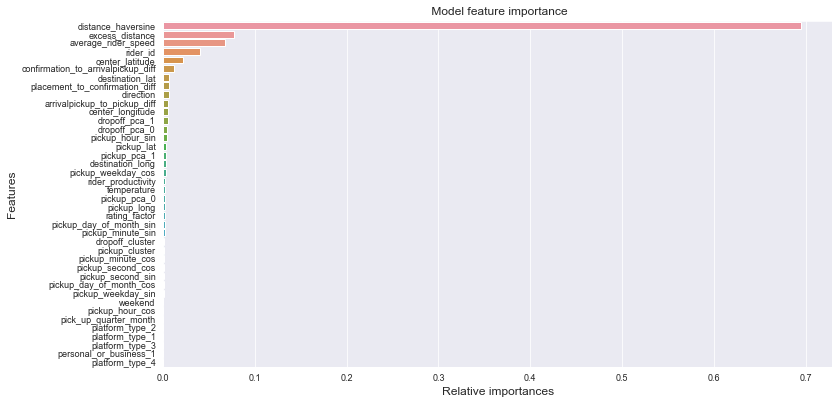

In [75]:
relative_importance(X_data, model_bag_gbr)

## 9. Submission

We use the train predictions from the cross validation to optimize the test data submission.

In [77]:
new_list = []
for i in np.linspace(0, 1, 100):
    y_train_average = train_fold_1 * i + train_fold_2 * (1 - i)
    error = np.sqrt(MSE(y_data, y_train_average))
    new_list.append(error)
px.line(x = np.linspace(0, 1, 100), y = new_list)

In [80]:
averaged_models_y = test_fold_1 * 0.2828 + test_fold_2 * (1 - 0.2828)
averaged_models_output = pd.DataFrame({"Order_No":X_test_order_no, 
                           "Time from Pickup to Arrival": averaged_models_y})
averaged_models_output.to_csv("Submission_Team_1_JHB.csv", index=False)

In [81]:
df = pd.read_csv("Submission_Team_1_JHB.csv")
df.head()

Order_No  Time from Pickup to Arrival
0  Order_No_19248                  1489.493946
1  Order_No_12736                  1489.388973
2    Order_No_768                  1258.115295
3  Order_No_15332                   961.859138
4  Order_No_21373                  1149.712817

### Model Pickling

In [82]:
import pickle

model_save_path = "s_reg_Team_1_JHB_A.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model_bag_gbr,file)

model_save_path = "s_reg_Team_1_JHB_B.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model_bag_cat,file)

## 10. References

1. [An integrated feature learning approach using deep learning for travel time prediction](https://doi.org/10.1016/j.eswa.2019.112864).

2. https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning

3. https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

4. https://towardsdatascience.com/finding-the-right-model-parameters-3670a1c086b3

5. https://github.com/frex1/Regression-Model/blob/master/reg_comp.ipynb

6. https://www.researchgate.net/publication/221019852_Development_of_an_Effective_Travel_Time_Prediction_Method_Using_Modified_Moving_Average_Approach

7. https://ieeexplore.ieee.org/document/8622970

8. https://github.com/deepVector/geospatial-machine-learning

9. https://towardsdatascience.com/think-twice-before-you-use-principal-component-analysis-in-supervised-learning-tasks-70fbb68ebd0c

10. https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab

11. https://medium.com/@mandava807/cross-validation-and-hyperparameter-tuning-in-python-65cfb80ee485

12. https://github.com/vlazovskiy/route-optimizer-machine-learning/blob/master/Train%20LightGBM%20Model.ipynb

13. https://www.researchgate.net/publication/257435756_Identifying_important_variables_for_predicting_travel_time_of_freeway_with_non-recurrent_congestion_with_neural_networks

14. https://github.com/Kailash23/forecast-delivery-time

15. https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64

16. https://github.com/AmrKhalifa/Zindi-Sendy-Logistics-Challenge